In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


## Inferencja Mózgowych komponentów z danych korelacyjnych 

### Ładowanie danych 

Pliki z danymi korelacyjnymi są przechowywane w formie struktur **.mat** - mogą one być problematyczne do odczytania. Do tego, dane dla każdej osoby sa osobno przechowywane: potrzebujemy więc Customowego ładowania 

ładownie plików mat dzieje się przez bibliotekę **mat73**, to porsta biblioteka która ładuje pliki **mat** do słownika - opiera swoje działanie na h5py oraz numpy. 

Interesują nas zmienne zapisane w wektorach, to znaczy 
+ Elc_power_core
+ Elc_spectrum_corr
+ Kurtosis
+ Spect_flat
+ Spect_one_over_f
+ Y
+ elc_signal_corr



In [2]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import mat73
import mat4py

path = 'C:\\Users\\barak\\Documents\\6_ICA_2\\BEst_data_new.mat'
data = loadmat(path)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Jun  5 21:04:31 2022',
 '__version__': '1.0',
 '__globals__': [],
 'Elc_power_core': array([[ 4.52676578],
        [ 4.37887548],
        [ 0.91510206],
        ...,
        [-0.42353748],
        [-0.25556756],
        [ 4.91048595]]),
 'Elc_spectrum_corr': array([[ 1.0928423 ],
        [ 1.07813647],
        [-0.41005008],
        ...,
        [ 0.65058311],
        [ 0.55955115],
        [ 0.96145656]]),
 'Kurtosis': array([[ 1.69228073],
        [ 0.27623607],
        [-0.19667112],
        ...,
        [ 0.14594967],
        [ 0.84518311],
        [-0.03987032]]),
 'Spect_flat': array([[ 4.50574635],
        [ 1.4191207 ],
        [-0.41444   ],
        ...,
        [ 0.73312987],
        [-0.40405524],
        [ 3.33068112]]),
 'Spect_one_over_f': array([[ 0.38304087],
        [ 0.6381942 ],
        [-2.47987478],
        ...,
        [ 0.39534112],
        [ 0.26541815],
        [ 0.50182401]]),
 'Y': array

In [3]:
list_of_variables = [data[i] for i in list(data.keys())[3:-2]]

for i in range(len(list_of_variables)-1):
    data_df = np.hstack((list_of_variables[i],list_of_variables[i+1].reshape(data['Elc_power_core'].shape)))
    list_of_variables[i+1] = data_df
    
data_df = list_of_variables[-1]
df_cat_data = pd.DataFrame(data_df,columns=list(data.keys())[3:-2])
df_cat_data

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  \
0           4.526766           1.092842  1.692281    4.505746   
1           4.378875           1.078136  0.276236    1.419121   
2           0.915102          -0.410050 -0.196671   -0.414440   
3           0.897985           0.918699 -0.170015   -0.151572   
4           2.318681           0.866184 -0.362367   -0.356178   
...              ...                ...       ...         ...   
1419       -0.315888          -2.344171 -0.254116   -1.043731   
1420       -0.396908           0.632625  1.069904    1.662334   
1421       -0.423537           0.650583  0.145950    0.733130   
1422       -0.255568           0.559551  0.845183   -0.404055   
1423        4.910486           0.961457 -0.039870    3.330681   

      Spect_one_over_f    Y  elc_signal_corr  
0             0.383041  0.0         4.812877  
1             0.638194  0.0         4.589973  
2            -2.479875  0.0         0.930902  
3             0.580709  1.0         1.889247  
4             0.216521  1.0         0.632152  
...                ...  ...              ...  
1419         -0.926009  1.0        -0.260976  
1420          0.380299  1.0        -0.505903  
1421          0.395341  1.0        -0.527208  
1422          0.265418  1.0        -0.308661  
1423          0.501824  0.0         4.838424  

[1424 rows x 7 columns]

In [4]:
data_df.shape

(1424, 7)

### Wizualizacja Danych

Ich rozkłady, wzajemne korelacje itp:

#### Korelacje zmiennych

Widać, że w większości przypadków zmienne mnie są ze sobą bardzo skorelowane. Jedynym wyjątkiemn jest para **elc_signal_corr** oraz **Elc_power_core**, które są niezwykle silnie skorelowane (0.93) są to współczynniki korelacji mocy, oraz samego sygnału dla poszczegółnego komponentu. Oba komponenty są fizycznie bardzo związane, także korelacja tutaj nie powinna dziwić.

Innymi słowy, gdyby model cierpiał na niedokładność wynikajacą z nadmiaru wymiarowości, można opuścić którąś z tych zmiennych



<AxesSubplot:>

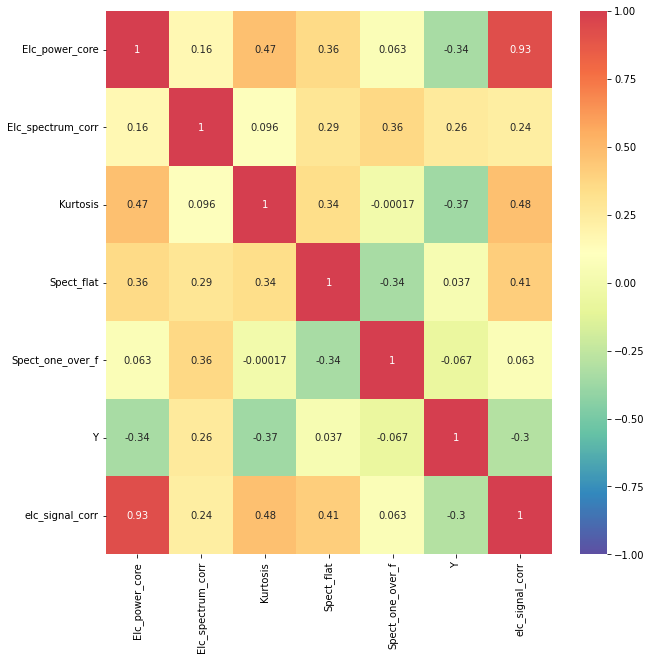

In [5]:
import seaborn as sns
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
rainbow = cm.get_cmap('Spectral', 512).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.0, 0.9, 512)))
newcmp




plt.figure(figsize=(10,10))
sns.heatmap(df_cat_data.corr(),annot=True,cmap=newcmp,vmin=-1,vmax=1)


#### Rozkłady poszczególnych zmiennych

Można zauważyć, że poszczególne zmienne mają kształt prawie gaussowski,  skoncetnrowany w okół zera zazwyczaj jednak ich ogony są przesunięte w jedną lub drugą stronę.

Możemy jednak już teraz zauważyć niezbalansowanie klas w przypadku zmiennej Y - czyli naszego targetu

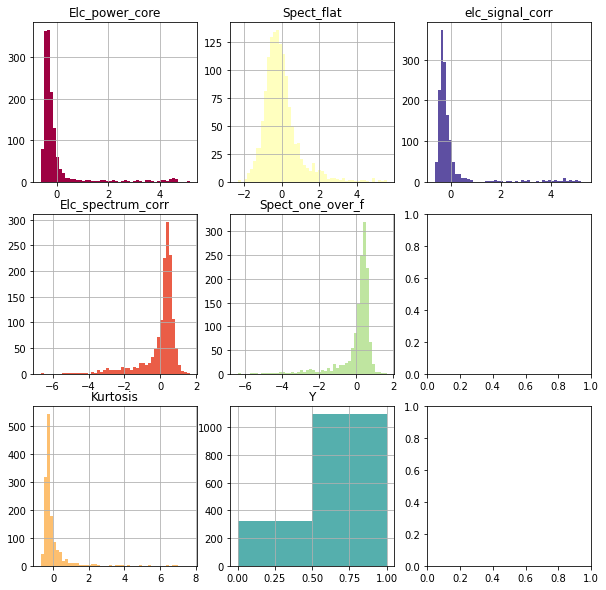

In [6]:
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridisBig = cm.get_cmap('Spectral', 7)
newcmp = ListedColormap(viridisBig(np.linspace(0.1, 0.9, 7)))
newcmp

x_count =0
y_count = 0
fig,axs = plt.subplots(3,3, figsize=(10,10))
for i,c in zip(df_cat_data.columns,newcmp.colors):
    if x_count ==3:
        x_count = 0;
        y_count+=1
    axs[x_count,y_count].set_title('{}'.format(i))
    axs[x_count,y_count].grid()
    if i == 'Y':
        bins = 2
    else:
        bins = 50


    axs[x_count,y_count].hist(df_cat_data[i],color=c,bins=bins,histtype='stepfilled')
    x_count  +=1



In [7]:
columns = list(df_cat_data.columns)
y = df_cat_data[columns.pop(columns.index('Y'))]
X = df_cat_data[columns]
X

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  \
0           4.526766           1.092842  1.692281    4.505746   
1           4.378875           1.078136  0.276236    1.419121   
2           0.915102          -0.410050 -0.196671   -0.414440   
3           0.897985           0.918699 -0.170015   -0.151572   
4           2.318681           0.866184 -0.362367   -0.356178   
...              ...                ...       ...         ...   
1419       -0.315888          -2.344171 -0.254116   -1.043731   
1420       -0.396908           0.632625  1.069904    1.662334   
1421       -0.423537           0.650583  0.145950    0.733130   
1422       -0.255568           0.559551  0.845183   -0.404055   
1423        4.910486           0.961457 -0.039870    3.330681   

      Spect_one_over_f  elc_signal_corr  
0             0.383041         4.812877  
1             0.638194         4.589973  
2            -2.479875         0.930902  
3             0.580709         1.889247  
4             0.216521         0.632152  
...                ...              ...  
1419         -0.926009        -0.260976  
1420          0.380299        -0.505903  
1421          0.395341        -0.527208  
1422          0.265418        -0.308661  
1423          0.501824         4.838424  

[1424 rows x 6 columns]

#### Statystyki opisowe

In [8]:
df_cat_data.describe()

Elc_power_core  Elc_spectrum_corr     Kurtosis   Spect_flat  \
count     1424.000000        1424.000000  1424.000000  1424.000000   
mean         0.003448           0.000675    -0.000028     0.002339   
std          0.999682           0.991504     0.991177     0.995099   
min         -0.615187          -6.668499    -0.710928    -2.326378   
25%         -0.408781          -0.065272    -0.376658    -0.581861   
50%         -0.301392           0.320280    -0.278876    -0.160632   
75%         -0.119815           0.518118    -0.065211     0.328101   
max          5.178304           1.648745     7.674776     5.568439   

       Spect_one_over_f            Y  elc_signal_corr  
count       1424.000000  1424.000000      1424.000000  
mean           0.000352     0.773174         0.003398  
std            0.991266     0.418926         0.999436  
min           -6.406491     0.000000        -0.656688  
25%           -0.013822     1.000000        -0.388645  
50%            0.312956     1.000000        -0.276072  
75%            0.499670     1.000000        -0.089999  
max            1.643076     1.000000         5.324390

In [9]:
w_class0 = np.where(y == 0)[0]
w_class1 = np.where(y == 1)[0]
w_class1_downsampled = np.random.choice(w_class1, size=len(w_class0), replace=False)

y_downsampled = y.T[list(w_class1_downsampled)+list(w_class0)].T
X_downsampled = X.T[list(w_class1_downsampled)+list(w_class0)].T
X_downsampled

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  \
1320        0.055005           0.540802 -0.275815   -0.118564   
835        -0.404460           0.139324 -0.261486   -0.392790   
902        -0.236546           0.268284 -0.239550   -0.200541   
880        -0.398945           0.233810 -0.264317   -0.217871   
942        -0.134591           0.320872 -0.449085    0.100699   
...              ...                ...       ...         ...   
1391       -0.350010          -2.075848 -0.331494   -0.856472   
1407       -0.285789          -1.890404  0.364231   -0.755692   
1409       -0.057344          -0.374161 -0.012187   -0.910260   
1412       -0.377814          -0.039221  0.424918   -0.797873   
1423        4.910486           0.961457 -0.039870    3.330681   

      Spect_one_over_f  elc_signal_corr  
1320          0.500732        -0.051733  
835          -0.672712        -0.199204  
902           0.412791        -0.191692  
880           0.320570        -0.399759  
942          -0.353885        -0.316359  
...                ...              ...  
1391          0.523360        -0.476979  
1407          0.142771        -0.286163  
1409         -0.113822        -0.171705  
1412          0.372490        -0.084226  
1423          0.501824         4.838424  

[646 rows x 6 columns]

### Downsampling 

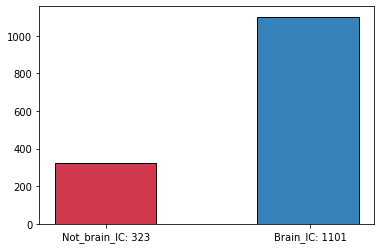

In [10]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

N, bins, patches = ax.hist(y, edgecolor='black', linewidth=1,bins=3)
rainbow = cm.get_cmap('Spectral', 12).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.1, 0.9, 12)))
newcmp
for i in range(0,1):
    patches[i].set_facecolor(newcmp.colors[-1])
for i in range(1,3):    
    patches[i].set_facecolor(newcmp.colors[0])

ax.set_xticks((0.17,0.84))
ax.set_xticklabels(['Not_brain_IC: {}'.format(len(w_class0)),'Brain_IC: {}'.format(len(w_class1))])

plt.show()


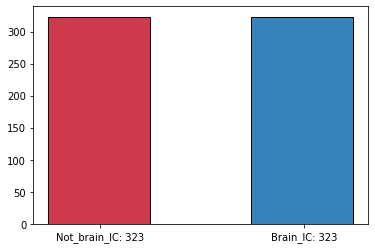

In [11]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

N, bins, patches = ax.hist(y_downsampled, edgecolor='black', linewidth=1,bins=3)
rainbow = cm.get_cmap('Spectral', 12).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.1, 0.9, 12)))
newcmp
for i in range(0,1):
    patches[i].set_facecolor(newcmp.colors[-1])
for i in range(1,3):    
    patches[i].set_facecolor(newcmp.colors[0])
    
ax.set_xticks((0.17,0.84))
ax.set_xticklabels(['Not_brain_IC: {}'.format(len( np.where(y_downsampled == 0)[0])),'Brain_IC: {}'.format(len(np.where(y_downsampled == 1)[0]))])

plt.show()


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_downsampled, y_downsampled, test_size=0.33, random_state=42)

### Uczenie i wybieranie modeli:

By nauczyć modele stwórzmy Pipeline normalizujący najpierw nasze dane, po czym elegancko pozwalający nam 

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


kfold = StratifiedKFold(5)


pipe_1 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='rbf',probability=True))])
pipe_2 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='linear',probability=True))])
pipe_3 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])
pipe_4 = Pipeline([('preprocessing', StandardScaler()), ('classifier', GradientBoostingClassifier())])
pipe_5 = Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier(
                                                                                DecisionTreeClassifier(max_depth=1), 
                                                                                n_estimators=2, 
                                                                                learning_rate=0.5, 
                                                                                algorithm="SAMME.R", 
                                                                                random_state=42))])

pipe_6 = Pipeline([('preprocessing', StandardScaler()), ('classifier', BaggingClassifier(
                                                                                DecisionTreeClassifier(max_depth=1), 
                                                                             n_jobs=-1))])
pipe_7 = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier(n_jobs=-1))])

param_grid = {
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}
param_grid_2 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
param_grid_4 = {
            'classifier__n_estimators': [50,100,200,500],
            'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
            'classifier__max_depth': [3,9,18,36,None],
            'classifier__max_leaf_nodes': [4,8,16,32,64,None],

}

param_grid_6 = {
            'classifier__n_estimators': [50,100,200,500],
            'classifier__max_depth': [3,9,18,36],
            'classifier__max_leaf_nodes': [4,8,16,32,64],

}

param_grid_3 = {
            'classifier__n_estimators': [10,50,100,200,500],
            'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
            'classifier__base_estimator__max_depth': [3,9,18,36],
            'classifier__base_estimator__max_leaf_nodes': [4,8,16,32,64],

}

param_grid_5 = {
            'classifier__n_estimators': [50,100,200,500],
            'classifier__base_estimator__max_depth': [3,9,18,36],
            'classifier__base_estimator__max_leaf_nodes': [4,8,16,32,64],

}

grid_1 = GridSearchCV(pipe_1, param_grid, cv=kfold, return_train_score=True)
grid_2 = GridSearchCV(pipe_2, param_grid, cv=kfold, return_train_score=True)
grid_3 = GridSearchCV(pipe_3, param_grid_2, cv=kfold, return_train_score=True)
grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True,verbose=1)
grid_5 = GridSearchCV(pipe_5, param_grid_3, cv=kfold, return_train_score=True)
grid_6 = GridSearchCV(pipe_6, param_grid_5, cv=kfold, return_train_score=True)
grid_7 = GridSearchCV(pipe_7, param_grid_6, cv=kfold, return_train_score=True)


In [14]:
grid_1.fit(X_train, y_train)
grid_1.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', SVC(C=100, gamma=0.1, probability=True))])

In [15]:
grid_2.fit(X_train, y_train)
grid_2.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 SVC(C=1, gamma=0.001, kernel='linear', probability=True))])

In [16]:
grid_3.fit(X_train, y_train)
grid_3.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=1))])

In [17]:
grid_4.fit(X_train, y_train)
grid_4.best_estimator_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=36,
                                            max_leaf_nodes=16,
                                            n_estimators=500))])

In [18]:
grid_5.fit(X_train, y_train)
grid_5.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          max_leaf_nodes=4),
                                    learning_rate=0.01, n_estimators=200,
                                    random_state=42))])

In [19]:
grid_6.fit(X_train, y_train)
grid_6.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=9,
                                                                         max_leaf_nodes=32),
                                   n_estimators=50, n_jobs=-1))])

In [20]:
grid_7.fit(X_train, y_train)
grid_7.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=9, max_leaf_nodes=16,
                                        n_estimators=50, n_jobs=-1))])

### najlepsze modele

Tutaj poniżej mamy Screen z najlepszymi zachowanymi modelami:

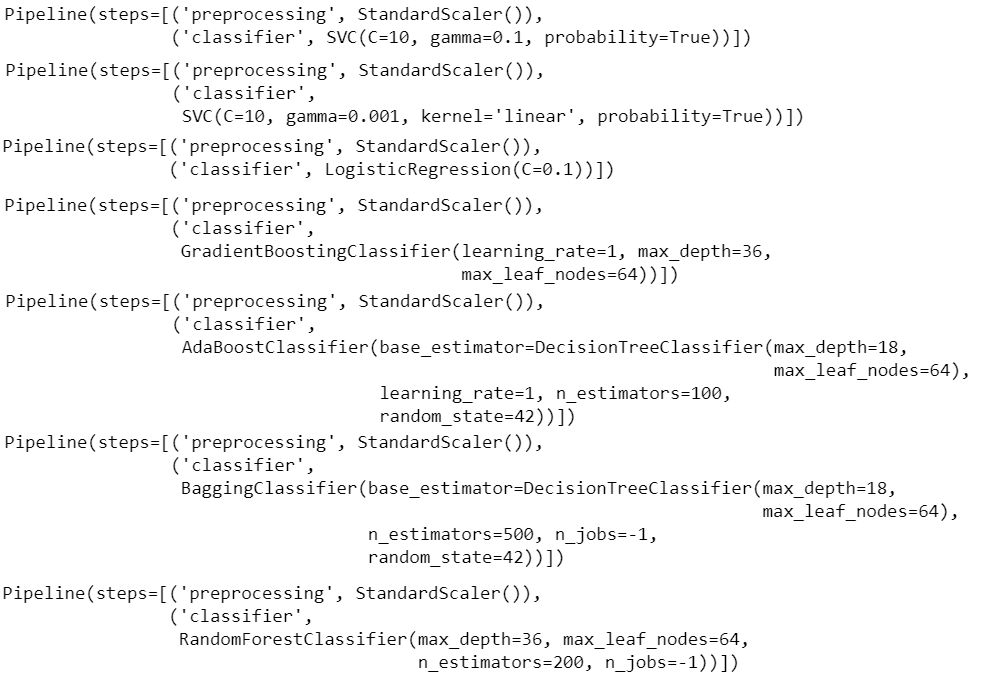

In [21]:
### Grid searched  Classifiers:


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


model_1 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='rbf',C=10,gamma=0.1,probability=True))])
model_2 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='linear',C=10,gamma=0.001,probability=True))])
model_3 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(C=0.1))])
model_4 =  Pipeline([('preprocessing', StandardScaler()), ('classifier',  GradientBoostingClassifier(learning_rate=1, 
                                                                                                     max_depth=36,
                                                                                                     max_leaf_nodes=64))])
model_5 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                                                                                                  max_leaf_nodes=64),
                                                                                            learning_rate=1, 
                                                                                            n_estimators=100,
                                                                                            random_state=42))])
model_6 =  Pipeline([('preprocessing', StandardScaler()), ('classifier',  BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                                                                                                  max_leaf_nodes=64),
                                                                                            n_estimators=500, 
                                                                                            n_jobs=-1,
                                                                                            random_state=42))])
model_7 =  Pipeline([('preprocessing', StandardScaler()), ('classifier',  RandomForestClassifier(max_depth=36, max_leaf_nodes=64,
                                                                                                 n_estimators=200, n_jobs=-1))])
model_1.fit(X_train,y_train)
model_2.fit(X_train,y_train)
model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)
model_6.fit(X_train,y_train)
model_7.fit(X_train,y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=36, max_leaf_nodes=64,
                                        n_estimators=200, n_jobs=-1))])

In [23]:
from keras.regularizers import l1,l2
from keras.callbacks import History

from keras.layers import Dense,BatchNormalization,Flatten

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import History

#Scaling
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

history_Adam = History()

def build_model(Dense1=100,Dense2=50):
    model = Sequential()
    model.add(Dense(Dense1,activation="relu",input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(Dense2,activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dense(10,activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(2,activation="relu"))
    model.summary()

    model.compile(loss="binary_crossentropy",optimizer="Rmsprop", metrics=["accuracy"])
    
    return model

keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

param_distribs = {
    "Dense1": [25,50,100],
    "Dense2": [10,25,50]
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=10, verbose=2)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=150, mode='max', verbose=1,restore_best_weights=True)
rnd_search_cv.fit(X_train, y_train, validation_data= (sc.transform(X_val), y_val), batch_size=128,epochs=1000, callbacks=[history_Adam,early_stopping])


C:\Users\barak\AppData\Local\Temp\ipykernel_2536\1079875325.py:44: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                175       
                                                                 
 batch_normalization (BatchN  (None, 25)               100       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 batch_normalization_1 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                             

Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.5688 - accuracy: 0.4459 - val_loss: 1.7508 - val_accuracy: 0.3551
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4690 - accuracy: 0.4742 - val_loss: 1.7896 - val_accuracy: 0.3598
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4199 - accuracy: 0.4716 - val_loss: 1.7512 - val_accuracy: 0.3598
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3489 - accuracy: 0.4871 - val_loss: 1.7055 - val_accuracy: 0.3692
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3232 - accuracy: 0.4510 - val_loss: 1.7306 - val_accuracy: 0.3551
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4460 - accuracy: 0.4665 - val_loss: 1.6933 - val_accuracy: 0.3551
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3417 - accuracy: 0.4639 - val_loss: 1.7123 - val_accuracy: 0.3645
Epoch 

Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3636 - accuracy: 0.6598 - val_loss: 1.3670 - val_accuracy: 0.4112
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3091 - accuracy: 0.5954 - val_loss: 1.3933 - val_accuracy: 0.4252
Epoch 105/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.1912 - accuracy: 0.6108 - val_loss: 1.3852 - val_accuracy: 0.4299
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3558 - accuracy: 0.6082 - val_loss: 1.5001 - val_accuracy: 0.4346
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1748 - accuracy: 0.6237 - val_loss: 1.5511 - val_accuracy: 0.4206
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1793 - accuracy: 0.6057 - val_loss: 1.5371 - val_accuracy: 0.4206
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1414 - accuracy: 0.6211 - val_loss: 1.5785 - val_accuracy: 0.4252

4/4 [==============================] - 0s 11ms/step - loss: 0.7802 - accuracy: 0.7139 - val_loss: 1.5404 - val_accuracy: 0.5748
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7392 - accuracy: 0.7397 - val_loss: 1.4869 - val_accuracy: 0.5701
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7372 - accuracy: 0.7242 - val_loss: 1.4783 - val_accuracy: 0.5888
Epoch 163/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6941 - accuracy: 0.7371 - val_loss: 1.4747 - val_accuracy: 0.5841
Epoch 164/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7360 - accuracy: 0.7165 - val_loss: 1.4590 - val_accuracy: 0.5794
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7270 - accuracy: 0.7500 - val_loss: 1.4591 - val_accuracy: 0.5888
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7012 - accuracy: 0.7423 - val_loss: 1.4592 - val_accuracy: 0.5935
Epoch 167/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5869 - accuracy: 0.7345 - val_loss: 1.2552 - val_accuracy: 0.5841
Epoch 218/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5321 - accuracy: 0.7139 - val_loss: 1.2428 - val_accuracy: 0.5748
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5688 - accuracy: 0.7500 - val_loss: 1.2867 - val_accuracy: 0.5888
Epoch 220/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5601 - accuracy: 0.7268 - val_loss: 1.3286 - val_accuracy: 0.5888
Epoch 221/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5364 - accuracy: 0.7345 - val_loss: 1.2443 - val_accuracy: 0.5654
Epoch 222/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5274 - accuracy: 0.7216 - val_loss: 1.2346 - val_accuracy: 0.5794
Epoch 223/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5345 - accuracy: 0.7139 - val_loss: 1.2126 - val_accuracy: 0.5841
Epoch 224/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5187 - accuracy: 0.6959 - val_loss: 1.1549 - val_accuracy: 0.5981
Epoch 275/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4435 - accuracy: 0.7139 - val_loss: 1.1529 - val_accuracy: 0.5981
Epoch 276/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4592 - accuracy: 0.7088 - val_loss: 1.1320 - val_accuracy: 0.5981
Epoch 277/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4849 - accuracy: 0.7088 - val_loss: 1.1299 - val_accuracy: 0.5841
Epoch 278/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4421 - accuracy: 0.7165 - val_loss: 1.1322 - val_accuracy: 0.5935
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5036 - accuracy: 0.7113 - val_loss: 1.1289 - val_accuracy: 0.5888
Epoch 280/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4875 - accuracy: 0.7216 - val_loss: 1.0961 - val_accuracy: 0.6028
Epoch 281/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4819 - accuracy: 0.7088 - val_loss: 1.1433 - val_accuracy: 0.5701
Epoch 332/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4761 - accuracy: 0.7242 - val_loss: 1.1422 - val_accuracy: 0.5748
Epoch 333/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4255 - accuracy: 0.7397 - val_loss: 1.1428 - val_accuracy: 0.5748
Epoch 334/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4368 - accuracy: 0.7345 - val_loss: 1.1420 - val_accuracy: 0.5654
Epoch 335/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4181 - accuracy: 0.6985 - val_loss: 1.1427 - val_accuracy: 0.5794
Epoch 335: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 0.9011 - accuracy: 0.6364
[CV] END ...............................Dense1=25, Dense2=10; total time=  17.5s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)       

Epoch 38/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1297 - accuracy: 0.5206 - val_loss: 1.5579 - val_accuracy: 0.4673
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9634 - accuracy: 0.5232 - val_loss: 1.5410 - val_accuracy: 0.4673
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9503 - accuracy: 0.5335 - val_loss: 1.5219 - val_accuracy: 0.4579
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0477 - accuracy: 0.5335 - val_loss: 1.4812 - val_accuracy: 0.4579
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1068 - accuracy: 0.5206 - val_loss: 1.4775 - val_accuracy: 0.4579
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9936 - accuracy: 0.5000 - val_loss: 1.4562 - val_accuracy: 0.4579
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8929 - accuracy: 0.5232 - val_loss: 1.4129 - val_accuracy: 0.4626
Epoch 

Epoch 96/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7717 - accuracy: 0.4665 - val_loss: 1.0280 - val_accuracy: 0.5701
Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5560 - accuracy: 0.4588 - val_loss: 0.9936 - val_accuracy: 0.5841
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5511 - accuracy: 0.4716 - val_loss: 0.9872 - val_accuracy: 0.5888
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5074 - accuracy: 0.4794 - val_loss: 0.9805 - val_accuracy: 0.5794
Epoch 100/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4867 - accuracy: 0.4639 - val_loss: 1.0018 - val_accuracy: 0.5654
Epoch 101/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5474 - accuracy: 0.4871 - val_loss: 1.0055 - val_accuracy: 0.5561
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5148 - accuracy: 0.4871 - val_loss: 1.0085 - val_accuracy: 0.5794
Epo

4/4 [==============================] - 0s 12ms/step - loss: 0.5300 - accuracy: 0.6366 - val_loss: 1.1286 - val_accuracy: 0.7009
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4790 - accuracy: 0.6134 - val_loss: 1.1406 - val_accuracy: 0.7009
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5210 - accuracy: 0.6289 - val_loss: 1.1717 - val_accuracy: 0.6963
Epoch 156/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5362 - accuracy: 0.6263 - val_loss: 1.2328 - val_accuracy: 0.6822
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5465 - accuracy: 0.5722 - val_loss: 1.2038 - val_accuracy: 0.6729
Epoch 158/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5519 - accuracy: 0.6108 - val_loss: 1.1659 - val_accuracy: 0.6495
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5219 - accuracy: 0.6186 - val_loss: 1.1446 - val_accuracy: 0.6589
Epoch 160/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4294 - accuracy: 0.5722 - val_loss: 1.3136 - val_accuracy: 0.5841
Epoch 211/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5115 - accuracy: 0.5129 - val_loss: 1.3396 - val_accuracy: 0.5888
Epoch 212/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4453 - accuracy: 0.5103 - val_loss: 1.2951 - val_accuracy: 0.6262
Epoch 213/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4277 - accuracy: 0.5129 - val_loss: 1.3197 - val_accuracy: 0.6355
Epoch 214/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4736 - accuracy: 0.5438 - val_loss: 1.3416 - val_accuracy: 0.6355
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5760 - accuracy: 0.5232 - val_loss: 1.3110 - val_accuracy: 0.6402
Epoch 216/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4220 - accuracy: 0.5490 - val_loss: 1.3072 - val_accuracy: 0.6402
Epoch 217/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4257 - accuracy: 0.6469 - val_loss: 1.3136 - val_accuracy: 0.7290
Epoch 268/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4551 - accuracy: 0.6649 - val_loss: 1.3127 - val_accuracy: 0.7243
Epoch 269/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4273 - accuracy: 0.6418 - val_loss: 1.4011 - val_accuracy: 0.7150
Epoch 270/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4096 - accuracy: 0.6443 - val_loss: 1.3988 - val_accuracy: 0.7150
Epoch 271/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4544 - accuracy: 0.6495 - val_loss: 1.3422 - val_accuracy: 0.7290
Epoch 272/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4738 - accuracy: 0.6314 - val_loss: 1.3250 - val_accuracy: 0.7196
Epoch 273/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5028 - accuracy: 0.6469 - val_loss: 1.2983 - val_accuracy: 0.7103
Epoch 274/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4127 - accuracy: 0.5026 - val_loss: 1.3397 - val_accuracy: 0.5421
Epoch 325/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3547 - accuracy: 0.4897 - val_loss: 1.3165 - val_accuracy: 0.5514
Epoch 326/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4110 - accuracy: 0.5026 - val_loss: 1.3374 - val_accuracy: 0.5467
Epoch 327/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4234 - accuracy: 0.4948 - val_loss: 1.3160 - val_accuracy: 0.5607
Epoch 328/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4033 - accuracy: 0.4897 - val_loss: 1.3681 - val_accuracy: 0.5514
Epoch 329/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4392 - accuracy: 0.5258 - val_loss: 1.3124 - val_accuracy: 0.5561
Epoch 330/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4050 - accuracy: 0.4588 - val_loss: 1.3037 - val_accuracy: 0.5514
Epoch 331/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4313 - accuracy: 0.4794 - val_loss: 1.2407 - val_accuracy: 0.5654
Epoch 382/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3859 - accuracy: 0.4897 - val_loss: 1.2629 - val_accuracy: 0.5607
Epoch 382: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.8566 - accuracy: 0.7273
[CV] END ...............................Dense1=25, Dense2=10; total time=  18.0s
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 25)                175       
                                                                 
 batch_normalization_6 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 25)              

Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0972 - accuracy: 0.6144 - val_loss: 1.6856 - val_accuracy: 0.5514
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0814 - accuracy: 0.6401 - val_loss: 1.6744 - val_accuracy: 0.5467
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0658 - accuracy: 0.5887 - val_loss: 1.6349 - val_accuracy: 0.5374
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0493 - accuracy: 0.5938 - val_loss: 1.6202 - val_accuracy: 0.5374
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0444 - accuracy: 0.5861 - val_loss: 1.5873 - val_accuracy: 0.5327
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9159 - accuracy: 0.6504 - val_loss: 1.5398 - val_accuracy: 0.5234
Epoch 47/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.9784 - accuracy: 0.6272 - val_loss: 1.5565 - val_accuracy: 0.5187
Epoch 

Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7480 - accuracy: 0.6710 - val_loss: 1.2352 - val_accuracy: 0.6449
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.6478 - val_loss: 1.2394 - val_accuracy: 0.6262
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6561 - accuracy: 0.6247 - val_loss: 1.2586 - val_accuracy: 0.6402
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6622 - accuracy: 0.6478 - val_loss: 1.2493 - val_accuracy: 0.6449
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7280 - accuracy: 0.6272 - val_loss: 1.2771 - val_accuracy: 0.6449
Epoch 104/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6695 - accuracy: 0.6324 - val_loss: 1.3482 - val_accuracy: 0.6589
Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6775 - accuracy: 0.5990 - val_loss: 1.3349 - val_accuracy: 0.6636


4/4 [==============================] - 0s 11ms/step - loss: 0.5796 - accuracy: 0.6812 - val_loss: 1.2152 - val_accuracy: 0.6636
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6530 - accuracy: 0.5887 - val_loss: 1.2360 - val_accuracy: 0.6682
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6479 - accuracy: 0.6375 - val_loss: 1.2331 - val_accuracy: 0.6636
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6974 - accuracy: 0.6195 - val_loss: 1.2902 - val_accuracy: 0.6682
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6572 - accuracy: 0.6067 - val_loss: 1.2663 - val_accuracy: 0.6682
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5819 - accuracy: 0.6350 - val_loss: 1.2545 - val_accuracy: 0.6495
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6151 - accuracy: 0.5116 - val_loss: 1.2591 - val_accuracy: 0.6449
Epoch 163/1000

Epoch 34/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.7194 - accuracy: 0.6427 - val_loss: 5.0713 - val_accuracy: 0.6308
Epoch 35/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.7827 - accuracy: 0.6504 - val_loss: 5.0619 - val_accuracy: 0.6308
Epoch 36/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.7515 - accuracy: 0.6504 - val_loss: 5.0606 - val_accuracy: 0.6355
Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.6662 - accuracy: 0.6607 - val_loss: 5.0519 - val_accuracy: 0.6402
Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.6649 - accuracy: 0.6530 - val_loss: 5.0390 - val_accuracy: 0.6402
Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.6394 - accuracy: 0.6452 - val_loss: 5.0333 - val_accuracy: 0.6449
Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.7345 - accuracy: 0.6375 - val_loss: 5.0265 - val_accuracy: 0.6402
Epoch 

Epoch 92/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.1110 - accuracy: 0.6684 - val_loss: 4.8254 - val_accuracy: 0.6589
Epoch 93/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.1644 - accuracy: 0.6555 - val_loss: 4.8263 - val_accuracy: 0.6542
Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0945 - accuracy: 0.6684 - val_loss: 4.8576 - val_accuracy: 0.6589
Epoch 95/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.0209 - accuracy: 0.6504 - val_loss: 4.8635 - val_accuracy: 0.6589
Epoch 96/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0071 - accuracy: 0.6658 - val_loss: 4.8653 - val_accuracy: 0.6589
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0157 - accuracy: 0.6555 - val_loss: 4.8870 - val_accuracy: 0.6589
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9817 - accuracy: 0.6838 - val_loss: 4.9096 - val_accuracy: 0.6589
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 3.9135 - accuracy: 0.6915 - val_loss: 4.8444 - val_accuracy: 0.7056
Epoch 150/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8630 - accuracy: 0.6812 - val_loss: 4.8472 - val_accuracy: 0.7009
Epoch 151/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8521 - accuracy: 0.6710 - val_loss: 4.8426 - val_accuracy: 0.7009
Epoch 152/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.0263 - accuracy: 0.6735 - val_loss: 4.8416 - val_accuracy: 0.7009
Epoch 153/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9026 - accuracy: 0.6838 - val_loss: 4.8391 - val_accuracy: 0.7009
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.8434 - accuracy: 0.6838 - val_loss: 4.8385 - val_accuracy: 0.6963
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.9461 - accuracy: 0.6915 - val_loss: 4.8394 - val_accuracy: 0.6963
Epoch 156/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.0849 - accuracy: 0.6658 - val_loss: 3.5876 - val_accuracy: 0.6121
Epoch 207/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.1094 - accuracy: 0.6427 - val_loss: 3.5714 - val_accuracy: 0.5935
Epoch 208/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.0856 - accuracy: 0.6452 - val_loss: 3.5966 - val_accuracy: 0.5935
Epoch 209/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.2092 - accuracy: 0.6221 - val_loss: 3.5570 - val_accuracy: 0.5935
Epoch 210/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.9563 - accuracy: 0.6478 - val_loss: 3.4994 - val_accuracy: 0.5888
Epoch 211/1000
4/4 [==============================] - 0s 10ms/step - loss: 2.9975 - accuracy: 0.6427 - val_loss: 3.5508 - val_accuracy: 0.5935
Epoch 212/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.9317 - accuracy: 0.6144 - val_loss: 3.4755 - val_accuracy: 0.5888
Epoch 213/1000

4/4 [==============================] - 0s 11ms/step - loss: 1.8607 - accuracy: 0.5964 - val_loss: 2.2699 - val_accuracy: 0.5374
Epoch 264/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9264 - accuracy: 0.6041 - val_loss: 2.2030 - val_accuracy: 0.5514
Epoch 265/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8401 - accuracy: 0.5784 - val_loss: 2.1709 - val_accuracy: 0.5514
Epoch 266/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8125 - accuracy: 0.6247 - val_loss: 2.1958 - val_accuracy: 0.5467
Epoch 267/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6985 - accuracy: 0.6170 - val_loss: 2.1849 - val_accuracy: 0.5467
Epoch 268/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8027 - accuracy: 0.6067 - val_loss: 2.1156 - val_accuracy: 0.5280
Epoch 269/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7227 - accuracy: 0.6272 - val_loss: 2.1153 - val_accuracy: 0.5327
Epoch 270/1000

Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0936 - accuracy: 0.5090 - val_loss: 1.8803 - val_accuracy: 0.7009
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.0258 - accuracy: 0.5141 - val_loss: 1.8182 - val_accuracy: 0.6869
Epoch 24/1000
4/4 [==============================] - 0s 10ms/step - loss: 2.0269 - accuracy: 0.5039 - val_loss: 1.8562 - val_accuracy: 0.6542
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9257 - accuracy: 0.5116 - val_loss: 1.8499 - val_accuracy: 0.6449
Epoch 26/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.0151 - accuracy: 0.5193 - val_loss: 1.8128 - val_accuracy: 0.6495
Epoch 27/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.0850 - accuracy: 0.4833 - val_loss: 1.8047 - val_accuracy: 0.6495
Epoch 28/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.1064 - accuracy: 0.4936 - val_loss: 1.7653 - val_accuracy: 0.6495
Epoch 

Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9562 - accuracy: 0.4473 - val_loss: 1.0996 - val_accuracy: 0.4626
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0619 - accuracy: 0.4370 - val_loss: 1.0917 - val_accuracy: 0.4860
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9981 - accuracy: 0.4781 - val_loss: 1.0827 - val_accuracy: 0.4953
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0500 - accuracy: 0.4422 - val_loss: 1.0814 - val_accuracy: 0.4907
Epoch 84/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9418 - accuracy: 0.4267 - val_loss: 1.0744 - val_accuracy: 0.4860
Epoch 85/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9204 - accuracy: 0.4550 - val_loss: 1.0507 - val_accuracy: 0.4907
Epoch 86/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0183 - accuracy: 0.4293 - val_loss: 1.0556 - val_accuracy: 0.5000
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.8316 - accuracy: 0.4499 - val_loss: 1.0613 - val_accuracy: 0.5280
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8601 - accuracy: 0.4524 - val_loss: 1.0294 - val_accuracy: 0.5234
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7728 - accuracy: 0.4319 - val_loss: 1.0294 - val_accuracy: 0.5140
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7994 - accuracy: 0.4370 - val_loss: 1.0445 - val_accuracy: 0.5374
Epoch 141/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8117 - accuracy: 0.4987 - val_loss: 1.0495 - val_accuracy: 0.5654
Epoch 142/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7510 - accuracy: 0.5167 - val_loss: 1.0466 - val_accuracy: 0.5935
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7720 - accuracy: 0.5501 - val_loss: 1.0382 - val_accuracy: 0.5981
Epoch 144/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5636 - accuracy: 0.5296 - val_loss: 0.7347 - val_accuracy: 0.6215
Epoch 195/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5724 - accuracy: 0.5681 - val_loss: 0.7521 - val_accuracy: 0.6262
Epoch 196/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5298 - accuracy: 0.5758 - val_loss: 0.7508 - val_accuracy: 0.5607
Epoch 197/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5339 - accuracy: 0.5219 - val_loss: 0.7152 - val_accuracy: 0.5701
Epoch 198/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5126 - accuracy: 0.5244 - val_loss: 0.7180 - val_accuracy: 0.5841
Epoch 199/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5122 - accuracy: 0.5347 - val_loss: 0.7144 - val_accuracy: 0.5607
Epoch 200/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5578 - accuracy: 0.5090 - val_loss: 0.7139 - val_accuracy: 0.4860
Epoch 201/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3601 - accuracy: 0.3496 - val_loss: 0.7221 - val_accuracy: 0.4673
Epoch 252/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3653 - accuracy: 0.3342 - val_loss: 0.7145 - val_accuracy: 0.4720
Epoch 253/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3769 - accuracy: 0.3470 - val_loss: 0.7654 - val_accuracy: 0.4439
Epoch 254/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4560 - accuracy: 0.3573 - val_loss: 0.7644 - val_accuracy: 0.4533
Epoch 255/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4076 - accuracy: 0.3573 - val_loss: 0.7717 - val_accuracy: 0.5000
Epoch 256/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4653 - accuracy: 0.3702 - val_loss: 0.7475 - val_accuracy: 0.5093
Epoch 257/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3395 - accuracy: 0.4010 - val_loss: 0.7705 - val_accuracy: 0.5093
Epoch 258/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3843 - accuracy: 0.3393 - val_loss: 0.8130 - val_accuracy: 0.4112
Epoch 309/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3779 - accuracy: 0.3316 - val_loss: 0.8156 - val_accuracy: 0.4393
Epoch 310/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3596 - accuracy: 0.3522 - val_loss: 0.8168 - val_accuracy: 0.4486
Epoch 311/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4187 - accuracy: 0.3368 - val_loss: 0.7873 - val_accuracy: 0.4486
Epoch 312/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3364 - accuracy: 0.3265 - val_loss: 0.7811 - val_accuracy: 0.4486
Epoch 313/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3757 - accuracy: 0.3805 - val_loss: 0.8091 - val_accuracy: 0.4533
Epoch 314/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4064 - accuracy: 0.3548 - val_loss: 0.8109 - val_accuracy: 0.4439
Epoch 315/1000

Epoch 28/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8841 - accuracy: 0.5835 - val_loss: 1.7504 - val_accuracy: 0.6729
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8344 - accuracy: 0.5553 - val_loss: 1.7344 - val_accuracy: 0.6776
Epoch 30/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8097 - accuracy: 0.5784 - val_loss: 1.7509 - val_accuracy: 0.6776
Epoch 31/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7990 - accuracy: 0.5784 - val_loss: 1.7489 - val_accuracy: 0.6729
Epoch 32/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8771 - accuracy: 0.5861 - val_loss: 1.7407 - val_accuracy: 0.6776
Epoch 33/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7391 - accuracy: 0.5398 - val_loss: 1.7293 - val_accuracy: 0.6729
Epoch 34/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6303 - accuracy: 0.5167 - val_loss: 1.7196 - val_accuracy: 0.6776
Epoch 

Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9808 - accuracy: 0.5938 - val_loss: 1.2542 - val_accuracy: 0.5561
Epoch 87/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9800 - accuracy: 0.5604 - val_loss: 1.2470 - val_accuracy: 0.5561
Epoch 88/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9841 - accuracy: 0.5578 - val_loss: 1.2644 - val_accuracy: 0.5514
Epoch 89/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9806 - accuracy: 0.5887 - val_loss: 1.2580 - val_accuracy: 0.5514
Epoch 90/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.8863 - accuracy: 0.5913 - val_loss: 1.2524 - val_accuracy: 0.5654
Epoch 91/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8178 - accuracy: 0.5887 - val_loss: 1.2498 - val_accuracy: 0.5701
Epoch 92/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8851 - accuracy: 0.5784 - val_loss: 1.2376 - val_accuracy: 0.5607
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.6045 - accuracy: 0.6401 - val_loss: 1.0356 - val_accuracy: 0.6215
Epoch 144/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5562 - accuracy: 0.6324 - val_loss: 1.0319 - val_accuracy: 0.6075
Epoch 145/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6091 - accuracy: 0.6170 - val_loss: 1.0274 - val_accuracy: 0.6121
Epoch 146/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5961 - accuracy: 0.6401 - val_loss: 0.9970 - val_accuracy: 0.5981
Epoch 147/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5639 - accuracy: 0.6324 - val_loss: 0.9907 - val_accuracy: 0.6168
Epoch 148/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5816 - accuracy: 0.6118 - val_loss: 0.9967 - val_accuracy: 0.6075
Epoch 149/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5314 - accuracy: 0.6452 - val_loss: 0.9956 - val_accuracy: 0.6028
Epoch 150/1000

Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.5324 - accuracy: 0.5450 - val_loss: 2.2406 - val_accuracy: 0.4533
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3708 - accuracy: 0.5476 - val_loss: 2.2099 - val_accuracy: 0.4579
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3186 - accuracy: 0.5527 - val_loss: 2.1844 - val_accuracy: 0.4626
Epoch 26/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3782 - accuracy: 0.5501 - val_loss: 2.1708 - val_accuracy: 0.4626
Epoch 27/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3096 - accuracy: 0.5527 - val_loss: 2.1226 - val_accuracy: 0.4626
Epoch 28/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3337 - accuracy: 0.5476 - val_loss: 2.0995 - val_accuracy: 0.4626
Epoch 29/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.1868 - accuracy: 0.5450 - val_loss: 2.0649 - val_accuracy: 0.4626
Epoch 

Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0856 - accuracy: 0.5553 - val_loss: 1.6544 - val_accuracy: 0.4766
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0577 - accuracy: 0.5630 - val_loss: 1.6540 - val_accuracy: 0.4766
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1493 - accuracy: 0.5604 - val_loss: 1.6510 - val_accuracy: 0.4766
Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2056 - accuracy: 0.5656 - val_loss: 1.6521 - val_accuracy: 0.4766
Epoch 85/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1587 - accuracy: 0.5578 - val_loss: 1.6503 - val_accuracy: 0.4766
Epoch 86/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1157 - accuracy: 0.5707 - val_loss: 1.6422 - val_accuracy: 0.4766
Epoch 87/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.0439 - accuracy: 0.5681 - val_loss: 1.6469 - val_accuracy: 0.4766
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.8602 - accuracy: 0.5938 - val_loss: 1.4544 - val_accuracy: 0.4673
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7784 - accuracy: 0.5913 - val_loss: 1.4758 - val_accuracy: 0.4720
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8593 - accuracy: 0.5784 - val_loss: 1.4584 - val_accuracy: 0.4673
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8625 - accuracy: 0.5733 - val_loss: 1.4324 - val_accuracy: 0.4720
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9198 - accuracy: 0.5810 - val_loss: 1.4159 - val_accuracy: 0.4673
Epoch 143/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7699 - accuracy: 0.5861 - val_loss: 1.4319 - val_accuracy: 0.4720
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7516 - accuracy: 0.5887 - val_loss: 1.4399 - val_accuracy: 0.4720
Epoch 145/1000

Epoch 19/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.7182 - accuracy: 0.4499 - val_loss: 2.2552 - val_accuracy: 0.4159
Epoch 20/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.6484 - accuracy: 0.4704 - val_loss: 2.2310 - val_accuracy: 0.4159
Epoch 21/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.6918 - accuracy: 0.4730 - val_loss: 2.1978 - val_accuracy: 0.4299
Epoch 22/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4826 - accuracy: 0.4550 - val_loss: 2.1870 - val_accuracy: 0.4299
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5517 - accuracy: 0.4627 - val_loss: 2.1736 - val_accuracy: 0.4346
Epoch 24/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5048 - accuracy: 0.4627 - val_loss: 2.1229 - val_accuracy: 0.4299
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4319 - accuracy: 0.4627 - val_loss: 2.0900 - val_accuracy: 0.4299
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9769 - accuracy: 0.6607 - val_loss: 1.1341 - val_accuracy: 0.6776
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0784 - accuracy: 0.6812 - val_loss: 1.1309 - val_accuracy: 0.6729
Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9649 - accuracy: 0.6684 - val_loss: 1.1217 - val_accuracy: 0.6776
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9613 - accuracy: 0.6710 - val_loss: 1.0835 - val_accuracy: 0.6776
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9495 - accuracy: 0.6812 - val_loss: 1.0709 - val_accuracy: 0.4112
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9460 - accuracy: 0.5244 - val_loss: 1.0613 - val_accuracy: 0.4112
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9549 - accuracy: 0.6298 - val_loss: 1.0524 - val_accuracy: 0.6729
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.6660 - accuracy: 0.6967 - val_loss: 0.9739 - val_accuracy: 0.7009
Epoch 135/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6561 - accuracy: 0.7069 - val_loss: 0.9707 - val_accuracy: 0.6963
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7513 - accuracy: 0.6915 - val_loss: 0.9989 - val_accuracy: 0.7056
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7221 - accuracy: 0.6967 - val_loss: 0.9973 - val_accuracy: 0.7056
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6887 - accuracy: 0.6992 - val_loss: 0.9739 - val_accuracy: 0.7103
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7035 - accuracy: 0.7352 - val_loss: 0.9985 - val_accuracy: 0.7150
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7119 - accuracy: 0.6941 - val_loss: 1.0011 - val_accuracy: 0.7150
Epoch 141/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.6195 - accuracy: 0.6195 - val_loss: 0.8804 - val_accuracy: 0.4860
Epoch 192/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5893 - accuracy: 0.6375 - val_loss: 0.8768 - val_accuracy: 0.4813
Epoch 193/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5933 - accuracy: 0.6170 - val_loss: 0.8730 - val_accuracy: 0.4907
Epoch 194/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5760 - accuracy: 0.6298 - val_loss: 0.8694 - val_accuracy: 0.5000
Epoch 195/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5738 - accuracy: 0.6298 - val_loss: 0.8687 - val_accuracy: 0.5047
Epoch 196/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5550 - accuracy: 0.6195 - val_loss: 0.8655 - val_accuracy: 0.5047
Epoch 197/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5341 - accuracy: 0.6401 - val_loss: 0.8663 - val_accuracy: 0.5187
Epoch 198/1000

4/4 [==============================] - 0s 10ms/step - loss: 0.5788 - accuracy: 0.6812 - val_loss: 0.7824 - val_accuracy: 0.5607
Epoch 249/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5384 - accuracy: 0.7044 - val_loss: 0.7823 - val_accuracy: 0.5607
Epoch 250/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5120 - accuracy: 0.6864 - val_loss: 0.7514 - val_accuracy: 0.5701
Epoch 251/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5361 - accuracy: 0.6889 - val_loss: 0.7522 - val_accuracy: 0.5561
Epoch 252/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5196 - accuracy: 0.6735 - val_loss: 0.7808 - val_accuracy: 0.5701
Epoch 253/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4538 - accuracy: 0.6838 - val_loss: 0.7803 - val_accuracy: 0.5654
Epoch 254/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5091 - accuracy: 0.6864 - val_loss: 0.7815 - val_accuracy: 0.5654
Epoch 255/1000

_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 51ms/step - loss: 4.9257 - accuracy: 0.5039 - val_loss: 8.1125 - val_accuracy: 0.4533
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.6339 - accuracy: 0.5398 - val_loss: 6.7741 - val_accuracy: 0.4907
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4890 - accuracy: 0.5347 - val_loss: 5.7413 - val_accuracy: 0.5374
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3145 - accuracy: 0.5398 - val_loss: 5.0478 - val_accuracy: 0.5327
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2604 - accuracy: 0.5501 - val_loss: 4.3956 - val_accuracy: 0.5794
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1678 - accuracy: 0.5707 - val_loss: 3.9207 - val_accuracy: 0.5841
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2751 - accura

4/4 [==============================] - 0s 11ms/step - loss: 1.8179 - accuracy: 0.5501 - val_loss: 1.5385 - val_accuracy: 0.4766
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7288 - accuracy: 0.5424 - val_loss: 1.5540 - val_accuracy: 0.4766
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7746 - accuracy: 0.5450 - val_loss: 1.5479 - val_accuracy: 0.4720
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7498 - accuracy: 0.5604 - val_loss: 1.5408 - val_accuracy: 0.4626
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7819 - accuracy: 0.5527 - val_loss: 1.5361 - val_accuracy: 0.4673
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7880 - accuracy: 0.5450 - val_loss: 1.5259 - val_accuracy: 0.4720
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5948 - accuracy: 0.5501 - val_loss: 1.5192 - val_accuracy: 0.4766
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.9834 - accuracy: 0.5553 - val_loss: 1.5298 - val_accuracy: 0.4813
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9392 - accuracy: 0.5733 - val_loss: 1.5230 - val_accuracy: 0.4907
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9158 - accuracy: 0.5913 - val_loss: 1.4742 - val_accuracy: 0.4860
Epoch 119/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.8959 - accuracy: 0.5784 - val_loss: 1.4633 - val_accuracy: 0.4860
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9153 - accuracy: 0.5810 - val_loss: 1.4780 - val_accuracy: 0.4813
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8739 - accuracy: 0.6015 - val_loss: 1.4789 - val_accuracy: 0.4907
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9186 - accuracy: 0.5784 - val_loss: 1.4828 - val_accuracy: 0.4907

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_27 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 25)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_28 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 10)               

4/4 [==============================] - 0s 12ms/step - loss: 2.3899 - accuracy: 0.5758 - val_loss: 1.6821 - val_accuracy: 0.4626
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2649 - accuracy: 0.5758 - val_loss: 1.6764 - val_accuracy: 0.4486
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1880 - accuracy: 0.5476 - val_loss: 1.6742 - val_accuracy: 0.4486
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0854 - accuracy: 0.5501 - val_loss: 1.6651 - val_accuracy: 0.4439
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1540 - accuracy: 0.5656 - val_loss: 1.7374 - val_accuracy: 0.4860
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0857 - accuracy: 0.5398 - val_loss: 1.7261 - val_accuracy: 0.4860
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2169 - accuracy: 0.5373 - val_loss: 1.7311 - val_accuracy: 0.4346
Epoch 52/1000
4/4 [=

Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1789 - accuracy: 0.4704 - val_loss: 1.1633 - val_accuracy: 0.4673
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2395 - accuracy: 0.4524 - val_loss: 1.2032 - val_accuracy: 0.4626
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3110 - accuracy: 0.4396 - val_loss: 1.1917 - val_accuracy: 0.4579
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1942 - accuracy: 0.4576 - val_loss: 1.1942 - val_accuracy: 0.4486
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2412 - accuracy: 0.4653 - val_loss: 1.1859 - val_accuracy: 0.4813
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2622 - accuracy: 0.4499 - val_loss: 1.2097 - val_accuracy: 0.4860
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2729 - accuracy: 0.4576 - val_loss: 1.1740 - val_accuracy: 0.4907

4/4 [==============================] - 0s 12ms/step - loss: 0.8554 - accuracy: 0.5501 - val_loss: 1.2669 - val_accuracy: 0.5701
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7981 - accuracy: 0.5476 - val_loss: 1.2728 - val_accuracy: 0.5654
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8844 - accuracy: 0.5347 - val_loss: 1.2506 - val_accuracy: 0.5607
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8160 - accuracy: 0.5630 - val_loss: 1.2187 - val_accuracy: 0.5701
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8916 - accuracy: 0.5450 - val_loss: 1.2011 - val_accuracy: 0.5748
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8096 - accuracy: 0.5604 - val_loss: 1.1891 - val_accuracy: 0.5841
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7354 - accuracy: 0.5630 - val_loss: 1.1880 - val_accuracy: 0.5701
Epoch 167/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.7332 - accuracy: 0.5964 - val_loss: 1.1579 - val_accuracy: 0.6215
Epoch 218/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7851 - accuracy: 0.5784 - val_loss: 1.1941 - val_accuracy: 0.6262
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7007 - accuracy: 0.6272 - val_loss: 1.1844 - val_accuracy: 0.6168
Epoch 220/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7151 - accuracy: 0.5938 - val_loss: 1.1845 - val_accuracy: 0.6168
Epoch 221/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6690 - accuracy: 0.6144 - val_loss: 1.1857 - val_accuracy: 0.6215
Epoch 222/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7281 - accuracy: 0.6015 - val_loss: 1.1824 - val_accuracy: 0.6215
Epoch 223/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6981 - accuracy: 0.6221 - val_loss: 1.1823 - val_accuracy: 0.6215
Epoch 224/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.6075 - accuracy: 0.6427 - val_loss: 1.1147 - val_accuracy: 0.6449
Epoch 275/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6661 - accuracy: 0.6710 - val_loss: 1.1093 - val_accuracy: 0.6402
Epoch 276/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6494 - accuracy: 0.6530 - val_loss: 1.1089 - val_accuracy: 0.6402
Epoch 277/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6420 - accuracy: 0.6761 - val_loss: 1.0909 - val_accuracy: 0.6542
Epoch 278/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6735 - accuracy: 0.6787 - val_loss: 1.0537 - val_accuracy: 0.6495
Epoch 279/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6730 - accuracy: 0.6684 - val_loss: 1.0596 - val_accuracy: 0.6542
Epoch 280/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5880 - accuracy: 0.6684 - val_loss: 1.0574 - val_accuracy: 0.6589
Epoch 281/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5988 - accuracy: 0.5476 - val_loss: 1.0584 - val_accuracy: 0.6308
Epoch 332/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5858 - accuracy: 0.5964 - val_loss: 1.0378 - val_accuracy: 0.6308
Epoch 333/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5055 - accuracy: 0.5501 - val_loss: 1.0401 - val_accuracy: 0.6215
Epoch 334/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5146 - accuracy: 0.5321 - val_loss: 1.0402 - val_accuracy: 0.5794
Epoch 335/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5518 - accuracy: 0.5296 - val_loss: 0.9930 - val_accuracy: 0.5374
Epoch 336/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5135 - accuracy: 0.4833 - val_loss: 0.9932 - val_accuracy: 0.5374
Epoch 337/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5735 - accuracy: 0.4756 - val_loss: 1.0258 - val_accuracy: 0.5467
Epoch 338/1000

Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8097 - accuracy: 0.4459 - val_loss: 1.9704 - val_accuracy: 0.5280
Epoch 20/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8233 - accuracy: 0.4794 - val_loss: 1.9276 - val_accuracy: 0.5280
Epoch 21/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5938 - accuracy: 0.4845 - val_loss: 1.9272 - val_accuracy: 0.5327
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5515 - accuracy: 0.4923 - val_loss: 1.7815 - val_accuracy: 0.5467
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7283 - accuracy: 0.4948 - val_loss: 1.7830 - val_accuracy: 0.5280
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7265 - accuracy: 0.4820 - val_loss: 1.8200 - val_accuracy: 0.5280
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6011 - accuracy: 0.4794 - val_loss: 1.8095 - val_accuracy: 0.5280
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0943 - accuracy: 0.4562 - val_loss: 1.6120 - val_accuracy: 0.5140
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0478 - accuracy: 0.4871 - val_loss: 1.6344 - val_accuracy: 0.5187
Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0437 - accuracy: 0.4871 - val_loss: 1.6362 - val_accuracy: 0.5187
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0813 - accuracy: 0.4768 - val_loss: 1.6669 - val_accuracy: 0.5140
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0327 - accuracy: 0.4923 - val_loss: 1.6968 - val_accuracy: 0.5327
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1053 - accuracy: 0.4381 - val_loss: 1.7214 - val_accuracy: 0.5280
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0277 - accuracy: 0.4536 - val_loss: 1.6861 - val_accuracy: 0.5280
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.7283 - accuracy: 0.5077 - val_loss: 1.6473 - val_accuracy: 0.4813
Epoch 135/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6540 - accuracy: 0.5206 - val_loss: 1.6141 - val_accuracy: 0.4766
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7548 - accuracy: 0.4923 - val_loss: 1.5919 - val_accuracy: 0.4860
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6297 - accuracy: 0.5103 - val_loss: 1.5926 - val_accuracy: 0.4953
Epoch 138/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6717 - accuracy: 0.5258 - val_loss: 1.6368 - val_accuracy: 0.4860
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6056 - accuracy: 0.5103 - val_loss: 1.5673 - val_accuracy: 0.4720
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7169 - accuracy: 0.4948 - val_loss: 1.4995 - val_accuracy: 0.4626
Epoch 141/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4285 - accuracy: 0.5206 - val_loss: 1.6114 - val_accuracy: 0.4579
Epoch 192/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6089 - accuracy: 0.5000 - val_loss: 1.5636 - val_accuracy: 0.4720
Epoch 193/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5197 - accuracy: 0.5490 - val_loss: 1.5285 - val_accuracy: 0.4860
Epoch 194/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4623 - accuracy: 0.4974 - val_loss: 1.6087 - val_accuracy: 0.4720
Epoch 195/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5417 - accuracy: 0.5180 - val_loss: 1.5795 - val_accuracy: 0.4720
Epoch 196/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5577 - accuracy: 0.5103 - val_loss: 1.5331 - val_accuracy: 0.4720
Epoch 197/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4812 - accuracy: 0.5077 - val_loss: 1.5297 - val_accuracy: 0.4860
Epoch 198/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4520 - accuracy: 0.5387 - val_loss: 1.6502 - val_accuracy: 0.5794
Epoch 249/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4141 - accuracy: 0.5387 - val_loss: 1.6995 - val_accuracy: 0.5607
Epoch 250/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4149 - accuracy: 0.5387 - val_loss: 1.5919 - val_accuracy: 0.5841
Epoch 251/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3905 - accuracy: 0.5103 - val_loss: 1.6979 - val_accuracy: 0.5607
Epoch 252/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3615 - accuracy: 0.5077 - val_loss: 1.6488 - val_accuracy: 0.5467
Epoch 253/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3585 - accuracy: 0.5129 - val_loss: 1.5668 - val_accuracy: 0.5841
Epoch 254/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4504 - accuracy: 0.5129 - val_loss: 1.6367 - val_accuracy: 0.5561
Epoch 255/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4503 - accuracy: 0.5722 - val_loss: 1.3065 - val_accuracy: 0.5841
Epoch 306/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4466 - accuracy: 0.5335 - val_loss: 1.3026 - val_accuracy: 0.5607
Epoch 307/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3754 - accuracy: 0.5129 - val_loss: 1.3407 - val_accuracy: 0.5701
Epoch 308/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3972 - accuracy: 0.5180 - val_loss: 1.3059 - val_accuracy: 0.5888
Epoch 309/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4789 - accuracy: 0.5206 - val_loss: 1.3039 - val_accuracy: 0.5841
Epoch 310/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3854 - accuracy: 0.5412 - val_loss: 1.3031 - val_accuracy: 0.5841
Epoch 311/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3784 - accuracy: 0.5464 - val_loss: 1.2838 - val_accuracy: 0.5794
Epoch 312/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3765 - accuracy: 0.5335 - val_loss: 1.4787 - val_accuracy: 0.5981
Epoch 363/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4305 - accuracy: 0.5026 - val_loss: 1.4513 - val_accuracy: 0.6028
Epoch 364/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3388 - accuracy: 0.5619 - val_loss: 1.5362 - val_accuracy: 0.6075
Epoch 365/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3747 - accuracy: 0.5438 - val_loss: 1.5367 - val_accuracy: 0.6028
Epoch 366/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3149 - accuracy: 0.5258 - val_loss: 1.5395 - val_accuracy: 0.6168
Epoch 367/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4420 - accuracy: 0.5335 - val_loss: 1.5483 - val_accuracy: 0.6215
Epoch 368/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3540 - accuracy: 0.5722 - val_loss: 1.5398 - val_accuracy: 0.6075
Epoch 369/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3484 - accuracy: 0.5129 - val_loss: 1.4988 - val_accuracy: 0.5794
Epoch 420/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3890 - accuracy: 0.5284 - val_loss: 1.4648 - val_accuracy: 0.5748
Epoch 421/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2970 - accuracy: 0.5232 - val_loss: 1.4325 - val_accuracy: 0.5654
Epoch 422/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3434 - accuracy: 0.5155 - val_loss: 1.4567 - val_accuracy: 0.5654
Epoch 423/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4431 - accuracy: 0.4948 - val_loss: 1.4599 - val_accuracy: 0.5140
Epoch 424/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3236 - accuracy: 0.4820 - val_loss: 1.4593 - val_accuracy: 0.5047
Epoch 425/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2889 - accuracy: 0.5000 - val_loss: 1.4582 - val_accuracy: 0.5140
Epoch 426/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4002 - accuracy: 0.4923 - val_loss: 1.4852 - val_accuracy: 0.6075
Epoch 477/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4138 - accuracy: 0.5180 - val_loss: 1.4815 - val_accuracy: 0.5981
Epoch 478/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3274 - accuracy: 0.5206 - val_loss: 1.4993 - val_accuracy: 0.5981
Epoch 479/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2752 - accuracy: 0.4871 - val_loss: 1.5029 - val_accuracy: 0.5981
Epoch 480/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3402 - accuracy: 0.5026 - val_loss: 1.4706 - val_accuracy: 0.5981
Epoch 481/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2629 - accuracy: 0.4974 - val_loss: 1.4362 - val_accuracy: 0.6028
Epoch 482/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3814 - accuracy: 0.4716 - val_loss: 1.4432 - val_accuracy: 0.5981
Epoch 483/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2807 - accuracy: 0.5412 - val_loss: 1.5251 - val_accuracy: 0.5981
Epoch 534/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3149 - accuracy: 0.5490 - val_loss: 1.5058 - val_accuracy: 0.5607
Epoch 535/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3111 - accuracy: 0.5077 - val_loss: 1.5119 - val_accuracy: 0.5935
Epoch 536/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3354 - accuracy: 0.5309 - val_loss: 1.5354 - val_accuracy: 0.5607
Epoch 537/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3409 - accuracy: 0.5232 - val_loss: 1.5414 - val_accuracy: 0.6075
Epoch 538/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3390 - accuracy: 0.5593 - val_loss: 1.5476 - val_accuracy: 0.6075
Epoch 539/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2680 - accuracy: 0.5335 - val_loss: 1.5199 - val_accuracy: 0.5935
Epoch 540/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2576 - accuracy: 0.5335 - val_loss: 1.6251 - val_accuracy: 0.5981
Epoch 591/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3614 - accuracy: 0.5593 - val_loss: 1.6343 - val_accuracy: 0.5888
Epoch 592/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4396 - accuracy: 0.5335 - val_loss: 1.5873 - val_accuracy: 0.5701
Epoch 593/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3192 - accuracy: 0.5361 - val_loss: 1.5626 - val_accuracy: 0.5935
Epoch 594/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3320 - accuracy: 0.5284 - val_loss: 1.5925 - val_accuracy: 0.5654
Epoch 595/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4516 - accuracy: 0.5335 - val_loss: 1.6407 - val_accuracy: 0.5841
Epoch 596/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2463 - accuracy: 0.5232 - val_loss: 1.6118 - val_accuracy: 0.5888
Epoch 597/1000

Epoch 646: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.9987 - accuracy: 0.4091
[CV] END ...............................Dense1=25, Dense2=25; total time=  27.5s
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_33 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 25)                0         
                                                                 
 dense_45 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_34 (Bat  (None, 25)               100 

Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9511 - accuracy: 0.6057 - val_loss: 1.4057 - val_accuracy: 0.7009
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0223 - accuracy: 0.6340 - val_loss: 1.4216 - val_accuracy: 0.7056
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9363 - accuracy: 0.6392 - val_loss: 1.4088 - val_accuracy: 0.7196
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9574 - accuracy: 0.6057 - val_loss: 1.4019 - val_accuracy: 0.7150
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9608 - accuracy: 0.6134 - val_loss: 1.3968 - val_accuracy: 0.7243
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9404 - accuracy: 0.6211 - val_loss: 1.3330 - val_accuracy: 0.7150
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8566 - accuracy: 0.5876 - val_loss: 1.3239 - val_accuracy: 0.7103
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5858 - accuracy: 0.7036 - val_loss: 0.9822 - val_accuracy: 0.6682
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6239 - accuracy: 0.6959 - val_loss: 0.9534 - val_accuracy: 0.6636
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6592 - accuracy: 0.7242 - val_loss: 0.9767 - val_accuracy: 0.6682
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6427 - accuracy: 0.7139 - val_loss: 0.9781 - val_accuracy: 0.6776
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6115 - accuracy: 0.7088 - val_loss: 0.9769 - val_accuracy: 0.6963
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7121 - accuracy: 0.6985 - val_loss: 0.9788 - val_accuracy: 0.7290
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6274 - accuracy: 0.6907 - val_loss: 0.9690 - val_accuracy: 0.7243

4/4 [==============================] - 0s 12ms/step - loss: 0.5960 - accuracy: 0.6675 - val_loss: 0.9091 - val_accuracy: 0.6963
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5812 - accuracy: 0.7423 - val_loss: 0.9064 - val_accuracy: 0.7196
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5920 - accuracy: 0.7216 - val_loss: 0.9033 - val_accuracy: 0.7150
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5941 - accuracy: 0.7500 - val_loss: 0.9094 - val_accuracy: 0.7290
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5094 - accuracy: 0.7474 - val_loss: 0.9071 - val_accuracy: 0.7290
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5451 - accuracy: 0.6985 - val_loss: 0.9169 - val_accuracy: 0.6729
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6290 - accuracy: 0.7268 - val_loss: 0.9404 - val_accuracy: 0.6776
Epoch 166/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4963 - accuracy: 0.5876 - val_loss: 0.9684 - val_accuracy: 0.5374
Epoch 217/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5679 - accuracy: 0.5876 - val_loss: 0.9676 - val_accuracy: 0.5327
Epoch 218/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5879 - accuracy: 0.5799 - val_loss: 0.9657 - val_accuracy: 0.5327
Epoch 219/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4994 - accuracy: 0.5696 - val_loss: 0.9677 - val_accuracy: 0.5374
Epoch 220/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4775 - accuracy: 0.6186 - val_loss: 0.9642 - val_accuracy: 0.5327
Epoch 221/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5535 - accuracy: 0.5876 - val_loss: 0.9728 - val_accuracy: 0.5467
Epoch 222/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5719 - accuracy: 0.5541 - val_loss: 0.9742 - val_accuracy: 0.5514
Epoch 223/1000

2/2 [==============================] - 0s 5ms/step - loss: 0.6578 - accuracy: 0.7500
[CV] END ...............................Dense1=25, Dense2=25; total time=  12.6s
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_36 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 25)                0         
                                                                 
 dense_49 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_37 (Bat  (None, 25)               100       
 chNormalization)  

Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6766 - accuracy: 0.4704 - val_loss: 1.3645 - val_accuracy: 0.6776
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7696 - accuracy: 0.5141 - val_loss: 1.3588 - val_accuracy: 0.6776
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8646 - accuracy: 0.5193 - val_loss: 1.3172 - val_accuracy: 0.6822
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8471 - accuracy: 0.5167 - val_loss: 1.3276 - val_accuracy: 0.6822
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7764 - accuracy: 0.5270 - val_loss: 1.2982 - val_accuracy: 0.6916
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8217 - accuracy: 0.4807 - val_loss: 1.3375 - val_accuracy: 0.6869
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7320 - accuracy: 0.5219 - val_loss: 1.3264 - val_accuracy: 0.6869
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6290 - accuracy: 0.5784 - val_loss: 0.9483 - val_accuracy: 0.6308
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5239 - accuracy: 0.5424 - val_loss: 0.9275 - val_accuracy: 0.6355
Epoch 104/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5944 - accuracy: 0.5553 - val_loss: 0.9276 - val_accuracy: 0.6355
Epoch 105/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5182 - accuracy: 0.5758 - val_loss: 0.9179 - val_accuracy: 0.6262
Epoch 106/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5026 - accuracy: 0.5990 - val_loss: 0.9170 - val_accuracy: 0.6215
Epoch 107/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5763 - accuracy: 0.5758 - val_loss: 0.9225 - val_accuracy: 0.6215
Epoch 108/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5181 - accuracy: 0.5784 - val_loss: 0.8995 - val_accuracy: 0.6262

4/4 [==============================] - 0s 12ms/step - loss: 0.5223 - accuracy: 0.5938 - val_loss: 0.8718 - val_accuracy: 0.6121
Epoch 159: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 2.0631 - accuracy: 0.7907
[CV] END ...............................Dense1=25, Dense2=25; total time=   7.6s
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_39 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 25)                0         
                                                                 
 dense_53 (Dense)            (None, 25)                650     

Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7180 - accuracy: 0.5321 - val_loss: 2.2335 - val_accuracy: 0.3972
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6518 - accuracy: 0.5424 - val_loss: 2.1965 - val_accuracy: 0.3925
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4983 - accuracy: 0.5450 - val_loss: 2.1504 - val_accuracy: 0.4019
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5277 - accuracy: 0.5501 - val_loss: 2.1268 - val_accuracy: 0.4159
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4271 - accuracy: 0.5347 - val_loss: 2.0854 - val_accuracy: 0.4206
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4482 - accuracy: 0.5398 - val_loss: 2.0688 - val_accuracy: 0.4299
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3868 - accuracy: 0.5347 - val_loss: 2.0524 - val_accuracy: 0.6916
Epoch 

Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5650 - accuracy: 0.7095 - val_loss: 1.4744 - val_accuracy: 0.5561
Epoch 101/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5418 - accuracy: 0.7069 - val_loss: 1.4943 - val_accuracy: 0.5561
Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5359 - accuracy: 0.7326 - val_loss: 1.4606 - val_accuracy: 0.5561
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5188 - accuracy: 0.7661 - val_loss: 1.4583 - val_accuracy: 0.5654
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5196 - accuracy: 0.7661 - val_loss: 1.4235 - val_accuracy: 0.5748
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5192 - accuracy: 0.7635 - val_loss: 1.4366 - val_accuracy: 0.6262
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5434 - accuracy: 0.7609 - val_loss: 1.4375 - val_accuracy: 0.6075

4/4 [==============================] - 0s 12ms/step - loss: 0.4788 - accuracy: 0.7866 - val_loss: 1.1843 - val_accuracy: 0.7196
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5044 - accuracy: 0.7661 - val_loss: 1.1552 - val_accuracy: 0.6963
Epoch 159/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4142 - accuracy: 0.7969 - val_loss: 1.1760 - val_accuracy: 0.6963
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4152 - accuracy: 0.8123 - val_loss: 1.1472 - val_accuracy: 0.7056
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4229 - accuracy: 0.7815 - val_loss: 1.1666 - val_accuracy: 0.6729
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4664 - accuracy: 0.7378 - val_loss: 1.1611 - val_accuracy: 0.6495
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4557 - accuracy: 0.7738 - val_loss: 1.1557 - val_accuracy: 0.6636
Epoch 164/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5205 - accuracy: 0.7841 - val_loss: 1.2351 - val_accuracy: 0.7056
Epoch 215/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3861 - accuracy: 0.7995 - val_loss: 1.2322 - val_accuracy: 0.7103
Epoch 216/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4252 - accuracy: 0.7815 - val_loss: 1.2397 - val_accuracy: 0.7150
Epoch 217/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4554 - accuracy: 0.7969 - val_loss: 1.2310 - val_accuracy: 0.7383
Epoch 218/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4328 - accuracy: 0.8149 - val_loss: 1.2359 - val_accuracy: 0.7383
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4205 - accuracy: 0.8355 - val_loss: 1.2273 - val_accuracy: 0.7430
Epoch 220/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5138 - accuracy: 0.8252 - val_loss: 1.2431 - val_accuracy: 0.7150
Epoch 221/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4326 - accuracy: 0.7892 - val_loss: 1.2129 - val_accuracy: 0.6402
Epoch 272/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3943 - accuracy: 0.7455 - val_loss: 1.2049 - val_accuracy: 0.6449
Epoch 273/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4325 - accuracy: 0.7275 - val_loss: 1.2068 - val_accuracy: 0.6121
Epoch 274/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4631 - accuracy: 0.7018 - val_loss: 1.2380 - val_accuracy: 0.6028
Epoch 275/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4230 - accuracy: 0.7378 - val_loss: 1.1931 - val_accuracy: 0.6402
Epoch 276/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4281 - accuracy: 0.7815 - val_loss: 1.2138 - val_accuracy: 0.5888
Epoch 277/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3970 - accuracy: 0.7455 - val_loss: 1.2132 - val_accuracy: 0.6075
Epoch 278/1000

4/4 [==============================] - 0s 10ms/step - loss: 0.3418 - accuracy: 0.7738 - val_loss: 1.1931 - val_accuracy: 0.7570
Epoch 329/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3524 - accuracy: 0.8201 - val_loss: 1.2463 - val_accuracy: 0.7477
Epoch 330/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3782 - accuracy: 0.8046 - val_loss: 1.2469 - val_accuracy: 0.7477
Epoch 331/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3437 - accuracy: 0.8252 - val_loss: 1.2151 - val_accuracy: 0.7523
Epoch 332/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3568 - accuracy: 0.8201 - val_loss: 1.2177 - val_accuracy: 0.7570
Epoch 333/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3355 - accuracy: 0.8355 - val_loss: 1.2493 - val_accuracy: 0.7710
Epoch 334/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3791 - accuracy: 0.8201 - val_loss: 1.2492 - val_accuracy: 0.7617
Epoch 335/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4205 - accuracy: 0.8123 - val_loss: 1.2381 - val_accuracy: 0.6776
Epoch 386/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4059 - accuracy: 0.8046 - val_loss: 1.2425 - val_accuracy: 0.6822
Epoch 387/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4001 - accuracy: 0.8278 - val_loss: 1.2428 - val_accuracy: 0.7009
Epoch 388/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3735 - accuracy: 0.8201 - val_loss: 1.2406 - val_accuracy: 0.7056
Epoch 389/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3418 - accuracy: 0.7969 - val_loss: 1.1977 - val_accuracy: 0.6869
Epoch 390/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4189 - accuracy: 0.7609 - val_loss: 1.2462 - val_accuracy: 0.7009
Epoch 391/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3687 - accuracy: 0.7841 - val_loss: 1.2663 - val_accuracy: 0.7056
Epoch 392/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3945 - accuracy: 0.7866 - val_loss: 1.2480 - val_accuracy: 0.7103
Epoch 443/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3304 - accuracy: 0.7506 - val_loss: 1.2410 - val_accuracy: 0.7196
Epoch 444/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3486 - accuracy: 0.7866 - val_loss: 1.2169 - val_accuracy: 0.7383
Epoch 445/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3440 - accuracy: 0.7661 - val_loss: 1.2177 - val_accuracy: 0.7103
Epoch 446/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3603 - accuracy: 0.7275 - val_loss: 1.1823 - val_accuracy: 0.6869
Epoch 447/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3575 - accuracy: 0.7249 - val_loss: 1.2114 - val_accuracy: 0.6916
Epoch 448/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3281 - accuracy: 0.7661 - val_loss: 1.1831 - val_accuracy: 0.6963
Epoch 449/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3079 - accuracy: 0.7661 - val_loss: 1.3191 - val_accuracy: 0.6495
Epoch 500/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3154 - accuracy: 0.8072 - val_loss: 1.3173 - val_accuracy: 0.6636
Epoch 501/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3195 - accuracy: 0.7943 - val_loss: 1.2936 - val_accuracy: 0.6776
Epoch 502/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3813 - accuracy: 0.7866 - val_loss: 1.2949 - val_accuracy: 0.7103
Epoch 503/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3278 - accuracy: 0.8123 - val_loss: 1.3159 - val_accuracy: 0.6869
Epoch 504/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3492 - accuracy: 0.7892 - val_loss: 1.3067 - val_accuracy: 0.6822
Epoch 505/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3795 - accuracy: 0.7712 - val_loss: 1.2827 - val_accuracy: 0.6822
Epoch 506/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3523 - accuracy: 0.8586 - val_loss: 1.3493 - val_accuracy: 0.7664
Epoch 557/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3943 - accuracy: 0.7892 - val_loss: 1.3249 - val_accuracy: 0.7523
Epoch 558/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3262 - accuracy: 0.7995 - val_loss: 1.3434 - val_accuracy: 0.7523
Epoch 559/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3176 - accuracy: 0.7815 - val_loss: 1.3413 - val_accuracy: 0.7336
Epoch 560/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3668 - accuracy: 0.7969 - val_loss: 1.3724 - val_accuracy: 0.7523
Epoch 561/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3014 - accuracy: 0.7892 - val_loss: 1.3737 - val_accuracy: 0.7477
Epoch 562/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3013 - accuracy: 0.8175 - val_loss: 1.3458 - val_accuracy: 0.7617
Epoch 563/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4447 - accuracy: 0.7147 - val_loss: 1.3264 - val_accuracy: 0.5607
Epoch 614/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3723 - accuracy: 0.6864 - val_loss: 1.3274 - val_accuracy: 0.5748
Epoch 615/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4081 - accuracy: 0.6838 - val_loss: 1.3239 - val_accuracy: 0.5794
Epoch 616/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3445 - accuracy: 0.6838 - val_loss: 1.3232 - val_accuracy: 0.5607
Epoch 617/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3644 - accuracy: 0.6452 - val_loss: 1.3461 - val_accuracy: 0.5607
Epoch 618/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3221 - accuracy: 0.6838 - val_loss: 1.3208 - val_accuracy: 0.5654
Epoch 619/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3930 - accuracy: 0.6864 - val_loss: 1.3232 - val_accuracy: 0.5561
Epoch 620/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4317 - accuracy: 0.7147 - val_loss: 1.2668 - val_accuracy: 0.5748
Epoch 671/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2834 - accuracy: 0.7301 - val_loss: 1.2463 - val_accuracy: 0.5701
Epoch 672/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3224 - accuracy: 0.7147 - val_loss: 1.2565 - val_accuracy: 0.5421
Epoch 673/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3557 - accuracy: 0.7095 - val_loss: 1.2915 - val_accuracy: 0.5327
Epoch 674/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3297 - accuracy: 0.6684 - val_loss: 1.2899 - val_accuracy: 0.5514
Epoch 675/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2827 - accuracy: 0.7018 - val_loss: 1.2652 - val_accuracy: 0.5374
Epoch 676/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2998 - accuracy: 0.7018 - val_loss: 1.2936 - val_accuracy: 0.5327
Epoch 677/1000

 dense_56 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_42 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 25)                0         
                                                                 
 dense_57 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_43 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_43 (Activation)  (None, 25)                0         
                                                                 
 dense_58 (Dense)            (None, 10)                260       
          

4/4 [==============================] - 0s 11ms/step - loss: 1.9653 - accuracy: 0.6324 - val_loss: 1.9211 - val_accuracy: 0.6916
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8438 - accuracy: 0.6298 - val_loss: 1.9337 - val_accuracy: 0.6963
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8165 - accuracy: 0.6401 - val_loss: 1.9555 - val_accuracy: 0.6869
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8969 - accuracy: 0.6144 - val_loss: 1.9706 - val_accuracy: 0.6963
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7962 - accuracy: 0.6272 - val_loss: 1.9370 - val_accuracy: 0.6963
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7739 - accuracy: 0.6298 - val_loss: 1.9046 - val_accuracy: 0.6963
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7300 - accuracy: 0.6324 - val_loss: 1.9521 - val_accuracy: 0.6916
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7565 - accuracy: 0.6093 - val_loss: 1.5265 - val_accuracy: 0.6822
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7218 - accuracy: 0.5630 - val_loss: 1.4973 - val_accuracy: 0.6776
Epoch 106/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7930 - accuracy: 0.5835 - val_loss: 1.4542 - val_accuracy: 0.6822
Epoch 107/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7073 - accuracy: 0.5656 - val_loss: 1.4656 - val_accuracy: 0.6963
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7059 - accuracy: 0.6118 - val_loss: 1.4575 - val_accuracy: 0.7009
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7436 - accuracy: 0.6221 - val_loss: 1.4463 - val_accuracy: 0.6869
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7095 - accuracy: 0.6118 - val_loss: 1.4383 - val_accuracy: 0.6822

4/4 [==============================] - 0s 11ms/step - loss: 0.5582 - accuracy: 0.5990 - val_loss: 1.3472 - val_accuracy: 0.6636
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5676 - accuracy: 0.5784 - val_loss: 1.3465 - val_accuracy: 0.6776
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5432 - accuracy: 0.5835 - val_loss: 1.3522 - val_accuracy: 0.6869
Epoch 164/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5508 - accuracy: 0.6144 - val_loss: 1.3545 - val_accuracy: 0.6916
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6051 - accuracy: 0.6324 - val_loss: 1.3843 - val_accuracy: 0.6963
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4905 - accuracy: 0.6350 - val_loss: 1.3901 - val_accuracy: 0.7056
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5203 - accuracy: 0.6375 - val_loss: 1.4371 - val_accuracy: 0.7009
Epoch 168/1000

Epoch 31/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6405 - accuracy: 0.5244 - val_loss: 1.4643 - val_accuracy: 0.3972
Epoch 32/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.6181 - accuracy: 0.5013 - val_loss: 1.4342 - val_accuracy: 0.4112
Epoch 33/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6086 - accuracy: 0.5347 - val_loss: 1.4101 - val_accuracy: 0.3785
Epoch 34/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5520 - accuracy: 0.5219 - val_loss: 1.4312 - val_accuracy: 0.3832
Epoch 35/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4542 - accuracy: 0.5270 - val_loss: 1.4338 - val_accuracy: 0.3785
Epoch 36/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5835 - accuracy: 0.5193 - val_loss: 1.4105 - val_accuracy: 0.3879
Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5088 - accuracy: 0.4961 - val_loss: 1.3947 - val_accuracy: 0.3879
Epoch 

Epoch 89/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7004 - accuracy: 0.4267 - val_loss: 1.2066 - val_accuracy: 0.4346
Epoch 90/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6956 - accuracy: 0.4447 - val_loss: 1.2061 - val_accuracy: 0.4439
Epoch 91/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6972 - accuracy: 0.4216 - val_loss: 1.2035 - val_accuracy: 0.4439
Epoch 92/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6633 - accuracy: 0.4242 - val_loss: 1.2050 - val_accuracy: 0.4486
Epoch 93/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6985 - accuracy: 0.4396 - val_loss: 1.2074 - val_accuracy: 0.4533
Epoch 94/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7262 - accuracy: 0.4396 - val_loss: 1.2389 - val_accuracy: 0.4626
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6443 - accuracy: 0.4319 - val_loss: 1.2372 - val_accuracy: 0.4579
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.6162 - accuracy: 0.4602 - val_loss: 1.4815 - val_accuracy: 0.4579
Epoch 147/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5061 - accuracy: 0.4602 - val_loss: 1.5310 - val_accuracy: 0.4579
Epoch 148/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4728 - accuracy: 0.4190 - val_loss: 1.5584 - val_accuracy: 0.4393
Epoch 149/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5038 - accuracy: 0.4396 - val_loss: 1.5391 - val_accuracy: 0.4346
Epoch 150/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5674 - accuracy: 0.4499 - val_loss: 1.5287 - val_accuracy: 0.4486
Epoch 151/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5877 - accuracy: 0.4344 - val_loss: 1.5338 - val_accuracy: 0.4533
Epoch 152/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5225 - accuracy: 0.4447 - val_loss: 1.5352 - val_accuracy: 0.4439
Epoch 153/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4036 - accuracy: 0.4807 - val_loss: 1.3582 - val_accuracy: 0.5000
Epoch 204/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4429 - accuracy: 0.4576 - val_loss: 1.3995 - val_accuracy: 0.5140
Epoch 205/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4158 - accuracy: 0.4473 - val_loss: 1.4117 - val_accuracy: 0.4907
Epoch 206/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4270 - accuracy: 0.4602 - val_loss: 1.4119 - val_accuracy: 0.4953
Epoch 207/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4220 - accuracy: 0.4499 - val_loss: 1.4439 - val_accuracy: 0.4813
Epoch 208/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4612 - accuracy: 0.4602 - val_loss: 1.4550 - val_accuracy: 0.4813
Epoch 209/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5060 - accuracy: 0.4576 - val_loss: 1.4513 - val_accuracy: 0.4907
Epoch 210/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4065 - accuracy: 0.4936 - val_loss: 1.4274 - val_accuracy: 0.5234
Epoch 261/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4415 - accuracy: 0.4884 - val_loss: 1.4539 - val_accuracy: 0.5140
Epoch 262/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3914 - accuracy: 0.4756 - val_loss: 1.5652 - val_accuracy: 0.5047
Epoch 263/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4800 - accuracy: 0.4781 - val_loss: 1.5352 - val_accuracy: 0.5000
Epoch 264/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5066 - accuracy: 0.5090 - val_loss: 1.5351 - val_accuracy: 0.5000
Epoch 265/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.4503 - accuracy: 0.4704 - val_loss: 1.5059 - val_accuracy: 0.5047
Epoch 266/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3496 - accuracy: 0.4910 - val_loss: 1.4752 - val_accuracy: 0.5047
Epoch 267/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3555 - accuracy: 0.5090 - val_loss: 1.5491 - val_accuracy: 0.5093
Epoch 318/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3262 - accuracy: 0.4833 - val_loss: 1.4594 - val_accuracy: 0.5000
Epoch 319/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3237 - accuracy: 0.4730 - val_loss: 1.4907 - val_accuracy: 0.5093
Epoch 320/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4982 - accuracy: 0.4859 - val_loss: 1.4200 - val_accuracy: 0.5000
Epoch 321/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6348 - accuracy: 0.4987 - val_loss: 1.4335 - val_accuracy: 0.4907
Epoch 322/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3440 - accuracy: 0.4602 - val_loss: 1.4928 - val_accuracy: 0.4907
Epoch 323/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3578 - accuracy: 0.4499 - val_loss: 1.5929 - val_accuracy: 0.5047
Epoch 324/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3096 - accuracy: 0.5270 - val_loss: 1.6612 - val_accuracy: 0.5140
Epoch 375/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3829 - accuracy: 0.5450 - val_loss: 1.6582 - val_accuracy: 0.5187
Epoch 376/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3706 - accuracy: 0.4987 - val_loss: 1.6285 - val_accuracy: 0.5234
Epoch 377/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3032 - accuracy: 0.5090 - val_loss: 1.6172 - val_accuracy: 0.5140
Epoch 378/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3147 - accuracy: 0.5013 - val_loss: 1.5883 - val_accuracy: 0.5187
Epoch 379/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3013 - accuracy: 0.5398 - val_loss: 1.6216 - val_accuracy: 0.5327
Epoch 380/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2831 - accuracy: 0.5244 - val_loss: 1.6498 - val_accuracy: 0.5467
Epoch 381/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3147 - accuracy: 0.5270 - val_loss: 1.8666 - val_accuracy: 0.5514
Epoch 432/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3311 - accuracy: 0.5758 - val_loss: 1.9146 - val_accuracy: 0.5654
Epoch 433/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3059 - accuracy: 0.5835 - val_loss: 1.8543 - val_accuracy: 0.5561
Epoch 434/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2850 - accuracy: 0.5887 - val_loss: 1.8602 - val_accuracy: 0.5561
Epoch 435/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2872 - accuracy: 0.5424 - val_loss: 1.7915 - val_accuracy: 0.5514
Epoch 436/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2606 - accuracy: 0.5835 - val_loss: 1.8007 - val_accuracy: 0.5514
Epoch 437/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3267 - accuracy: 0.5450 - val_loss: 1.8486 - val_accuracy: 0.5561
Epoch 438/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3619 - accuracy: 0.5219 - val_loss: 1.6979 - val_accuracy: 0.5607
Epoch 489/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2483 - accuracy: 0.5347 - val_loss: 1.6962 - val_accuracy: 0.5561
Epoch 490/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4943 - accuracy: 0.5578 - val_loss: 1.6989 - val_accuracy: 0.5607
Epoch 491/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3895 - accuracy: 0.5810 - val_loss: 1.6958 - val_accuracy: 0.5607
Epoch 492/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2973 - accuracy: 0.4961 - val_loss: 1.7101 - val_accuracy: 0.5467
Epoch 493/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3861 - accuracy: 0.5450 - val_loss: 1.7395 - val_accuracy: 0.5467
Epoch 494/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4450 - accuracy: 0.5630 - val_loss: 1.7291 - val_accuracy: 0.5467
Epoch 495/1000

4/4 [==============================] - 0s 10ms/step - loss: 0.2823 - accuracy: 0.4499 - val_loss: 1.6469 - val_accuracy: 0.4907
Epoch 546/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3133 - accuracy: 0.4704 - val_loss: 1.6679 - val_accuracy: 0.4907
Epoch 547/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3930 - accuracy: 0.4756 - val_loss: 1.6441 - val_accuracy: 0.5000
Epoch 548/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3077 - accuracy: 0.4473 - val_loss: 1.5970 - val_accuracy: 0.5093
Epoch 549/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3361 - accuracy: 0.4653 - val_loss: 1.5616 - val_accuracy: 0.5140
Epoch 550/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4055 - accuracy: 0.4756 - val_loss: 1.5580 - val_accuracy: 0.5140
Epoch 551/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3685 - accuracy: 0.4550 - val_loss: 1.5741 - val_accuracy: 0.5093
Epoch 552/1000

 activation_49 (Activation)  (None, 25)                0         
                                                                 
 dense_66 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_50 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 10)                0         
                                                                 
 dense_67 (Dense)            (None, 2)                 22        
                                                                 
Total params: 1,347
Trainable params: 1,227
Non-trainable params: 120
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 52ms/step - loss: 5.4572 - accuracy: 0.5681 - val_loss: 5.5749 - val_accuracy: 0.46

4/4 [==============================] - 0s 11ms/step - loss: 2.0773 - accuracy: 0.5039 - val_loss: 1.6038 - val_accuracy: 0.3832
Epoch 53/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9803 - accuracy: 0.4910 - val_loss: 1.6147 - val_accuracy: 0.3692
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9215 - accuracy: 0.5013 - val_loss: 1.5811 - val_accuracy: 0.3738
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7721 - accuracy: 0.4859 - val_loss: 1.5626 - val_accuracy: 0.3785
Epoch 56/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.1159 - accuracy: 0.4730 - val_loss: 1.5837 - val_accuracy: 0.3879
Epoch 57/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.9533 - accuracy: 0.5039 - val_loss: 1.5491 - val_accuracy: 0.3972
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8238 - accuracy: 0.4730 - val_loss: 1.5651 - val_accuracy: 0.3879
Epoch 59/1000
4/4 [=

Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1540 - accuracy: 0.4499 - val_loss: 1.2257 - val_accuracy: 0.4579
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1612 - accuracy: 0.4267 - val_loss: 1.2252 - val_accuracy: 0.4579
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0725 - accuracy: 0.4447 - val_loss: 1.2101 - val_accuracy: 0.4252
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1744 - accuracy: 0.4396 - val_loss: 1.2498 - val_accuracy: 0.4299
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0575 - accuracy: 0.4576 - val_loss: 1.2795 - val_accuracy: 0.4346
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1614 - accuracy: 0.4447 - val_loss: 1.2870 - val_accuracy: 0.4393
Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1603 - accuracy: 0.4370 - val_loss: 1.2578 - val_accuracy: 0.4299

 chNormalization)                                                
                                                                 
 activation_52 (Activation)  (None, 25)                0         
                                                                 
 dense_70 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_53 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_53 (Activation)  (None, 10)                0         
                                                                 
 dense_71 (Dense)            (None, 2)                 22        
                                                                 
Total params: 1,347
Trainable params: 1,227
Non-trainable params: 120
_________________________________________________________________
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.9426 - accuracy: 0.4936 - val_loss: 1.3041 - val_accuracy: 0.4673
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8678 - accuracy: 0.5013 - val_loss: 1.3019 - val_accuracy: 0.4673
Epoch 53/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7898 - accuracy: 0.4961 - val_loss: 1.3172 - val_accuracy: 0.4626
Epoch 54/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8691 - accuracy: 0.4679 - val_loss: 1.2888 - val_accuracy: 0.4673
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8365 - accuracy: 0.4910 - val_loss: 1.2214 - val_accuracy: 0.4626
Epoch 56/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9026 - accuracy: 0.4910 - val_loss: 1.2675 - val_accuracy: 0.4579
Epoch 57/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9024 - accuracy: 0.4627 - val_loss: 1.2599 - val_accuracy: 0.4626
Epoch 58/1000
4/4 [=

Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5883 - accuracy: 0.4781 - val_loss: 1.0402 - val_accuracy: 0.4112
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6473 - accuracy: 0.4730 - val_loss: 1.0304 - val_accuracy: 0.4112
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5586 - accuracy: 0.4679 - val_loss: 1.0291 - val_accuracy: 0.4112
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5635 - accuracy: 0.4884 - val_loss: 1.0328 - val_accuracy: 0.4159
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5570 - accuracy: 0.4730 - val_loss: 1.0298 - val_accuracy: 0.4159
Epoch 114/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6399 - accuracy: 0.4627 - val_loss: 1.0294 - val_accuracy: 0.4206
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6067 - accuracy: 0.4524 - val_loss: 1.0332 - val_accuracy: 0.4252

Total params: 1,347
Trainable params: 1,227
Non-trainable params: 120
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 54ms/step - loss: 5.1670 - accuracy: 0.4370 - val_loss: 2.6008 - val_accuracy: 0.3271
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.1001 - accuracy: 0.4730 - val_loss: 2.7286 - val_accuracy: 0.3411
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.7187 - accuracy: 0.4961 - val_loss: 2.8035 - val_accuracy: 0.3458
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.5476 - accuracy: 0.4987 - val_loss: 2.8369 - val_accuracy: 0.4486
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3092 - accuracy: 0.5090 - val_loss: 2.9048 - val_accuracy: 0.3692
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1097 - accuracy: 0.4884 - val_loss: 2.8061 - val_accuracy: 0.3785
Epoch 7/1000
4/4 [

4/4 [==============================] - 0s 12ms/step - loss: 1.2154 - accuracy: 0.6298 - val_loss: 1.7657 - val_accuracy: 0.5748
Epoch 58/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2247 - accuracy: 0.6504 - val_loss: 1.8038 - val_accuracy: 0.5935
Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1961 - accuracy: 0.6324 - val_loss: 1.7658 - val_accuracy: 0.5748
Epoch 60/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1714 - accuracy: 0.6195 - val_loss: 1.7251 - val_accuracy: 0.5701
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1598 - accuracy: 0.6272 - val_loss: 1.6896 - val_accuracy: 0.5607
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1690 - accuracy: 0.6375 - val_loss: 1.6411 - val_accuracy: 0.5701
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1504 - accuracy: 0.6067 - val_loss: 1.6005 - val_accuracy: 0.5748
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9982 - accuracy: 0.6504 - val_loss: 1.1151 - val_accuracy: 0.5841
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9867 - accuracy: 0.6375 - val_loss: 1.1245 - val_accuracy: 0.5748
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0046 - accuracy: 0.6427 - val_loss: 1.1185 - val_accuracy: 0.5935
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8979 - accuracy: 0.6632 - val_loss: 1.0952 - val_accuracy: 0.5654
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8851 - accuracy: 0.6324 - val_loss: 1.1188 - val_accuracy: 0.5654
Epoch 120/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.9048 - accuracy: 0.6401 - val_loss: 1.1074 - val_accuracy: 0.5467
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8614 - accuracy: 0.6118 - val_loss: 1.1444 - val_accuracy: 0.5561

4/4 [==============================] - 0s 11ms/step - loss: 0.8016 - accuracy: 0.6735 - val_loss: 1.1984 - val_accuracy: 0.6402
Epoch 173/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8102 - accuracy: 0.6632 - val_loss: 1.1998 - val_accuracy: 0.6449
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7718 - accuracy: 0.6530 - val_loss: 1.1995 - val_accuracy: 0.6449
Epoch 175/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7706 - accuracy: 0.7172 - val_loss: 1.1904 - val_accuracy: 0.6449
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7321 - accuracy: 0.6761 - val_loss: 1.1897 - val_accuracy: 0.6589
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8355 - accuracy: 0.7069 - val_loss: 1.1813 - val_accuracy: 0.6729
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8017 - accuracy: 0.7095 - val_loss: 1.1778 - val_accuracy: 0.6729
Epoch 179/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.6988 - accuracy: 0.7069 - val_loss: 1.1846 - val_accuracy: 0.6822
Epoch 230/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6984 - accuracy: 0.6838 - val_loss: 1.1801 - val_accuracy: 0.6869
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7304 - accuracy: 0.6710 - val_loss: 1.1780 - val_accuracy: 0.6916
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7285 - accuracy: 0.6992 - val_loss: 1.1306 - val_accuracy: 0.6776
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6869 - accuracy: 0.6812 - val_loss: 1.1739 - val_accuracy: 0.6822
Epoch 234/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7389 - accuracy: 0.6555 - val_loss: 1.2009 - val_accuracy: 0.6776
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7082 - accuracy: 0.6864 - val_loss: 1.2028 - val_accuracy: 0.6776
Epoch 236/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.6833 - accuracy: 0.7481 - val_loss: 1.2357 - val_accuracy: 0.6869
Epoch 287/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6402 - accuracy: 0.7301 - val_loss: 1.2584 - val_accuracy: 0.6963
Epoch 288/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6662 - accuracy: 0.7404 - val_loss: 1.2058 - val_accuracy: 0.6916
Epoch 289/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6992 - accuracy: 0.7352 - val_loss: 1.2066 - val_accuracy: 0.6916
Epoch 290/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.7455 - val_loss: 1.2108 - val_accuracy: 0.6916
Epoch 291/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6543 - accuracy: 0.7198 - val_loss: 1.2620 - val_accuracy: 0.6916
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6441 - accuracy: 0.7172 - val_loss: 1.2611 - val_accuracy: 0.6869
Epoch 293/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.6550 - accuracy: 0.7172 - val_loss: 1.2464 - val_accuracy: 0.6916
Epoch 344/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6089 - accuracy: 0.7455 - val_loss: 1.2208 - val_accuracy: 0.6822
Epoch 345/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6672 - accuracy: 0.7429 - val_loss: 1.2198 - val_accuracy: 0.6916
Epoch 346/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5878 - accuracy: 0.7301 - val_loss: 1.2273 - val_accuracy: 0.6963
Epoch 347/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5615 - accuracy: 0.7584 - val_loss: 1.2246 - val_accuracy: 0.6916
Epoch 348/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5620 - accuracy: 0.7121 - val_loss: 1.1761 - val_accuracy: 0.6636
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5734 - accuracy: 0.6889 - val_loss: 1.1916 - val_accuracy: 0.6729
Epoch 350/1000

                                                                 
 dense_77 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_58 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_58 (Activation)  (None, 25)                0         
                                                                 
 dense_78 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_59 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_59 (Activation)  (None, 10)                0         
                                                                 
 dense_79 

4/4 [==============================] - 0s 12ms/step - loss: 0.9137 - accuracy: 0.7378 - val_loss: 1.3408 - val_accuracy: 0.6402
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8908 - accuracy: 0.7738 - val_loss: 1.3613 - val_accuracy: 0.6355
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8389 - accuracy: 0.7789 - val_loss: 1.3483 - val_accuracy: 0.6262
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8860 - accuracy: 0.7609 - val_loss: 1.3296 - val_accuracy: 0.6355
Epoch 53/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9412 - accuracy: 0.7584 - val_loss: 1.3109 - val_accuracy: 0.6262
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8526 - accuracy: 0.7635 - val_loss: 1.3074 - val_accuracy: 0.6308
Epoch 55/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7687 - accuracy: 0.7584 - val_loss: 1.3005 - val_accuracy: 0.6355
Epoch 56/1000
4/4 [=

Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5183 - accuracy: 0.7841 - val_loss: 1.1297 - val_accuracy: 0.6449
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4830 - accuracy: 0.7738 - val_loss: 1.1301 - val_accuracy: 0.6495
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5792 - accuracy: 0.7532 - val_loss: 1.1522 - val_accuracy: 0.6355
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5210 - accuracy: 0.7866 - val_loss: 1.1592 - val_accuracy: 0.6402
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5386 - accuracy: 0.8072 - val_loss: 1.1666 - val_accuracy: 0.6589
Epoch 112/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4661 - accuracy: 0.7789 - val_loss: 1.1955 - val_accuracy: 0.6402
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5787 - accuracy: 0.7995 - val_loss: 1.2068 - val_accuracy: 0.6495

 chNormalization)                                                
                                                                 
 activation_62 (Activation)  (None, 10)                0         
                                                                 
 dense_83 (Dense)            (None, 2)                 22        
                                                                 
Total params: 2,347
Trainable params: 2,177
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 53ms/step - loss: 5.6397 - accuracy: 0.5077 - val_loss: 3.2805 - val_accuracy: 0.5327
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.9139 - accuracy: 0.5335 - val_loss: 2.8202 - val_accuracy: 0.5140
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.4867 - accuracy: 0.5747 - val_loss: 2.9311 - val_accuracy: 0.3832
Epoch 4/1000
4/4 [===========================

4/4 [==============================] - 0s 11ms/step - loss: 2.0567 - accuracy: 0.6211 - val_loss: 1.8006 - val_accuracy: 0.6355
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8580 - accuracy: 0.6314 - val_loss: 1.8086 - val_accuracy: 0.6402
Epoch 56/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8783 - accuracy: 0.6186 - val_loss: 1.8128 - val_accuracy: 0.6402
Epoch 57/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8580 - accuracy: 0.6624 - val_loss: 1.8071 - val_accuracy: 0.6215
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7855 - accuracy: 0.6366 - val_loss: 1.7826 - val_accuracy: 0.6402
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8407 - accuracy: 0.6340 - val_loss: 1.7464 - val_accuracy: 0.6308
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.7454 - accuracy: 0.6263 - val_loss: 1.7255 - val_accuracy: 0.6355
Epoch 61/1000
4/4 [=

Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9052 - accuracy: 0.7165 - val_loss: 1.3765 - val_accuracy: 0.6729
Epoch 113/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0178 - accuracy: 0.7010 - val_loss: 1.4225 - val_accuracy: 0.6822
Epoch 114/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7771 - accuracy: 0.7216 - val_loss: 1.4150 - val_accuracy: 0.6822
Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9417 - accuracy: 0.7371 - val_loss: 1.4443 - val_accuracy: 0.6729
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9645 - accuracy: 0.7062 - val_loss: 1.4341 - val_accuracy: 0.6682
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8826 - accuracy: 0.6830 - val_loss: 1.4278 - val_accuracy: 0.6729
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9957 - accuracy: 0.6907 - val_loss: 1.4253 - val_accuracy: 0.6729

4/4 [==============================] - 0s 11ms/step - loss: 0.4582 - accuracy: 0.7397 - val_loss: 1.2749 - val_accuracy: 0.7009
Epoch 170/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4263 - accuracy: 0.7010 - val_loss: 1.2747 - val_accuracy: 0.6963
Epoch 171/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5262 - accuracy: 0.7113 - val_loss: 1.2435 - val_accuracy: 0.7103
Epoch 172/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5801 - accuracy: 0.7397 - val_loss: 1.3185 - val_accuracy: 0.7150
Epoch 173/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4590 - accuracy: 0.7500 - val_loss: 1.3159 - val_accuracy: 0.7103
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4896 - accuracy: 0.7371 - val_loss: 1.3168 - val_accuracy: 0.7009
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5106 - accuracy: 0.7294 - val_loss: 1.3233 - val_accuracy: 0.7009
Epoch 176/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4080 - accuracy: 0.7320 - val_loss: 1.2135 - val_accuracy: 0.6916
Epoch 227/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3722 - accuracy: 0.7268 - val_loss: 1.2059 - val_accuracy: 0.7103
Epoch 228/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4198 - accuracy: 0.7758 - val_loss: 1.1746 - val_accuracy: 0.7150
Epoch 229/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3367 - accuracy: 0.7603 - val_loss: 1.1876 - val_accuracy: 0.7009
Epoch 230/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3528 - accuracy: 0.7577 - val_loss: 1.1726 - val_accuracy: 0.7150
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3664 - accuracy: 0.7809 - val_loss: 1.1792 - val_accuracy: 0.7196
Epoch 232/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4196 - accuracy: 0.7371 - val_loss: 1.1775 - val_accuracy: 0.6822
Epoch 233/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3012 - accuracy: 0.7345 - val_loss: 1.3751 - val_accuracy: 0.7056
Epoch 284/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3627 - accuracy: 0.7036 - val_loss: 1.4024 - val_accuracy: 0.7290
Epoch 285/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2988 - accuracy: 0.7320 - val_loss: 1.3768 - val_accuracy: 0.7243
Epoch 286/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2870 - accuracy: 0.7603 - val_loss: 1.3565 - val_accuracy: 0.7290
Epoch 287/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3132 - accuracy: 0.7655 - val_loss: 1.3709 - val_accuracy: 0.7196
Epoch 288/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2977 - accuracy: 0.7680 - val_loss: 1.3449 - val_accuracy: 0.7103
Epoch 289/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3580 - accuracy: 0.7448 - val_loss: 1.3452 - val_accuracy: 0.7103
Epoch 290/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.5188 - accuracy: 0.5412 - val_loss: 2.7548 - val_accuracy: 0.4346
Epoch 16/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4143 - accuracy: 0.5644 - val_loss: 2.7104 - val_accuracy: 0.4299
Epoch 17/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3864 - accuracy: 0.5490 - val_loss: 2.6981 - val_accuracy: 0.4159
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2958 - accuracy: 0.5567 - val_loss: 2.6564 - val_accuracy: 0.4065
Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.2101 - accuracy: 0.5593 - val_loss: 2.6137 - val_accuracy: 0.4019
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1995 - accuracy: 0.5490 - val_loss: 2.5803 - val_accuracy: 0.4019
Epoch 21/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.1290 - accuracy: 0.5412 - val_loss: 2.5049 - val_accuracy: 0.4813
Epoch 22/1000
4/4 [=

Epoch 73/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0161 - accuracy: 0.5206 - val_loss: 1.5859 - val_accuracy: 0.5794
Epoch 74/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9905 - accuracy: 0.5412 - val_loss: 1.5546 - val_accuracy: 0.5607
Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9298 - accuracy: 0.5309 - val_loss: 1.5503 - val_accuracy: 0.5654
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0887 - accuracy: 0.5232 - val_loss: 1.5481 - val_accuracy: 0.5607
Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9740 - accuracy: 0.5490 - val_loss: 1.5434 - val_accuracy: 0.5701
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9860 - accuracy: 0.5335 - val_loss: 1.5604 - val_accuracy: 0.5701
Epoch 79/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9847 - accuracy: 0.5155 - val_loss: 1.4966 - val_accuracy: 0.5794
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.6803 - accuracy: 0.5387 - val_loss: 1.2783 - val_accuracy: 0.4626
Epoch 131/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7086 - accuracy: 0.5954 - val_loss: 1.2460 - val_accuracy: 0.4907
Epoch 132/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6839 - accuracy: 0.5954 - val_loss: 1.1958 - val_accuracy: 0.4953
Epoch 133/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7056 - accuracy: 0.5593 - val_loss: 1.2671 - val_accuracy: 0.4860
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6586 - accuracy: 0.5619 - val_loss: 1.2881 - val_accuracy: 0.4766
Epoch 135/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6624 - accuracy: 0.5644 - val_loss: 1.2606 - val_accuracy: 0.4907
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6349 - accuracy: 0.5696 - val_loss: 1.2646 - val_accuracy: 0.4813
Epoch 137/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.5957 - accuracy: 0.5773 - val_loss: 1.2472 - val_accuracy: 0.5561
Epoch 188/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5243 - accuracy: 0.6005 - val_loss: 1.2495 - val_accuracy: 0.5561
Epoch 189/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5073 - accuracy: 0.5825 - val_loss: 1.2531 - val_accuracy: 0.5561
Epoch 189: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.3866 - accuracy: 0.6818
[CV] END ...............................Dense1=25, Dense2=50; total time=   9.2s
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_66 (Bat  (None, 25)               100       
 chNormalization)                        

Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3189 - accuracy: 0.6324 - val_loss: 1.4575 - val_accuracy: 0.6776
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2818 - accuracy: 0.6375 - val_loss: 1.4406 - val_accuracy: 0.6916
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1511 - accuracy: 0.6452 - val_loss: 1.4256 - val_accuracy: 0.7009
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1829 - accuracy: 0.6067 - val_loss: 1.4131 - val_accuracy: 0.6776
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1695 - accuracy: 0.5913 - val_loss: 1.4052 - val_accuracy: 0.6963
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1668 - accuracy: 0.5707 - val_loss: 1.3683 - val_accuracy: 0.6869
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1671 - accuracy: 0.5964 - val_loss: 1.3649 - val_accuracy: 0.6776
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5241 - accuracy: 0.6015 - val_loss: 1.0803 - val_accuracy: 0.6542
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6333 - accuracy: 0.5938 - val_loss: 1.0805 - val_accuracy: 0.6449
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5703 - accuracy: 0.5964 - val_loss: 1.0767 - val_accuracy: 0.6495
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5005 - accuracy: 0.6067 - val_loss: 1.0943 - val_accuracy: 0.6589
Epoch 102/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6164 - accuracy: 0.5861 - val_loss: 1.0637 - val_accuracy: 0.6636
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4770 - accuracy: 0.6118 - val_loss: 1.0998 - val_accuracy: 0.6542
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4719 - accuracy: 0.6067 - val_loss: 1.0861 - val_accuracy: 0.6682
E

4/4 [==============================] - 0s 11ms/step - loss: 0.4085 - accuracy: 0.6427 - val_loss: 0.9994 - val_accuracy: 0.6589
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4128 - accuracy: 0.6530 - val_loss: 1.0013 - val_accuracy: 0.6636
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4624 - accuracy: 0.6401 - val_loss: 1.0041 - val_accuracy: 0.6682
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4170 - accuracy: 0.6710 - val_loss: 1.0031 - val_accuracy: 0.6636
Epoch 159/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4383 - accuracy: 0.5990 - val_loss: 0.9691 - val_accuracy: 0.6776
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4733 - accuracy: 0.5990 - val_loss: 0.9547 - val_accuracy: 0.6916
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4792 - accuracy: 0.5938 - val_loss: 0.9577 - val_accuracy: 0.6963
Epoch 162/1000

4/4 [==============================] - 0s 11ms/step - loss: 3.2488 - accuracy: 0.5373 - val_loss: 3.7316 - val_accuracy: 0.4953
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.9172 - accuracy: 0.5373 - val_loss: 3.4090 - val_accuracy: 0.4860
Epoch 6/1000
4/4 [==============================] - 0s 10ms/step - loss: 2.8764 - accuracy: 0.5527 - val_loss: 3.2513 - val_accuracy: 0.4720
Epoch 7/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.0332 - accuracy: 0.5398 - val_loss: 2.9937 - val_accuracy: 0.4626
Epoch 8/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8507 - accuracy: 0.5553 - val_loss: 2.8286 - val_accuracy: 0.4533
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8506 - accuracy: 0.5244 - val_loss: 2.7527 - val_accuracy: 0.4486
Epoch 10/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8952 - accuracy: 0.5527 - val_loss: 2.6190 - val_accuracy: 0.4393
Epoch 11/1000
4/4 [======

Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0566 - accuracy: 0.5013 - val_loss: 1.6119 - val_accuracy: 0.4907
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0190 - accuracy: 0.4884 - val_loss: 1.6012 - val_accuracy: 0.4953
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9934 - accuracy: 0.5167 - val_loss: 1.5912 - val_accuracy: 0.4907
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0202 - accuracy: 0.5064 - val_loss: 1.5726 - val_accuracy: 0.4953
Epoch 66/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.0495 - accuracy: 0.4781 - val_loss: 1.5688 - val_accuracy: 0.5000
Epoch 67/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.0145 - accuracy: 0.4859 - val_loss: 1.5649 - val_accuracy: 0.5093
Epoch 68/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0428 - accuracy: 0.5219 - val_loss: 1.5573 - val_accuracy: 0.5047
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.7628 - accuracy: 0.5398 - val_loss: 1.3461 - val_accuracy: 0.5327
Epoch 120/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7745 - accuracy: 0.5193 - val_loss: 1.3267 - val_accuracy: 0.5280
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7781 - accuracy: 0.4987 - val_loss: 1.2982 - val_accuracy: 0.5327
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7293 - accuracy: 0.4756 - val_loss: 1.2885 - val_accuracy: 0.5187
Epoch 123/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7133 - accuracy: 0.4576 - val_loss: 1.2897 - val_accuracy: 0.5234
Epoch 124/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7481 - accuracy: 0.4833 - val_loss: 1.3168 - val_accuracy: 0.5093
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7346 - accuracy: 0.4961 - val_loss: 1.3158 - val_accuracy: 0.5140
Epoch 126/1000

4/4 [==============================] - 0s 12ms/step - loss: 2.1774 - accuracy: 0.5707 - val_loss: 2.4478 - val_accuracy: 0.4533
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1717 - accuracy: 0.6221 - val_loss: 2.3276 - val_accuracy: 0.6542
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0566 - accuracy: 0.6170 - val_loss: 2.2245 - val_accuracy: 0.6495
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9327 - accuracy: 0.6041 - val_loss: 2.2416 - val_accuracy: 0.6215
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8484 - accuracy: 0.6067 - val_loss: 2.0873 - val_accuracy: 0.6262
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.7895 - accuracy: 0.6350 - val_loss: 2.0395 - val_accuracy: 0.6308
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8081 - accuracy: 0.6401 - val_loss: 1.9929 - val_accuracy: 0.6449
Epoch 16/1000
4/4 [=

Epoch 67/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4940 - accuracy: 0.6324 - val_loss: 1.1480 - val_accuracy: 0.4860
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5219 - accuracy: 0.6710 - val_loss: 1.1393 - val_accuracy: 0.4953
Epoch 69/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4416 - accuracy: 0.6504 - val_loss: 1.2084 - val_accuracy: 0.4860
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5181 - accuracy: 0.6093 - val_loss: 1.2045 - val_accuracy: 0.4720
Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5046 - accuracy: 0.6350 - val_loss: 1.2487 - val_accuracy: 0.4953
Epoch 72/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4507 - accuracy: 0.6504 - val_loss: 1.2236 - val_accuracy: 0.4907
Epoch 73/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5290 - accuracy: 0.6555 - val_loss: 1.1779 - val_accuracy: 0.4953
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3718 - accuracy: 0.6915 - val_loss: 0.9645 - val_accuracy: 0.5327
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3827 - accuracy: 0.6607 - val_loss: 0.9281 - val_accuracy: 0.5234
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3124 - accuracy: 0.6581 - val_loss: 1.0109 - val_accuracy: 0.5187
Epoch 127/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3252 - accuracy: 0.6632 - val_loss: 0.9813 - val_accuracy: 0.5140
Epoch 128/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3072 - accuracy: 0.6761 - val_loss: 1.0360 - val_accuracy: 0.5187
Epoch 129/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2937 - accuracy: 0.6812 - val_loss: 1.0455 - val_accuracy: 0.5093
Epoch 130/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5226 - accuracy: 0.6812 - val_loss: 1.0628 - val_accuracy: 0.5327
Epoch 131/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3019 - accuracy: 0.6992 - val_loss: 1.2394 - val_accuracy: 0.5654
Epoch 182/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3440 - accuracy: 0.7069 - val_loss: 1.2520 - val_accuracy: 0.5607
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3295 - accuracy: 0.6812 - val_loss: 1.2789 - val_accuracy: 0.5701
Epoch 184/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3181 - accuracy: 0.6812 - val_loss: 1.2362 - val_accuracy: 0.5701
Epoch 185/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3153 - accuracy: 0.7249 - val_loss: 1.1915 - val_accuracy: 0.5701
Epoch 186/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3121 - accuracy: 0.6941 - val_loss: 1.2181 - val_accuracy: 0.5748
Epoch 187/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3776 - accuracy: 0.7301 - val_loss: 1.2480 - val_accuracy: 0.5794
Epoch 188/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3374 - accuracy: 0.6787 - val_loss: 0.9658 - val_accuracy: 0.6636
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3898 - accuracy: 0.6684 - val_loss: 0.9904 - val_accuracy: 0.6916
Epoch 240/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3349 - accuracy: 0.6735 - val_loss: 0.9661 - val_accuracy: 0.6916
Epoch 241/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2514 - accuracy: 0.6581 - val_loss: 0.9699 - val_accuracy: 0.6869
Epoch 242/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2856 - accuracy: 0.6504 - val_loss: 1.0185 - val_accuracy: 0.6963
Epoch 243/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3168 - accuracy: 0.6864 - val_loss: 0.9709 - val_accuracy: 0.6355
Epoch 244/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3198 - accuracy: 0.6478 - val_loss: 0.9997 - val_accuracy: 0.6542
Epoch 245/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3518 - accuracy: 0.6787 - val_loss: 1.2044 - val_accuracy: 0.6308
Epoch 296/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2400 - accuracy: 0.6427 - val_loss: 1.1758 - val_accuracy: 0.6308
Epoch 297/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2646 - accuracy: 0.6427 - val_loss: 1.2065 - val_accuracy: 0.6168
Epoch 298/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3254 - accuracy: 0.6607 - val_loss: 1.1829 - val_accuracy: 0.5981
Epoch 299/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2311 - accuracy: 0.6427 - val_loss: 1.2171 - val_accuracy: 0.6121
Epoch 300/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3696 - accuracy: 0.6658 - val_loss: 1.2559 - val_accuracy: 0.5794
Epoch 301/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2562 - accuracy: 0.6581 - val_loss: 1.2384 - val_accuracy: 0.5888
Epoch 302/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2892 - accuracy: 0.6684 - val_loss: 1.2435 - val_accuracy: 0.6215
Epoch 353/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3664 - accuracy: 0.6684 - val_loss: 1.3344 - val_accuracy: 0.6121
Epoch 354/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3085 - accuracy: 0.6530 - val_loss: 1.2080 - val_accuracy: 0.6075
Epoch 355/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2271 - accuracy: 0.6452 - val_loss: 1.1906 - val_accuracy: 0.6168
Epoch 356/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3095 - accuracy: 0.6401 - val_loss: 1.1873 - val_accuracy: 0.6028
Epoch 357/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3196 - accuracy: 0.6324 - val_loss: 1.1590 - val_accuracy: 0.6308
Epoch 358/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2143 - accuracy: 0.6838 - val_loss: 1.2358 - val_accuracy: 0.6028
Epoch 359/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3777 - accuracy: 0.6530 - val_loss: 1.4101 - val_accuracy: 0.6589
Epoch 410/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2481 - accuracy: 0.6452 - val_loss: 1.4733 - val_accuracy: 0.6449
Epoch 411/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2369 - accuracy: 0.6427 - val_loss: 1.3905 - val_accuracy: 0.7196
Epoch 411: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.6389 - accuracy: 0.6977
[CV] END ...............................Dense1=25, Dense2=50; total time=  18.6s
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 25)                175       
                                                                 
 batch_normalization_75 (Bat  (None, 25)               100       
 chNormalization)                        

Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2768 - accuracy: 0.6221 - val_loss: 1.7063 - val_accuracy: 0.7150
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3277 - accuracy: 0.5810 - val_loss: 1.6974 - val_accuracy: 0.7056
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2759 - accuracy: 0.6093 - val_loss: 1.7057 - val_accuracy: 0.7103
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1344 - accuracy: 0.6221 - val_loss: 1.6743 - val_accuracy: 0.7103
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1846 - accuracy: 0.6195 - val_loss: 1.6563 - val_accuracy: 0.7103
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1186 - accuracy: 0.6144 - val_loss: 1.6424 - val_accuracy: 0.7103
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1368 - accuracy: 0.6632 - val_loss: 1.6506 - val_accuracy: 0.7150
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5808 - accuracy: 0.5681 - val_loss: 1.2592 - val_accuracy: 0.5841
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5952 - accuracy: 0.5784 - val_loss: 1.2708 - val_accuracy: 0.5841
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6177 - accuracy: 0.5476 - val_loss: 1.2793 - val_accuracy: 0.5935
Epoch 101/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6019 - accuracy: 0.5501 - val_loss: 1.3283 - val_accuracy: 0.5841
Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5755 - accuracy: 0.5244 - val_loss: 1.3236 - val_accuracy: 0.5701
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5766 - accuracy: 0.5244 - val_loss: 1.3393 - val_accuracy: 0.5794
Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5761 - accuracy: 0.5193 - val_loss: 1.3351 - val_accuracy: 0.5981
E

4/4 [==============================] - 0s 11ms/step - loss: 0.4418 - accuracy: 0.6041 - val_loss: 1.3090 - val_accuracy: 0.6402
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5738 - accuracy: 0.5733 - val_loss: 1.2517 - val_accuracy: 0.6355
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5219 - accuracy: 0.6118 - val_loss: 1.1287 - val_accuracy: 0.6262
Epoch 158/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4916 - accuracy: 0.5707 - val_loss: 1.1281 - val_accuracy: 0.6262
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5820 - accuracy: 0.5450 - val_loss: 1.1784 - val_accuracy: 0.6262
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4238 - accuracy: 0.5810 - val_loss: 1.1240 - val_accuracy: 0.6355
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4986 - accuracy: 0.5913 - val_loss: 1.1219 - val_accuracy: 0.6449
Epoch 162/1000

Epoch 31/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8266 - accuracy: 0.5167 - val_loss: 1.9889 - val_accuracy: 0.6682
Epoch 32/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7712 - accuracy: 0.5244 - val_loss: 1.9801 - val_accuracy: 0.6542
Epoch 33/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7348 - accuracy: 0.5270 - val_loss: 1.9818 - val_accuracy: 0.6589
Epoch 34/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.7324 - accuracy: 0.5116 - val_loss: 2.0438 - val_accuracy: 0.6495
Epoch 35/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7360 - accuracy: 0.5013 - val_loss: 2.0351 - val_accuracy: 0.6542
Epoch 36/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6163 - accuracy: 0.5013 - val_loss: 2.0258 - val_accuracy: 0.6449
Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6768 - accuracy: 0.5039 - val_loss: 1.9882 - val_accuracy: 0.6449
Epoch 

Epoch 89/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7390 - accuracy: 0.4961 - val_loss: 1.4039 - val_accuracy: 0.4673
Epoch 90/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6693 - accuracy: 0.5039 - val_loss: 1.3936 - val_accuracy: 0.4626
Epoch 91/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6958 - accuracy: 0.4704 - val_loss: 1.4085 - val_accuracy: 0.4579
Epoch 92/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.6633 - accuracy: 0.4936 - val_loss: 1.3764 - val_accuracy: 0.4579
Epoch 93/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6217 - accuracy: 0.4704 - val_loss: 1.3780 - val_accuracy: 0.4626
Epoch 94/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7680 - accuracy: 0.4550 - val_loss: 1.4373 - val_accuracy: 0.4720
Epoch 95/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6707 - accuracy: 0.4884 - val_loss: 1.4241 - val_accuracy: 0.4626
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4537 - accuracy: 0.4499 - val_loss: 1.2674 - val_accuracy: 0.4346
Epoch 147/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4882 - accuracy: 0.4422 - val_loss: 1.2603 - val_accuracy: 0.4346
Epoch 148/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4260 - accuracy: 0.4396 - val_loss: 1.2992 - val_accuracy: 0.4393
Epoch 149/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4744 - accuracy: 0.4190 - val_loss: 1.2967 - val_accuracy: 0.4486
Epoch 150/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5907 - accuracy: 0.4422 - val_loss: 1.3034 - val_accuracy: 0.4720
Epoch 151/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4413 - accuracy: 0.4473 - val_loss: 1.2934 - val_accuracy: 0.4626
Epoch 152/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4696 - accuracy: 0.4653 - val_loss: 1.2634 - val_accuracy: 0.4673
Epoch 153/1000

4/4 [==============================] - 0s 12ms/step - loss: 2.2109 - accuracy: 0.6247 - val_loss: 2.6995 - val_accuracy: 0.5654
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1315 - accuracy: 0.5913 - val_loss: 2.5916 - val_accuracy: 0.5654
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1610 - accuracy: 0.6041 - val_loss: 2.6208 - val_accuracy: 0.4626
Epoch 12/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.1011 - accuracy: 0.6298 - val_loss: 2.5942 - val_accuracy: 0.4252
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0939 - accuracy: 0.5913 - val_loss: 2.5717 - val_accuracy: 0.3785
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0332 - accuracy: 0.6067 - val_loss: 2.5166 - val_accuracy: 0.3832
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9309 - accuracy: 0.6041 - val_loss: 2.5097 - val_accuracy: 0.3785
Epoch 16/1000
4/4 [=

Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6922 - accuracy: 0.6170 - val_loss: 1.2468 - val_accuracy: 0.5374
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6752 - accuracy: 0.6247 - val_loss: 1.2730 - val_accuracy: 0.5187
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7146 - accuracy: 0.6375 - val_loss: 1.2716 - val_accuracy: 0.5280
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7053 - accuracy: 0.6247 - val_loss: 1.2407 - val_accuracy: 0.5140
Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6761 - accuracy: 0.6247 - val_loss: 1.2314 - val_accuracy: 0.4673
Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6839 - accuracy: 0.6221 - val_loss: 1.2637 - val_accuracy: 0.5140
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7989 - accuracy: 0.6144 - val_loss: 1.2262 - val_accuracy: 0.5280
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.5549 - accuracy: 0.6632 - val_loss: 1.1256 - val_accuracy: 0.5748
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5758 - accuracy: 0.6632 - val_loss: 1.0960 - val_accuracy: 0.5841
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5231 - accuracy: 0.6504 - val_loss: 1.1159 - val_accuracy: 0.5794
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4428 - accuracy: 0.6555 - val_loss: 1.0886 - val_accuracy: 0.5888
Epoch 128/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4744 - accuracy: 0.6761 - val_loss: 1.1080 - val_accuracy: 0.5888
Epoch 129/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5319 - accuracy: 0.6272 - val_loss: 1.1010 - val_accuracy: 0.5701
Epoch 130/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5015 - accuracy: 0.6581 - val_loss: 1.1159 - val_accuracy: 0.5607
Epoch 131/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4247 - accuracy: 0.6298 - val_loss: 0.9677 - val_accuracy: 0.6449
Epoch 182/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4637 - accuracy: 0.6504 - val_loss: 0.9777 - val_accuracy: 0.6495
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3840 - accuracy: 0.6272 - val_loss: 1.0507 - val_accuracy: 0.6262
Epoch 184/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4882 - accuracy: 0.6298 - val_loss: 1.0702 - val_accuracy: 0.6776
Epoch 185/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4059 - accuracy: 0.6375 - val_loss: 1.0813 - val_accuracy: 0.6542
Epoch 186/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4674 - accuracy: 0.6735 - val_loss: 1.1260 - val_accuracy: 0.6869
Epoch 187/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4334 - accuracy: 0.6607 - val_loss: 1.1288 - val_accuracy: 0.6963
Epoch 188/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4918 - accuracy: 0.6195 - val_loss: 1.1836 - val_accuracy: 0.6121
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3471 - accuracy: 0.6195 - val_loss: 1.2084 - val_accuracy: 0.6121
Epoch 240/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3573 - accuracy: 0.6272 - val_loss: 1.1916 - val_accuracy: 0.6121
Epoch 241/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3911 - accuracy: 0.6272 - val_loss: 1.1520 - val_accuracy: 0.5888
Epoch 242/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3242 - accuracy: 0.6041 - val_loss: 1.1007 - val_accuracy: 0.5935
Epoch 243/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3749 - accuracy: 0.5990 - val_loss: 1.0442 - val_accuracy: 0.5935
Epoch 244/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3462 - accuracy: 0.6170 - val_loss: 1.0758 - val_accuracy: 0.5981
Epoch 245/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3474 - accuracy: 0.6478 - val_loss: 1.1642 - val_accuracy: 0.6495
Epoch 296/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4868 - accuracy: 0.6221 - val_loss: 1.1273 - val_accuracy: 0.6402
Epoch 297/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3224 - accuracy: 0.6581 - val_loss: 1.1546 - val_accuracy: 0.6449
Epoch 298/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3416 - accuracy: 0.6375 - val_loss: 1.1188 - val_accuracy: 0.6308
Epoch 299/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3656 - accuracy: 0.6607 - val_loss: 1.1525 - val_accuracy: 0.6168
Epoch 300/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4360 - accuracy: 0.6298 - val_loss: 1.1086 - val_accuracy: 0.6402
Epoch 301/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3522 - accuracy: 0.6530 - val_loss: 1.1029 - val_accuracy: 0.6355
Epoch 302/1000

 chNormalization)                                                
                                                                 
 activation_86 (Activation)  (None, 10)                0         
                                                                 
 dense_115 (Dense)           (None, 2)                 22        
                                                                 
Total params: 2,347
Trainable params: 2,177
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 51ms/step - loss: 5.9944 - accuracy: 0.4756 - val_loss: 6.0398 - val_accuracy: 0.4626
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 5.1404 - accuracy: 0.5219 - val_loss: 5.4235 - val_accuracy: 0.5093
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.8784 - accuracy: 0.5039 - val_loss: 4.6621 - val_accuracy: 0.5421
Epoch 4/1000
4/4 [===========================

4/4 [==============================] - 0s 12ms/step - loss: 0.9894 - accuracy: 0.6787 - val_loss: 1.6209 - val_accuracy: 0.4720
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9680 - accuracy: 0.5990 - val_loss: 1.6410 - val_accuracy: 0.5280
Epoch 56/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9203 - accuracy: 0.5861 - val_loss: 1.5970 - val_accuracy: 0.5327
Epoch 57/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9523 - accuracy: 0.6015 - val_loss: 1.5954 - val_accuracy: 0.5280
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9263 - accuracy: 0.5913 - val_loss: 1.5922 - val_accuracy: 0.5374
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9775 - accuracy: 0.5990 - val_loss: 1.6038 - val_accuracy: 0.5327
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9793 - accuracy: 0.5784 - val_loss: 1.6014 - val_accuracy: 0.5327
Epoch 61/1000
4/4 [=

Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6119 - accuracy: 0.6504 - val_loss: 1.1360 - val_accuracy: 0.5514
Epoch 113/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5544 - accuracy: 0.6401 - val_loss: 1.1472 - val_accuracy: 0.5561
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5781 - accuracy: 0.5913 - val_loss: 1.1422 - val_accuracy: 0.5561
Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5467 - accuracy: 0.6041 - val_loss: 1.1659 - val_accuracy: 0.5561
Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5871 - accuracy: 0.6144 - val_loss: 1.1457 - val_accuracy: 0.5327
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5157 - accuracy: 0.6221 - val_loss: 1.1246 - val_accuracy: 0.5467
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5862 - accuracy: 0.6324 - val_loss: 1.1265 - val_accuracy: 0.5654

4/4 [==============================] - 0s 11ms/step - loss: 0.3903 - accuracy: 0.6658 - val_loss: 1.2188 - val_accuracy: 0.6262
Epoch 170/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4049 - accuracy: 0.6555 - val_loss: 1.2378 - val_accuracy: 0.6308
Epoch 171/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4293 - accuracy: 0.6478 - val_loss: 1.2225 - val_accuracy: 0.6355
Epoch 172/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4573 - accuracy: 0.6350 - val_loss: 1.2439 - val_accuracy: 0.6449
Epoch 173/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5281 - accuracy: 0.6375 - val_loss: 1.2215 - val_accuracy: 0.6308
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4099 - accuracy: 0.6452 - val_loss: 1.2397 - val_accuracy: 0.6402
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4628 - accuracy: 0.6632 - val_loss: 1.2384 - val_accuracy: 0.6355
Epoch 176/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4789 - accuracy: 0.6401 - val_loss: 1.2492 - val_accuracy: 0.6449
Epoch 227/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4721 - accuracy: 0.6555 - val_loss: 1.2504 - val_accuracy: 0.6449
Epoch 228/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5292 - accuracy: 0.6530 - val_loss: 1.2435 - val_accuracy: 0.6308
Epoch 229/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4126 - accuracy: 0.6607 - val_loss: 1.2413 - val_accuracy: 0.6308
Epoch 230/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4052 - accuracy: 0.6504 - val_loss: 1.2439 - val_accuracy: 0.6402
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5537 - accuracy: 0.6247 - val_loss: 1.2510 - val_accuracy: 0.6402
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4234 - accuracy: 0.6427 - val_loss: 1.3008 - val_accuracy: 0.6308
Epoch 233/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3623 - accuracy: 0.6324 - val_loss: 1.3046 - val_accuracy: 0.6729
Epoch 284/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3771 - accuracy: 0.6581 - val_loss: 1.3039 - val_accuracy: 0.6729
Epoch 285/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3697 - accuracy: 0.6530 - val_loss: 1.3421 - val_accuracy: 0.6729
Epoch 286/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3976 - accuracy: 0.6401 - val_loss: 1.3745 - val_accuracy: 0.6776
Epoch 287/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3598 - accuracy: 0.6607 - val_loss: 1.3753 - val_accuracy: 0.6729
Epoch 288/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3673 - accuracy: 0.6401 - val_loss: 1.3113 - val_accuracy: 0.6542
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3380 - accuracy: 0.6452 - val_loss: 1.3082 - val_accuracy: 0.6636
Epoch 290/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3450 - accuracy: 0.6452 - val_loss: 1.4109 - val_accuracy: 0.6729
Epoch 341/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3684 - accuracy: 0.6761 - val_loss: 1.3892 - val_accuracy: 0.6776
Epoch 342/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4202 - accuracy: 0.6607 - val_loss: 1.3869 - val_accuracy: 0.6729
Epoch 343/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3198 - accuracy: 0.7069 - val_loss: 1.3868 - val_accuracy: 0.6729
Epoch 344/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3107 - accuracy: 0.6838 - val_loss: 1.3871 - val_accuracy: 0.6729
Epoch 345/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3155 - accuracy: 0.6915 - val_loss: 1.3763 - val_accuracy: 0.6776
Epoch 346/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3421 - accuracy: 0.6967 - val_loss: 1.4244 - val_accuracy: 0.6822
Epoch 347/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2795 - accuracy: 0.6555 - val_loss: 1.4032 - val_accuracy: 0.6402
Epoch 398/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3079 - accuracy: 0.6632 - val_loss: 1.3569 - val_accuracy: 0.6542
Epoch 399/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3344 - accuracy: 0.6658 - val_loss: 1.3514 - val_accuracy: 0.6495
Epoch 400/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2757 - accuracy: 0.6607 - val_loss: 1.3487 - val_accuracy: 0.6542
Epoch 401/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2694 - accuracy: 0.6735 - val_loss: 1.3536 - val_accuracy: 0.6636
Epoch 402/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2576 - accuracy: 0.6710 - val_loss: 1.2939 - val_accuracy: 0.6589
Epoch 403/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2909 - accuracy: 0.6632 - val_loss: 1.3312 - val_accuracy: 0.6589
Epoch 404/1000

Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6177 - accuracy: 0.6015 - val_loss: 2.0105 - val_accuracy: 0.6028
Epoch 26/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6611 - accuracy: 0.6015 - val_loss: 1.9827 - val_accuracy: 0.6121
Epoch 27/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5325 - accuracy: 0.5964 - val_loss: 1.9524 - val_accuracy: 0.6262
Epoch 28/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6880 - accuracy: 0.5861 - val_loss: 1.9221 - val_accuracy: 0.6168
Epoch 29/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4506 - accuracy: 0.5835 - val_loss: 1.8928 - val_accuracy: 0.6168
Epoch 30/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4519 - accuracy: 0.5990 - val_loss: 1.8907 - val_accuracy: 0.6215
Epoch 31/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4362 - accuracy: 0.5784 - val_loss: 1.8586 - val_accuracy: 0.6262
Epoch 

Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5891 - accuracy: 0.6915 - val_loss: 1.1449 - val_accuracy: 0.5841
Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5910 - accuracy: 0.6941 - val_loss: 1.1402 - val_accuracy: 0.6028
Epoch 85/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6759 - accuracy: 0.6710 - val_loss: 1.1289 - val_accuracy: 0.6028
Epoch 86/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5868 - accuracy: 0.6992 - val_loss: 1.1261 - val_accuracy: 0.6028
Epoch 87/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6450 - accuracy: 0.6967 - val_loss: 1.1209 - val_accuracy: 0.5841
Epoch 88/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6480 - accuracy: 0.7018 - val_loss: 1.1039 - val_accuracy: 0.5654
Epoch 89/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6428 - accuracy: 0.6658 - val_loss: 1.1041 - val_accuracy: 0.6075
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5098 - accuracy: 0.7069 - val_loss: 1.0094 - val_accuracy: 0.6262
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5405 - accuracy: 0.7121 - val_loss: 1.0615 - val_accuracy: 0.6168
Epoch 142/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5866 - accuracy: 0.7172 - val_loss: 1.1004 - val_accuracy: 0.6075
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5263 - accuracy: 0.7378 - val_loss: 1.1247 - val_accuracy: 0.6449
Epoch 144/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5400 - accuracy: 0.7301 - val_loss: 1.1204 - val_accuracy: 0.6402
Epoch 145/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4586 - accuracy: 0.7352 - val_loss: 1.1178 - val_accuracy: 0.6402
Epoch 146/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5204 - accuracy: 0.7147 - val_loss: 1.1504 - val_accuracy: 0.6402
Epoch 147/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3976 - accuracy: 0.6272 - val_loss: 1.1086 - val_accuracy: 0.6168
Epoch 198/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3878 - accuracy: 0.5913 - val_loss: 1.1188 - val_accuracy: 0.6028
Epoch 199/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4030 - accuracy: 0.6170 - val_loss: 1.1158 - val_accuracy: 0.6075
Epoch 200/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3786 - accuracy: 0.5964 - val_loss: 1.1447 - val_accuracy: 0.5981
Epoch 201/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3493 - accuracy: 0.6504 - val_loss: 1.1505 - val_accuracy: 0.5841
Epoch 202/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4287 - accuracy: 0.6427 - val_loss: 1.1441 - val_accuracy: 0.5888
Epoch 203/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4652 - accuracy: 0.6658 - val_loss: 1.1949 - val_accuracy: 0.5841
Epoch 204/1000

Epoch 33/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3918 - accuracy: 0.5619 - val_loss: 1.8095 - val_accuracy: 0.4579
Epoch 34/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4000 - accuracy: 0.5438 - val_loss: 1.7950 - val_accuracy: 0.4579
Epoch 35/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3495 - accuracy: 0.5696 - val_loss: 1.7682 - val_accuracy: 0.4533
Epoch 36/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.2295 - accuracy: 0.5567 - val_loss: 1.7490 - val_accuracy: 0.4579
Epoch 37/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2366 - accuracy: 0.5515 - val_loss: 1.7276 - val_accuracy: 0.4579
Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1618 - accuracy: 0.5541 - val_loss: 1.7068 - val_accuracy: 0.4579
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1401 - accuracy: 0.5799 - val_loss: 1.7008 - val_accuracy: 0.4579
Epoch 

Epoch 91/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5236 - accuracy: 0.4407 - val_loss: 1.0140 - val_accuracy: 0.3832
Epoch 92/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5299 - accuracy: 0.4742 - val_loss: 1.0622 - val_accuracy: 0.3785
Epoch 93/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5385 - accuracy: 0.4845 - val_loss: 1.0344 - val_accuracy: 0.3972
Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4995 - accuracy: 0.4665 - val_loss: 1.0527 - val_accuracy: 0.4112
Epoch 95/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5000 - accuracy: 0.4742 - val_loss: 1.0464 - val_accuracy: 0.4159
Epoch 96/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6065 - accuracy: 0.4742 - val_loss: 1.0155 - val_accuracy: 0.4112
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5235 - accuracy: 0.4691 - val_loss: 1.0069 - val_accuracy: 0.4019
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5160 - accuracy: 0.5954 - val_loss: 1.0424 - val_accuracy: 0.6215
Epoch 149/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3893 - accuracy: 0.5593 - val_loss: 1.0156 - val_accuracy: 0.6121
Epoch 150/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4004 - accuracy: 0.5773 - val_loss: 1.0434 - val_accuracy: 0.6262
Epoch 151/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3621 - accuracy: 0.5954 - val_loss: 1.0453 - val_accuracy: 0.6215
Epoch 152/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3966 - accuracy: 0.5670 - val_loss: 0.9986 - val_accuracy: 0.5514
Epoch 153/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3665 - accuracy: 0.5412 - val_loss: 0.9985 - val_accuracy: 0.6262
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3987 - accuracy: 0.5541 - val_loss: 1.0186 - val_accuracy: 0.6262
Epoch 155/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3529 - accuracy: 0.6082 - val_loss: 1.1678 - val_accuracy: 0.6682
Epoch 206/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3436 - accuracy: 0.6418 - val_loss: 1.1633 - val_accuracy: 0.6682
Epoch 207/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3175 - accuracy: 0.6160 - val_loss: 1.1548 - val_accuracy: 0.6729
Epoch 208/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3262 - accuracy: 0.6314 - val_loss: 1.1186 - val_accuracy: 0.6589
Epoch 209/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3630 - accuracy: 0.6108 - val_loss: 1.1135 - val_accuracy: 0.6589
Epoch 210/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3625 - accuracy: 0.6366 - val_loss: 1.0642 - val_accuracy: 0.6542
Epoch 211/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2750 - accuracy: 0.5954 - val_loss: 1.0402 - val_accuracy: 0.6589
Epoch 212/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3238 - accuracy: 0.6134 - val_loss: 1.1181 - val_accuracy: 0.5981
Epoch 263/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3119 - accuracy: 0.6160 - val_loss: 1.0912 - val_accuracy: 0.5327
Epoch 264/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3263 - accuracy: 0.5722 - val_loss: 1.1168 - val_accuracy: 0.5280
Epoch 265/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3882 - accuracy: 0.5902 - val_loss: 1.0920 - val_accuracy: 0.5374
Epoch 266/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3107 - accuracy: 0.5979 - val_loss: 1.1177 - val_accuracy: 0.5327
Epoch 267/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3423 - accuracy: 0.5825 - val_loss: 1.1087 - val_accuracy: 0.5047
Epoch 268/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2705 - accuracy: 0.5464 - val_loss: 1.1695 - val_accuracy: 0.5234
Epoch 269/1000

                                                                 
 activation_93 (Activation)  (None, 50)                0         
                                                                 
 dense_125 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_94 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_94 (Activation)  (None, 10)                0         
                                                                 
 dense_126 (Dense)           (None, 10)                110       
                                                                 
 batch_normalization_95 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activatio

4/4 [==============================] - 0s 11ms/step - loss: 1.0154 - accuracy: 0.5335 - val_loss: 1.5866 - val_accuracy: 0.6495
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9948 - accuracy: 0.5026 - val_loss: 1.5824 - val_accuracy: 0.6262
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9971 - accuracy: 0.5000 - val_loss: 1.5730 - val_accuracy: 0.6262
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9415 - accuracy: 0.5361 - val_loss: 1.5599 - val_accuracy: 0.4626
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0917 - accuracy: 0.5361 - val_loss: 1.5450 - val_accuracy: 0.4626
Epoch 53/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9847 - accuracy: 0.5412 - val_loss: 1.5138 - val_accuracy: 0.4626
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0136 - accuracy: 0.5541 - val_loss: 1.5026 - val_accuracy: 0.4626
Epoch 55/1000
4/4 [=

Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4703 - accuracy: 0.6314 - val_loss: 1.1277 - val_accuracy: 0.5794
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5340 - accuracy: 0.6418 - val_loss: 1.1493 - val_accuracy: 0.5748
Epoch 108/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5057 - accuracy: 0.6675 - val_loss: 1.1722 - val_accuracy: 0.5701
Epoch 109/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4380 - accuracy: 0.6778 - val_loss: 1.1955 - val_accuracy: 0.5654
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4702 - accuracy: 0.6675 - val_loss: 1.1564 - val_accuracy: 0.5794
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4040 - accuracy: 0.6546 - val_loss: 1.1504 - val_accuracy: 0.5748
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4669 - accuracy: 0.6701 - val_loss: 1.1497 - val_accuracy: 0.5701

4/4 [==============================] - 0s 13ms/step - loss: 0.3664 - accuracy: 0.5979 - val_loss: 1.0445 - val_accuracy: 0.5561
Epoch 163: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.6495 - accuracy: 0.6136
[CV] END ...............................Dense1=50, Dense2=10; total time=   8.2s
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_96 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 activation_96 (Activation)  (None, 50)                0         
                                                                 
 dense_129 (Dense)           (None, 10)                510     

Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7681 - accuracy: 0.4216 - val_loss: 1.8241 - val_accuracy: 0.3972
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7279 - accuracy: 0.4267 - val_loss: 1.8191 - val_accuracy: 0.3785
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6200 - accuracy: 0.4267 - val_loss: 1.8232 - val_accuracy: 0.3832
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7043 - accuracy: 0.4319 - val_loss: 1.8690 - val_accuracy: 0.3879
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6842 - accuracy: 0.4293 - val_loss: 1.8727 - val_accuracy: 0.3925
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6372 - accuracy: 0.4319 - val_loss: 1.9593 - val_accuracy: 0.3972
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5662 - accuracy: 0.4524 - val_loss: 1.9789 - val_accuracy: 0.3879
Epoch 

Epoch 100/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.9587 - accuracy: 0.4910 - val_loss: 1.9085 - val_accuracy: 0.4019
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1041 - accuracy: 0.4961 - val_loss: 1.8728 - val_accuracy: 0.4065
Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8804 - accuracy: 0.4987 - val_loss: 1.8697 - val_accuracy: 0.4019
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9280 - accuracy: 0.4910 - val_loss: 1.8656 - val_accuracy: 0.4019
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8941 - accuracy: 0.4910 - val_loss: 1.8570 - val_accuracy: 0.3972
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9936 - accuracy: 0.4910 - val_loss: 1.8272 - val_accuracy: 0.4065
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9144 - accuracy: 0.4910 - val_loss: 1.8622 - val_accuracy: 0.4019

Epoch 156: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 3.0964 - accuracy: 0.8140
[CV] END ...............................Dense1=50, Dense2=10; total time=   7.6s
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_99 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 activation_99 (Activation)  (None, 50)                0         
                                                                 
 dense_133 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_100 (Ba  (None, 10)               40  

Epoch 44/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2194 - accuracy: 0.6478 - val_loss: 1.3330 - val_accuracy: 0.6776
Epoch 45/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1562 - accuracy: 0.6864 - val_loss: 1.3233 - val_accuracy: 0.6729
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1452 - accuracy: 0.6735 - val_loss: 1.3061 - val_accuracy: 0.6636
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1394 - accuracy: 0.6658 - val_loss: 1.2932 - val_accuracy: 0.6682
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2501 - accuracy: 0.6761 - val_loss: 1.3005 - val_accuracy: 0.6682
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1384 - accuracy: 0.6581 - val_loss: 1.2875 - val_accuracy: 0.6822
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0460 - accuracy: 0.6941 - val_loss: 1.2817 - val_accuracy: 0.6776
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6735 - accuracy: 0.6992 - val_loss: 1.1046 - val_accuracy: 0.6963
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6219 - accuracy: 0.7069 - val_loss: 1.1184 - val_accuracy: 0.6916
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6149 - accuracy: 0.6941 - val_loss: 1.1005 - val_accuracy: 0.7009
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7385 - accuracy: 0.7147 - val_loss: 1.1049 - val_accuracy: 0.7009
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6509 - accuracy: 0.6889 - val_loss: 1.1022 - val_accuracy: 0.6963
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6847 - accuracy: 0.6864 - val_loss: 1.0998 - val_accuracy: 0.7009
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6168 - accuracy: 0.7147 - val_loss: 1.0940 - val_accuracy: 0.7103

4/4 [==============================] - 0s 12ms/step - loss: 0.5168 - accuracy: 0.7044 - val_loss: 1.0361 - val_accuracy: 0.6729
Epoch 159: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 2.0165 - accuracy: 0.6279
[CV] END ...............................Dense1=50, Dense2=10; total time=   8.2s
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_102 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_102 (Activation)  (None, 50)               0         
                                                                 
 dense_137 (Dense)           (None, 10)                510     

Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5052 - accuracy: 0.4653 - val_loss: 1.4646 - val_accuracy: 0.4579
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5682 - accuracy: 0.4859 - val_loss: 1.4560 - val_accuracy: 0.4533
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4995 - accuracy: 0.5013 - val_loss: 1.4387 - val_accuracy: 0.4533
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5398 - accuracy: 0.4961 - val_loss: 1.3776 - val_accuracy: 0.4486
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4637 - accuracy: 0.4833 - val_loss: 1.3258 - val_accuracy: 0.4486
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4759 - accuracy: 0.4910 - val_loss: 1.3584 - val_accuracy: 0.4579
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4043 - accuracy: 0.4961 - val_loss: 1.3479 - val_accuracy: 0.4533
Epoch 

Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9076 - accuracy: 0.6298 - val_loss: 1.0034 - val_accuracy: 0.7009
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0076 - accuracy: 0.6247 - val_loss: 0.9981 - val_accuracy: 0.7009
Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8617 - accuracy: 0.6504 - val_loss: 1.0036 - val_accuracy: 0.6822
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9548 - accuracy: 0.6298 - val_loss: 0.9939 - val_accuracy: 0.6822
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8904 - accuracy: 0.6195 - val_loss: 0.9930 - val_accuracy: 0.6916
Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9029 - accuracy: 0.6375 - val_loss: 0.9886 - val_accuracy: 0.6963
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9161 - accuracy: 0.6221 - val_loss: 0.9865 - val_accuracy: 0.6869

4/4 [==============================] - 0s 11ms/step - loss: 0.6604 - accuracy: 0.5784 - val_loss: 0.8721 - val_accuracy: 0.6916
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5298 - accuracy: 0.5913 - val_loss: 0.8696 - val_accuracy: 0.6869
Epoch 159/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5560 - accuracy: 0.5990 - val_loss: 0.8689 - val_accuracy: 0.6869
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6078 - accuracy: 0.6067 - val_loss: 0.8419 - val_accuracy: 0.6776
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5774 - accuracy: 0.5758 - val_loss: 0.8317 - val_accuracy: 0.6776
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5971 - accuracy: 0.5733 - val_loss: 0.8600 - val_accuracy: 0.6869
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5660 - accuracy: 0.5913 - val_loss: 0.8595 - val_accuracy: 0.6869
Epoch 164/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4488 - accuracy: 0.6093 - val_loss: 0.7947 - val_accuracy: 0.7103
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4221 - accuracy: 0.5964 - val_loss: 0.7613 - val_accuracy: 0.6869
Epoch 216/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4424 - accuracy: 0.5707 - val_loss: 0.7642 - val_accuracy: 0.6916
Epoch 217/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4524 - accuracy: 0.5784 - val_loss: 0.7646 - val_accuracy: 0.6682
Epoch 218/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4718 - accuracy: 0.5193 - val_loss: 0.7635 - val_accuracy: 0.6449
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4389 - accuracy: 0.5193 - val_loss: 0.7964 - val_accuracy: 0.4533
Epoch 220/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4337 - accuracy: 0.4756 - val_loss: 0.7910 - val_accuracy: 0.6402
Epoch 221/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5423 - accuracy: 0.5707 - val_loss: 0.7774 - val_accuracy: 0.7009
Epoch 272/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3926 - accuracy: 0.6041 - val_loss: 0.7750 - val_accuracy: 0.6869
Epoch 273/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4415 - accuracy: 0.5913 - val_loss: 0.7660 - val_accuracy: 0.6355
Epoch 274/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4084 - accuracy: 0.5707 - val_loss: 0.7641 - val_accuracy: 0.4393
Epoch 275/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4323 - accuracy: 0.5321 - val_loss: 0.7676 - val_accuracy: 0.4299
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3882 - accuracy: 0.5193 - val_loss: 0.7666 - val_accuracy: 0.4252
Epoch 277/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4337 - accuracy: 0.4910 - val_loss: 0.7676 - val_accuracy: 0.4346
Epoch 278/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4350 - accuracy: 0.4833 - val_loss: 0.8100 - val_accuracy: 0.4346
Epoch 329/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4210 - accuracy: 0.4987 - val_loss: 0.8088 - val_accuracy: 0.4346
Epoch 330/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4185 - accuracy: 0.5116 - val_loss: 0.8086 - val_accuracy: 0.4346
Epoch 331/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3503 - accuracy: 0.5116 - val_loss: 0.8072 - val_accuracy: 0.4299
Epoch 332/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3409 - accuracy: 0.5090 - val_loss: 0.8041 - val_accuracy: 0.4346
Epoch 333/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4089 - accuracy: 0.4987 - val_loss: 0.8043 - val_accuracy: 0.4393
Epoch 334/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3576 - accuracy: 0.5244 - val_loss: 0.8338 - val_accuracy: 0.4393
Epoch 335/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4292 - accuracy: 0.5090 - val_loss: 0.8472 - val_accuracy: 0.4393
Epoch 386/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4083 - accuracy: 0.5090 - val_loss: 0.8543 - val_accuracy: 0.4393
Epoch 387/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3640 - accuracy: 0.5321 - val_loss: 0.8905 - val_accuracy: 0.4393
Epoch 388/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3208 - accuracy: 0.5347 - val_loss: 0.8852 - val_accuracy: 0.4579
Epoch 389/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4653 - accuracy: 0.5887 - val_loss: 0.9066 - val_accuracy: 0.4533
Epoch 390/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3196 - accuracy: 0.6170 - val_loss: 0.8521 - val_accuracy: 0.4579
Epoch 391/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3362 - accuracy: 0.6710 - val_loss: 0.8486 - val_accuracy: 0.4626
Epoch 392/1000

4/4 [==============================] - 0s 12ms/step - loss: 3.5692 - accuracy: 0.6093 - val_loss: 2.5614 - val_accuracy: 0.4206
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3423 - accuracy: 0.4884 - val_loss: 2.3672 - val_accuracy: 0.4299
Epoch 16/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3656 - accuracy: 0.4653 - val_loss: 2.2276 - val_accuracy: 0.4393
Epoch 17/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.3899 - accuracy: 0.4653 - val_loss: 2.1863 - val_accuracy: 0.4346
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3508 - accuracy: 0.4704 - val_loss: 2.1633 - val_accuracy: 0.4393
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.4900 - accuracy: 0.4781 - val_loss: 2.0947 - val_accuracy: 0.4439
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1451 - accuracy: 0.4936 - val_loss: 1.9785 - val_accuracy: 0.4579
Epoch 21/1000
4/4 [=

Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8636 - accuracy: 0.5373 - val_loss: 1.8021 - val_accuracy: 0.4673
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7833 - accuracy: 0.5398 - val_loss: 1.7238 - val_accuracy: 0.4673
Epoch 74/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.7705 - accuracy: 0.5244 - val_loss: 1.7410 - val_accuracy: 0.4673
Epoch 75/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7701 - accuracy: 0.5398 - val_loss: 1.7277 - val_accuracy: 0.4673
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8497 - accuracy: 0.5296 - val_loss: 1.7439 - val_accuracy: 0.4626
Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6188 - accuracy: 0.5321 - val_loss: 1.7394 - val_accuracy: 0.4720
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7030 - accuracy: 0.5141 - val_loss: 1.7648 - val_accuracy: 0.4766
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 1.0296 - accuracy: 0.5193 - val_loss: 1.6253 - val_accuracy: 0.4673
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0936 - accuracy: 0.4961 - val_loss: 1.6662 - val_accuracy: 0.4673
Epoch 131/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0811 - accuracy: 0.5090 - val_loss: 1.6376 - val_accuracy: 0.4533
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0599 - accuracy: 0.5064 - val_loss: 1.6528 - val_accuracy: 0.4626
Epoch 133/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0318 - accuracy: 0.5064 - val_loss: 1.5664 - val_accuracy: 0.4720
Epoch 134/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0481 - accuracy: 0.5193 - val_loss: 1.5716 - val_accuracy: 0.4673
Epoch 135/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0293 - accuracy: 0.5193 - val_loss: 1.5705 - val_accuracy: 0.4626
Epoch 136/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.8166 - accuracy: 0.5090 - val_loss: 1.2969 - val_accuracy: 0.4766
Epoch 187/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7543 - accuracy: 0.5296 - val_loss: 1.2759 - val_accuracy: 0.4766
Epoch 188/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7806 - accuracy: 0.5141 - val_loss: 1.2455 - val_accuracy: 0.4720
Epoch 189/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7740 - accuracy: 0.5244 - val_loss: 1.2426 - val_accuracy: 0.4673
Epoch 190/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7970 - accuracy: 0.5090 - val_loss: 1.2332 - val_accuracy: 0.4673
Epoch 191/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7687 - accuracy: 0.5193 - val_loss: 1.2258 - val_accuracy: 0.4626
Epoch 192/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7976 - accuracy: 0.5116 - val_loss: 1.2249 - val_accuracy: 0.4626
Epoch 193/1000

Epoch 30/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6444 - accuracy: 0.6144 - val_loss: 1.5624 - val_accuracy: 0.4159
Epoch 31/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5577 - accuracy: 0.6478 - val_loss: 1.5480 - val_accuracy: 0.4206
Epoch 32/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6334 - accuracy: 0.6272 - val_loss: 1.5388 - val_accuracy: 0.4206
Epoch 33/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4744 - accuracy: 0.6067 - val_loss: 1.4924 - val_accuracy: 0.4206
Epoch 34/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4852 - accuracy: 0.6195 - val_loss: 1.4974 - val_accuracy: 0.4206
Epoch 35/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4571 - accuracy: 0.6452 - val_loss: 1.4790 - val_accuracy: 0.4206
Epoch 36/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1804 - accuracy: 0.6504 - val_loss: 1.4601 - val_accuracy: 0.4206
Epoch 

Epoch 88/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6569 - accuracy: 0.6915 - val_loss: 1.1041 - val_accuracy: 0.6075
Epoch 89/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6745 - accuracy: 0.6710 - val_loss: 1.0962 - val_accuracy: 0.6215
Epoch 90/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6237 - accuracy: 0.7095 - val_loss: 1.0890 - val_accuracy: 0.5981
Epoch 91/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6367 - accuracy: 0.6761 - val_loss: 1.1059 - val_accuracy: 0.5794
Epoch 92/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7233 - accuracy: 0.6272 - val_loss: 1.0905 - val_accuracy: 0.5935
Epoch 93/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.6814 - accuracy: 0.6427 - val_loss: 1.0701 - val_accuracy: 0.5841
Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6767 - accuracy: 0.6504 - val_loss: 1.0579 - val_accuracy: 0.5935
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5505 - accuracy: 0.6504 - val_loss: 0.8747 - val_accuracy: 0.5981
Epoch 146/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5654 - accuracy: 0.6401 - val_loss: 0.9035 - val_accuracy: 0.6075
Epoch 147/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5276 - accuracy: 0.6452 - val_loss: 0.9051 - val_accuracy: 0.6028
Epoch 148/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6057 - accuracy: 0.6607 - val_loss: 0.8678 - val_accuracy: 0.6121
Epoch 149/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4698 - accuracy: 0.6607 - val_loss: 0.8856 - val_accuracy: 0.5935
Epoch 150/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5208 - accuracy: 0.6632 - val_loss: 0.9027 - val_accuracy: 0.6075
Epoch 151/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5101 - accuracy: 0.6452 - val_loss: 0.9004 - val_accuracy: 0.6075
Epoch 152/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4641 - accuracy: 0.5373 - val_loss: 0.8190 - val_accuracy: 0.5140
Epoch 203/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4574 - accuracy: 0.5398 - val_loss: 0.8188 - val_accuracy: 0.5187
Epoch 204/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4563 - accuracy: 0.5604 - val_loss: 0.8221 - val_accuracy: 0.5421
Epoch 205/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4138 - accuracy: 0.5784 - val_loss: 0.8517 - val_accuracy: 0.5374
Epoch 206/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4538 - accuracy: 0.5835 - val_loss: 0.8743 - val_accuracy: 0.5374
Epoch 207/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4654 - accuracy: 0.5733 - val_loss: 0.9051 - val_accuracy: 0.5514
Epoch 208/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4241 - accuracy: 0.5527 - val_loss: 0.8343 - val_accuracy: 0.5421
Epoch 209/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.2069 - accuracy: 0.4216 - val_loss: 2.0135 - val_accuracy: 0.5561
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.0257 - accuracy: 0.4473 - val_loss: 1.9902 - val_accuracy: 0.5514
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.0788 - accuracy: 0.4704 - val_loss: 1.9675 - val_accuracy: 0.5514
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9627 - accuracy: 0.4756 - val_loss: 1.9537 - val_accuracy: 0.5561
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9370 - accuracy: 0.4704 - val_loss: 1.9374 - val_accuracy: 0.5561
Epoch 16/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9118 - accuracy: 0.4602 - val_loss: 1.9195 - val_accuracy: 0.5467
Epoch 17/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8352 - accuracy: 0.4730 - val_loss: 1.9003 - val_accuracy: 0.5467
Epoch 18/1000
4/4 [=

Epoch 69/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1216 - accuracy: 0.4396 - val_loss: 1.1766 - val_accuracy: 0.5234
Epoch 70/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1485 - accuracy: 0.4550 - val_loss: 1.1111 - val_accuracy: 0.5047
Epoch 71/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1632 - accuracy: 0.5090 - val_loss: 1.0869 - val_accuracy: 0.5374
Epoch 72/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2017 - accuracy: 0.4884 - val_loss: 1.0777 - val_accuracy: 0.5421
Epoch 73/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1697 - accuracy: 0.4833 - val_loss: 1.0797 - val_accuracy: 0.5514
Epoch 74/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3368 - accuracy: 0.4653 - val_loss: 1.1137 - val_accuracy: 0.5467
Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0376 - accuracy: 0.4833 - val_loss: 1.1409 - val_accuracy: 0.5327
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.6682 - accuracy: 0.6041 - val_loss: 1.2788 - val_accuracy: 0.6682
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6981 - accuracy: 0.6170 - val_loss: 1.3331 - val_accuracy: 0.6542
Epoch 128/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6841 - accuracy: 0.6684 - val_loss: 1.3287 - val_accuracy: 0.6636
Epoch 129/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6388 - accuracy: 0.6221 - val_loss: 1.2695 - val_accuracy: 0.6495
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8027 - accuracy: 0.6221 - val_loss: 1.2399 - val_accuracy: 0.6308
Epoch 131/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6469 - accuracy: 0.6170 - val_loss: 1.2012 - val_accuracy: 0.6355
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6441 - accuracy: 0.6170 - val_loss: 1.2046 - val_accuracy: 0.6402
Epoch 133/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.6113 - accuracy: 0.6555 - val_loss: 1.2050 - val_accuracy: 0.6869
Epoch 184/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7237 - accuracy: 0.6581 - val_loss: 1.1716 - val_accuracy: 0.6869
Epoch 185/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5910 - accuracy: 0.5887 - val_loss: 1.1677 - val_accuracy: 0.6776
Epoch 186/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5759 - accuracy: 0.6478 - val_loss: 1.1649 - val_accuracy: 0.6916
Epoch 187/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6597 - accuracy: 0.6787 - val_loss: 1.1566 - val_accuracy: 0.6869
Epoch 188/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5390 - accuracy: 0.6838 - val_loss: 1.1586 - val_accuracy: 0.6822
Epoch 189/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.6350 - val_loss: 1.1614 - val_accuracy: 0.6963
Epoch 190/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4382 - accuracy: 0.7609 - val_loss: 1.2599 - val_accuracy: 0.7523
Epoch 241/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5266 - accuracy: 0.7352 - val_loss: 1.2721 - val_accuracy: 0.7570
Epoch 242/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5792 - accuracy: 0.7506 - val_loss: 1.2445 - val_accuracy: 0.7523
Epoch 243/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5356 - accuracy: 0.7326 - val_loss: 1.2275 - val_accuracy: 0.7477
Epoch 244/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4723 - accuracy: 0.7249 - val_loss: 1.2156 - val_accuracy: 0.7523
Epoch 245/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5222 - accuracy: 0.6350 - val_loss: 1.2893 - val_accuracy: 0.7523
Epoch 246/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5085 - accuracy: 0.6375 - val_loss: 1.2400 - val_accuracy: 0.7570
Epoch 247/1000

4/4 [==============================] - 0s 10ms/step - loss: 0.4835 - accuracy: 0.6889 - val_loss: 1.2605 - val_accuracy: 0.6963
Epoch 298/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4909 - accuracy: 0.6992 - val_loss: 1.1657 - val_accuracy: 0.6963
Epoch 299/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5179 - accuracy: 0.7224 - val_loss: 1.1028 - val_accuracy: 0.6963
Epoch 300/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4496 - accuracy: 0.6838 - val_loss: 1.1506 - val_accuracy: 0.6822
Epoch 301/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4428 - accuracy: 0.6992 - val_loss: 1.1357 - val_accuracy: 0.6963
Epoch 302/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4966 - accuracy: 0.6915 - val_loss: 1.2183 - val_accuracy: 0.6963
Epoch 303/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4594 - accuracy: 0.6735 - val_loss: 1.1982 - val_accuracy: 0.6916
Epoch 304/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3723 - accuracy: 0.7738 - val_loss: 1.2741 - val_accuracy: 0.7290
Epoch 355/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4023 - accuracy: 0.7532 - val_loss: 1.3582 - val_accuracy: 0.7243
Epoch 356/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4979 - accuracy: 0.7506 - val_loss: 1.3126 - val_accuracy: 0.7336
Epoch 357/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4170 - accuracy: 0.7378 - val_loss: 1.3649 - val_accuracy: 0.7196
Epoch 358/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4776 - accuracy: 0.7301 - val_loss: 1.4949 - val_accuracy: 0.7103
Epoch 359/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5489 - accuracy: 0.7429 - val_loss: 1.4861 - val_accuracy: 0.7103
Epoch 360/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5955 - accuracy: 0.7352 - val_loss: 1.4808 - val_accuracy: 0.7196
Epoch 361/1000

4/4 [==============================] - 0s 14ms/step - loss: 2.7775 - accuracy: 0.4653 - val_loss: 2.1570 - val_accuracy: 0.5140
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7569 - accuracy: 0.4036 - val_loss: 2.1293 - val_accuracy: 0.5187
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7663 - accuracy: 0.4010 - val_loss: 2.0700 - val_accuracy: 0.5280
Epoch 12/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.6733 - accuracy: 0.4499 - val_loss: 1.9708 - val_accuracy: 0.5701
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4475 - accuracy: 0.4833 - val_loss: 1.9372 - val_accuracy: 0.5794
Epoch 14/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4603 - accuracy: 0.4344 - val_loss: 1.9270 - val_accuracy: 0.5981
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3733 - accuracy: 0.4627 - val_loss: 1.8839 - val_accuracy: 0.5888
Epoch 16/1000
4/4 [=

Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0392 - accuracy: 0.5527 - val_loss: 1.2977 - val_accuracy: 0.6636
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9479 - accuracy: 0.5244 - val_loss: 1.2866 - val_accuracy: 0.6636
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0846 - accuracy: 0.5527 - val_loss: 1.2294 - val_accuracy: 0.6729
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1605 - accuracy: 0.6015 - val_loss: 1.2039 - val_accuracy: 0.6449
Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9728 - accuracy: 0.5861 - val_loss: 1.2108 - val_accuracy: 0.6495
Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0153 - accuracy: 0.5553 - val_loss: 1.2057 - val_accuracy: 0.6308
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9247 - accuracy: 0.5938 - val_loss: 1.1940 - val_accuracy: 0.6355
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4637 - accuracy: 0.5630 - val_loss: 1.1208 - val_accuracy: 0.5981
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4898 - accuracy: 0.5373 - val_loss: 1.0839 - val_accuracy: 0.5981
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5338 - accuracy: 0.5424 - val_loss: 1.1076 - val_accuracy: 0.5794
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4959 - accuracy: 0.5398 - val_loss: 1.1176 - val_accuracy: 0.5888
Epoch 128/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5046 - accuracy: 0.5784 - val_loss: 1.1907 - val_accuracy: 0.5794
Epoch 129/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4845 - accuracy: 0.5347 - val_loss: 1.3460 - val_accuracy: 0.5841
Epoch 130/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4534 - accuracy: 0.5733 - val_loss: 1.3803 - val_accuracy: 0.5841
Epoch 131/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4291 - accuracy: 0.5116 - val_loss: 1.3493 - val_accuracy: 0.5327
Epoch 182/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3920 - accuracy: 0.5296 - val_loss: 1.3396 - val_accuracy: 0.5234
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4357 - accuracy: 0.5064 - val_loss: 1.3647 - val_accuracy: 0.5047
Epoch 184/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4469 - accuracy: 0.4961 - val_loss: 1.3463 - val_accuracy: 0.5093
Epoch 185/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5192 - accuracy: 0.4807 - val_loss: 1.3927 - val_accuracy: 0.5093
Epoch 186/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4025 - accuracy: 0.5039 - val_loss: 1.3689 - val_accuracy: 0.5093
Epoch 187/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4617 - accuracy: 0.4936 - val_loss: 1.3386 - val_accuracy: 0.5000
Epoch 188/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3478 - accuracy: 0.5630 - val_loss: 1.3626 - val_accuracy: 0.4533
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4438 - accuracy: 0.5167 - val_loss: 1.3711 - val_accuracy: 0.4486
Epoch 240/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3594 - accuracy: 0.5296 - val_loss: 1.3248 - val_accuracy: 0.4813
Epoch 240: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 0.7585 - accuracy: 0.6279
[CV] END ...............................Dense1=50, Dense2=10; total time=  11.6s
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_117 (Ba  (None, 50)               200       
 tchNormalization)                       

Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7033 - accuracy: 0.3933 - val_loss: 1.4977 - val_accuracy: 0.3551
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8944 - accuracy: 0.3933 - val_loss: 1.5305 - val_accuracy: 0.3505
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8127 - accuracy: 0.3856 - val_loss: 1.5144 - val_accuracy: 0.3645
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8909 - accuracy: 0.3882 - val_loss: 1.5435 - val_accuracy: 0.3738
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8329 - accuracy: 0.3959 - val_loss: 1.4936 - val_accuracy: 0.3738
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6819 - accuracy: 0.4062 - val_loss: 1.3832 - val_accuracy: 0.3598
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7225 - accuracy: 0.3907 - val_loss: 1.4285 - val_accuracy: 0.3598
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8829 - accuracy: 0.4087 - val_loss: 1.2006 - val_accuracy: 0.3692
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8312 - accuracy: 0.4139 - val_loss: 1.1995 - val_accuracy: 0.3879
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8636 - accuracy: 0.3933 - val_loss: 1.2364 - val_accuracy: 0.3972
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8070 - accuracy: 0.3830 - val_loss: 1.1772 - val_accuracy: 0.3972
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9446 - accuracy: 0.4113 - val_loss: 1.1858 - val_accuracy: 0.4019
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7885 - accuracy: 0.4087 - val_loss: 1.2092 - val_accuracy: 0.3925
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7954 - accuracy: 0.3830 - val_loss: 1.2598 - val_accuracy: 0.3879
E

 dense_160 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_120 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_120 (Activation)  (None, 50)               0         
                                                                 
 dense_161 (Dense)           (None, 25)                1275      
                                                                 
 batch_normalization_121 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_121 (Activation)  (None, 25)               0         
                                                                 
 dense_162 (Dense)           (None, 10)                260       
          

4/4 [==============================] - 0s 11ms/step - loss: 0.8429 - accuracy: 0.5619 - val_loss: 1.6577 - val_accuracy: 0.4486
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9012 - accuracy: 0.5438 - val_loss: 1.7058 - val_accuracy: 0.4346
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9420 - accuracy: 0.5773 - val_loss: 1.7264 - val_accuracy: 0.4299
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9500 - accuracy: 0.5747 - val_loss: 1.6713 - val_accuracy: 0.4439
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9378 - accuracy: 0.5567 - val_loss: 1.6282 - val_accuracy: 0.4346
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8944 - accuracy: 0.5619 - val_loss: 1.6741 - val_accuracy: 0.4252
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8782 - accuracy: 0.5619 - val_loss: 1.6706 - val_accuracy: 0.4346
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6486 - accuracy: 0.5902 - val_loss: 1.4116 - val_accuracy: 0.4486
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6222 - accuracy: 0.5876 - val_loss: 1.3560 - val_accuracy: 0.4393
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6227 - accuracy: 0.6186 - val_loss: 1.3467 - val_accuracy: 0.4439
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6215 - accuracy: 0.5979 - val_loss: 1.3639 - val_accuracy: 0.4533
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5867 - accuracy: 0.6031 - val_loss: 1.3240 - val_accuracy: 0.4486
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7103 - accuracy: 0.6134 - val_loss: 1.3231 - val_accuracy: 0.4439
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6101 - accuracy: 0.5825 - val_loss: 1.3263 - val_accuracy: 0.4533

4/4 [==============================] - 0s 11ms/step - loss: 0.5032 - accuracy: 0.5773 - val_loss: 1.2066 - val_accuracy: 0.4953
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5572 - accuracy: 0.5593 - val_loss: 1.2094 - val_accuracy: 0.4860
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5212 - accuracy: 0.5567 - val_loss: 1.2262 - val_accuracy: 0.4813
Epoch 164/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4484 - accuracy: 0.5722 - val_loss: 1.2162 - val_accuracy: 0.4673
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5308 - accuracy: 0.6005 - val_loss: 1.2082 - val_accuracy: 0.4720
Epoch 166/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4840 - accuracy: 0.5747 - val_loss: 1.1449 - val_accuracy: 0.5000
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4822 - accuracy: 0.5593 - val_loss: 1.1248 - val_accuracy: 0.4626
Epoch 168/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.4252 - accuracy: 0.8093 - val_loss: 1.2189 - val_accuracy: 0.6916
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4367 - accuracy: 0.7758 - val_loss: 1.2422 - val_accuracy: 0.6822
Epoch 220/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4497 - accuracy: 0.7680 - val_loss: 1.2345 - val_accuracy: 0.6822
Epoch 221/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4682 - accuracy: 0.7835 - val_loss: 1.3049 - val_accuracy: 0.6729
Epoch 222/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3945 - accuracy: 0.7835 - val_loss: 1.2920 - val_accuracy: 0.6776
Epoch 223/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4651 - accuracy: 0.7887 - val_loss: 1.2992 - val_accuracy: 0.6636
Epoch 224/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.4007 - accuracy: 0.7629 - val_loss: 1.2983 - val_accuracy: 0.6542
Epoch 225/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3882 - accuracy: 0.5722 - val_loss: 1.3327 - val_accuracy: 0.5000
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4076 - accuracy: 0.5567 - val_loss: 1.3400 - val_accuracy: 0.4953
Epoch 277/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3900 - accuracy: 0.5722 - val_loss: 1.3048 - val_accuracy: 0.5047
Epoch 278/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4149 - accuracy: 0.5644 - val_loss: 1.2445 - val_accuracy: 0.5047
Epoch 279/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4693 - accuracy: 0.5722 - val_loss: 1.2464 - val_accuracy: 0.5000
Epoch 280/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5265 - accuracy: 0.5541 - val_loss: 1.2488 - val_accuracy: 0.5047
Epoch 281/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3859 - accuracy: 0.5644 - val_loss: 1.2982 - val_accuracy: 0.5047
Epoch 282/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3483 - accuracy: 0.7474 - val_loss: 1.4247 - val_accuracy: 0.5794
Epoch 333/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3965 - accuracy: 0.7139 - val_loss: 1.3159 - val_accuracy: 0.5607
Epoch 333: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.7045
[CV] END ...............................Dense1=50, Dense2=25; total time=  15.6s
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_123 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_123 (Activation)  (None, 50)            

Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4968 - accuracy: 0.5490 - val_loss: 1.6993 - val_accuracy: 0.3832
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4306 - accuracy: 0.5567 - val_loss: 1.7026 - val_accuracy: 0.3785
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4329 - accuracy: 0.5515 - val_loss: 1.6787 - val_accuracy: 0.3832
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3010 - accuracy: 0.5670 - val_loss: 1.6651 - val_accuracy: 0.3832
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3117 - accuracy: 0.5722 - val_loss: 1.6293 - val_accuracy: 0.3832
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4550 - accuracy: 0.5464 - val_loss: 1.6501 - val_accuracy: 0.3785
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2816 - accuracy: 0.5335 - val_loss: 1.6194 - val_accuracy: 0.3832
Epoch 

Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8733 - accuracy: 0.5155 - val_loss: 1.4210 - val_accuracy: 0.4579
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8569 - accuracy: 0.5902 - val_loss: 1.4232 - val_accuracy: 0.4766
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8233 - accuracy: 0.5876 - val_loss: 1.4395 - val_accuracy: 0.4673
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8683 - accuracy: 0.5773 - val_loss: 1.4151 - val_accuracy: 0.4860
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8504 - accuracy: 0.4820 - val_loss: 1.4117 - val_accuracy: 0.4860
Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8374 - accuracy: 0.5155 - val_loss: 1.3912 - val_accuracy: 0.4813
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8304 - accuracy: 0.5129 - val_loss: 1.3785 - val_accuracy: 0.4813


4/4 [==============================] - 0s 11ms/step - loss: 0.5343 - accuracy: 0.5747 - val_loss: 1.2960 - val_accuracy: 0.5234
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5661 - accuracy: 0.5954 - val_loss: 1.3067 - val_accuracy: 0.5467
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5409 - accuracy: 0.5747 - val_loss: 1.3302 - val_accuracy: 0.5421
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5149 - accuracy: 0.6031 - val_loss: 1.3056 - val_accuracy: 0.5374
Epoch 159: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 2.3206 - accuracy: 0.5227
[CV] END ...............................Dense1=50, Dense2=25; total time=   7.8s
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 50)                350       
                              

Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1113 - accuracy: 0.6350 - val_loss: 1.6584 - val_accuracy: 0.6542
Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2054 - accuracy: 0.6298 - val_loss: 1.6422 - val_accuracy: 0.6636
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2261 - accuracy: 0.6350 - val_loss: 1.6297 - val_accuracy: 0.6589
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2276 - accuracy: 0.6401 - val_loss: 1.6369 - val_accuracy: 0.6729
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1484 - accuracy: 0.6504 - val_loss: 1.6257 - val_accuracy: 0.6729
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1502 - accuracy: 0.6272 - val_loss: 1.6187 - val_accuracy: 0.6776
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0855 - accuracy: 0.6195 - val_loss: 1.6199 - val_accuracy: 0.6729
Epoch 

Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6765 - accuracy: 0.5990 - val_loss: 1.3927 - val_accuracy: 0.6822
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7241 - accuracy: 0.5990 - val_loss: 1.3871 - val_accuracy: 0.6869
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6654 - accuracy: 0.6015 - val_loss: 1.3726 - val_accuracy: 0.6822
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6817 - accuracy: 0.5707 - val_loss: 1.3762 - val_accuracy: 0.6869
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6231 - accuracy: 0.5938 - val_loss: 1.3567 - val_accuracy: 0.6822
Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6346 - accuracy: 0.5887 - val_loss: 1.3073 - val_accuracy: 0.6776
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6574 - accuracy: 0.5964 - val_loss: 1.3095 - val_accuracy: 0.6682
Ep

4/4 [==============================] - 0s 11ms/step - loss: 0.4947 - accuracy: 0.5244 - val_loss: 1.2335 - val_accuracy: 0.6262
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4551 - accuracy: 0.5835 - val_loss: 1.2280 - val_accuracy: 0.6262
Epoch 156/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5044 - accuracy: 0.5321 - val_loss: 1.2274 - val_accuracy: 0.6215
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4753 - accuracy: 0.5707 - val_loss: 1.1731 - val_accuracy: 0.6262
Epoch 158/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4214 - accuracy: 0.5681 - val_loss: 1.1894 - val_accuracy: 0.6215
Epoch 159/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4678 - accuracy: 0.5681 - val_loss: 1.2050 - val_accuracy: 0.6121
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4442 - accuracy: 0.5398 - val_loss: 1.1496 - val_accuracy: 0.6075
Epoch 161/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3481 - accuracy: 0.5681 - val_loss: 1.1014 - val_accuracy: 0.5935
Epoch 212/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3415 - accuracy: 0.6041 - val_loss: 1.1023 - val_accuracy: 0.5794
Epoch 213/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4487 - accuracy: 0.5784 - val_loss: 1.1526 - val_accuracy: 0.5981
Epoch 214/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3484 - accuracy: 0.5861 - val_loss: 1.1227 - val_accuracy: 0.5935
Epoch 215/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3811 - accuracy: 0.5656 - val_loss: 1.1580 - val_accuracy: 0.5888
Epoch 216/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3644 - accuracy: 0.5784 - val_loss: 1.1333 - val_accuracy: 0.6215
Epoch 217/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3981 - accuracy: 0.5681 - val_loss: 1.1730 - val_accuracy: 0.6121
Epoch 218/1000

Epoch 33/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9673 - accuracy: 0.5244 - val_loss: 1.6054 - val_accuracy: 0.5748
Epoch 34/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1178 - accuracy: 0.5296 - val_loss: 1.6123 - val_accuracy: 0.5467
Epoch 35/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9383 - accuracy: 0.5527 - val_loss: 1.5671 - val_accuracy: 0.5514
Epoch 36/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9544 - accuracy: 0.5527 - val_loss: 1.5460 - val_accuracy: 0.5841
Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9728 - accuracy: 0.5527 - val_loss: 1.5259 - val_accuracy: 0.5841
Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9024 - accuracy: 0.5450 - val_loss: 1.5262 - val_accuracy: 0.6028
Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8545 - accuracy: 0.5244 - val_loss: 1.5307 - val_accuracy: 0.5888
Epoch 

Epoch 91/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4751 - accuracy: 0.5656 - val_loss: 0.9421 - val_accuracy: 0.5187
Epoch 92/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4375 - accuracy: 0.5861 - val_loss: 0.9375 - val_accuracy: 0.5421
Epoch 93/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4534 - accuracy: 0.5990 - val_loss: 0.9817 - val_accuracy: 0.5467
Epoch 94/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4473 - accuracy: 0.6170 - val_loss: 0.9553 - val_accuracy: 0.5374
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4372 - accuracy: 0.6195 - val_loss: 0.9511 - val_accuracy: 0.5327
Epoch 96/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4405 - accuracy: 0.6221 - val_loss: 0.9554 - val_accuracy: 0.5234
Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4832 - accuracy: 0.6093 - val_loss: 0.9222 - val_accuracy: 0.5327
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3400 - accuracy: 0.6298 - val_loss: 1.1142 - val_accuracy: 0.5748
Epoch 149/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3590 - accuracy: 0.6375 - val_loss: 1.1119 - val_accuracy: 0.5794
Epoch 150/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3195 - accuracy: 0.6298 - val_loss: 1.0966 - val_accuracy: 0.5748
Epoch 151/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3714 - accuracy: 0.6401 - val_loss: 1.0465 - val_accuracy: 0.5794
Epoch 152/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3185 - accuracy: 0.6247 - val_loss: 1.0736 - val_accuracy: 0.5794
Epoch 153/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3522 - accuracy: 0.6350 - val_loss: 1.0480 - val_accuracy: 0.5748
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3480 - accuracy: 0.6247 - val_loss: 1.1612 - val_accuracy: 0.5748
Epoch 155/1000

 dense_179 (Dense)           (None, 2)                 22        
                                                                 
Total params: 2,247
Trainable params: 2,077
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 153ms/step - loss: 5.2968 - accuracy: 0.4036 - val_loss: 2.3055 - val_accuracy: 0.5000
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2284 - accuracy: 0.4396 - val_loss: 2.5102 - val_accuracy: 0.5374
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.3317 - accuracy: 0.4576 - val_loss: 2.4407 - val_accuracy: 0.4860
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.0083 - accuracy: 0.4679 - val_loss: 2.3437 - val_accuracy: 0.4533
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.0095 - accuracy: 0.4936 - val_loss: 2.2441 - val_accuracy: 0.4206
Epoch 6/1000
4/4 [========

4/4 [==============================] - 0s 11ms/step - loss: 0.9950 - accuracy: 0.3702 - val_loss: 1.5670 - val_accuracy: 0.6963
Epoch 57/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8981 - accuracy: 0.3522 - val_loss: 1.5620 - val_accuracy: 0.6869
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8256 - accuracy: 0.3496 - val_loss: 1.5277 - val_accuracy: 0.6776
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8212 - accuracy: 0.3445 - val_loss: 1.4815 - val_accuracy: 0.6729
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7321 - accuracy: 0.3316 - val_loss: 1.4362 - val_accuracy: 0.6682
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8405 - accuracy: 0.3676 - val_loss: 1.4581 - val_accuracy: 0.6636
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6501 - accuracy: 0.3316 - val_loss: 1.3579 - val_accuracy: 0.6636
Epoch 63/1000
4/4 [=

Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6015 - accuracy: 0.3625 - val_loss: 1.2220 - val_accuracy: 0.5467
Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5620 - accuracy: 0.3650 - val_loss: 1.2000 - val_accuracy: 0.5561
Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5662 - accuracy: 0.3625 - val_loss: 1.2558 - val_accuracy: 0.5654
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5065 - accuracy: 0.3779 - val_loss: 1.2500 - val_accuracy: 0.5654
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5359 - accuracy: 0.3728 - val_loss: 1.2119 - val_accuracy: 0.5280
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5253 - accuracy: 0.3933 - val_loss: 1.2201 - val_accuracy: 0.5234
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5587 - accuracy: 0.3856 - val_loss: 1.1901 - val_accuracy: 0.5327

4/4 [==============================] - 0s 12ms/step - loss: 0.3499 - accuracy: 0.4062 - val_loss: 1.3406 - val_accuracy: 0.5093
Epoch 172/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3759 - accuracy: 0.4242 - val_loss: 1.3739 - val_accuracy: 0.4907
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3594 - accuracy: 0.3959 - val_loss: 1.3688 - val_accuracy: 0.5140
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4442 - accuracy: 0.4139 - val_loss: 1.3246 - val_accuracy: 0.5093
Epoch 175/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3733 - accuracy: 0.4216 - val_loss: 1.2970 - val_accuracy: 0.5047
Epoch 176/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4101 - accuracy: 0.4190 - val_loss: 1.3163 - val_accuracy: 0.5000
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4561 - accuracy: 0.4267 - val_loss: 1.3558 - val_accuracy: 0.5093
Epoch 178/1000

4/4 [==============================] - 0s 12ms/step - loss: 3.2969 - accuracy: 0.5990 - val_loss: 3.9732 - val_accuracy: 0.5327
Epoch 8/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.0539 - accuracy: 0.6530 - val_loss: 3.8943 - val_accuracy: 0.5421
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.2214 - accuracy: 0.6298 - val_loss: 3.3035 - val_accuracy: 0.5654
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8159 - accuracy: 0.6530 - val_loss: 2.9528 - val_accuracy: 0.5748
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9252 - accuracy: 0.6375 - val_loss: 2.5462 - val_accuracy: 0.6121
Epoch 12/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8254 - accuracy: 0.6350 - val_loss: 2.4048 - val_accuracy: 0.6075
Epoch 13/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8904 - accuracy: 0.6247 - val_loss: 2.3077 - val_accuracy: 0.6075
Epoch 14/1000
4/4 [===

Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1897 - accuracy: 0.7352 - val_loss: 1.6084 - val_accuracy: 0.5187
Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0653 - accuracy: 0.7635 - val_loss: 1.5939 - val_accuracy: 0.5187
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9337 - accuracy: 0.7558 - val_loss: 1.5894 - val_accuracy: 0.5234
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9620 - accuracy: 0.7506 - val_loss: 1.6079 - val_accuracy: 0.5187
Epoch 69/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0180 - accuracy: 0.7609 - val_loss: 1.5800 - val_accuracy: 0.4953
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8945 - accuracy: 0.7892 - val_loss: 1.6074 - val_accuracy: 0.4953
Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9739 - accuracy: 0.7738 - val_loss: 1.5712 - val_accuracy: 0.5093
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5251 - accuracy: 0.7815 - val_loss: 1.1695 - val_accuracy: 0.5748
Epoch 123/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6212 - accuracy: 0.7738 - val_loss: 1.1660 - val_accuracy: 0.5701
Epoch 124/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5981 - accuracy: 0.7815 - val_loss: 1.1876 - val_accuracy: 0.5701
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4865 - accuracy: 0.7738 - val_loss: 1.2130 - val_accuracy: 0.5748
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5127 - accuracy: 0.7661 - val_loss: 1.1813 - val_accuracy: 0.5748
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6437 - accuracy: 0.7326 - val_loss: 1.2291 - val_accuracy: 0.5935
Epoch 128/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5829 - accuracy: 0.7789 - val_loss: 1.2121 - val_accuracy: 0.5607
Epoch 129/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4563 - accuracy: 0.7892 - val_loss: 1.2652 - val_accuracy: 0.5981
Epoch 180/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4193 - accuracy: 0.7712 - val_loss: 1.2868 - val_accuracy: 0.5981
Epoch 181/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4368 - accuracy: 0.8021 - val_loss: 1.2503 - val_accuracy: 0.6168
Epoch 182/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3982 - accuracy: 0.7841 - val_loss: 1.2473 - val_accuracy: 0.6121
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4548 - accuracy: 0.8046 - val_loss: 1.2738 - val_accuracy: 0.6215
Epoch 184/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4209 - accuracy: 0.7763 - val_loss: 1.3061 - val_accuracy: 0.6028
Epoch 185/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4897 - accuracy: 0.7789 - val_loss: 1.1929 - val_accuracy: 0.6121
Epoch 186/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3771 - accuracy: 0.7969 - val_loss: 1.2299 - val_accuracy: 0.6262
Epoch 237/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4116 - accuracy: 0.7918 - val_loss: 1.2251 - val_accuracy: 0.6308
Epoch 238/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3974 - accuracy: 0.8021 - val_loss: 1.2308 - val_accuracy: 0.6402
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3429 - accuracy: 0.8098 - val_loss: 1.2374 - val_accuracy: 0.6121
Epoch 240/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4451 - accuracy: 0.7918 - val_loss: 1.2403 - val_accuracy: 0.6168
Epoch 241/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3742 - accuracy: 0.7789 - val_loss: 1.2772 - val_accuracy: 0.6168
Epoch 242/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4521 - accuracy: 0.7763 - val_loss: 1.2653 - val_accuracy: 0.6308
Epoch 243/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3659 - accuracy: 0.8149 - val_loss: 1.2138 - val_accuracy: 0.6542
Epoch 294/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3886 - accuracy: 0.8098 - val_loss: 1.2186 - val_accuracy: 0.6589
Epoch 295/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3700 - accuracy: 0.8175 - val_loss: 1.2021 - val_accuracy: 0.6308
Epoch 296/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3169 - accuracy: 0.8098 - val_loss: 1.2466 - val_accuracy: 0.6308
Epoch 297/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3842 - accuracy: 0.8149 - val_loss: 1.2423 - val_accuracy: 0.6355
Epoch 298/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3847 - accuracy: 0.8201 - val_loss: 1.2443 - val_accuracy: 0.6449
Epoch 299/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3071 - accuracy: 0.8175 - val_loss: 1.1966 - val_accuracy: 0.6449
Epoch 300/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5028 - accuracy: 0.8355 - val_loss: 1.4487 - val_accuracy: 0.6822
Epoch 351/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5266 - accuracy: 0.8406 - val_loss: 1.4841 - val_accuracy: 0.6869
Epoch 352/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3697 - accuracy: 0.8715 - val_loss: 1.4148 - val_accuracy: 0.6822
Epoch 353/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3493 - accuracy: 0.8535 - val_loss: 1.5249 - val_accuracy: 0.6682
Epoch 354/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4082 - accuracy: 0.8509 - val_loss: 1.5053 - val_accuracy: 0.6776
Epoch 355/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4168 - accuracy: 0.8432 - val_loss: 1.4382 - val_accuracy: 0.6822
Epoch 356/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2989 - accuracy: 0.8766 - val_loss: 1.4040 - val_accuracy: 0.6776
Epoch 357/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4004 - accuracy: 0.8046 - val_loss: 1.4256 - val_accuracy: 0.6589
Epoch 408/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3768 - accuracy: 0.7866 - val_loss: 1.4201 - val_accuracy: 0.6495
Epoch 409/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3528 - accuracy: 0.7969 - val_loss: 1.3848 - val_accuracy: 0.6589
Epoch 410/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4817 - accuracy: 0.7661 - val_loss: 1.4380 - val_accuracy: 0.6636
Epoch 411/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3256 - accuracy: 0.8098 - val_loss: 1.4395 - val_accuracy: 0.6636
Epoch 412/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3322 - accuracy: 0.7943 - val_loss: 1.4408 - val_accuracy: 0.6495
Epoch 413/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2837 - accuracy: 0.8098 - val_loss: 1.4404 - val_accuracy: 0.6449
Epoch 414/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.2808 - accuracy: 0.8046 - val_loss: 1.4384 - val_accuracy: 0.6589
Epoch 465/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3213 - accuracy: 0.7841 - val_loss: 1.4436 - val_accuracy: 0.6636
Epoch 466/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4509 - accuracy: 0.7841 - val_loss: 1.4235 - val_accuracy: 0.6542
Epoch 467/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3977 - accuracy: 0.7841 - val_loss: 1.4062 - val_accuracy: 0.6449
Epoch 468/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3725 - accuracy: 0.7866 - val_loss: 1.3815 - val_accuracy: 0.6495
Epoch 469/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3070 - accuracy: 0.7969 - val_loss: 1.3472 - val_accuracy: 0.6308
Epoch 470/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3843 - accuracy: 0.7635 - val_loss: 1.3519 - val_accuracy: 0.6168
Epoch 471/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2743 - accuracy: 0.8380 - val_loss: 1.5710 - val_accuracy: 0.6869
Epoch 522/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2186 - accuracy: 0.8432 - val_loss: 1.6024 - val_accuracy: 0.6869
Epoch 523/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3834 - accuracy: 0.8021 - val_loss: 1.5998 - val_accuracy: 0.7103
Epoch 523: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.2141 - accuracy: 0.8140
[CV] END ...............................Dense1=50, Dense2=25; total time=  22.9s
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_138 (Ba  (None, 50)               200       
 tchNormalization)                       

Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3394 - accuracy: 0.5116 - val_loss: 1.5592 - val_accuracy: 0.5561
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5010 - accuracy: 0.4833 - val_loss: 1.5484 - val_accuracy: 0.5654
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2906 - accuracy: 0.5090 - val_loss: 1.5647 - val_accuracy: 0.5748
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3089 - accuracy: 0.5167 - val_loss: 1.5530 - val_accuracy: 0.5514
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2667 - accuracy: 0.4961 - val_loss: 1.5346 - val_accuracy: 0.5514
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1851 - accuracy: 0.5141 - val_loss: 1.5251 - val_accuracy: 0.4860
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2986 - accuracy: 0.5141 - val_loss: 1.5172 - val_accuracy: 0.4860
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8192 - accuracy: 0.4884 - val_loss: 1.3614 - val_accuracy: 0.4907
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8358 - accuracy: 0.4936 - val_loss: 1.3638 - val_accuracy: 0.5000
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7339 - accuracy: 0.5013 - val_loss: 1.3846 - val_accuracy: 0.4953
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8126 - accuracy: 0.4807 - val_loss: 1.4111 - val_accuracy: 0.4813
Epoch 102/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8066 - accuracy: 0.4833 - val_loss: 1.4127 - val_accuracy: 0.4860
Epoch 103/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7679 - accuracy: 0.4936 - val_loss: 1.4335 - val_accuracy: 0.4907
Epoch 104/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8628 - accuracy: 0.4807 - val_loss: 1.4576 - val_accuracy: 0.4953
E

Epoch 154: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 3.7402 - accuracy: 0.6744
[CV] END ...............................Dense1=50, Dense2=25; total time=   7.7s
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_141 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_141 (Activation)  (None, 50)               0         
                                                                 
 dense_189 (Dense)           (None, 25)                1275      
                                                                 
 batch_normalization_142 (Ba  (None, 25)               100 

Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0641 - accuracy: 0.4653 - val_loss: 1.5305 - val_accuracy: 0.4486
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0746 - accuracy: 0.4627 - val_loss: 1.5152 - val_accuracy: 0.4673
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9926 - accuracy: 0.4884 - val_loss: 1.5029 - val_accuracy: 0.4626
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0320 - accuracy: 0.4730 - val_loss: 1.4960 - val_accuracy: 0.4393
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0454 - accuracy: 0.5013 - val_loss: 1.4896 - val_accuracy: 0.4439
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0969 - accuracy: 0.4781 - val_loss: 1.4899 - val_accuracy: 0.4579
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0425 - accuracy: 0.4936 - val_loss: 1.4838 - val_accuracy: 0.4486
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6834 - accuracy: 0.4499 - val_loss: 1.3630 - val_accuracy: 0.4766
Epoch 103/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8542 - accuracy: 0.4910 - val_loss: 1.3422 - val_accuracy: 0.4766
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6119 - accuracy: 0.4679 - val_loss: 1.3562 - val_accuracy: 0.4720
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7473 - accuracy: 0.4704 - val_loss: 1.3030 - val_accuracy: 0.4673
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7417 - accuracy: 0.4859 - val_loss: 1.3742 - val_accuracy: 0.4626
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6267 - accuracy: 0.4447 - val_loss: 1.4038 - val_accuracy: 0.4720
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7390 - accuracy: 0.4781 - val_loss: 1.3596 - val_accuracy: 0.4533

4/4 [==============================] - 0s 11ms/step - loss: 0.5324 - accuracy: 0.5270 - val_loss: 1.4640 - val_accuracy: 0.5514
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5311 - accuracy: 0.5219 - val_loss: 1.5012 - val_accuracy: 0.5234
Epoch 161/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5512 - accuracy: 0.5347 - val_loss: 1.5241 - val_accuracy: 0.5187
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5070 - accuracy: 0.5244 - val_loss: 1.5401 - val_accuracy: 0.5000
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4986 - accuracy: 0.5244 - val_loss: 1.5182 - val_accuracy: 0.5000
Epoch 164/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5320 - accuracy: 0.5424 - val_loss: 1.5244 - val_accuracy: 0.5374
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4969 - accuracy: 0.5656 - val_loss: 1.5373 - val_accuracy: 0.5467
Epoch 166/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5323 - accuracy: 0.4961 - val_loss: 1.4319 - val_accuracy: 0.5374
Epoch 217/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5710 - accuracy: 0.5090 - val_loss: 1.4899 - val_accuracy: 0.5280
Epoch 218/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5222 - accuracy: 0.5347 - val_loss: 1.4841 - val_accuracy: 0.5140
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4921 - accuracy: 0.5141 - val_loss: 1.5122 - val_accuracy: 0.5093
Epoch 220/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6312 - accuracy: 0.5090 - val_loss: 1.5105 - val_accuracy: 0.5140
Epoch 221/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4810 - accuracy: 0.4961 - val_loss: 1.5022 - val_accuracy: 0.4766
Epoch 222/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4592 - accuracy: 0.5013 - val_loss: 1.4508 - val_accuracy: 0.4813
Epoch 223/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4956 - accuracy: 0.4653 - val_loss: 1.4850 - val_accuracy: 0.4766
Epoch 274/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4086 - accuracy: 0.4704 - val_loss: 1.4892 - val_accuracy: 0.4813
Epoch 275/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4647 - accuracy: 0.4499 - val_loss: 1.4926 - val_accuracy: 0.4813
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4463 - accuracy: 0.4602 - val_loss: 1.5096 - val_accuracy: 0.4626
Epoch 277/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4815 - accuracy: 0.4576 - val_loss: 1.5086 - val_accuracy: 0.4533
Epoch 278/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4032 - accuracy: 0.4499 - val_loss: 1.4916 - val_accuracy: 0.4533
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4798 - accuracy: 0.5116 - val_loss: 1.4910 - val_accuracy: 0.4626
Epoch 280/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4337 - accuracy: 0.5064 - val_loss: 1.4112 - val_accuracy: 0.5187
Epoch 331/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4595 - accuracy: 0.5013 - val_loss: 1.4085 - val_accuracy: 0.5140
Epoch 332/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4673 - accuracy: 0.4627 - val_loss: 1.4085 - val_accuracy: 0.5187
Epoch 333/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3844 - accuracy: 0.5013 - val_loss: 1.4419 - val_accuracy: 0.4953
Epoch 333: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.1246 - accuracy: 0.5581
[CV] END ...............................Dense1=50, Dense2=25; total time=  15.5s
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 50)                350       
                              

Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8733 - accuracy: 0.4036 - val_loss: 1.8137 - val_accuracy: 0.4766
Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9286 - accuracy: 0.4113 - val_loss: 1.8114 - val_accuracy: 0.4626
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9785 - accuracy: 0.3959 - val_loss: 1.7946 - val_accuracy: 0.4579
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9174 - accuracy: 0.4190 - val_loss: 1.7838 - val_accuracy: 0.4626
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8415 - accuracy: 0.3805 - val_loss: 1.7666 - val_accuracy: 0.4720
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7898 - accuracy: 0.4190 - val_loss: 1.7351 - val_accuracy: 0.4673
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7692 - accuracy: 0.3959 - val_loss: 1.7454 - val_accuracy: 0.4720
Epoch 

Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2314 - accuracy: 0.3830 - val_loss: 1.2412 - val_accuracy: 0.5000
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1764 - accuracy: 0.3599 - val_loss: 1.2454 - val_accuracy: 0.5047
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1185 - accuracy: 0.3805 - val_loss: 1.2330 - val_accuracy: 0.5093
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1272 - accuracy: 0.3882 - val_loss: 1.2189 - val_accuracy: 0.5140
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1032 - accuracy: 0.3419 - val_loss: 1.2468 - val_accuracy: 0.5000
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2603 - accuracy: 0.3702 - val_loss: 1.2305 - val_accuracy: 0.5093
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1936 - accuracy: 0.3985 - val_loss: 1.1886 - val_accuracy: 0.5093
Ep

4/4 [==============================] - 0s 11ms/step - loss: 0.8733 - accuracy: 0.3805 - val_loss: 1.3262 - val_accuracy: 0.5140
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8733 - accuracy: 0.3676 - val_loss: 1.2522 - val_accuracy: 0.4953
Epoch 156/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8976 - accuracy: 0.3882 - val_loss: 1.2753 - val_accuracy: 0.5000
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9253 - accuracy: 0.3985 - val_loss: 1.2356 - val_accuracy: 0.5187
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8709 - accuracy: 0.3805 - val_loss: 1.2329 - val_accuracy: 0.5280
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8355 - accuracy: 0.4010 - val_loss: 1.2323 - val_accuracy: 0.5093
Epoch 159: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 2.8199 - accuracy: 0.6512
[CV] END ...............................Dense1

Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4261 - accuracy: 0.5141 - val_loss: 1.5419 - val_accuracy: 0.4346
Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3803 - accuracy: 0.5090 - val_loss: 1.5333 - val_accuracy: 0.4346
Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4189 - accuracy: 0.5090 - val_loss: 1.5609 - val_accuracy: 0.4346
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3208 - accuracy: 0.5167 - val_loss: 1.5046 - val_accuracy: 0.4346
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3437 - accuracy: 0.5296 - val_loss: 1.5311 - val_accuracy: 0.4346
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2705 - accuracy: 0.5013 - val_loss: 1.5224 - val_accuracy: 0.4299
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3143 - accuracy: 0.5013 - val_loss: 1.5126 - val_accuracy: 0.4299
Epoch 

Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6544 - accuracy: 0.5039 - val_loss: 1.2098 - val_accuracy: 0.5047
Epoch 96/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5479 - accuracy: 0.5141 - val_loss: 1.2260 - val_accuracy: 0.4953
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5491 - accuracy: 0.4910 - val_loss: 1.2225 - val_accuracy: 0.5000
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5950 - accuracy: 0.4910 - val_loss: 1.2476 - val_accuracy: 0.5000
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5416 - accuracy: 0.4936 - val_loss: 1.2044 - val_accuracy: 0.5047
Epoch 100/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5710 - accuracy: 0.4756 - val_loss: 1.2183 - val_accuracy: 0.5047
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5913 - accuracy: 0.4781 - val_loss: 1.1611 - val_accuracy: 0.5047
Epoc

4/4 [==============================] - 0s 11ms/step - loss: 0.4038 - accuracy: 0.4807 - val_loss: 1.0015 - val_accuracy: 0.5280
Epoch 153/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4567 - accuracy: 0.4936 - val_loss: 1.0301 - val_accuracy: 0.5327
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4366 - accuracy: 0.5193 - val_loss: 1.0520 - val_accuracy: 0.5514
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5172 - accuracy: 0.5219 - val_loss: 1.0545 - val_accuracy: 0.5421
Epoch 156/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4838 - accuracy: 0.5270 - val_loss: 1.0322 - val_accuracy: 0.5514
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4017 - accuracy: 0.5039 - val_loss: 1.0546 - val_accuracy: 0.5374
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4169 - accuracy: 0.5219 - val_loss: 0.9964 - val_accuracy: 0.5187
Epoch 159/1000

Epoch 33/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8153 - accuracy: 0.6933 - val_loss: 1.7427 - val_accuracy: 0.4579
Epoch 34/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8241 - accuracy: 0.7165 - val_loss: 1.7316 - val_accuracy: 0.4579
Epoch 35/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7907 - accuracy: 0.7088 - val_loss: 1.7367 - val_accuracy: 0.4579
Epoch 36/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8530 - accuracy: 0.6701 - val_loss: 1.7513 - val_accuracy: 0.4626
Epoch 37/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8521 - accuracy: 0.6881 - val_loss: 1.7379 - val_accuracy: 0.4626
Epoch 38/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7285 - accuracy: 0.7010 - val_loss: 1.7278 - val_accuracy: 0.4626
Epoch 39/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7558 - accuracy: 0.6830 - val_loss: 1.7212 - val_accuracy: 0.4626
Epoch 

Epoch 91/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5395 - accuracy: 0.6753 - val_loss: 1.2126 - val_accuracy: 0.5047
Epoch 92/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4466 - accuracy: 0.6985 - val_loss: 1.2140 - val_accuracy: 0.5093
Epoch 93/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5066 - accuracy: 0.6727 - val_loss: 1.2314 - val_accuracy: 0.5140
Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5334 - accuracy: 0.7010 - val_loss: 1.2421 - val_accuracy: 0.5047
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4635 - accuracy: 0.6959 - val_loss: 1.2295 - val_accuracy: 0.5047
Epoch 96/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5281 - accuracy: 0.6907 - val_loss: 1.2418 - val_accuracy: 0.5234
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4944 - accuracy: 0.7242 - val_loss: 1.2206 - val_accuracy: 0.5140
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4245 - accuracy: 0.6340 - val_loss: 1.3869 - val_accuracy: 0.4860
Epoch 149/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3510 - accuracy: 0.6366 - val_loss: 1.3702 - val_accuracy: 0.5047
Epoch 150/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4361 - accuracy: 0.6289 - val_loss: 1.3893 - val_accuracy: 0.5000
Epoch 151/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3560 - accuracy: 0.6418 - val_loss: 1.3360 - val_accuracy: 0.4907
Epoch 152/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4178 - accuracy: 0.6366 - val_loss: 1.3803 - val_accuracy: 0.5047
Epoch 153/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3774 - accuracy: 0.6289 - val_loss: 1.3753 - val_accuracy: 0.4953
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5183 - accuracy: 0.6495 - val_loss: 1.3540 - val_accuracy: 0.5093
Epoch 155/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3620 - accuracy: 0.6624 - val_loss: 1.1655 - val_accuracy: 0.5654
Epoch 206/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3201 - accuracy: 0.6753 - val_loss: 1.1646 - val_accuracy: 0.5748
Epoch 207/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3385 - accuracy: 0.6907 - val_loss: 1.1996 - val_accuracy: 0.5748
Epoch 208/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3842 - accuracy: 0.6727 - val_loss: 1.2007 - val_accuracy: 0.5794
Epoch 209/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3321 - accuracy: 0.6624 - val_loss: 1.1912 - val_accuracy: 0.5794
Epoch 210/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3495 - accuracy: 0.6753 - val_loss: 1.1724 - val_accuracy: 0.5654
Epoch 211/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3594 - accuracy: 0.7088 - val_loss: 1.1478 - val_accuracy: 0.5748
Epoch 212/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3551 - accuracy: 0.7191 - val_loss: 1.4646 - val_accuracy: 0.5888
Epoch 263/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4284 - accuracy: 0.7268 - val_loss: 1.4391 - val_accuracy: 0.5748
Epoch 264/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3176 - accuracy: 0.7371 - val_loss: 1.5409 - val_accuracy: 0.5748
Epoch 265/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3001 - accuracy: 0.7062 - val_loss: 1.5370 - val_accuracy: 0.5794
Epoch 266/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2862 - accuracy: 0.7191 - val_loss: 1.5125 - val_accuracy: 0.5701
Epoch 267/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3107 - accuracy: 0.7216 - val_loss: 1.4870 - val_accuracy: 0.5841
Epoch 268/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3036 - accuracy: 0.7062 - val_loss: 1.4673 - val_accuracy: 0.5701
Epoch 269/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3551 - accuracy: 0.7216 - val_loss: 1.4614 - val_accuracy: 0.6121
Epoch 320/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2813 - accuracy: 0.7294 - val_loss: 1.4822 - val_accuracy: 0.6028
Epoch 321/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2641 - accuracy: 0.7010 - val_loss: 1.5762 - val_accuracy: 0.6168
Epoch 322/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3350 - accuracy: 0.6933 - val_loss: 1.5350 - val_accuracy: 0.6308
Epoch 323/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2499 - accuracy: 0.7036 - val_loss: 1.4394 - val_accuracy: 0.6028
Epoch 324/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2669 - accuracy: 0.7062 - val_loss: 1.4980 - val_accuracy: 0.6168
Epoch 325/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2990 - accuracy: 0.7165 - val_loss: 1.4735 - val_accuracy: 0.6075
Epoch 326/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2336 - accuracy: 0.7423 - val_loss: 1.5883 - val_accuracy: 0.5748
Epoch 377/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2420 - accuracy: 0.7242 - val_loss: 1.6841 - val_accuracy: 0.5654
Epoch 378/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3500 - accuracy: 0.7088 - val_loss: 1.6053 - val_accuracy: 0.5748
Epoch 379/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2804 - accuracy: 0.7139 - val_loss: 1.6143 - val_accuracy: 0.5841
Epoch 380/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3123 - accuracy: 0.7500 - val_loss: 1.6523 - val_accuracy: 0.5981
Epoch 381/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2920 - accuracy: 0.7423 - val_loss: 1.6002 - val_accuracy: 0.6075
Epoch 382/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2910 - accuracy: 0.7423 - val_loss: 1.5609 - val_accuracy: 0.5981
Epoch 383/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2386 - accuracy: 0.7371 - val_loss: 1.8402 - val_accuracy: 0.5748
Epoch 434/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2057 - accuracy: 0.7680 - val_loss: 1.8051 - val_accuracy: 0.5981
Epoch 435/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2151 - accuracy: 0.7809 - val_loss: 1.7851 - val_accuracy: 0.5561
Epoch 436/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2363 - accuracy: 0.7423 - val_loss: 1.7886 - val_accuracy: 0.5607
Epoch 437/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2098 - accuracy: 0.7603 - val_loss: 1.7895 - val_accuracy: 0.5701
Epoch 438/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3230 - accuracy: 0.7732 - val_loss: 1.7735 - val_accuracy: 0.5654
Epoch 439/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2974 - accuracy: 0.7680 - val_loss: 1.8205 - val_accuracy: 0.5467
Epoch 440/1000

4/4 [==============================] - 0s 12ms/step - loss: 1.2447 - accuracy: 0.4407 - val_loss: 2.2269 - val_accuracy: 0.5514
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0845 - accuracy: 0.4253 - val_loss: 2.1752 - val_accuracy: 0.5514
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0572 - accuracy: 0.4175 - val_loss: 2.1327 - val_accuracy: 0.5327
Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9851 - accuracy: 0.4072 - val_loss: 2.0484 - val_accuracy: 0.5187
Epoch 17/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0017 - accuracy: 0.4046 - val_loss: 2.0326 - val_accuracy: 0.5421
Epoch 18/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9569 - accuracy: 0.4046 - val_loss: 1.9811 - val_accuracy: 0.5421
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9047 - accuracy: 0.4175 - val_loss: 1.9497 - val_accuracy: 0.5935
Epoch 20/1000
4/4 [=

Epoch 71/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5759 - accuracy: 0.3299 - val_loss: 1.2478 - val_accuracy: 0.4112
Epoch 72/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5566 - accuracy: 0.3273 - val_loss: 1.2630 - val_accuracy: 0.4019
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6417 - accuracy: 0.3144 - val_loss: 1.2370 - val_accuracy: 0.4299
Epoch 74/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6231 - accuracy: 0.3325 - val_loss: 1.2256 - val_accuracy: 0.4159
Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5646 - accuracy: 0.3119 - val_loss: 1.2199 - val_accuracy: 0.4065
Epoch 76/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5832 - accuracy: 0.3247 - val_loss: 1.1955 - val_accuracy: 0.4112
Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6209 - accuracy: 0.3505 - val_loss: 1.1689 - val_accuracy: 0.3972
Epoch 

4/4 [==============================] - 0s 10ms/step - loss: 0.4863 - accuracy: 0.3325 - val_loss: 1.2306 - val_accuracy: 0.4206
Epoch 129/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5263 - accuracy: 0.3376 - val_loss: 1.2273 - val_accuracy: 0.4299
Epoch 130/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3980 - accuracy: 0.3376 - val_loss: 1.2913 - val_accuracy: 0.4252
Epoch 131/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3871 - accuracy: 0.3273 - val_loss: 1.2631 - val_accuracy: 0.4299
Epoch 132/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5228 - accuracy: 0.3273 - val_loss: 1.2225 - val_accuracy: 0.4299
Epoch 133/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4720 - accuracy: 0.3454 - val_loss: 1.2590 - val_accuracy: 0.4393
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4942 - accuracy: 0.3428 - val_loss: 1.2639 - val_accuracy: 0.4299
Epoch 135/1000

_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 52ms/step - loss: 4.7482 - accuracy: 0.4473 - val_loss: 6.0126 - val_accuracy: 0.4159
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.5890 - accuracy: 0.5090 - val_loss: 4.8228 - val_accuracy: 0.4626
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1199 - accuracy: 0.4961 - val_loss: 4.1522 - val_accuracy: 0.4907
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9182 - accuracy: 0.4936 - val_loss: 3.3480 - val_accuracy: 0.5467
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6075 - accuracy: 0.4936 - val_loss: 2.8574 - val_accuracy: 0.5654
Epoch 6/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.5623 - accuracy: 0.5116 - val_loss: 2.6710 - val_accuracy: 0.5888
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4391 - accura

4/4 [==============================] - 0s 11ms/step - loss: 0.5825 - accuracy: 0.5964 - val_loss: 1.1422 - val_accuracy: 0.6869
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5389 - accuracy: 0.5990 - val_loss: 1.1668 - val_accuracy: 0.6869
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4995 - accuracy: 0.5990 - val_loss: 1.1765 - val_accuracy: 0.6682
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6221 - accuracy: 0.6015 - val_loss: 1.1926 - val_accuracy: 0.6589
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6313 - accuracy: 0.5784 - val_loss: 1.1914 - val_accuracy: 0.6449
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5674 - accuracy: 0.5784 - val_loss: 1.2408 - val_accuracy: 0.6495
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6269 - accuracy: 0.5861 - val_loss: 1.2309 - val_accuracy: 0.6636
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4683 - accuracy: 0.6581 - val_loss: 1.2328 - val_accuracy: 0.5654
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4377 - accuracy: 0.6530 - val_loss: 1.2009 - val_accuracy: 0.5514
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4047 - accuracy: 0.6427 - val_loss: 1.1954 - val_accuracy: 0.5467
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4139 - accuracy: 0.6401 - val_loss: 1.1965 - val_accuracy: 0.5561
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4579 - accuracy: 0.6375 - val_loss: 1.2186 - val_accuracy: 0.5467
Epoch 121/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4050 - accuracy: 0.6427 - val_loss: 1.2138 - val_accuracy: 0.5467
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3674 - accuracy: 0.6324 - val_loss: 1.2359 - val_accuracy: 0.5467

4/4 [==============================] - 0s 11ms/step - loss: 0.3775 - accuracy: 0.6478 - val_loss: 1.2577 - val_accuracy: 0.6869
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3429 - accuracy: 0.6478 - val_loss: 1.2813 - val_accuracy: 0.6776
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3822 - accuracy: 0.6221 - val_loss: 1.2773 - val_accuracy: 0.6636
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3392 - accuracy: 0.6504 - val_loss: 1.2422 - val_accuracy: 0.6682
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3983 - accuracy: 0.6272 - val_loss: 1.2097 - val_accuracy: 0.6776
Epoch 178/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3567 - accuracy: 0.6401 - val_loss: 1.2646 - val_accuracy: 0.6636
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2934 - accuracy: 0.6221 - val_loss: 1.2922 - val_accuracy: 0.6589
Epoch 180/1000

Epoch 22/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4526 - accuracy: 0.5501 - val_loss: 1.9614 - val_accuracy: 0.6869
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1503 - accuracy: 0.5527 - val_loss: 1.9753 - val_accuracy: 0.6776
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3286 - accuracy: 0.5527 - val_loss: 1.9349 - val_accuracy: 0.6729
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2691 - accuracy: 0.5578 - val_loss: 1.9302 - val_accuracy: 0.6636
Epoch 26/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1483 - accuracy: 0.5707 - val_loss: 1.9913 - val_accuracy: 0.6636
Epoch 27/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2093 - accuracy: 0.5707 - val_loss: 1.9713 - val_accuracy: 0.6636
Epoch 28/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2158 - accuracy: 0.5578 - val_loss: 1.8180 - val_accuracy: 0.6589
Epoch 

Epoch 80/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6688 - accuracy: 0.5604 - val_loss: 1.4441 - val_accuracy: 0.6869
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.5553 - val_loss: 1.4445 - val_accuracy: 0.6869
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5575 - accuracy: 0.5630 - val_loss: 1.4523 - val_accuracy: 0.6729
Epoch 83/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6815 - accuracy: 0.5887 - val_loss: 1.4156 - val_accuracy: 0.6636
Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5908 - accuracy: 0.5476 - val_loss: 1.4496 - val_accuracy: 0.6682
Epoch 85/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5848 - accuracy: 0.5476 - val_loss: 1.4348 - val_accuracy: 0.6729
Epoch 86/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5474 - accuracy: 0.5887 - val_loss: 1.4423 - val_accuracy: 0.6776
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4090 - accuracy: 0.6041 - val_loss: 1.2427 - val_accuracy: 0.6682
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3838 - accuracy: 0.5604 - val_loss: 1.2322 - val_accuracy: 0.6589
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4248 - accuracy: 0.5887 - val_loss: 1.2537 - val_accuracy: 0.6729
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4301 - accuracy: 0.5656 - val_loss: 1.2658 - val_accuracy: 0.6542
Epoch 141/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3526 - accuracy: 0.5784 - val_loss: 1.2679 - val_accuracy: 0.6495
Epoch 142/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4167 - accuracy: 0.5553 - val_loss: 1.2617 - val_accuracy: 0.6449
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3571 - accuracy: 0.5553 - val_loss: 1.2601 - val_accuracy: 0.6355
Epoch 144/1000

Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2242 - accuracy: 0.6530 - val_loss: 2.3778 - val_accuracy: 0.5561
Epoch 20/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1374 - accuracy: 0.6427 - val_loss: 2.3074 - val_accuracy: 0.5421
Epoch 21/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0844 - accuracy: 0.6915 - val_loss: 2.2140 - val_accuracy: 0.5327
Epoch 22/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0936 - accuracy: 0.6710 - val_loss: 2.2174 - val_accuracy: 0.5374
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1019 - accuracy: 0.6504 - val_loss: 2.2239 - val_accuracy: 0.4907
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0744 - accuracy: 0.6581 - val_loss: 2.1960 - val_accuracy: 0.4860
Epoch 25/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.0929 - accuracy: 0.6838 - val_loss: 2.1092 - val_accuracy: 0.4579
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5840 - accuracy: 0.6992 - val_loss: 1.2803 - val_accuracy: 0.6449
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4643 - accuracy: 0.7198 - val_loss: 1.2775 - val_accuracy: 0.6402
Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5454 - accuracy: 0.7018 - val_loss: 1.2962 - val_accuracy: 0.6542
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5090 - accuracy: 0.7378 - val_loss: 1.3298 - val_accuracy: 0.6402
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5347 - accuracy: 0.7249 - val_loss: 1.2817 - val_accuracy: 0.6262
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4025 - accuracy: 0.6915 - val_loss: 1.2875 - val_accuracy: 0.6495
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5293 - accuracy: 0.7095 - val_loss: 1.3038 - val_accuracy: 0.6262
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4063 - accuracy: 0.6401 - val_loss: 1.2927 - val_accuracy: 0.6636
Epoch 135/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3489 - accuracy: 0.6530 - val_loss: 1.3194 - val_accuracy: 0.6355
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4154 - accuracy: 0.6530 - val_loss: 1.3006 - val_accuracy: 0.6542
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3866 - accuracy: 0.6427 - val_loss: 1.3786 - val_accuracy: 0.6402
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4205 - accuracy: 0.6324 - val_loss: 1.2811 - val_accuracy: 0.6542
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3826 - accuracy: 0.6401 - val_loss: 1.3708 - val_accuracy: 0.6682
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3456 - accuracy: 0.6555 - val_loss: 1.3969 - val_accuracy: 0.6869
Epoch 141/1000

4/4 [==============================] - 0s 10ms/step - loss: 0.2849 - accuracy: 0.7044 - val_loss: 1.3364 - val_accuracy: 0.6402
Epoch 192/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3841 - accuracy: 0.7404 - val_loss: 1.3384 - val_accuracy: 0.6589
Epoch 193/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2997 - accuracy: 0.6607 - val_loss: 1.3300 - val_accuracy: 0.6729
Epoch 194/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3448 - accuracy: 0.6530 - val_loss: 1.3592 - val_accuracy: 0.6729
Epoch 195/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3457 - accuracy: 0.6401 - val_loss: 1.3090 - val_accuracy: 0.6542
Epoch 196/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3160 - accuracy: 0.6452 - val_loss: 1.2877 - val_accuracy: 0.6542
Epoch 197/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3169 - accuracy: 0.6298 - val_loss: 1.2809 - val_accuracy: 0.6542
Epoch 198/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3196 - accuracy: 0.7069 - val_loss: 1.3282 - val_accuracy: 0.6963
Epoch 249/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4083 - accuracy: 0.6864 - val_loss: 1.2735 - val_accuracy: 0.6869
Epoch 250/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4269 - accuracy: 0.6735 - val_loss: 1.3147 - val_accuracy: 0.6776
Epoch 251/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4733 - accuracy: 0.6941 - val_loss: 1.2900 - val_accuracy: 0.6776
Epoch 252/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3308 - accuracy: 0.7018 - val_loss: 1.2757 - val_accuracy: 0.7009
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3107 - accuracy: 0.7249 - val_loss: 1.2751 - val_accuracy: 0.7009
Epoch 254/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3324 - accuracy: 0.7018 - val_loss: 1.3099 - val_accuracy: 0.6916
Epoch 255/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2700 - accuracy: 0.6607 - val_loss: 1.2159 - val_accuracy: 0.6308
Epoch 306/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3005 - accuracy: 0.6555 - val_loss: 1.2540 - val_accuracy: 0.6542
Epoch 307/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2480 - accuracy: 0.7558 - val_loss: 1.2871 - val_accuracy: 0.6495
Epoch 308/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3352 - accuracy: 0.7481 - val_loss: 1.2819 - val_accuracy: 0.6495
Epoch 309/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3640 - accuracy: 0.7686 - val_loss: 1.2735 - val_accuracy: 0.6121
Epoch 310/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3728 - accuracy: 0.6375 - val_loss: 1.3015 - val_accuracy: 0.6262
Epoch 311/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2466 - accuracy: 0.6530 - val_loss: 1.3450 - val_accuracy: 0.6215
Epoch 312/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2636 - accuracy: 0.6170 - val_loss: 1.3840 - val_accuracy: 0.6589
Epoch 363/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2804 - accuracy: 0.6015 - val_loss: 1.3974 - val_accuracy: 0.6402
Epoch 364/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2353 - accuracy: 0.5810 - val_loss: 1.4341 - val_accuracy: 0.6402
Epoch 365/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2568 - accuracy: 0.6015 - val_loss: 1.4166 - val_accuracy: 0.6308
Epoch 366/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2142 - accuracy: 0.6324 - val_loss: 1.4359 - val_accuracy: 0.6402
Epoch 367/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2693 - accuracy: 0.5913 - val_loss: 1.3886 - val_accuracy: 0.6449
Epoch 368/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2451 - accuracy: 0.5964 - val_loss: 1.3930 - val_accuracy: 0.6636
Epoch 369/1000

4/4 [==============================] - 1s 50ms/step - loss: 5.7199 - accuracy: 0.4936 - val_loss: 5.4990 - val_accuracy: 0.4486
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.4050 - accuracy: 0.4756 - val_loss: 3.6885 - val_accuracy: 0.4673
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0612 - accuracy: 0.4653 - val_loss: 3.0317 - val_accuracy: 0.4486
Epoch 4/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8814 - accuracy: 0.4653 - val_loss: 2.6084 - val_accuracy: 0.4252
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.7636 - accuracy: 0.4756 - val_loss: 2.4410 - val_accuracy: 0.4252
Epoch 6/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.3173 - accuracy: 0.4679 - val_loss: 2.3362 - val_accuracy: 0.4299
Epoch 7/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.2698 - accuracy: 0.4679 - val_loss: 2.2370 - val_accuracy: 0.4299
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7902 - accuracy: 0.4087 - val_loss: 1.6618 - val_accuracy: 0.5748
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8006 - accuracy: 0.3907 - val_loss: 1.6738 - val_accuracy: 0.5701
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7291 - accuracy: 0.3959 - val_loss: 1.6361 - val_accuracy: 0.6121
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8235 - accuracy: 0.4062 - val_loss: 1.7292 - val_accuracy: 0.6402
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7298 - accuracy: 0.4267 - val_loss: 1.6833 - val_accuracy: 0.6636
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6740 - accuracy: 0.4087 - val_loss: 1.6649 - val_accuracy: 0.6963
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6949 - accuracy: 0.3779 - val_loss: 1.6481 - val_accuracy: 0.6682
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5580 - accuracy: 0.4062 - val_loss: 1.6297 - val_accuracy: 0.6262
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5125 - accuracy: 0.4447 - val_loss: 1.5865 - val_accuracy: 0.6308
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5384 - accuracy: 0.3907 - val_loss: 1.6016 - val_accuracy: 0.6168
Epoch 119/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4972 - accuracy: 0.4113 - val_loss: 1.5578 - val_accuracy: 0.6215
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5352 - accuracy: 0.4139 - val_loss: 1.5460 - val_accuracy: 0.6308
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4634 - accuracy: 0.4319 - val_loss: 1.5627 - val_accuracy: 0.6308
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5145 - accuracy: 0.4370 - val_loss: 1.5816 - val_accuracy: 0.6308
Epoch 123/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5338 - accuracy: 0.4293 - val_loss: 1.9773 - val_accuracy: 0.5607
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4204 - accuracy: 0.4165 - val_loss: 1.9196 - val_accuracy: 0.5561
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4552 - accuracy: 0.4319 - val_loss: 2.0438 - val_accuracy: 0.5701
Epoch 176/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5277 - accuracy: 0.4422 - val_loss: 1.9944 - val_accuracy: 0.5514
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3406 - accuracy: 0.4062 - val_loss: 1.9854 - val_accuracy: 0.5607
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4461 - accuracy: 0.4165 - val_loss: 2.0425 - val_accuracy: 0.5561
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4522 - accuracy: 0.4139 - val_loss: 1.9831 - val_accuracy: 0.5794
Epoch 180/1000

_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 53ms/step - loss: 4.5122 - accuracy: 0.4422 - val_loss: 5.0772 - val_accuracy: 0.6636
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1897 - accuracy: 0.4987 - val_loss: 4.6009 - val_accuracy: 0.6682
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9527 - accuracy: 0.5013 - val_loss: 3.9337 - val_accuracy: 0.5654
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3028 - accuracy: 0.4602 - val_loss: 3.3946 - val_accuracy: 0.5421
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0908 - accuracy: 0.5141 - val_loss: 2.9334 - val_accuracy: 0.4393
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9781 - accuracy: 0.4910 - val_loss: 2.7458 - val_accuracy: 0.4019
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8527 - accura

4/4 [==============================] - 0s 11ms/step - loss: 0.8713 - accuracy: 0.4704 - val_loss: 1.6492 - val_accuracy: 0.4626
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9506 - accuracy: 0.4859 - val_loss: 1.6644 - val_accuracy: 0.4486
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8804 - accuracy: 0.4859 - val_loss: 1.6312 - val_accuracy: 0.4393
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8173 - accuracy: 0.4550 - val_loss: 1.6172 - val_accuracy: 0.4486
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8673 - accuracy: 0.4576 - val_loss: 1.6056 - val_accuracy: 0.4439
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8406 - accuracy: 0.4653 - val_loss: 1.5949 - val_accuracy: 0.4533
Epoch 64/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.8642 - accuracy: 0.4576 - val_loss: 1.5621 - val_accuracy: 0.4673
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6320 - accuracy: 0.5990 - val_loss: 1.4436 - val_accuracy: 0.5047
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6072 - accuracy: 0.5964 - val_loss: 1.3912 - val_accuracy: 0.5093
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5468 - accuracy: 0.5990 - val_loss: 1.3965 - val_accuracy: 0.5093
Epoch 119/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5002 - accuracy: 0.6093 - val_loss: 1.3396 - val_accuracy: 0.5140
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4935 - accuracy: 0.5913 - val_loss: 1.4210 - val_accuracy: 0.4860
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4765 - accuracy: 0.5887 - val_loss: 1.4267 - val_accuracy: 0.4953
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4362 - accuracy: 0.5938 - val_loss: 1.4706 - val_accuracy: 0.4860

4/4 [==============================] - 0s 13ms/step - loss: 4.8152 - accuracy: 0.7378 - val_loss: 5.6723 - val_accuracy: 0.7336
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.6962 - accuracy: 0.7404 - val_loss: 5.5790 - val_accuracy: 0.7430
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.6344 - accuracy: 0.7506 - val_loss: 5.5810 - val_accuracy: 0.7336
Epoch 8/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.6147 - accuracy: 0.7584 - val_loss: 5.6559 - val_accuracy: 0.7290
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.5934 - accuracy: 0.7738 - val_loss: 5.7049 - val_accuracy: 0.7336
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.5576 - accuracy: 0.7609 - val_loss: 5.6258 - val_accuracy: 0.7150
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.5313 - accuracy: 0.7661 - val_loss: 5.5765 - val_accuracy: 0.7009
Epoch 12/1000
4/4 [=====

Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.1035 - accuracy: 0.7789 - val_loss: 5.0173 - val_accuracy: 0.7664
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0815 - accuracy: 0.7918 - val_loss: 5.0104 - val_accuracy: 0.7664
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.1104 - accuracy: 0.7892 - val_loss: 5.0345 - val_accuracy: 0.7570
Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0942 - accuracy: 0.7841 - val_loss: 5.0302 - val_accuracy: 0.7570
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.1164 - accuracy: 0.7892 - val_loss: 5.0233 - val_accuracy: 0.7617
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.1559 - accuracy: 0.7969 - val_loss: 5.0174 - val_accuracy: 0.7664
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.1272 - accuracy: 0.7763 - val_loss: 5.0088 - val_accuracy: 0.7664
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 4.0175 - accuracy: 0.7866 - val_loss: 4.8199 - val_accuracy: 0.7804
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0139 - accuracy: 0.7892 - val_loss: 4.8489 - val_accuracy: 0.7850
Epoch 122/1000
4/4 [==============================] - 0s 10ms/step - loss: 4.0234 - accuracy: 0.7918 - val_loss: 4.8299 - val_accuracy: 0.7850
Epoch 123/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0188 - accuracy: 0.7815 - val_loss: 4.8310 - val_accuracy: 0.7850
Epoch 124/1000
4/4 [==============================] - 0s 10ms/step - loss: 3.9931 - accuracy: 0.7866 - val_loss: 4.8266 - val_accuracy: 0.7804
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0204 - accuracy: 0.7892 - val_loss: 4.8332 - val_accuracy: 0.7804
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0314 - accuracy: 0.7841 - val_loss: 4.8329 - val_accuracy: 0.7804
Epoch 127/1000

4/4 [==============================] - 0s 11ms/step - loss: 3.9637 - accuracy: 0.7995 - val_loss: 4.8610 - val_accuracy: 0.7664
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9474 - accuracy: 0.8021 - val_loss: 4.8615 - val_accuracy: 0.7523
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9394 - accuracy: 0.7995 - val_loss: 4.8613 - val_accuracy: 0.7617
Epoch 180/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9631 - accuracy: 0.7969 - val_loss: 4.8529 - val_accuracy: 0.7664
Epoch 181/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9621 - accuracy: 0.7892 - val_loss: 4.8503 - val_accuracy: 0.7664
Epoch 182/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.9590 - accuracy: 0.8021 - val_loss: 4.8563 - val_accuracy: 0.7523
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.0147 - accuracy: 0.7918 - val_loss: 4.8482 - val_accuracy: 0.7664
Epoch 184/1000

4/4 [==============================] - 0s 11ms/step - loss: 3.8909 - accuracy: 0.8098 - val_loss: 4.8007 - val_accuracy: 0.7757
Epoch 235/1000
4/4 [==============================] - 0s 10ms/step - loss: 3.8828 - accuracy: 0.8098 - val_loss: 4.8029 - val_accuracy: 0.7710
Epoch 236/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8768 - accuracy: 0.8175 - val_loss: 4.7847 - val_accuracy: 0.7757
Epoch 237/1000
4/4 [==============================] - 0s 10ms/step - loss: 3.9441 - accuracy: 0.8021 - val_loss: 4.7865 - val_accuracy: 0.7850
Epoch 238/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8955 - accuracy: 0.8098 - val_loss: 4.7979 - val_accuracy: 0.7850
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8870 - accuracy: 0.8072 - val_loss: 4.7910 - val_accuracy: 0.7850
Epoch 240/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.8876 - accuracy: 0.8072 - val_loss: 4.7416 - val_accuracy: 0.7804
Epoch 241/1000

Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7686 - accuracy: 0.6658 - val_loss: 2.3448 - val_accuracy: 0.5794
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.7514 - accuracy: 0.6787 - val_loss: 2.3196 - val_accuracy: 0.5794
Epoch 21/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6238 - accuracy: 0.6992 - val_loss: 2.3154 - val_accuracy: 0.5701
Epoch 22/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6985 - accuracy: 0.6710 - val_loss: 2.2854 - val_accuracy: 0.5607
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5712 - accuracy: 0.6607 - val_loss: 2.2818 - val_accuracy: 0.5607
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6959 - accuracy: 0.6504 - val_loss: 2.2517 - val_accuracy: 0.5607
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8056 - accuracy: 0.6555 - val_loss: 2.2086 - val_accuracy: 0.5467
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6472 - accuracy: 0.6838 - val_loss: 1.3241 - val_accuracy: 0.6916
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6269 - accuracy: 0.6864 - val_loss: 1.2836 - val_accuracy: 0.7103
Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5633 - accuracy: 0.6710 - val_loss: 1.2543 - val_accuracy: 0.7150
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6099 - accuracy: 0.6992 - val_loss: 1.3028 - val_accuracy: 0.7150
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5334 - accuracy: 0.6864 - val_loss: 1.2752 - val_accuracy: 0.7103
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6062 - accuracy: 0.6658 - val_loss: 1.2703 - val_accuracy: 0.7103
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5679 - accuracy: 0.6864 - val_loss: 1.2649 - val_accuracy: 0.7103
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.2960 - accuracy: 0.6761 - val_loss: 1.0589 - val_accuracy: 0.6963
Epoch 135/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3820 - accuracy: 0.6838 - val_loss: 1.0586 - val_accuracy: 0.6916
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3234 - accuracy: 0.6632 - val_loss: 1.1154 - val_accuracy: 0.6869
Epoch 137/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4400 - accuracy: 0.6555 - val_loss: 1.1153 - val_accuracy: 0.6822
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4077 - accuracy: 0.6350 - val_loss: 1.0577 - val_accuracy: 0.7103
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3267 - accuracy: 0.6864 - val_loss: 1.0509 - val_accuracy: 0.6916
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3579 - accuracy: 0.6735 - val_loss: 1.0552 - val_accuracy: 0.7243
Epoch 141/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3143 - accuracy: 0.7044 - val_loss: 1.3244 - val_accuracy: 0.7477
Epoch 192/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2775 - accuracy: 0.6915 - val_loss: 1.3624 - val_accuracy: 0.7430
Epoch 193/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2435 - accuracy: 0.7326 - val_loss: 1.3309 - val_accuracy: 0.7336
Epoch 194/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2569 - accuracy: 0.7069 - val_loss: 1.3317 - val_accuracy: 0.7430
Epoch 195/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2986 - accuracy: 0.6992 - val_loss: 1.3337 - val_accuracy: 0.7196
Epoch 196/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3698 - accuracy: 0.6658 - val_loss: 1.3085 - val_accuracy: 0.7290
Epoch 197/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3324 - accuracy: 0.7249 - val_loss: 1.3406 - val_accuracy: 0.7336
Epoch 198/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2444 - accuracy: 0.6787 - val_loss: 1.6752 - val_accuracy: 0.7383
Epoch 249/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3114 - accuracy: 0.6761 - val_loss: 1.6677 - val_accuracy: 0.7477
Epoch 250/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3491 - accuracy: 0.7172 - val_loss: 1.6369 - val_accuracy: 0.7336
Epoch 251/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2446 - accuracy: 0.6812 - val_loss: 1.5531 - val_accuracy: 0.7430
Epoch 252/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3372 - accuracy: 0.6941 - val_loss: 1.5315 - val_accuracy: 0.7290
Epoch 253/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2797 - accuracy: 0.6915 - val_loss: 1.5895 - val_accuracy: 0.7477
Epoch 254/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2777 - accuracy: 0.6710 - val_loss: 1.6273 - val_accuracy: 0.7523
Epoch 255/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2003 - accuracy: 0.6632 - val_loss: 1.4651 - val_accuracy: 0.6869
Epoch 306/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2489 - accuracy: 0.6632 - val_loss: 1.4079 - val_accuracy: 0.6869
Epoch 307/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2690 - accuracy: 0.7301 - val_loss: 1.4830 - val_accuracy: 0.7103
Epoch 308/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1552 - accuracy: 0.7069 - val_loss: 1.5321 - val_accuracy: 0.7103
Epoch 309/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2345 - accuracy: 0.6864 - val_loss: 1.5307 - val_accuracy: 0.7196
Epoch 310/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2789 - accuracy: 0.7018 - val_loss: 1.5105 - val_accuracy: 0.7290
Epoch 311/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2478 - accuracy: 0.7506 - val_loss: 1.5392 - val_accuracy: 0.7196
Epoch 312/1000

4/4 [==============================] - 0s 10ms/step - loss: 0.2753 - accuracy: 0.7069 - val_loss: 1.5957 - val_accuracy: 0.7570
Epoch 363/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2955 - accuracy: 0.6992 - val_loss: 1.6790 - val_accuracy: 0.7804
Epoch 364/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2027 - accuracy: 0.7532 - val_loss: 1.6964 - val_accuracy: 0.7944
Epoch 365/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2082 - accuracy: 0.7249 - val_loss: 1.7082 - val_accuracy: 0.7991
Epoch 366/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2542 - accuracy: 0.7147 - val_loss: 1.6236 - val_accuracy: 0.7991
Epoch 367/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2534 - accuracy: 0.7532 - val_loss: 1.5801 - val_accuracy: 0.7850
Epoch 368/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2345 - accuracy: 0.7686 - val_loss: 1.5997 - val_accuracy: 0.7897
Epoch 369/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2462 - accuracy: 0.7172 - val_loss: 1.5756 - val_accuracy: 0.7103
Epoch 420/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2773 - accuracy: 0.7172 - val_loss: 1.6900 - val_accuracy: 0.7150
Epoch 421/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1714 - accuracy: 0.7404 - val_loss: 1.6719 - val_accuracy: 0.7243
Epoch 422/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2285 - accuracy: 0.7147 - val_loss: 1.6879 - val_accuracy: 0.7196
Epoch 423/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1558 - accuracy: 0.7044 - val_loss: 1.7188 - val_accuracy: 0.7383
Epoch 424/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.1545 - accuracy: 0.6915 - val_loss: 1.7699 - val_accuracy: 0.7336
Epoch 425/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1806 - accuracy: 0.6992 - val_loss: 1.7719 - val_accuracy: 0.7430
Epoch 426/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3110 - accuracy: 0.6864 - val_loss: 2.3400 - val_accuracy: 0.6495
Epoch 477/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1392 - accuracy: 0.7044 - val_loss: 2.3070 - val_accuracy: 0.6449
Epoch 478/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2214 - accuracy: 0.7069 - val_loss: 2.1880 - val_accuracy: 0.6729
Epoch 479/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2682 - accuracy: 0.7044 - val_loss: 2.0797 - val_accuracy: 0.6729
Epoch 480/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2172 - accuracy: 0.6684 - val_loss: 2.0390 - val_accuracy: 0.6963
Epoch 481/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2384 - accuracy: 0.7095 - val_loss: 1.8401 - val_accuracy: 0.7103
Epoch 482/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2508 - accuracy: 0.7121 - val_loss: 1.9391 - val_accuracy: 0.7243
Epoch 483/1000

 dense_236 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_177 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_177 (Activation)  (None, 50)               0         
                                                                 
 dense_237 (Dense)           (None, 50)                2550      
                                                                 
 batch_normalization_178 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_178 (Activation)  (None, 50)               0         
                                                                 
 dense_238 (Dense)           (None, 10)                510       
          

4/4 [==============================] - 0s 12ms/step - loss: 1.8291 - accuracy: 0.5193 - val_loss: 1.4556 - val_accuracy: 0.4393
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7966 - accuracy: 0.4781 - val_loss: 1.4345 - val_accuracy: 0.3972
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8126 - accuracy: 0.5141 - val_loss: 1.4240 - val_accuracy: 0.3925
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.8557 - accuracy: 0.5270 - val_loss: 1.4165 - val_accuracy: 0.3925
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6774 - accuracy: 0.5219 - val_loss: 1.4075 - val_accuracy: 0.3925
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7473 - accuracy: 0.4781 - val_loss: 1.3991 - val_accuracy: 0.3879
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6811 - accuracy: 0.4807 - val_loss: 1.3921 - val_accuracy: 0.3738
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6170 - accuracy: 0.4653 - val_loss: 1.2378 - val_accuracy: 0.4579
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6625 - accuracy: 0.4807 - val_loss: 1.2316 - val_accuracy: 0.4533
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6473 - accuracy: 0.4833 - val_loss: 1.2613 - val_accuracy: 0.4486
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5487 - accuracy: 0.4679 - val_loss: 1.2326 - val_accuracy: 0.4486
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5781 - accuracy: 0.4936 - val_loss: 1.2569 - val_accuracy: 0.4393
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5826 - accuracy: 0.4961 - val_loss: 1.2232 - val_accuracy: 0.4579
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5821 - accuracy: 0.4781 - val_loss: 1.1966 - val_accuracy: 0.4486

                                                                 
 activation_180 (Activation)  (None, 100)              0         
                                                                 
 dense_241 (Dense)           (None, 10)                1010      
                                                                 
 batch_normalization_181 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_181 (Activation)  (None, 10)               0         
                                                                 
 dense_242 (Dense)           (None, 10)                110       
                                                                 
 batch_normalization_182 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activatio

4/4 [==============================] - 0s 11ms/step - loss: 1.2346 - accuracy: 0.6649 - val_loss: 1.4074 - val_accuracy: 0.5841
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2837 - accuracy: 0.6572 - val_loss: 1.3978 - val_accuracy: 0.5841
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1732 - accuracy: 0.6727 - val_loss: 1.3554 - val_accuracy: 0.5748
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0319 - accuracy: 0.6598 - val_loss: 1.3314 - val_accuracy: 0.5888
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0034 - accuracy: 0.6495 - val_loss: 1.3266 - val_accuracy: 0.5841
Epoch 53/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0705 - accuracy: 0.6469 - val_loss: 1.3160 - val_accuracy: 0.5794
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0364 - accuracy: 0.6649 - val_loss: 1.3119 - val_accuracy: 0.5841
Epoch 55/1000
4/4 [=

Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4930 - accuracy: 0.6031 - val_loss: 1.0772 - val_accuracy: 0.5421
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4228 - accuracy: 0.6263 - val_loss: 1.0903 - val_accuracy: 0.5888
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5341 - accuracy: 0.6675 - val_loss: 1.0868 - val_accuracy: 0.5935
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5122 - accuracy: 0.6546 - val_loss: 1.0825 - val_accuracy: 0.6262
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5704 - accuracy: 0.6057 - val_loss: 1.0854 - val_accuracy: 0.6168
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5242 - accuracy: 0.6598 - val_loss: 1.0831 - val_accuracy: 0.6075
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4460 - accuracy: 0.6263 - val_loss: 1.1122 - val_accuracy: 0.5935

4/4 [==============================] - 0s 12ms/step - loss: 0.4532 - accuracy: 0.6546 - val_loss: 1.0361 - val_accuracy: 0.6822
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4226 - accuracy: 0.7036 - val_loss: 1.0430 - val_accuracy: 0.7056
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4376 - accuracy: 0.6598 - val_loss: 1.0824 - val_accuracy: 0.6636
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4121 - accuracy: 0.6082 - val_loss: 1.0503 - val_accuracy: 0.6776
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4225 - accuracy: 0.6753 - val_loss: 1.1076 - val_accuracy: 0.7056
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4649 - accuracy: 0.6443 - val_loss: 1.1861 - val_accuracy: 0.7383
Epoch 169/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4666 - accuracy: 0.7010 - val_loss: 1.0604 - val_accuracy: 0.7477
Epoch 170/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3970 - accuracy: 0.6959 - val_loss: 0.9954 - val_accuracy: 0.6495
Epoch 221/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3716 - accuracy: 0.6804 - val_loss: 1.0022 - val_accuracy: 0.6963
Epoch 222/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4132 - accuracy: 0.7165 - val_loss: 0.9887 - val_accuracy: 0.7243
Epoch 223/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3439 - accuracy: 0.6778 - val_loss: 0.9953 - val_accuracy: 0.7009
Epoch 224/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4450 - accuracy: 0.6624 - val_loss: 0.9705 - val_accuracy: 0.7150
Epoch 225/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3725 - accuracy: 0.7294 - val_loss: 1.0243 - val_accuracy: 0.7196
Epoch 226/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3920 - accuracy: 0.7268 - val_loss: 1.0153 - val_accuracy: 0.7056
Epoch 227/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3524 - accuracy: 0.6881 - val_loss: 1.1542 - val_accuracy: 0.7757
Epoch 278/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2862 - accuracy: 0.7216 - val_loss: 1.1587 - val_accuracy: 0.7710
Epoch 279/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4451 - accuracy: 0.6598 - val_loss: 1.1871 - val_accuracy: 0.7757
Epoch 280/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3748 - accuracy: 0.6881 - val_loss: 1.2316 - val_accuracy: 0.7757
Epoch 281/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3783 - accuracy: 0.6856 - val_loss: 1.1465 - val_accuracy: 0.7617
Epoch 282/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3673 - accuracy: 0.7139 - val_loss: 1.1820 - val_accuracy: 0.7804
Epoch 283/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2867 - accuracy: 0.7165 - val_loss: 1.1842 - val_accuracy: 0.7850
Epoch 284/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3409 - accuracy: 0.7680 - val_loss: 1.0552 - val_accuracy: 0.6729
Epoch 335/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3390 - accuracy: 0.7191 - val_loss: 1.0557 - val_accuracy: 0.6822
Epoch 336/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2455 - accuracy: 0.7423 - val_loss: 1.0490 - val_accuracy: 0.6869
Epoch 337/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2730 - accuracy: 0.7242 - val_loss: 1.0336 - val_accuracy: 0.6542
Epoch 338/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4476 - accuracy: 0.7268 - val_loss: 1.0449 - val_accuracy: 0.6402
Epoch 339/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3325 - accuracy: 0.7320 - val_loss: 1.0634 - val_accuracy: 0.6916
Epoch 340/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2666 - accuracy: 0.7397 - val_loss: 1.0752 - val_accuracy: 0.6869
Epoch 341/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3744 - accuracy: 0.7216 - val_loss: 1.0255 - val_accuracy: 0.7103
Epoch 392/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2608 - accuracy: 0.7526 - val_loss: 1.0629 - val_accuracy: 0.7056
Epoch 393/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3510 - accuracy: 0.7397 - val_loss: 1.2063 - val_accuracy: 0.7336
Epoch 394/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3240 - accuracy: 0.7345 - val_loss: 1.1085 - val_accuracy: 0.7150
Epoch 395/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2673 - accuracy: 0.7603 - val_loss: 1.1315 - val_accuracy: 0.7336
Epoch 396/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3112 - accuracy: 0.7165 - val_loss: 1.0870 - val_accuracy: 0.7150
Epoch 397/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2294 - accuracy: 0.7165 - val_loss: 1.0651 - val_accuracy: 0.7103
Epoch 398/1000

4/4 [==============================] - 0s 12ms/step - loss: 3.1272 - accuracy: 0.5722 - val_loss: 1.8908 - val_accuracy: 0.7290
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1086 - accuracy: 0.5851 - val_loss: 1.8983 - val_accuracy: 0.7430
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.0204 - accuracy: 0.5773 - val_loss: 1.8924 - val_accuracy: 0.7430
Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9901 - accuracy: 0.5722 - val_loss: 1.8831 - val_accuracy: 0.7570
Epoch 17/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8068 - accuracy: 0.6392 - val_loss: 1.9067 - val_accuracy: 0.6916
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8684 - accuracy: 0.6907 - val_loss: 1.8503 - val_accuracy: 0.4860
Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.7083 - accuracy: 0.6082 - val_loss: 1.8215 - val_accuracy: 0.4766
Epoch 20/1000
4/4 [=

Epoch 71/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1254 - accuracy: 0.4536 - val_loss: 1.3213 - val_accuracy: 0.6215
Epoch 72/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0720 - accuracy: 0.4562 - val_loss: 1.3466 - val_accuracy: 0.6262
Epoch 73/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1076 - accuracy: 0.4407 - val_loss: 1.3395 - val_accuracy: 0.6262
Epoch 74/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1123 - accuracy: 0.4227 - val_loss: 1.3509 - val_accuracy: 0.6075
Epoch 75/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0590 - accuracy: 0.4716 - val_loss: 1.3370 - val_accuracy: 0.6121
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0589 - accuracy: 0.4588 - val_loss: 1.3016 - val_accuracy: 0.5888
Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1219 - accuracy: 0.4201 - val_loss: 1.3782 - val_accuracy: 0.6028
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 0.7251 - accuracy: 0.4072 - val_loss: 1.0745 - val_accuracy: 0.5607
Epoch 129/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7476 - accuracy: 0.4124 - val_loss: 1.0518 - val_accuracy: 0.5701
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6305 - accuracy: 0.4381 - val_loss: 1.0487 - val_accuracy: 0.5748
Epoch 131/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6772 - accuracy: 0.4149 - val_loss: 1.1314 - val_accuracy: 0.5280
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6103 - accuracy: 0.4175 - val_loss: 1.1353 - val_accuracy: 0.5421
Epoch 133/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6516 - accuracy: 0.4098 - val_loss: 1.1385 - val_accuracy: 0.5467
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6604 - accuracy: 0.4330 - val_loss: 1.1751 - val_accuracy: 0.5467
Epoch 135/1000

4/4 [==============================] - 0s 12ms/step - loss: 3.6010 - accuracy: 0.5810 - val_loss: 2.6333 - val_accuracy: 0.6168
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2369 - accuracy: 0.5553 - val_loss: 2.3832 - val_accuracy: 0.5607
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7957 - accuracy: 0.5476 - val_loss: 2.2790 - val_accuracy: 0.5327
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8720 - accuracy: 0.5578 - val_loss: 2.2241 - val_accuracy: 0.5047
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3763 - accuracy: 0.5321 - val_loss: 2.1514 - val_accuracy: 0.4065
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3608 - accuracy: 0.5090 - val_loss: 2.0876 - val_accuracy: 0.4206
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2049 - accuracy: 0.4730 - val_loss: 2.0519 - val_accuracy: 0.4065
Epoch 10/1000
4/4 [=======

Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7147 - accuracy: 0.5938 - val_loss: 1.3114 - val_accuracy: 0.4393
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7104 - accuracy: 0.5990 - val_loss: 1.3181 - val_accuracy: 0.4439
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6588 - accuracy: 0.5964 - val_loss: 1.3019 - val_accuracy: 0.4393
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6390 - accuracy: 0.5913 - val_loss: 1.2358 - val_accuracy: 0.4486
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6124 - accuracy: 0.5938 - val_loss: 1.2223 - val_accuracy: 0.4486
Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5602 - accuracy: 0.6247 - val_loss: 1.2344 - val_accuracy: 0.4533
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5830 - accuracy: 0.6144 - val_loss: 1.2232 - val_accuracy: 0.4579
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4448 - accuracy: 0.5116 - val_loss: 1.0528 - val_accuracy: 0.5374
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4028 - accuracy: 0.5193 - val_loss: 1.0768 - val_accuracy: 0.5093
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3882 - accuracy: 0.5321 - val_loss: 1.1347 - val_accuracy: 0.5093
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4986 - accuracy: 0.5244 - val_loss: 1.1499 - val_accuracy: 0.5234
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3938 - accuracy: 0.5398 - val_loss: 1.2050 - val_accuracy: 0.5093
Epoch 123/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3938 - accuracy: 0.5064 - val_loss: 1.2203 - val_accuracy: 0.5140
Epoch 124/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4181 - accuracy: 0.4859 - val_loss: 1.2252 - val_accuracy: 0.5234
Epoch 125/1000

4/4 [==============================] - 0s 11ms/step - loss: 2.6718 - accuracy: 0.4704 - val_loss: 2.5361 - val_accuracy: 0.3879
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5812 - accuracy: 0.4781 - val_loss: 2.4664 - val_accuracy: 0.3785
Epoch 10/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.6211 - accuracy: 0.4833 - val_loss: 2.3982 - val_accuracy: 0.3692
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6078 - accuracy: 0.4422 - val_loss: 2.3526 - val_accuracy: 0.3785
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4233 - accuracy: 0.4910 - val_loss: 2.2864 - val_accuracy: 0.3785
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3675 - accuracy: 0.4884 - val_loss: 2.1814 - val_accuracy: 0.3598
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3229 - accuracy: 0.4884 - val_loss: 2.0390 - val_accuracy: 0.3645
Epoch 15/1000
4/4 [==

Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8396 - accuracy: 0.6812 - val_loss: 1.0836 - val_accuracy: 0.4346
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8160 - accuracy: 0.6838 - val_loss: 1.0859 - val_accuracy: 0.4393
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6831 - accuracy: 0.6607 - val_loss: 1.1025 - val_accuracy: 0.4346
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9422 - accuracy: 0.6889 - val_loss: 1.0896 - val_accuracy: 0.4206
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8345 - accuracy: 0.6478 - val_loss: 1.0852 - val_accuracy: 0.4065
Epoch 71/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7850 - accuracy: 0.6889 - val_loss: 1.0975 - val_accuracy: 0.4159
Epoch 72/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8921 - accuracy: 0.6684 - val_loss: 1.1064 - val_accuracy: 0.4159
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4475 - accuracy: 0.6838 - val_loss: 1.5494 - val_accuracy: 0.5047
Epoch 124/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5079 - accuracy: 0.6838 - val_loss: 1.5497 - val_accuracy: 0.5140
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4344 - accuracy: 0.6761 - val_loss: 1.5469 - val_accuracy: 0.5140
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4263 - accuracy: 0.6812 - val_loss: 1.5767 - val_accuracy: 0.5140
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5038 - accuracy: 0.7018 - val_loss: 1.6114 - val_accuracy: 0.5140
Epoch 128/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5597 - accuracy: 0.7069 - val_loss: 1.6214 - val_accuracy: 0.5234
Epoch 129/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5272 - accuracy: 0.6504 - val_loss: 1.5950 - val_accuracy: 0.5187
Epoch 130/1000

4/4 [==============================] - 0s 12ms/step - loss: 3.9080 - accuracy: 0.5733 - val_loss: 1.9724 - val_accuracy: 0.3785
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.8522 - accuracy: 0.5733 - val_loss: 1.9598 - val_accuracy: 0.3925
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.6485 - accuracy: 0.5784 - val_loss: 1.9094 - val_accuracy: 0.4252
Epoch 16/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.6178 - accuracy: 0.5733 - val_loss: 1.8786 - val_accuracy: 0.4393
Epoch 17/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.5544 - accuracy: 0.5861 - val_loss: 1.8372 - val_accuracy: 0.4206
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3222 - accuracy: 0.5964 - val_loss: 1.8198 - val_accuracy: 0.4065
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1560 - accuracy: 0.5835 - val_loss: 1.7808 - val_accuracy: 0.4112
Epoch 20/1000
4/4 [=

Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1308 - accuracy: 0.6272 - val_loss: 0.9769 - val_accuracy: 0.4673
Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2887 - accuracy: 0.6555 - val_loss: 0.9457 - val_accuracy: 0.4813
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0605 - accuracy: 0.6735 - val_loss: 0.9503 - val_accuracy: 0.4720
Epoch 74/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1632 - accuracy: 0.6247 - val_loss: 0.9122 - val_accuracy: 0.4860
Epoch 75/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0524 - accuracy: 0.6530 - val_loss: 0.9292 - val_accuracy: 0.4860
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1471 - accuracy: 0.6530 - val_loss: 0.9640 - val_accuracy: 0.5000
Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1226 - accuracy: 0.6324 - val_loss: 0.9477 - val_accuracy: 0.5000
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.7230 - accuracy: 0.7584 - val_loss: 0.7662 - val_accuracy: 0.5981
Epoch 129/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6273 - accuracy: 0.7378 - val_loss: 0.7976 - val_accuracy: 0.5748
Epoch 130/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6359 - accuracy: 0.6864 - val_loss: 0.8129 - val_accuracy: 0.5841
Epoch 131/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5872 - accuracy: 0.6735 - val_loss: 0.8294 - val_accuracy: 0.6028
Epoch 132/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5479 - accuracy: 0.6941 - val_loss: 0.8064 - val_accuracy: 0.5981
Epoch 133/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6111 - accuracy: 0.6632 - val_loss: 0.7876 - val_accuracy: 0.5841
Epoch 134/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6108 - accuracy: 0.6889 - val_loss: 0.8337 - val_accuracy: 0.5981
Epoch 135/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5479 - accuracy: 0.7147 - val_loss: 0.8009 - val_accuracy: 0.5794
Epoch 186/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5164 - accuracy: 0.7378 - val_loss: 0.7868 - val_accuracy: 0.5748
Epoch 187/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5202 - accuracy: 0.7429 - val_loss: 0.8335 - val_accuracy: 0.5888
Epoch 188/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5824 - accuracy: 0.7558 - val_loss: 0.7929 - val_accuracy: 0.6215
Epoch 189/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5277 - accuracy: 0.7429 - val_loss: 0.7655 - val_accuracy: 0.6308
Epoch 190/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4840 - accuracy: 0.7404 - val_loss: 0.8101 - val_accuracy: 0.6449
Epoch 191/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4999 - accuracy: 0.7532 - val_loss: 0.9382 - val_accuracy: 0.6869
Epoch 192/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4243 - accuracy: 0.8226 - val_loss: 0.7965 - val_accuracy: 0.6495
Epoch 243/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4211 - accuracy: 0.8226 - val_loss: 0.8930 - val_accuracy: 0.6449
Epoch 244/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4178 - accuracy: 0.8149 - val_loss: 0.8411 - val_accuracy: 0.6308
Epoch 245/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4496 - accuracy: 0.7995 - val_loss: 0.8395 - val_accuracy: 0.6262
Epoch 246/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4299 - accuracy: 0.8021 - val_loss: 0.8236 - val_accuracy: 0.6308
Epoch 247/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4263 - accuracy: 0.8432 - val_loss: 0.8747 - val_accuracy: 0.6589
Epoch 248/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4608 - accuracy: 0.8098 - val_loss: 0.8763 - val_accuracy: 0.6449
Epoch 249/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4391 - accuracy: 0.7943 - val_loss: 1.1610 - val_accuracy: 0.6308
Epoch 300/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4683 - accuracy: 0.8149 - val_loss: 1.1695 - val_accuracy: 0.6355
Epoch 301/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3882 - accuracy: 0.8098 - val_loss: 1.2024 - val_accuracy: 0.6355
Epoch 302/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4222 - accuracy: 0.8098 - val_loss: 1.2985 - val_accuracy: 0.6402
Epoch 303/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3454 - accuracy: 0.7969 - val_loss: 1.3398 - val_accuracy: 0.6402
Epoch 304/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5147 - accuracy: 0.8149 - val_loss: 1.3110 - val_accuracy: 0.6355
Epoch 305/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4444 - accuracy: 0.8149 - val_loss: 1.2659 - val_accuracy: 0.6262
Epoch 306/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3954 - accuracy: 0.8201 - val_loss: 1.2229 - val_accuracy: 0.6636
Epoch 357/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3920 - accuracy: 0.7815 - val_loss: 1.1699 - val_accuracy: 0.6636
Epoch 358/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4186 - accuracy: 0.8046 - val_loss: 1.0841 - val_accuracy: 0.6916
Epoch 359/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3593 - accuracy: 0.7815 - val_loss: 1.1205 - val_accuracy: 0.6542
Epoch 360/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3857 - accuracy: 0.7969 - val_loss: 1.1622 - val_accuracy: 0.6963
Epoch 361/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3459 - accuracy: 0.7712 - val_loss: 1.1644 - val_accuracy: 0.6822
Epoch 362/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4086 - accuracy: 0.7661 - val_loss: 1.0986 - val_accuracy: 0.6449
Epoch 363/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3664 - accuracy: 0.7224 - val_loss: 1.2546 - val_accuracy: 0.6308
Epoch 414/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3359 - accuracy: 0.7121 - val_loss: 1.2786 - val_accuracy: 0.6308
Epoch 415/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3694 - accuracy: 0.7198 - val_loss: 1.3133 - val_accuracy: 0.6215
Epoch 416/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4023 - accuracy: 0.7044 - val_loss: 1.3109 - val_accuracy: 0.6542
Epoch 417/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3657 - accuracy: 0.7198 - val_loss: 1.2731 - val_accuracy: 0.6589
Epoch 418/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3694 - accuracy: 0.7378 - val_loss: 1.2313 - val_accuracy: 0.6682
Epoch 419/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3887 - accuracy: 0.7455 - val_loss: 1.1611 - val_accuracy: 0.6869
Epoch 420/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3959 - accuracy: 0.7455 - val_loss: 1.3152 - val_accuracy: 0.5981
Epoch 471/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3309 - accuracy: 0.7584 - val_loss: 1.2894 - val_accuracy: 0.5981
Epoch 472/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3553 - accuracy: 0.7712 - val_loss: 1.1397 - val_accuracy: 0.6028
Epoch 473/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3605 - accuracy: 0.7532 - val_loss: 1.1646 - val_accuracy: 0.5981
Epoch 474/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3952 - accuracy: 0.7506 - val_loss: 1.2868 - val_accuracy: 0.6075
Epoch 475/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5143 - accuracy: 0.7352 - val_loss: 1.3640 - val_accuracy: 0.5981
Epoch 476/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4216 - accuracy: 0.7069 - val_loss: 1.2451 - val_accuracy: 0.5981
Epoch 477/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3741 - accuracy: 0.7995 - val_loss: 1.2860 - val_accuracy: 0.7103
Epoch 528/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3278 - accuracy: 0.7943 - val_loss: 1.3194 - val_accuracy: 0.7336
Epoch 529/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3654 - accuracy: 0.7686 - val_loss: 1.2448 - val_accuracy: 0.6963
Epoch 530/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3468 - accuracy: 0.7763 - val_loss: 1.1473 - val_accuracy: 0.7196
Epoch 531/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4232 - accuracy: 0.7995 - val_loss: 1.2027 - val_accuracy: 0.7290
Epoch 532/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3614 - accuracy: 0.8046 - val_loss: 1.1743 - val_accuracy: 0.7056
Epoch 533/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4236 - accuracy: 0.8072 - val_loss: 1.2031 - val_accuracy: 0.6963
Epoch 534/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3343 - accuracy: 0.7866 - val_loss: 1.2534 - val_accuracy: 0.6075
Epoch 585/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3820 - accuracy: 0.7584 - val_loss: 1.2485 - val_accuracy: 0.6495
Epoch 586/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3177 - accuracy: 0.7995 - val_loss: 1.2479 - val_accuracy: 0.6542
Epoch 587/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3137 - accuracy: 0.8072 - val_loss: 1.2103 - val_accuracy: 0.6589
Epoch 588/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3822 - accuracy: 0.7918 - val_loss: 1.2122 - val_accuracy: 0.6729
Epoch 589/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3296 - accuracy: 0.7532 - val_loss: 1.2489 - val_accuracy: 0.6449
Epoch 590/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3081 - accuracy: 0.7789 - val_loss: 1.2481 - val_accuracy: 0.6542
Epoch 591/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3703 - accuracy: 0.7841 - val_loss: 1.3234 - val_accuracy: 0.6449
Epoch 642/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3559 - accuracy: 0.8098 - val_loss: 1.2925 - val_accuracy: 0.6215
Epoch 643/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3532 - accuracy: 0.8046 - val_loss: 1.3608 - val_accuracy: 0.6308
Epoch 644/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2916 - accuracy: 0.7789 - val_loss: 1.3408 - val_accuracy: 0.6449
Epoch 645/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3386 - accuracy: 0.7635 - val_loss: 1.2979 - val_accuracy: 0.6495
Epoch 645: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.3929 - accuracy: 0.7209
[CV] END ..............................Dense1=100, Dense2=10; total time=  29.0s
Model: "sequential_65"
_________________________________________________________________
 Layer (type)      

Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0215 - accuracy: 0.6427 - val_loss: 1.7960 - val_accuracy: 0.7009
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0066 - accuracy: 0.6632 - val_loss: 1.7804 - val_accuracy: 0.7056
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0423 - accuracy: 0.6375 - val_loss: 1.7666 - val_accuracy: 0.7150
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0128 - accuracy: 0.6581 - val_loss: 1.7570 - val_accuracy: 0.4813
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9006 - accuracy: 0.7532 - val_loss: 1.7314 - val_accuracy: 0.4860
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9161 - accuracy: 0.7661 - val_loss: 1.7116 - val_accuracy: 0.4907
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9277 - accuracy: 0.7763 - val_loss: 1.6997 - val_accuracy: 0.4860
Epoch 

Epoch 96/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.5530 - accuracy: 0.8123 - val_loss: 1.2061 - val_accuracy: 0.5748
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5656 - accuracy: 0.8072 - val_loss: 1.2373 - val_accuracy: 0.5748
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5599 - accuracy: 0.7866 - val_loss: 1.2184 - val_accuracy: 0.5794
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5678 - accuracy: 0.7866 - val_loss: 1.2090 - val_accuracy: 0.5794
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5385 - accuracy: 0.7918 - val_loss: 1.1242 - val_accuracy: 0.5794
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6246 - accuracy: 0.7969 - val_loss: 1.1136 - val_accuracy: 0.5888
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5330 - accuracy: 0.8226 - val_loss: 1.0901 - val_accuracy: 0.6121
Epo

4/4 [==============================] - 0s 11ms/step - loss: 0.5485 - accuracy: 0.8483 - val_loss: 1.2226 - val_accuracy: 0.7477
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3875 - accuracy: 0.8458 - val_loss: 1.1610 - val_accuracy: 0.7523
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4035 - accuracy: 0.8458 - val_loss: 1.1861 - val_accuracy: 0.7383
Epoch 156/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4005 - accuracy: 0.8483 - val_loss: 1.1605 - val_accuracy: 0.7477
Epoch 157/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3475 - accuracy: 0.8355 - val_loss: 1.2322 - val_accuracy: 0.7430
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4507 - accuracy: 0.8380 - val_loss: 1.1386 - val_accuracy: 0.7430
Epoch 159/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3671 - accuracy: 0.8406 - val_loss: 1.1281 - val_accuracy: 0.7383
Epoch 160/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3670 - accuracy: 0.7481 - val_loss: 1.0987 - val_accuracy: 0.6262
Epoch 211/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4459 - accuracy: 0.7147 - val_loss: 1.0984 - val_accuracy: 0.6215
Epoch 212/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3107 - accuracy: 0.7326 - val_loss: 1.1403 - val_accuracy: 0.6215
Epoch 213/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3686 - accuracy: 0.7249 - val_loss: 1.1307 - val_accuracy: 0.6075
Epoch 214/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4205 - accuracy: 0.7198 - val_loss: 1.1253 - val_accuracy: 0.6402
Epoch 215/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3269 - accuracy: 0.7481 - val_loss: 1.1171 - val_accuracy: 0.6402
Epoch 216/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3069 - accuracy: 0.7429 - val_loss: 1.2006 - val_accuracy: 0.6542
Epoch 217/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4233 - accuracy: 0.8329 - val_loss: 1.2584 - val_accuracy: 0.7430
Epoch 268/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2882 - accuracy: 0.8586 - val_loss: 1.2615 - val_accuracy: 0.7523
Epoch 269/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3661 - accuracy: 0.8766 - val_loss: 1.2373 - val_accuracy: 0.7430
Epoch 270/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3478 - accuracy: 0.8303 - val_loss: 1.2444 - val_accuracy: 0.7477
Epoch 271/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3990 - accuracy: 0.8380 - val_loss: 1.2605 - val_accuracy: 0.7243
Epoch 272/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3766 - accuracy: 0.8149 - val_loss: 1.2720 - val_accuracy: 0.7196
Epoch 273/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3837 - accuracy: 0.8098 - val_loss: 1.2386 - val_accuracy: 0.7009
Epoch 274/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3757 - accuracy: 0.8123 - val_loss: 1.4749 - val_accuracy: 0.7196
Epoch 325/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3737 - accuracy: 0.8329 - val_loss: 1.4585 - val_accuracy: 0.7009
Epoch 326/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3319 - accuracy: 0.8303 - val_loss: 1.4189 - val_accuracy: 0.6916
Epoch 327/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3121 - accuracy: 0.7918 - val_loss: 1.3825 - val_accuracy: 0.6822
Epoch 328/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4329 - accuracy: 0.7789 - val_loss: 1.4445 - val_accuracy: 0.6589
Epoch 329/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3625 - accuracy: 0.7892 - val_loss: 1.4148 - val_accuracy: 0.6542
Epoch 330/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2939 - accuracy: 0.7892 - val_loss: 1.3612 - val_accuracy: 0.7150
Epoch 331/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2627 - accuracy: 0.8072 - val_loss: 1.3525 - val_accuracy: 0.7056
Epoch 382/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4187 - accuracy: 0.7712 - val_loss: 1.3667 - val_accuracy: 0.6963
Epoch 383/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2801 - accuracy: 0.7789 - val_loss: 1.3756 - val_accuracy: 0.6963
Epoch 384/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3121 - accuracy: 0.7738 - val_loss: 1.3913 - val_accuracy: 0.6963
Epoch 385/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2891 - accuracy: 0.7866 - val_loss: 1.3397 - val_accuracy: 0.7009
Epoch 386/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2974 - accuracy: 0.7841 - val_loss: 1.3542 - val_accuracy: 0.6963
Epoch 387/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2812 - accuracy: 0.7841 - val_loss: 1.3227 - val_accuracy: 0.6822
Epoch 388/1000

4/4 [==============================] - 0s 11ms/step - loss: 3.0572 - accuracy: 0.4781 - val_loss: 2.3329 - val_accuracy: 0.4393
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1612 - accuracy: 0.5193 - val_loss: 2.3338 - val_accuracy: 0.4579
Epoch 15/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.1514 - accuracy: 0.5424 - val_loss: 2.3099 - val_accuracy: 0.4579
Epoch 16/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.1198 - accuracy: 0.5244 - val_loss: 2.2863 - val_accuracy: 0.4579
Epoch 17/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.2153 - accuracy: 0.5347 - val_loss: 2.2492 - val_accuracy: 0.4579
Epoch 18/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.0340 - accuracy: 0.5321 - val_loss: 2.2172 - val_accuracy: 0.4579
Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 3.0135 - accuracy: 0.5424 - val_loss: 2.1880 - val_accuracy: 0.4673
Epoch 20/1000
4/4 [=

Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8354 - accuracy: 0.5090 - val_loss: 1.4086 - val_accuracy: 0.4766
Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7867 - accuracy: 0.5090 - val_loss: 1.3668 - val_accuracy: 0.4813
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7765 - accuracy: 0.5064 - val_loss: 1.3631 - val_accuracy: 0.4720
Epoch 74/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7861 - accuracy: 0.4730 - val_loss: 1.3506 - val_accuracy: 0.4533
Epoch 75/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8688 - accuracy: 0.4704 - val_loss: 1.3479 - val_accuracy: 0.4673
Epoch 76/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7269 - accuracy: 0.4936 - val_loss: 1.3351 - val_accuracy: 0.4579
Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8275 - accuracy: 0.4859 - val_loss: 1.3312 - val_accuracy: 0.4579
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5805 - accuracy: 0.4602 - val_loss: 1.0469 - val_accuracy: 0.5234
Epoch 129/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5132 - accuracy: 0.5553 - val_loss: 1.0358 - val_accuracy: 0.4953
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4846 - accuracy: 0.4833 - val_loss: 1.0318 - val_accuracy: 0.4813
Epoch 131/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4792 - accuracy: 0.5064 - val_loss: 1.0767 - val_accuracy: 0.4813
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4712 - accuracy: 0.4473 - val_loss: 1.0653 - val_accuracy: 0.4860
Epoch 133/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4357 - accuracy: 0.4653 - val_loss: 1.0661 - val_accuracy: 0.4860
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4767 - accuracy: 0.4704 - val_loss: 1.0621 - val_accuracy: 0.5093
Epoch 135/1000

 dense_268 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_201 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_201 (Activation)  (None, 100)              0         
                                                                 
 dense_269 (Dense)           (None, 10)                1010      
                                                                 
 batch_normalization_202 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_202 (Activation)  (None, 10)               0         
                                                                 
 dense_270 (Dense)           (None, 10)                110       
          

4/4 [==============================] - 0s 11ms/step - loss: 1.1795 - accuracy: 0.5476 - val_loss: 1.5014 - val_accuracy: 0.4159
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1263 - accuracy: 0.5193 - val_loss: 1.4872 - val_accuracy: 0.4159
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1225 - accuracy: 0.5476 - val_loss: 1.4636 - val_accuracy: 0.4159
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1374 - accuracy: 0.5373 - val_loss: 1.4407 - val_accuracy: 0.4159
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0693 - accuracy: 0.5398 - val_loss: 1.4566 - val_accuracy: 0.4486
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0855 - accuracy: 0.5501 - val_loss: 1.4465 - val_accuracy: 0.4953
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0969 - accuracy: 0.5219 - val_loss: 1.4586 - val_accuracy: 0.4860
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7305 - accuracy: 0.5733 - val_loss: 1.2487 - val_accuracy: 0.5654
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7370 - accuracy: 0.5861 - val_loss: 1.2622 - val_accuracy: 0.5794
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7530 - accuracy: 0.5424 - val_loss: 1.2623 - val_accuracy: 0.5888
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7296 - accuracy: 0.5733 - val_loss: 1.2576 - val_accuracy: 0.5981
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6837 - accuracy: 0.5476 - val_loss: 1.2535 - val_accuracy: 0.5981
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7667 - accuracy: 0.5630 - val_loss: 1.2544 - val_accuracy: 0.6028
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7780 - accuracy: 0.5527 - val_loss: 1.2885 - val_accuracy: 0.5935

 dense_272 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_204 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_204 (Activation)  (None, 100)              0         
                                                                 
 dense_273 (Dense)           (None, 10)                1010      
                                                                 
 batch_normalization_205 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_205 (Activation)  (None, 10)               0         
                                                                 
 dense_274 (Dense)           (None, 10)                110       
          

4/4 [==============================] - 0s 11ms/step - loss: 1.3542 - accuracy: 0.6170 - val_loss: 1.6770 - val_accuracy: 0.7056
Epoch 47/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.3261 - accuracy: 0.5861 - val_loss: 1.6885 - val_accuracy: 0.5935
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4283 - accuracy: 0.5398 - val_loss: 1.6730 - val_accuracy: 0.5935
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3292 - accuracy: 0.5553 - val_loss: 1.6579 - val_accuracy: 0.5935
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3144 - accuracy: 0.5758 - val_loss: 1.6420 - val_accuracy: 0.5935
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3235 - accuracy: 0.5938 - val_loss: 1.6273 - val_accuracy: 0.6075
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2841 - accuracy: 0.6144 - val_loss: 1.5841 - val_accuracy: 0.6215
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7509 - accuracy: 0.6504 - val_loss: 1.2119 - val_accuracy: 0.6776
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7153 - accuracy: 0.6504 - val_loss: 1.1670 - val_accuracy: 0.6776
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7668 - accuracy: 0.6684 - val_loss: 1.1710 - val_accuracy: 0.6542
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7407 - accuracy: 0.6170 - val_loss: 1.1916 - val_accuracy: 0.6636
Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6959 - accuracy: 0.5964 - val_loss: 1.1745 - val_accuracy: 0.6215
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6551 - accuracy: 0.6607 - val_loss: 1.1353 - val_accuracy: 0.6308
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6381 - accuracy: 0.6452 - val_loss: 1.1437 - val_accuracy: 0.6402

4/4 [==============================] - 0s 11ms/step - loss: 0.4633 - accuracy: 0.5861 - val_loss: 0.9255 - val_accuracy: 0.6776
Epoch 162/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4510 - accuracy: 0.5707 - val_loss: 0.9481 - val_accuracy: 0.6729
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4448 - accuracy: 0.5604 - val_loss: 0.9309 - val_accuracy: 0.6729
Epoch 164/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4527 - accuracy: 0.5270 - val_loss: 0.9007 - val_accuracy: 0.6729
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4583 - accuracy: 0.5398 - val_loss: 0.8968 - val_accuracy: 0.6729
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4562 - accuracy: 0.5450 - val_loss: 1.0357 - val_accuracy: 0.6542
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4982 - accuracy: 0.5424 - val_loss: 1.0900 - val_accuracy: 0.6589
Epoch 168/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4603 - accuracy: 0.6195 - val_loss: 1.5555 - val_accuracy: 0.6729
Epoch 219/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4480 - accuracy: 0.7275 - val_loss: 1.5069 - val_accuracy: 0.7103
Epoch 220/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4079 - accuracy: 0.7198 - val_loss: 1.5912 - val_accuracy: 0.7009
Epoch 221/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5954 - accuracy: 0.7506 - val_loss: 1.7544 - val_accuracy: 0.6963
Epoch 222/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3641 - accuracy: 0.7404 - val_loss: 1.6004 - val_accuracy: 0.6963
Epoch 223/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3851 - accuracy: 0.7352 - val_loss: 1.6439 - val_accuracy: 0.7009
Epoch 224/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3154 - accuracy: 0.7481 - val_loss: 1.5552 - val_accuracy: 0.6963
Epoch 225/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3724 - accuracy: 0.6812 - val_loss: 1.6425 - val_accuracy: 0.6776
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4038 - accuracy: 0.6632 - val_loss: 1.4279 - val_accuracy: 0.7056
Epoch 277/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2827 - accuracy: 0.6941 - val_loss: 1.4372 - val_accuracy: 0.7103
Epoch 278/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3267 - accuracy: 0.6787 - val_loss: 1.4696 - val_accuracy: 0.7056
Epoch 279/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3191 - accuracy: 0.6478 - val_loss: 1.5457 - val_accuracy: 0.7196
Epoch 280/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3278 - accuracy: 0.6632 - val_loss: 1.5375 - val_accuracy: 0.6729
Epoch 281/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2965 - accuracy: 0.6375 - val_loss: 1.3881 - val_accuracy: 0.6963
Epoch 282/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3532 - accuracy: 0.5964 - val_loss: 1.2503 - val_accuracy: 0.7243
Epoch 333/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3536 - accuracy: 0.6015 - val_loss: 1.2209 - val_accuracy: 0.7150
Epoch 334/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4349 - accuracy: 0.5501 - val_loss: 1.1940 - val_accuracy: 0.7056
Epoch 335/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3373 - accuracy: 0.5964 - val_loss: 1.1601 - val_accuracy: 0.6822
Epoch 336/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3793 - accuracy: 0.5913 - val_loss: 1.1686 - val_accuracy: 0.6262
Epoch 337/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3001 - accuracy: 0.5964 - val_loss: 1.1044 - val_accuracy: 0.6168
Epoch 338/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2713 - accuracy: 0.6093 - val_loss: 1.1244 - val_accuracy: 0.5748
Epoch 339/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3216 - accuracy: 0.7326 - val_loss: 1.9615 - val_accuracy: 0.5514
Epoch 390/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2467 - accuracy: 0.7275 - val_loss: 1.9635 - val_accuracy: 0.5748
Epoch 391/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3292 - accuracy: 0.7172 - val_loss: 1.9713 - val_accuracy: 0.5841
Epoch 392/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2764 - accuracy: 0.7712 - val_loss: 2.0230 - val_accuracy: 0.5654
Epoch 393/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3406 - accuracy: 0.7121 - val_loss: 1.8299 - val_accuracy: 0.5654
Epoch 394/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3150 - accuracy: 0.7815 - val_loss: 1.8588 - val_accuracy: 0.5794
Epoch 395/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3499 - accuracy: 0.7635 - val_loss: 1.7840 - val_accuracy: 0.5748
Epoch 396/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3174 - accuracy: 0.6684 - val_loss: 1.8972 - val_accuracy: 0.5794
Epoch 447/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3214 - accuracy: 0.6735 - val_loss: 1.8545 - val_accuracy: 0.5654
Epoch 448/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2753 - accuracy: 0.6864 - val_loss: 1.7869 - val_accuracy: 0.5654
Epoch 449/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2155 - accuracy: 0.7121 - val_loss: 1.8794 - val_accuracy: 0.5514
Epoch 450/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2567 - accuracy: 0.7044 - val_loss: 1.8864 - val_accuracy: 0.5514
Epoch 451/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2611 - accuracy: 0.6864 - val_loss: 1.9608 - val_accuracy: 0.5421
Epoch 452/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2297 - accuracy: 0.6992 - val_loss: 1.9719 - val_accuracy: 0.5841
Epoch 453/1000

4/4 [==============================] - 0s 12ms/step - loss: 2.6888 - accuracy: 0.5321 - val_loss: 2.1179 - val_accuracy: 0.3692
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6317 - accuracy: 0.5167 - val_loss: 2.1519 - val_accuracy: 0.6028
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3893 - accuracy: 0.5527 - val_loss: 2.0805 - val_accuracy: 0.6168
Epoch 11/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4060 - accuracy: 0.5604 - val_loss: 2.0925 - val_accuracy: 0.6168
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3515 - accuracy: 0.5398 - val_loss: 2.0246 - val_accuracy: 0.5981
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2716 - accuracy: 0.5501 - val_loss: 1.9622 - val_accuracy: 0.6028
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1899 - accuracy: 0.5398 - val_loss: 1.9261 - val_accuracy: 0.6028
Epoch 15/1000
4/4 [==

Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8059 - accuracy: 0.5167 - val_loss: 1.1030 - val_accuracy: 0.4346
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7893 - accuracy: 0.5296 - val_loss: 1.0946 - val_accuracy: 0.4439
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7296 - accuracy: 0.5193 - val_loss: 1.0898 - val_accuracy: 0.4393
Epoch 69/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7530 - accuracy: 0.5244 - val_loss: 1.0868 - val_accuracy: 0.4393
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7096 - accuracy: 0.5270 - val_loss: 1.1039 - val_accuracy: 0.4299
Epoch 71/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7290 - accuracy: 0.5501 - val_loss: 1.0443 - val_accuracy: 0.4299
Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7325 - accuracy: 0.5604 - val_loss: 1.0037 - val_accuracy: 0.4346
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4061 - accuracy: 0.5450 - val_loss: 1.0320 - val_accuracy: 0.6121
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4599 - accuracy: 0.6067 - val_loss: 1.0478 - val_accuracy: 0.6449
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4642 - accuracy: 0.5244 - val_loss: 0.9973 - val_accuracy: 0.5794
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4144 - accuracy: 0.6350 - val_loss: 1.0426 - val_accuracy: 0.5888
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4385 - accuracy: 0.6170 - val_loss: 1.0223 - val_accuracy: 0.6075
Epoch 128/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4408 - accuracy: 0.6170 - val_loss: 1.0835 - val_accuracy: 0.6589
Epoch 129/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4558 - accuracy: 0.5835 - val_loss: 1.0193 - val_accuracy: 0.6589
Epoch 130/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3819 - accuracy: 0.6864 - val_loss: 1.1315 - val_accuracy: 0.6449
Epoch 181/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4287 - accuracy: 0.6915 - val_loss: 1.1570 - val_accuracy: 0.6495
Epoch 182/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3717 - accuracy: 0.6761 - val_loss: 1.1027 - val_accuracy: 0.6495
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4036 - accuracy: 0.6632 - val_loss: 1.1669 - val_accuracy: 0.6449
Epoch 184/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4638 - accuracy: 0.6761 - val_loss: 1.1864 - val_accuracy: 0.6449
Epoch 185/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4674 - accuracy: 0.7147 - val_loss: 1.1890 - val_accuracy: 0.6542
Epoch 186/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4032 - accuracy: 0.6658 - val_loss: 1.1930 - val_accuracy: 0.6402
Epoch 187/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3483 - accuracy: 0.7352 - val_loss: 1.1186 - val_accuracy: 0.6869
Epoch 238/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5149 - accuracy: 0.7069 - val_loss: 1.1361 - val_accuracy: 0.6916
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3419 - accuracy: 0.7147 - val_loss: 1.0370 - val_accuracy: 0.6916
Epoch 240/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3988 - accuracy: 0.7121 - val_loss: 1.1216 - val_accuracy: 0.6916
Epoch 241/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3913 - accuracy: 0.7044 - val_loss: 1.1407 - val_accuracy: 0.6636
Epoch 242/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3265 - accuracy: 0.6812 - val_loss: 1.0567 - val_accuracy: 0.6636
Epoch 243/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4355 - accuracy: 0.6787 - val_loss: 1.0700 - val_accuracy: 0.6729
Epoch 244/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3973 - accuracy: 0.7147 - val_loss: 1.2887 - val_accuracy: 0.6495
Epoch 295/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3811 - accuracy: 0.6889 - val_loss: 1.2432 - val_accuracy: 0.6589
Epoch 296/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2800 - accuracy: 0.7121 - val_loss: 1.2407 - val_accuracy: 0.6495
Epoch 297/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3312 - accuracy: 0.6632 - val_loss: 1.3001 - val_accuracy: 0.6542
Epoch 298/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3152 - accuracy: 0.6992 - val_loss: 1.2998 - val_accuracy: 0.6636
Epoch 299/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3465 - accuracy: 0.6812 - val_loss: 1.2661 - val_accuracy: 0.6636
Epoch 300/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3544 - accuracy: 0.6967 - val_loss: 1.3213 - val_accuracy: 0.6776
Epoch 301/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2930 - accuracy: 0.7532 - val_loss: 1.2758 - val_accuracy: 0.6215
Epoch 352/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2993 - accuracy: 0.7558 - val_loss: 1.2496 - val_accuracy: 0.6028
Epoch 353/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3636 - accuracy: 0.7429 - val_loss: 1.2592 - val_accuracy: 0.6028
Epoch 354/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3416 - accuracy: 0.7712 - val_loss: 1.3056 - val_accuracy: 0.6168
Epoch 355/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3062 - accuracy: 0.7301 - val_loss: 1.3286 - val_accuracy: 0.5981
Epoch 356/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3041 - accuracy: 0.7404 - val_loss: 1.3131 - val_accuracy: 0.6121
Epoch 357/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3121 - accuracy: 0.7326 - val_loss: 1.2811 - val_accuracy: 0.5935
Epoch 358/1000

4/4 [==============================] - 0s 11ms/step - loss: 2.8795 - accuracy: 0.5180 - val_loss: 1.8181 - val_accuracy: 0.3692
Epoch 15/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.7175 - accuracy: 0.4742 - val_loss: 1.8020 - val_accuracy: 0.3692
Epoch 16/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.6153 - accuracy: 0.4742 - val_loss: 1.7552 - val_accuracy: 0.3738
Epoch 17/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4532 - accuracy: 0.4845 - val_loss: 1.7834 - val_accuracy: 0.3785
Epoch 18/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4489 - accuracy: 0.4639 - val_loss: 1.7653 - val_accuracy: 0.3785
Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4545 - accuracy: 0.4433 - val_loss: 1.7468 - val_accuracy: 0.5187
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2040 - accuracy: 0.3969 - val_loss: 1.7585 - val_accuracy: 0.5280
Epoch 21/1000
4/4 [=

Epoch 72/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6616 - accuracy: 0.3995 - val_loss: 1.2116 - val_accuracy: 0.4720
Epoch 73/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6808 - accuracy: 0.4046 - val_loss: 1.2050 - val_accuracy: 0.4673
Epoch 74/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6562 - accuracy: 0.3789 - val_loss: 1.1995 - val_accuracy: 0.4813
Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5488 - accuracy: 0.4227 - val_loss: 1.1652 - val_accuracy: 0.4720
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5642 - accuracy: 0.4149 - val_loss: 1.1693 - val_accuracy: 0.4486
Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5420 - accuracy: 0.3840 - val_loss: 1.1539 - val_accuracy: 0.4439
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5380 - accuracy: 0.4046 - val_loss: 1.1294 - val_accuracy: 0.4299
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3486 - accuracy: 0.4510 - val_loss: 0.8804 - val_accuracy: 0.4486
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3664 - accuracy: 0.4510 - val_loss: 0.9470 - val_accuracy: 0.4533
Epoch 131/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3047 - accuracy: 0.4820 - val_loss: 0.9167 - val_accuracy: 0.4346
Epoch 132/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2670 - accuracy: 0.4742 - val_loss: 1.0428 - val_accuracy: 0.4579
Epoch 133/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3073 - accuracy: 0.4845 - val_loss: 0.9661 - val_accuracy: 0.4439
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3010 - accuracy: 0.4820 - val_loss: 0.9784 - val_accuracy: 0.4533
Epoch 135/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2833 - accuracy: 0.4923 - val_loss: 1.0610 - val_accuracy: 0.5140
Epoch 136/1000

Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2238 - accuracy: 0.5387 - val_loss: 2.0199 - val_accuracy: 0.5935
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0571 - accuracy: 0.5515 - val_loss: 2.0087 - val_accuracy: 0.5981
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8973 - accuracy: 0.5567 - val_loss: 1.9687 - val_accuracy: 0.6028
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9309 - accuracy: 0.5644 - val_loss: 1.9494 - val_accuracy: 0.6028
Epoch 23/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9685 - accuracy: 0.5335 - val_loss: 1.9550 - val_accuracy: 0.6028
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9476 - accuracy: 0.5567 - val_loss: 1.9084 - val_accuracy: 0.5981
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.7464 - accuracy: 0.5387 - val_loss: 1.9030 - val_accuracy: 0.6075
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5539 - accuracy: 0.4691 - val_loss: 1.2440 - val_accuracy: 0.5935
Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6247 - accuracy: 0.4897 - val_loss: 1.2654 - val_accuracy: 0.5981
Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5939 - accuracy: 0.4742 - val_loss: 1.3176 - val_accuracy: 0.5888
Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6011 - accuracy: 0.4768 - val_loss: 1.3093 - val_accuracy: 0.5981
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5360 - accuracy: 0.5155 - val_loss: 1.2432 - val_accuracy: 0.6075
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5744 - accuracy: 0.4794 - val_loss: 1.2389 - val_accuracy: 0.5841
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4958 - accuracy: 0.5000 - val_loss: 1.2307 - val_accuracy: 0.5794
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3474 - accuracy: 0.5361 - val_loss: 1.0669 - val_accuracy: 0.5654
Epoch 135/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4106 - accuracy: 0.5438 - val_loss: 1.0633 - val_accuracy: 0.5748
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3985 - accuracy: 0.5052 - val_loss: 1.0853 - val_accuracy: 0.5748
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3948 - accuracy: 0.5103 - val_loss: 1.0583 - val_accuracy: 0.5841
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4775 - accuracy: 0.5232 - val_loss: 1.0672 - val_accuracy: 0.5935
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4032 - accuracy: 0.5180 - val_loss: 1.0522 - val_accuracy: 0.5935
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3554 - accuracy: 0.5412 - val_loss: 1.0438 - val_accuracy: 0.6075
Epoch 141/1000

Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2507 - accuracy: 0.5810 - val_loss: 1.7433 - val_accuracy: 0.3785
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2961 - accuracy: 0.5861 - val_loss: 1.7103 - val_accuracy: 0.4252
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1667 - accuracy: 0.5476 - val_loss: 1.7289 - val_accuracy: 0.4346
Epoch 26/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3113 - accuracy: 0.5835 - val_loss: 1.6757 - val_accuracy: 0.4065
Epoch 27/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3586 - accuracy: 0.6067 - val_loss: 1.6687 - val_accuracy: 0.4393
Epoch 28/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2207 - accuracy: 0.5913 - val_loss: 1.6585 - val_accuracy: 0.4393
Epoch 29/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1997 - accuracy: 0.6015 - val_loss: 1.6583 - val_accuracy: 0.4252
Epoch 

Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7311 - accuracy: 0.4961 - val_loss: 1.2383 - val_accuracy: 0.4953
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6497 - accuracy: 0.5039 - val_loss: 1.2301 - val_accuracy: 0.4953
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6871 - accuracy: 0.4910 - val_loss: 1.2286 - val_accuracy: 0.4813
Epoch 84/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6281 - accuracy: 0.4576 - val_loss: 1.2086 - val_accuracy: 0.4953
Epoch 85/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5849 - accuracy: 0.4807 - val_loss: 1.2750 - val_accuracy: 0.4486
Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6042 - accuracy: 0.5039 - val_loss: 1.2339 - val_accuracy: 0.4579
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6117 - accuracy: 0.4833 - val_loss: 1.2402 - val_accuracy: 0.4626
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5511 - accuracy: 0.4730 - val_loss: 1.0790 - val_accuracy: 0.5701
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4584 - accuracy: 0.5064 - val_loss: 1.1272 - val_accuracy: 0.5514
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3725 - accuracy: 0.5141 - val_loss: 1.1104 - val_accuracy: 0.5607
Epoch 141/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4516 - accuracy: 0.5193 - val_loss: 1.1246 - val_accuracy: 0.5654
Epoch 142/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3550 - accuracy: 0.4961 - val_loss: 1.1584 - val_accuracy: 0.5561
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4224 - accuracy: 0.4910 - val_loss: 1.1491 - val_accuracy: 0.5654
Epoch 144/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4412 - accuracy: 0.5141 - val_loss: 1.1590 - val_accuracy: 0.5888
Epoch 145/1000

Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2682 - accuracy: 0.6992 - val_loss: 1.5900 - val_accuracy: 0.5421
Epoch 30/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3137 - accuracy: 0.7121 - val_loss: 1.5535 - val_accuracy: 0.5374
Epoch 31/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2204 - accuracy: 0.7018 - val_loss: 1.5163 - val_accuracy: 0.5234
Epoch 32/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1438 - accuracy: 0.6967 - val_loss: 1.5383 - val_accuracy: 0.5280
Epoch 33/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1191 - accuracy: 0.7044 - val_loss: 1.5355 - val_accuracy: 0.5187
Epoch 34/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1679 - accuracy: 0.7095 - val_loss: 1.5537 - val_accuracy: 0.5093
Epoch 35/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0869 - accuracy: 0.7044 - val_loss: 1.5286 - val_accuracy: 0.5140
Epoch 

Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6702 - accuracy: 0.7712 - val_loss: 1.2590 - val_accuracy: 0.6963
Epoch 88/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.7035 - accuracy: 0.7661 - val_loss: 1.2518 - val_accuracy: 0.7009
Epoch 89/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6854 - accuracy: 0.7661 - val_loss: 1.2169 - val_accuracy: 0.7056
Epoch 90/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7576 - accuracy: 0.7481 - val_loss: 1.2413 - val_accuracy: 0.7009
Epoch 91/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7574 - accuracy: 0.7584 - val_loss: 1.2172 - val_accuracy: 0.7103
Epoch 92/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7266 - accuracy: 0.7712 - val_loss: 1.2409 - val_accuracy: 0.7103
Epoch 93/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7074 - accuracy: 0.7481 - val_loss: 1.2353 - val_accuracy: 0.7056
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5434 - accuracy: 0.7481 - val_loss: 1.1583 - val_accuracy: 0.7196
Epoch 145/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5067 - accuracy: 0.7584 - val_loss: 1.1538 - val_accuracy: 0.7150
Epoch 146/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5107 - accuracy: 0.7815 - val_loss: 1.1569 - val_accuracy: 0.7150
Epoch 147/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4617 - accuracy: 0.7609 - val_loss: 1.1523 - val_accuracy: 0.7150
Epoch 148/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5116 - accuracy: 0.7815 - val_loss: 1.1600 - val_accuracy: 0.7150
Epoch 149/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5305 - accuracy: 0.7584 - val_loss: 1.1510 - val_accuracy: 0.7290
Epoch 150/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5519 - accuracy: 0.7506 - val_loss: 1.1786 - val_accuracy: 0.7196
Epoch 151/1000

Epoch 17/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4857 - accuracy: 0.5990 - val_loss: 1.7273 - val_accuracy: 0.5888
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3956 - accuracy: 0.6041 - val_loss: 1.6795 - val_accuracy: 0.5935
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3350 - accuracy: 0.6350 - val_loss: 1.6543 - val_accuracy: 0.5888
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2695 - accuracy: 0.6195 - val_loss: 1.6366 - val_accuracy: 0.6028
Epoch 21/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3587 - accuracy: 0.6350 - val_loss: 1.6116 - val_accuracy: 0.5794
Epoch 22/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2605 - accuracy: 0.5938 - val_loss: 1.6268 - val_accuracy: 0.5841
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2409 - accuracy: 0.6195 - val_loss: 1.5887 - val_accuracy: 0.5981
Epoch 

Epoch 75/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5169 - accuracy: 0.6864 - val_loss: 1.2318 - val_accuracy: 0.5607
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5888 - accuracy: 0.6478 - val_loss: 1.1968 - val_accuracy: 0.6262
Epoch 77/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4686 - accuracy: 0.6478 - val_loss: 1.2188 - val_accuracy: 0.6449
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5234 - accuracy: 0.6350 - val_loss: 1.2050 - val_accuracy: 0.6355
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5987 - accuracy: 0.6581 - val_loss: 1.2397 - val_accuracy: 0.6308
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5357 - accuracy: 0.6530 - val_loss: 1.2382 - val_accuracy: 0.6262
Epoch 81/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4529 - accuracy: 0.6452 - val_loss: 1.2366 - val_accuracy: 0.6075
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4011 - accuracy: 0.6864 - val_loss: 1.1593 - val_accuracy: 0.6215
Epoch 133/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4245 - accuracy: 0.6632 - val_loss: 1.2507 - val_accuracy: 0.6729
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3706 - accuracy: 0.6889 - val_loss: 1.3012 - val_accuracy: 0.6729
Epoch 135/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3414 - accuracy: 0.6889 - val_loss: 1.3355 - val_accuracy: 0.6636
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3677 - accuracy: 0.6710 - val_loss: 1.2349 - val_accuracy: 0.6589
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3530 - accuracy: 0.6787 - val_loss: 1.2098 - val_accuracy: 0.6589
Epoch 138/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4156 - accuracy: 0.6401 - val_loss: 1.2388 - val_accuracy: 0.6869
Epoch 139/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3115 - accuracy: 0.7018 - val_loss: 1.2848 - val_accuracy: 0.6869
Epoch 190/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4076 - accuracy: 0.7069 - val_loss: 1.2792 - val_accuracy: 0.6682
Epoch 191/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3501 - accuracy: 0.6941 - val_loss: 1.3236 - val_accuracy: 0.6589
Epoch 192/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3096 - accuracy: 0.7018 - val_loss: 1.3626 - val_accuracy: 0.6589
Epoch 193/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3231 - accuracy: 0.7121 - val_loss: 1.3167 - val_accuracy: 0.6542
Epoch 194/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3512 - accuracy: 0.6761 - val_loss: 1.3870 - val_accuracy: 0.6729
Epoch 195/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3049 - accuracy: 0.7198 - val_loss: 1.3600 - val_accuracy: 0.6729
Epoch 196/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2984 - accuracy: 0.7506 - val_loss: 1.4149 - val_accuracy: 0.6542
Epoch 247/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2981 - accuracy: 0.7481 - val_loss: 1.4099 - val_accuracy: 0.6682
Epoch 248/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2635 - accuracy: 0.7301 - val_loss: 1.3361 - val_accuracy: 0.6262
Epoch 249/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2623 - accuracy: 0.7147 - val_loss: 1.3199 - val_accuracy: 0.6215
Epoch 250/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3131 - accuracy: 0.7326 - val_loss: 1.2858 - val_accuracy: 0.6402
Epoch 251/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3447 - accuracy: 0.7301 - val_loss: 1.1514 - val_accuracy: 0.6262
Epoch 252/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2854 - accuracy: 0.7532 - val_loss: 1.2308 - val_accuracy: 0.6355
Epoch 253/1000

                                                                 
 dense_301 (Dense)           (None, 25)                2525      
                                                                 
 batch_normalization_226 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_226 (Activation)  (None, 25)               0         
                                                                 
 dense_302 (Dense)           (None, 10)                260       
                                                                 
 batch_normalization_227 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_227 (Activation)  (None, 10)               0         
                                                                 
 dense_303

4/4 [==============================] - 0s 12ms/step - loss: 0.8532 - accuracy: 0.5347 - val_loss: 1.2495 - val_accuracy: 0.6075
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9221 - accuracy: 0.4910 - val_loss: 1.2192 - val_accuracy: 0.6402
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8398 - accuracy: 0.4910 - val_loss: 1.2176 - val_accuracy: 0.6355
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8738 - accuracy: 0.4884 - val_loss: 1.2004 - val_accuracy: 0.6308
Epoch 53/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8080 - accuracy: 0.5064 - val_loss: 1.1709 - val_accuracy: 0.6308
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9028 - accuracy: 0.4936 - val_loss: 1.1498 - val_accuracy: 0.6215
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7799 - accuracy: 0.5013 - val_loss: 1.1436 - val_accuracy: 0.6168
Epoch 56/1000
4/4 [=

Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5014 - accuracy: 0.5964 - val_loss: 1.1050 - val_accuracy: 0.6355
Epoch 108/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4804 - accuracy: 0.5835 - val_loss: 1.1260 - val_accuracy: 0.6168
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5069 - accuracy: 0.5656 - val_loss: 1.1502 - val_accuracy: 0.5981
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4722 - accuracy: 0.5167 - val_loss: 1.0307 - val_accuracy: 0.5748
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4705 - accuracy: 0.5527 - val_loss: 1.1024 - val_accuracy: 0.5841
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4693 - accuracy: 0.5476 - val_loss: 1.0865 - val_accuracy: 0.5841
Epoch 113/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4590 - accuracy: 0.5450 - val_loss: 1.0810 - val_accuracy: 0.6028

4/4 [==============================] - 0s 11ms/step - loss: 0.4573 - accuracy: 0.5681 - val_loss: 1.1821 - val_accuracy: 0.5841
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5265 - accuracy: 0.5707 - val_loss: 1.1550 - val_accuracy: 0.5841
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3924 - accuracy: 0.5681 - val_loss: 1.1639 - val_accuracy: 0.5701
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4881 - accuracy: 0.5244 - val_loss: 1.1399 - val_accuracy: 0.5654
Epoch 168/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3718 - accuracy: 0.5398 - val_loss: 1.1066 - val_accuracy: 0.5654
Epoch 169/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3982 - accuracy: 0.5501 - val_loss: 1.1649 - val_accuracy: 0.5701
Epoch 170/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3863 - accuracy: 0.5656 - val_loss: 1.0843 - val_accuracy: 0.5607
Epoch 171/1000

4/4 [==============================] - 0s 11ms/step - loss: 2.0931 - accuracy: 0.5141 - val_loss: 2.1911 - val_accuracy: 0.4439
Epoch 8/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9801 - accuracy: 0.5013 - val_loss: 2.1674 - val_accuracy: 0.4673
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9722 - accuracy: 0.5039 - val_loss: 2.0945 - val_accuracy: 0.4907
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8595 - accuracy: 0.5039 - val_loss: 2.0376 - val_accuracy: 0.5421
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9830 - accuracy: 0.5090 - val_loss: 1.9708 - val_accuracy: 0.5748
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8118 - accuracy: 0.4859 - val_loss: 1.9499 - val_accuracy: 0.6028
Epoch 13/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.6464 - accuracy: 0.4859 - val_loss: 1.8892 - val_accuracy: 0.5981
Epoch 14/1000
4/4 [===

Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6025 - accuracy: 0.4473 - val_loss: 1.2891 - val_accuracy: 0.4860
Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5963 - accuracy: 0.4704 - val_loss: 1.3207 - val_accuracy: 0.4953
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5742 - accuracy: 0.4216 - val_loss: 1.2950 - val_accuracy: 0.4720
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4663 - accuracy: 0.4447 - val_loss: 1.2832 - val_accuracy: 0.4626
Epoch 69/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5848 - accuracy: 0.4319 - val_loss: 1.2789 - val_accuracy: 0.4860
Epoch 70/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5523 - accuracy: 0.4447 - val_loss: 1.2912 - val_accuracy: 0.5047
Epoch 71/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5986 - accuracy: 0.4576 - val_loss: 1.2650 - val_accuracy: 0.5000
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4201 - accuracy: 0.3907 - val_loss: 1.0028 - val_accuracy: 0.4953
Epoch 123/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5112 - accuracy: 0.4062 - val_loss: 0.9936 - val_accuracy: 0.4907
Epoch 124/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3740 - accuracy: 0.4087 - val_loss: 1.0477 - val_accuracy: 0.4766
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4190 - accuracy: 0.4062 - val_loss: 1.1130 - val_accuracy: 0.4860
Epoch 126/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4354 - accuracy: 0.3907 - val_loss: 1.0535 - val_accuracy: 0.4720
Epoch 127/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4064 - accuracy: 0.3907 - val_loss: 1.0790 - val_accuracy: 0.4860
Epoch 128/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4365 - accuracy: 0.4499 - val_loss: 1.0617 - val_accuracy: 0.4907
Epoch 129/1000

 activation_233 (Activation)  (None, 10)               0         
                                                                 
 dense_311 (Dense)           (None, 2)                 22        
                                                                 
Total params: 4,047
Trainable params: 3,777
Non-trainable params: 270
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 53ms/step - loss: 4.1596 - accuracy: 0.5553 - val_loss: 2.5444 - val_accuracy: 0.5234
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9318 - accuracy: 0.4910 - val_loss: 2.4855 - val_accuracy: 0.4907
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7713 - accuracy: 0.5116 - val_loss: 2.3959 - val_accuracy: 0.5047
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.5821 - accuracy: 0.5321 - val_loss: 2.4170 - val_accuracy: 0.5935
Epoch 5/1000
4/4 [==================

4/4 [==============================] - 0s 12ms/step - loss: 0.7629 - accuracy: 0.7069 - val_loss: 1.5347 - val_accuracy: 0.4346
Epoch 56/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6579 - accuracy: 0.7198 - val_loss: 1.5511 - val_accuracy: 0.4346
Epoch 57/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9076 - accuracy: 0.6967 - val_loss: 1.5727 - val_accuracy: 0.4346
Epoch 58/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6401 - accuracy: 0.6992 - val_loss: 1.5512 - val_accuracy: 0.4439
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.7069 - val_loss: 1.5750 - val_accuracy: 0.4393
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6476 - accuracy: 0.6761 - val_loss: 1.5561 - val_accuracy: 0.4486
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6874 - accuracy: 0.6941 - val_loss: 1.4860 - val_accuracy: 0.4533
Epoch 62/1000
4/4 [=

Epoch 113/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4708 - accuracy: 0.6504 - val_loss: 1.1204 - val_accuracy: 0.6028
Epoch 114/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5159 - accuracy: 0.6530 - val_loss: 1.1162 - val_accuracy: 0.6168
Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5384 - accuracy: 0.6298 - val_loss: 1.1195 - val_accuracy: 0.6449
Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5006 - accuracy: 0.6735 - val_loss: 1.1399 - val_accuracy: 0.6542
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4754 - accuracy: 0.6478 - val_loss: 1.1402 - val_accuracy: 0.6636
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4617 - accuracy: 0.6761 - val_loss: 1.0589 - val_accuracy: 0.6963
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4774 - accuracy: 0.6761 - val_loss: 1.1249 - val_accuracy: 0.7009

4/4 [==============================] - 0s 11ms/step - loss: 0.3839 - accuracy: 0.6298 - val_loss: 1.0938 - val_accuracy: 0.5748
Epoch 171/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4424 - accuracy: 0.6350 - val_loss: 1.0879 - val_accuracy: 0.5794
Epoch 172/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4135 - accuracy: 0.6375 - val_loss: 1.0892 - val_accuracy: 0.5748
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4300 - accuracy: 0.6144 - val_loss: 1.0735 - val_accuracy: 0.5794
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4434 - accuracy: 0.6555 - val_loss: 1.0508 - val_accuracy: 0.5935
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4383 - accuracy: 0.6170 - val_loss: 1.0178 - val_accuracy: 0.6075
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3907 - accuracy: 0.6607 - val_loss: 1.0911 - val_accuracy: 0.6028
Epoch 177/1000

Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9148 - accuracy: 0.7069 - val_loss: 1.8274 - val_accuracy: 0.4393
Epoch 27/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8634 - accuracy: 0.5887 - val_loss: 1.8408 - val_accuracy: 0.4206
Epoch 28/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8291 - accuracy: 0.5810 - val_loss: 1.8456 - val_accuracy: 0.4159
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8182 - accuracy: 0.6812 - val_loss: 1.9197 - val_accuracy: 0.6449
Epoch 30/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8028 - accuracy: 0.7532 - val_loss: 1.8495 - val_accuracy: 0.4252
Epoch 31/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7556 - accuracy: 0.5861 - val_loss: 1.8217 - val_accuracy: 0.4206
Epoch 32/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6997 - accuracy: 0.5784 - val_loss: 1.7982 - val_accuracy: 0.4065
Epoch 

Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1231 - accuracy: 0.7352 - val_loss: 1.3471 - val_accuracy: 0.7336
Epoch 85/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1332 - accuracy: 0.7352 - val_loss: 1.3445 - val_accuracy: 0.7336
Epoch 86/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1300 - accuracy: 0.7044 - val_loss: 1.3272 - val_accuracy: 0.7290
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1096 - accuracy: 0.7301 - val_loss: 1.3226 - val_accuracy: 0.7243
Epoch 88/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0870 - accuracy: 0.7609 - val_loss: 1.3410 - val_accuracy: 0.7336
Epoch 89/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0708 - accuracy: 0.7275 - val_loss: 1.3146 - val_accuracy: 0.7383
Epoch 90/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1247 - accuracy: 0.7352 - val_loss: 1.3662 - val_accuracy: 0.7383
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.6887 - accuracy: 0.6401 - val_loss: 1.2102 - val_accuracy: 0.5000
Epoch 142/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7051 - accuracy: 0.6710 - val_loss: 1.2060 - val_accuracy: 0.5047
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6419 - accuracy: 0.6452 - val_loss: 1.2352 - val_accuracy: 0.5140
Epoch 144/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7270 - accuracy: 0.6812 - val_loss: 1.2078 - val_accuracy: 0.5187
Epoch 145/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6619 - accuracy: 0.6555 - val_loss: 1.2862 - val_accuracy: 0.7196
Epoch 146/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6441 - accuracy: 0.7069 - val_loss: 1.2825 - val_accuracy: 0.7196
Epoch 147/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6401 - accuracy: 0.7455 - val_loss: 1.2803 - val_accuracy: 0.7196
Epoch 148/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.6174 - accuracy: 0.6144 - val_loss: 1.2074 - val_accuracy: 0.5421
Epoch 199/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5478 - accuracy: 0.6093 - val_loss: 1.1975 - val_accuracy: 0.5421
Epoch 200/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6015 - accuracy: 0.6452 - val_loss: 1.1723 - val_accuracy: 0.5234
Epoch 201/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5632 - accuracy: 0.5964 - val_loss: 1.1989 - val_accuracy: 0.5374
Epoch 202/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5322 - accuracy: 0.5964 - val_loss: 1.1935 - val_accuracy: 0.5234
Epoch 203/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5585 - accuracy: 0.5835 - val_loss: 1.1854 - val_accuracy: 0.5327
Epoch 204/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5802 - accuracy: 0.5835 - val_loss: 1.1636 - val_accuracy: 0.5327
Epoch 205/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.5886 - accuracy: 0.6452 - val_loss: 1.3470 - val_accuracy: 0.6682
Epoch 256/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5324 - accuracy: 0.6607 - val_loss: 1.2533 - val_accuracy: 0.6542
Epoch 257/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5681 - accuracy: 0.6324 - val_loss: 1.2375 - val_accuracy: 0.6636
Epoch 258/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4866 - accuracy: 0.6272 - val_loss: 1.2568 - val_accuracy: 0.6542
Epoch 259/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4824 - accuracy: 0.6350 - val_loss: 1.2261 - val_accuracy: 0.6495
Epoch 260/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5830 - accuracy: 0.6221 - val_loss: 1.2879 - val_accuracy: 0.6262
Epoch 261/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5561 - accuracy: 0.6298 - val_loss: 1.2600 - val_accuracy: 0.6589
Epoch 262/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4719 - accuracy: 0.7558 - val_loss: 1.2748 - val_accuracy: 0.7290
Epoch 313/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4342 - accuracy: 0.7558 - val_loss: 1.2965 - val_accuracy: 0.7290
Epoch 314/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4358 - accuracy: 0.7584 - val_loss: 1.3222 - val_accuracy: 0.7243
Epoch 315/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5090 - accuracy: 0.7558 - val_loss: 1.2946 - val_accuracy: 0.7383
Epoch 316/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5258 - accuracy: 0.7584 - val_loss: 1.2910 - val_accuracy: 0.7336
Epoch 317/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4299 - accuracy: 0.7404 - val_loss: 1.2984 - val_accuracy: 0.7336
Epoch 318/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4869 - accuracy: 0.7378 - val_loss: 1.2941 - val_accuracy: 0.7290
Epoch 318: ear

Epoch 36/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8980 - accuracy: 0.6504 - val_loss: 1.3532 - val_accuracy: 0.6916
Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8011 - accuracy: 0.6452 - val_loss: 1.3508 - val_accuracy: 0.6776
Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8528 - accuracy: 0.6555 - val_loss: 1.3733 - val_accuracy: 0.6495
Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8929 - accuracy: 0.6710 - val_loss: 1.3632 - val_accuracy: 0.6402
Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8372 - accuracy: 0.7069 - val_loss: 1.3782 - val_accuracy: 0.6636
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8815 - accuracy: 0.6530 - val_loss: 1.3647 - val_accuracy: 0.6542
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8637 - accuracy: 0.6401 - val_loss: 1.3515 - val_accuracy: 0.6495
Epoch 

Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4139 - accuracy: 0.6915 - val_loss: 1.1707 - val_accuracy: 0.6075
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4450 - accuracy: 0.6967 - val_loss: 1.1407 - val_accuracy: 0.6028
Epoch 96/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5242 - accuracy: 0.7172 - val_loss: 1.1497 - val_accuracy: 0.6121
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4972 - accuracy: 0.7095 - val_loss: 1.0535 - val_accuracy: 0.6075
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4252 - accuracy: 0.6710 - val_loss: 1.0614 - val_accuracy: 0.6075
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4566 - accuracy: 0.6632 - val_loss: 1.0571 - val_accuracy: 0.6028
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4609 - accuracy: 0.6812 - val_loss: 0.9905 - val_accuracy: 0.6121
Epoch

4/4 [==============================] - 0s 11ms/step - loss: 0.3956 - accuracy: 0.6632 - val_loss: 1.2702 - val_accuracy: 0.6308
Epoch 152/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4292 - accuracy: 0.6632 - val_loss: 1.1659 - val_accuracy: 0.6589
Epoch 153/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3524 - accuracy: 0.6581 - val_loss: 1.2391 - val_accuracy: 0.6402
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4129 - accuracy: 0.6350 - val_loss: 1.2112 - val_accuracy: 0.6402
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3487 - accuracy: 0.6350 - val_loss: 1.1733 - val_accuracy: 0.6262
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3400 - accuracy: 0.6452 - val_loss: 1.2129 - val_accuracy: 0.5981
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4129 - accuracy: 0.6324 - val_loss: 1.2280 - val_accuracy: 0.5981
Epoch 158/1000

Epoch 18/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4581 - accuracy: 0.7474 - val_loss: 2.2152 - val_accuracy: 0.4626
Epoch 19/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.5979 - accuracy: 0.7320 - val_loss: 2.1946 - val_accuracy: 0.4720
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4942 - accuracy: 0.7371 - val_loss: 2.1214 - val_accuracy: 0.4673
Epoch 21/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.5086 - accuracy: 0.7088 - val_loss: 2.0586 - val_accuracy: 0.4720
Epoch 22/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3436 - accuracy: 0.7062 - val_loss: 2.0421 - val_accuracy: 0.4720
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3140 - accuracy: 0.7139 - val_loss: 2.0490 - val_accuracy: 0.4720
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.2165 - accuracy: 0.7062 - val_loss: 2.0287 - val_accuracy: 0.4720
Epoch 

Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8636 - accuracy: 0.7474 - val_loss: 1.5178 - val_accuracy: 0.5280
Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8678 - accuracy: 0.7423 - val_loss: 1.4871 - val_accuracy: 0.5467
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8332 - accuracy: 0.7320 - val_loss: 1.4309 - val_accuracy: 0.5514
Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8258 - accuracy: 0.7397 - val_loss: 1.4264 - val_accuracy: 0.5374
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8482 - accuracy: 0.7552 - val_loss: 1.4383 - val_accuracy: 0.5421
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8561 - accuracy: 0.7165 - val_loss: 1.4079 - val_accuracy: 0.5654
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8330 - accuracy: 0.6856 - val_loss: 1.4320 - val_accuracy: 0.5794
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.6445 - accuracy: 0.7500 - val_loss: 1.2063 - val_accuracy: 0.6495
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7173 - accuracy: 0.7320 - val_loss: 1.1712 - val_accuracy: 0.6449
Epoch 135/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6690 - accuracy: 0.7474 - val_loss: 1.1862 - val_accuracy: 0.6822
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6687 - accuracy: 0.7809 - val_loss: 1.1816 - val_accuracy: 0.6682
Epoch 137/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6679 - accuracy: 0.7758 - val_loss: 1.2023 - val_accuracy: 0.6729
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6333 - accuracy: 0.7423 - val_loss: 1.1984 - val_accuracy: 0.6636
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6051 - accuracy: 0.7526 - val_loss: 1.2002 - val_accuracy: 0.6916
Epoch 140/1000

Epoch 22/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.5355 - accuracy: 0.5490 - val_loss: 2.3023 - val_accuracy: 0.5981
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4687 - accuracy: 0.5361 - val_loss: 2.1883 - val_accuracy: 0.5981
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4224 - accuracy: 0.5464 - val_loss: 2.2360 - val_accuracy: 0.6075
Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2882 - accuracy: 0.5284 - val_loss: 2.1770 - val_accuracy: 0.6262
Epoch 26/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3880 - accuracy: 0.5155 - val_loss: 2.2518 - val_accuracy: 0.6168
Epoch 27/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.3280 - accuracy: 0.5180 - val_loss: 2.1498 - val_accuracy: 0.6121
Epoch 28/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1936 - accuracy: 0.5361 - val_loss: 2.1077 - val_accuracy: 0.6262
Epoch 

Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4898 - accuracy: 0.6985 - val_loss: 1.1513 - val_accuracy: 0.4673
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5202 - accuracy: 0.7036 - val_loss: 1.2445 - val_accuracy: 0.4673
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4597 - accuracy: 0.7062 - val_loss: 1.3069 - val_accuracy: 0.4673
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4872 - accuracy: 0.6753 - val_loss: 1.2312 - val_accuracy: 0.4720
Epoch 84/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5133 - accuracy: 0.6933 - val_loss: 1.1931 - val_accuracy: 0.4766
Epoch 85/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4773 - accuracy: 0.6907 - val_loss: 1.2039 - val_accuracy: 0.4953
Epoch 86/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4880 - accuracy: 0.6778 - val_loss: 1.1921 - val_accuracy: 0.4907
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3495 - accuracy: 0.7603 - val_loss: 1.3960 - val_accuracy: 0.5935
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2800 - accuracy: 0.7448 - val_loss: 1.4127 - val_accuracy: 0.5981
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2498 - accuracy: 0.7345 - val_loss: 1.2855 - val_accuracy: 0.6262
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2933 - accuracy: 0.7784 - val_loss: 1.2848 - val_accuracy: 0.6028
Epoch 141/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3839 - accuracy: 0.7371 - val_loss: 1.2531 - val_accuracy: 0.5981
Epoch 142/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3474 - accuracy: 0.7912 - val_loss: 1.3022 - val_accuracy: 0.5981
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2753 - accuracy: 0.7732 - val_loss: 1.3243 - val_accuracy: 0.5981
Epoch 144/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2709 - accuracy: 0.7912 - val_loss: 1.7223 - val_accuracy: 0.5794
Epoch 195/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3138 - accuracy: 0.7552 - val_loss: 1.8176 - val_accuracy: 0.5888
Epoch 196/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2387 - accuracy: 0.7861 - val_loss: 1.9353 - val_accuracy: 0.5748
Epoch 197/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2462 - accuracy: 0.7758 - val_loss: 1.8994 - val_accuracy: 0.5794
Epoch 198/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2710 - accuracy: 0.7912 - val_loss: 1.8470 - val_accuracy: 0.5935
Epoch 199/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2740 - accuracy: 0.7938 - val_loss: 1.6694 - val_accuracy: 0.6308
Epoch 200/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2444 - accuracy: 0.7732 - val_loss: 1.6978 - val_accuracy: 0.6262
Epoch 201/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3469 - accuracy: 0.8015 - val_loss: 2.0197 - val_accuracy: 0.6168
Epoch 252/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3789 - accuracy: 0.7887 - val_loss: 2.0283 - val_accuracy: 0.6168
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3580 - accuracy: 0.7603 - val_loss: 1.9068 - val_accuracy: 0.6215
Epoch 254/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3006 - accuracy: 0.7758 - val_loss: 1.8057 - val_accuracy: 0.6075
Epoch 255/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2267 - accuracy: 0.7835 - val_loss: 1.7895 - val_accuracy: 0.5981
Epoch 256/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2849 - accuracy: 0.7629 - val_loss: 1.7429 - val_accuracy: 0.6121
Epoch 257/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2855 - accuracy: 0.7938 - val_loss: 1.8068 - val_accuracy: 0.6168
Epoch 258/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1968 - accuracy: 0.7500 - val_loss: 2.0633 - val_accuracy: 0.5467
Epoch 309/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2630 - accuracy: 0.7629 - val_loss: 2.0291 - val_accuracy: 0.5280
Epoch 310/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1954 - accuracy: 0.7448 - val_loss: 2.1605 - val_accuracy: 0.5234
Epoch 311/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4721 - accuracy: 0.7345 - val_loss: 2.1180 - val_accuracy: 0.5467
Epoch 312/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2560 - accuracy: 0.7345 - val_loss: 2.0262 - val_accuracy: 0.5280
Epoch 313/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2824 - accuracy: 0.7448 - val_loss: 2.0072 - val_accuracy: 0.5280
Epoch 314/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2296 - accuracy: 0.7062 - val_loss: 2.0066 - val_accuracy: 0.5421
Epoch 315/1000

 tchNormalization)                                               
                                                                 
 activation_248 (Activation)  (None, 10)               0         
                                                                 
 dense_331 (Dense)           (None, 2)                 22        
                                                                 
Total params: 6,922
Trainable params: 6,602
Non-trainable params: 320
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 55ms/step - loss: 4.2231 - accuracy: 0.5116 - val_loss: 4.2337 - val_accuracy: 0.5935
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5360 - accuracy: 0.5193 - val_loss: 3.9078 - val_accuracy: 0.6869
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9607 - accuracy: 0.4961 - val_loss: 3.1372 - val_accuracy: 0.6308
Epoch 4/1000
4/4 [===========================

4/4 [==============================] - 0s 12ms/step - loss: 0.7059 - accuracy: 0.5064 - val_loss: 1.6335 - val_accuracy: 0.5654
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6653 - accuracy: 0.4987 - val_loss: 1.5948 - val_accuracy: 0.6075
Epoch 56/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6755 - accuracy: 0.5553 - val_loss: 1.6227 - val_accuracy: 0.5514
Epoch 57/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6564 - accuracy: 0.5039 - val_loss: 1.6449 - val_accuracy: 0.5514
Epoch 58/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7093 - accuracy: 0.5321 - val_loss: 1.6403 - val_accuracy: 0.5514
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6966 - accuracy: 0.5450 - val_loss: 1.6429 - val_accuracy: 0.5280
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6148 - accuracy: 0.5296 - val_loss: 1.6259 - val_accuracy: 0.5280
Epoch 61/1000
4/4 [=

Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3538 - accuracy: 0.5116 - val_loss: 0.9850 - val_accuracy: 0.5187
Epoch 113/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4468 - accuracy: 0.5270 - val_loss: 0.9802 - val_accuracy: 0.5140
Epoch 114/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3602 - accuracy: 0.5219 - val_loss: 0.9792 - val_accuracy: 0.5234
Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3381 - accuracy: 0.5270 - val_loss: 0.9826 - val_accuracy: 0.5234
Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3635 - accuracy: 0.5270 - val_loss: 0.9816 - val_accuracy: 0.5374
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3152 - accuracy: 0.5244 - val_loss: 0.9813 - val_accuracy: 0.5280
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3225 - accuracy: 0.5476 - val_loss: 0.9868 - val_accuracy: 0.5561

 dense_332 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_249 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_249 (Activation)  (None, 100)              0         
                                                                 
 dense_333 (Dense)           (None, 50)                5050      
                                                                 
 batch_normalization_250 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_250 (Activation)  (None, 50)               0         
                                                                 
 dense_334 (Dense)           (None, 10)                510       
          

4/4 [==============================] - 0s 11ms/step - loss: 0.9267 - accuracy: 0.4679 - val_loss: 1.3860 - val_accuracy: 0.3131
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9103 - accuracy: 0.4756 - val_loss: 1.3670 - val_accuracy: 0.3131
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8990 - accuracy: 0.4910 - val_loss: 1.3427 - val_accuracy: 0.3178
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8131 - accuracy: 0.4833 - val_loss: 1.3418 - val_accuracy: 0.3271
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8790 - accuracy: 0.5064 - val_loss: 1.3055 - val_accuracy: 0.3224
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8085 - accuracy: 0.5527 - val_loss: 1.3104 - val_accuracy: 0.4626
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9657 - accuracy: 0.5887 - val_loss: 1.3043 - val_accuracy: 0.4626
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4996 - accuracy: 0.5990 - val_loss: 1.1344 - val_accuracy: 0.4626
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4431 - accuracy: 0.6041 - val_loss: 1.1227 - val_accuracy: 0.4766
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4714 - accuracy: 0.5887 - val_loss: 1.1614 - val_accuracy: 0.4579
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4457 - accuracy: 0.6144 - val_loss: 1.1448 - val_accuracy: 0.4673
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5161 - accuracy: 0.6067 - val_loss: 1.1014 - val_accuracy: 0.4579
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4045 - accuracy: 0.5964 - val_loss: 1.0687 - val_accuracy: 0.4673
Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4329 - accuracy: 0.5938 - val_loss: 1.1021 - val_accuracy: 0.4579

 activation_253 (Activation)  (None, 50)               0         
                                                                 
 dense_338 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_254 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_254 (Activation)  (None, 10)               0         
                                                                 
 dense_339 (Dense)           (None, 2)                 22        
                                                                 
Total params: 6,922
Trainable params: 6,602
Non-trainable params: 320
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 54ms/step - loss: 4.8499 - accuracy: 0.5347 - val_loss: 3.4946 - val_accuracy: 0.54

4/4 [==============================] - 0s 12ms/step - loss: 1.2160 - accuracy: 0.5039 - val_loss: 1.4496 - val_accuracy: 0.3505
Epoch 53/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0518 - accuracy: 0.4679 - val_loss: 1.4401 - val_accuracy: 0.3364
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1827 - accuracy: 0.4756 - val_loss: 1.4624 - val_accuracy: 0.3318
Epoch 55/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0123 - accuracy: 0.4422 - val_loss: 1.3033 - val_accuracy: 0.3364
Epoch 56/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9882 - accuracy: 0.4473 - val_loss: 1.3251 - val_accuracy: 0.3318
Epoch 57/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0724 - accuracy: 0.4447 - val_loss: 1.4092 - val_accuracy: 0.3271
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0507 - accuracy: 0.4396 - val_loss: 1.4706 - val_accuracy: 0.3318
Epoch 59/1000
4/4 [=

Epoch 110/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6775 - accuracy: 0.4344 - val_loss: 0.9582 - val_accuracy: 0.4252
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5608 - accuracy: 0.4216 - val_loss: 0.9604 - val_accuracy: 0.4159
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5477 - accuracy: 0.3985 - val_loss: 0.9331 - val_accuracy: 0.4112
Epoch 113/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5752 - accuracy: 0.4267 - val_loss: 0.9880 - val_accuracy: 0.4065
Epoch 114/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6178 - accuracy: 0.3933 - val_loss: 1.0471 - val_accuracy: 0.4346
Epoch 115/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6151 - accuracy: 0.4087 - val_loss: 1.0957 - val_accuracy: 0.4393
Epoch 116/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6092 - accuracy: 0.4113 - val_loss: 1.0971 - val_accuracy: 0.4346

 activation_256 (Activation)  (None, 50)               0         
                                                                 
 dense_342 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_257 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_257 (Activation)  (None, 10)               0         
                                                                 
 dense_343 (Dense)           (None, 2)                 22        
                                                                 
Total params: 6,922
Trainable params: 6,602
Non-trainable params: 320
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 53ms/step - loss: 5.4921 - accuracy: 0.6632 - val_loss: 5.5988 - val_accuracy: 0.52

4/4 [==============================] - 0s 11ms/step - loss: 1.1017 - accuracy: 0.7069 - val_loss: 1.6268 - val_accuracy: 0.7009
Epoch 53/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0604 - accuracy: 0.7044 - val_loss: 1.6264 - val_accuracy: 0.7056
Epoch 54/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9847 - accuracy: 0.7121 - val_loss: 1.6034 - val_accuracy: 0.7103
Epoch 55/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9782 - accuracy: 0.7147 - val_loss: 1.5970 - val_accuracy: 0.7009
Epoch 56/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9476 - accuracy: 0.6812 - val_loss: 1.5624 - val_accuracy: 0.7009
Epoch 57/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9846 - accuracy: 0.6992 - val_loss: 1.5079 - val_accuracy: 0.7009
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0141 - accuracy: 0.6889 - val_loss: 1.5046 - val_accuracy: 0.7056
Epoch 59/1000
4/4 [=

Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4486 - accuracy: 0.5398 - val_loss: 0.8780 - val_accuracy: 0.7290
Epoch 111/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4048 - accuracy: 0.5553 - val_loss: 0.8770 - val_accuracy: 0.7570
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3893 - accuracy: 0.5476 - val_loss: 0.8939 - val_accuracy: 0.7336
Epoch 113/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4502 - accuracy: 0.5501 - val_loss: 0.8959 - val_accuracy: 0.7336
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3602 - accuracy: 0.5476 - val_loss: 0.9159 - val_accuracy: 0.7196
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3439 - accuracy: 0.5296 - val_loss: 0.9166 - val_accuracy: 0.7196
Epoch 116/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4118 - accuracy: 0.5219 - val_loss: 0.9094 - val_accuracy: 0.7243

4/4 [==============================] - 0s 11ms/step - loss: 0.4338 - accuracy: 0.4781 - val_loss: 1.2077 - val_accuracy: 0.6168
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3506 - accuracy: 0.5013 - val_loss: 1.1967 - val_accuracy: 0.5981
Epoch 169/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3344 - accuracy: 0.5039 - val_loss: 1.1612 - val_accuracy: 0.6028
Epoch 170/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3355 - accuracy: 0.5116 - val_loss: 1.1888 - val_accuracy: 0.5981
Epoch 171/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3806 - accuracy: 0.4859 - val_loss: 1.1393 - val_accuracy: 0.5981
Epoch 172/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3429 - accuracy: 0.5219 - val_loss: 1.4401 - val_accuracy: 0.5514
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4686 - accuracy: 0.5604 - val_loss: 1.4640 - val_accuracy: 0.5654
Epoch 174/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3923 - accuracy: 0.5501 - val_loss: 1.2978 - val_accuracy: 0.6262
Epoch 225/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3211 - accuracy: 0.5321 - val_loss: 1.2559 - val_accuracy: 0.6355
Epoch 226/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3756 - accuracy: 0.5321 - val_loss: 1.2477 - val_accuracy: 0.6215
Epoch 227/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4115 - accuracy: 0.5347 - val_loss: 1.2634 - val_accuracy: 0.6308
Epoch 228/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4245 - accuracy: 0.5347 - val_loss: 1.3691 - val_accuracy: 0.6028
Epoch 229/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3688 - accuracy: 0.5321 - val_loss: 1.4033 - val_accuracy: 0.5981
Epoch 230/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3575 - accuracy: 0.5219 - val_loss: 1.5255 - val_accuracy: 0.6121
Epoch 231/1000

Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3696 - accuracy: 0.6478 - val_loss: 1.8989 - val_accuracy: 0.6449
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4158 - accuracy: 0.6350 - val_loss: 1.9041 - val_accuracy: 0.6168
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3500 - accuracy: 0.6658 - val_loss: 1.8734 - val_accuracy: 0.6355
Epoch 24/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3201 - accuracy: 0.6478 - val_loss: 1.8338 - val_accuracy: 0.6028
Epoch 25/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.3377 - accuracy: 0.6710 - val_loss: 1.8444 - val_accuracy: 0.6262
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1689 - accuracy: 0.6710 - val_loss: 1.8335 - val_accuracy: 0.6869
Epoch 27/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8434 - accuracy: 0.6889 - val_loss: 1.8753 - val_accuracy: 0.6916
Epoch 

Epoch 79/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6547 - accuracy: 0.6787 - val_loss: 1.3262 - val_accuracy: 0.6682
Epoch 80/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6433 - accuracy: 0.6761 - val_loss: 1.3752 - val_accuracy: 0.6729
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6041 - accuracy: 0.6761 - val_loss: 1.3979 - val_accuracy: 0.6776
Epoch 82/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7238 - accuracy: 0.6812 - val_loss: 1.3894 - val_accuracy: 0.6589
Epoch 83/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6922 - accuracy: 0.6710 - val_loss: 1.3262 - val_accuracy: 0.6729
Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6756 - accuracy: 0.6787 - val_loss: 1.3283 - val_accuracy: 0.6682
Epoch 85/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6999 - accuracy: 0.6761 - val_loss: 1.3169 - val_accuracy: 0.6729
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.5079 - accuracy: 0.6684 - val_loss: 1.2157 - val_accuracy: 0.6636
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4808 - accuracy: 0.6607 - val_loss: 1.2700 - val_accuracy: 0.6636
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3874 - accuracy: 0.6504 - val_loss: 1.2868 - val_accuracy: 0.6589
Epoch 139/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4843 - accuracy: 0.6812 - val_loss: 1.2450 - val_accuracy: 0.6729
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3714 - accuracy: 0.6812 - val_loss: 1.2713 - val_accuracy: 0.6729
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4266 - accuracy: 0.6530 - val_loss: 1.2485 - val_accuracy: 0.6589
Epoch 142/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3942 - accuracy: 0.6658 - val_loss: 1.2432 - val_accuracy: 0.6729
Epoch 143/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3875 - accuracy: 0.6067 - val_loss: 1.1593 - val_accuracy: 0.6262
Epoch 194/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3141 - accuracy: 0.6195 - val_loss: 1.1418 - val_accuracy: 0.6308
Epoch 195/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3228 - accuracy: 0.6350 - val_loss: 1.1321 - val_accuracy: 0.6402
Epoch 196/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3098 - accuracy: 0.6324 - val_loss: 1.1303 - val_accuracy: 0.6449
Epoch 197/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4168 - accuracy: 0.6195 - val_loss: 1.1381 - val_accuracy: 0.6402
Epoch 198/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3955 - accuracy: 0.6067 - val_loss: 1.1035 - val_accuracy: 0.6168
Epoch 199/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3146 - accuracy: 0.6272 - val_loss: 1.1572 - val_accuracy: 0.6308
Epoch 199: ear

Epoch 36/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8111 - accuracy: 0.7609 - val_loss: 1.9156 - val_accuracy: 0.4206
Epoch 37/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8844 - accuracy: 0.7404 - val_loss: 1.9123 - val_accuracy: 0.4159
Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.6838 - accuracy: 0.7532 - val_loss: 1.8912 - val_accuracy: 0.4019
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6158 - accuracy: 0.7301 - val_loss: 1.8430 - val_accuracy: 0.4112
Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4985 - accuracy: 0.7404 - val_loss: 1.8094 - val_accuracy: 0.4252
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.4483 - accuracy: 0.7224 - val_loss: 1.7652 - val_accuracy: 0.4019
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4086 - accuracy: 0.7455 - val_loss: 1.7002 - val_accuracy: 0.4346
Epoch 

Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9467 - accuracy: 0.7609 - val_loss: 1.5462 - val_accuracy: 0.4953
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9102 - accuracy: 0.7429 - val_loss: 1.5428 - val_accuracy: 0.4907
Epoch 96/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9566 - accuracy: 0.7815 - val_loss: 1.5313 - val_accuracy: 0.4953
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8719 - accuracy: 0.7584 - val_loss: 1.5434 - val_accuracy: 0.5047
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8717 - accuracy: 0.7378 - val_loss: 1.5287 - val_accuracy: 0.5140
Epoch 99/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8942 - accuracy: 0.7378 - val_loss: 1.4915 - val_accuracy: 0.5187
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9227 - accuracy: 0.7609 - val_loss: 1.5112 - val_accuracy: 0.5140
Epoch

4/4 [==============================] - 0s 11ms/step - loss: 0.6708 - accuracy: 0.7609 - val_loss: 1.2813 - val_accuracy: 0.6168
Epoch 152/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6647 - accuracy: 0.7686 - val_loss: 1.3211 - val_accuracy: 0.6262
Epoch 153/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7167 - accuracy: 0.7558 - val_loss: 1.3221 - val_accuracy: 0.6262
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6208 - accuracy: 0.7584 - val_loss: 1.3213 - val_accuracy: 0.6215
Epoch 155/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6486 - accuracy: 0.7532 - val_loss: 1.3121 - val_accuracy: 0.6402
Epoch 155: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 4.7267 - accuracy: 0.5814
[CV] END ..............................Dense1=100, Dense2=50; total time=   7.8s
Model: "sequential_88"
_________________________________________________________________
 Layer (type)      

Epoch 38/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3314 - accuracy: 0.4062 - val_loss: 1.6338 - val_accuracy: 0.5467
Epoch 39/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4899 - accuracy: 0.3933 - val_loss: 1.6100 - val_accuracy: 0.5421
Epoch 40/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3824 - accuracy: 0.4036 - val_loss: 1.5963 - val_accuracy: 0.5374
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3365 - accuracy: 0.3702 - val_loss: 1.5936 - val_accuracy: 0.5654
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3448 - accuracy: 0.3959 - val_loss: 1.5921 - val_accuracy: 0.5654
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3190 - accuracy: 0.3882 - val_loss: 1.5831 - val_accuracy: 0.5607
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2074 - accuracy: 0.3805 - val_loss: 1.5867 - val_accuracy: 0.5701
Epoch 

Epoch 96/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5838 - accuracy: 0.4113 - val_loss: 1.3523 - val_accuracy: 0.5561
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5148 - accuracy: 0.4113 - val_loss: 1.3650 - val_accuracy: 0.5654
Epoch 98/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5136 - accuracy: 0.4062 - val_loss: 1.3512 - val_accuracy: 0.5607
Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4522 - accuracy: 0.3805 - val_loss: 1.3284 - val_accuracy: 0.5607
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5265 - accuracy: 0.3625 - val_loss: 1.3227 - val_accuracy: 0.5794
Epoch 101/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4587 - accuracy: 0.3933 - val_loss: 1.2985 - val_accuracy: 0.5701
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4910 - accuracy: 0.3959 - val_loss: 1.2687 - val_accuracy: 0.5748
Epo

4/4 [==============================] - 0s 11ms/step - loss: 0.3871 - accuracy: 0.4679 - val_loss: 1.0642 - val_accuracy: 0.5935
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4444 - accuracy: 0.5090 - val_loss: 1.0762 - val_accuracy: 0.6028
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4003 - accuracy: 0.4936 - val_loss: 1.0525 - val_accuracy: 0.6075
Epoch 156/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3508 - accuracy: 0.5013 - val_loss: 1.0989 - val_accuracy: 0.6262
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4560 - accuracy: 0.5193 - val_loss: 1.0987 - val_accuracy: 0.6215
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3889 - accuracy: 0.5039 - val_loss: 1.1238 - val_accuracy: 0.6075
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3390 - accuracy: 0.5193 - val_loss: 1.1401 - val_accuracy: 0.6776
Epoch 160/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4484 - accuracy: 0.4473 - val_loss: 1.2487 - val_accuracy: 0.5374
Epoch 211/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3672 - accuracy: 0.4550 - val_loss: 1.1070 - val_accuracy: 0.5280
Epoch 212/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3725 - accuracy: 0.4165 - val_loss: 1.1083 - val_accuracy: 0.5467
Epoch 213/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3515 - accuracy: 0.3985 - val_loss: 1.1443 - val_accuracy: 0.5467
Epoch 214/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3668 - accuracy: 0.4653 - val_loss: 1.1317 - val_accuracy: 0.5514
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4200 - accuracy: 0.4267 - val_loss: 1.1060 - val_accuracy: 0.5467
Epoch 216/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3193 - accuracy: 0.3933 - val_loss: 1.1128 - val_accuracy: 0.5561
Epoch 217/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2334 - accuracy: 0.4781 - val_loss: 1.0553 - val_accuracy: 0.5888
Epoch 268/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3386 - accuracy: 0.5039 - val_loss: 1.0704 - val_accuracy: 0.5748
Epoch 269/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2401 - accuracy: 0.4807 - val_loss: 1.0513 - val_accuracy: 0.5841
Epoch 270/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2489 - accuracy: 0.4859 - val_loss: 1.0783 - val_accuracy: 0.5935
Epoch 271/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2247 - accuracy: 0.4627 - val_loss: 1.0718 - val_accuracy: 0.6028
Epoch 272/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3896 - accuracy: 0.4833 - val_loss: 1.1661 - val_accuracy: 0.6168
Epoch 273/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2889 - accuracy: 0.4730 - val_loss: 1.1536 - val_accuracy: 0.6262
Epoch 274/1000

Total params: 6,922
Trainable params: 6,602
Non-trainable params: 320
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 52ms/step - loss: 6.2563 - accuracy: 0.4499 - val_loss: 5.8737 - val_accuracy: 0.5748
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.9611 - accuracy: 0.5296 - val_loss: 5.4448 - val_accuracy: 0.6075
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.5683 - accuracy: 0.5347 - val_loss: 4.8219 - val_accuracy: 0.6028
Epoch 4/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.2900 - accuracy: 0.5527 - val_loss: 4.2962 - val_accuracy: 0.5421
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 4.2015 - accuracy: 0.5527 - val_loss: 3.8160 - val_accuracy: 0.5327
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.9782 - accuracy: 0.5450 - val_loss: 3.3645 - val_accuracy: 0.5234
Epoch 7/1000
4/4 [

4/4 [==============================] - 0s 11ms/step - loss: 1.1152 - accuracy: 0.6838 - val_loss: 1.7835 - val_accuracy: 0.6495
Epoch 58/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9853 - accuracy: 0.6787 - val_loss: 1.7689 - val_accuracy: 0.6495
Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0700 - accuracy: 0.6812 - val_loss: 1.7489 - val_accuracy: 0.6449
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0076 - accuracy: 0.6632 - val_loss: 1.7033 - val_accuracy: 0.6449
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0307 - accuracy: 0.6581 - val_loss: 1.7240 - val_accuracy: 0.6636
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9583 - accuracy: 0.6812 - val_loss: 1.6872 - val_accuracy: 0.6542
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0538 - accuracy: 0.6658 - val_loss: 1.6772 - val_accuracy: 0.6682
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7061 - accuracy: 0.7172 - val_loss: 1.2001 - val_accuracy: 0.7243
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5482 - accuracy: 0.7249 - val_loss: 1.2079 - val_accuracy: 0.7477
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5743 - accuracy: 0.7275 - val_loss: 1.2088 - val_accuracy: 0.7383
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5811 - accuracy: 0.7249 - val_loss: 1.1906 - val_accuracy: 0.7430
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5162 - accuracy: 0.7404 - val_loss: 1.1510 - val_accuracy: 0.7430
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5303 - accuracy: 0.7198 - val_loss: 1.1211 - val_accuracy: 0.7383
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6055 - accuracy: 0.7018 - val_loss: 1.1576 - val_accuracy: 0.7664

4/4 [==============================] - 0s 11ms/step - loss: 0.4204 - accuracy: 0.7224 - val_loss: 1.1828 - val_accuracy: 0.7196
Epoch 173/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4448 - accuracy: 0.7352 - val_loss: 1.1873 - val_accuracy: 0.7196
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3703 - accuracy: 0.7172 - val_loss: 1.1899 - val_accuracy: 0.7056
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3717 - accuracy: 0.7069 - val_loss: 1.2653 - val_accuracy: 0.7103
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4519 - accuracy: 0.7275 - val_loss: 1.2773 - val_accuracy: 0.7150
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4897 - accuracy: 0.7121 - val_loss: 1.2453 - val_accuracy: 0.7196
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4830 - accuracy: 0.7275 - val_loss: 1.2379 - val_accuracy: 0.7336
Epoch 179/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4302 - accuracy: 0.7686 - val_loss: 1.5700 - val_accuracy: 0.7383
Epoch 230/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3834 - accuracy: 0.7635 - val_loss: 1.6116 - val_accuracy: 0.7477
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3689 - accuracy: 0.7712 - val_loss: 1.6071 - val_accuracy: 0.7290
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3995 - accuracy: 0.7301 - val_loss: 1.6570 - val_accuracy: 0.7336
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3539 - accuracy: 0.7301 - val_loss: 1.6317 - val_accuracy: 0.7430
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3812 - accuracy: 0.7558 - val_loss: 1.6307 - val_accuracy: 0.7477
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4605 - accuracy: 0.7429 - val_loss: 1.4936 - val_accuracy: 0.7664
Epoch 236/1000

                                                                 
 activation_270 (Activation)  (None, 100)              0         
                                                                 
 dense_361 (Dense)           (None, 10)                1010      
                                                                 
 batch_normalization_271 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_271 (Activation)  (None, 10)               0         
                                                                 
 dense_362 (Dense)           (None, 10)                110       
                                                                 
 batch_normalization_272 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activatio

4/4 [==============================] - 0s 11ms/step - loss: 0.6887 - accuracy: 0.4745 - val_loss: 1.1058 - val_accuracy: 0.3645
Epoch 49/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8020 - accuracy: 0.4722 - val_loss: 1.0902 - val_accuracy: 0.3645
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.4977 - val_loss: 1.1026 - val_accuracy: 0.3645
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6874 - accuracy: 0.5162 - val_loss: 1.0993 - val_accuracy: 0.3925
Epoch 52/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6193 - accuracy: 0.4907 - val_loss: 1.0959 - val_accuracy: 0.3832
Epoch 53/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6175 - accuracy: 0.5046 - val_loss: 1.0797 - val_accuracy: 0.3832
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6123 - accuracy: 0.5139 - val_loss: 1.0522 - val_accuracy: 0.3832
Epoch 55/1000
4/4 [=

Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4002 - accuracy: 0.6181 - val_loss: 1.1304 - val_accuracy: 0.5748
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4509 - accuracy: 0.6296 - val_loss: 1.1117 - val_accuracy: 0.5794
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5179 - accuracy: 0.6389 - val_loss: 1.1244 - val_accuracy: 0.5701
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3978 - accuracy: 0.6227 - val_loss: 1.1211 - val_accuracy: 0.5654
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4051 - accuracy: 0.6065 - val_loss: 1.1287 - val_accuracy: 0.5935
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4259 - accuracy: 0.6412 - val_loss: 1.1226 - val_accuracy: 0.6028
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4297 - accuracy: 0.6505 - val_loss: 1.1366 - val_accuracy: 0.5981

4/4 [==============================] - 0s 11ms/step - loss: 0.3876 - accuracy: 0.6574 - val_loss: 1.2343 - val_accuracy: 0.6542
Epoch 164/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4049 - accuracy: 0.6412 - val_loss: 1.2355 - val_accuracy: 0.6682
Epoch 165/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3856 - accuracy: 0.6574 - val_loss: 1.2653 - val_accuracy: 0.6589
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3953 - accuracy: 0.6273 - val_loss: 1.2602 - val_accuracy: 0.6636
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4166 - accuracy: 0.6389 - val_loss: 1.2678 - val_accuracy: 0.6495
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3855 - accuracy: 0.6319 - val_loss: 1.2696 - val_accuracy: 0.6449
Epoch 169/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3980 - accuracy: 0.6296 - val_loss: 1.2754 - val_accuracy: 0.6262
Epoch 170/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4354 - accuracy: 0.6273 - val_loss: 1.5647 - val_accuracy: 0.6682
Epoch 221/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3056 - accuracy: 0.6319 - val_loss: 1.5589 - val_accuracy: 0.6542
Epoch 222/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3182 - accuracy: 0.6458 - val_loss: 1.5683 - val_accuracy: 0.6589
Epoch 223/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2737 - accuracy: 0.6296 - val_loss: 1.5962 - val_accuracy: 0.6729
Epoch 224/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2735 - accuracy: 0.6157 - val_loss: 1.5468 - val_accuracy: 0.6729
Epoch 225/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3249 - accuracy: 0.6204 - val_loss: 1.6266 - val_accuracy: 0.6869
Epoch 226/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3374 - accuracy: 0.6574 - val_loss: 1.6444 - val_accuracy: 0.6776
Epoch 227/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2430 - accuracy: 0.6435 - val_loss: 1.7275 - val_accuracy: 0.6776
Epoch 278/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3241 - accuracy: 0.6597 - val_loss: 1.7071 - val_accuracy: 0.6916
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2949 - accuracy: 0.6505 - val_loss: 1.7647 - val_accuracy: 0.6822
Epoch 280/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2383 - accuracy: 0.6366 - val_loss: 1.6818 - val_accuracy: 0.6916
Epoch 281/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2310 - accuracy: 0.6204 - val_loss: 1.6431 - val_accuracy: 0.7009
Epoch 282/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3236 - accuracy: 0.6088 - val_loss: 1.6945 - val_accuracy: 0.6869
Epoch 283/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2844 - accuracy: 0.6551 - val_loss: 1.6457 - val_accuracy: 0.6776
Epoch 284/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2366 - accuracy: 0.5694 - val_loss: 1.8087 - val_accuracy: 0.6542
Epoch 335/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2317 - accuracy: 0.6065 - val_loss: 1.8145 - val_accuracy: 0.6495
Epoch 336/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1893 - accuracy: 0.5810 - val_loss: 1.8443 - val_accuracy: 0.6589
Epoch 337/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2522 - accuracy: 0.5810 - val_loss: 1.6699 - val_accuracy: 0.6402
Epoch 338/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2929 - accuracy: 0.6111 - val_loss: 1.7956 - val_accuracy: 0.6449
Epoch 339/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2753 - accuracy: 0.5995 - val_loss: 1.7948 - val_accuracy: 0.6402
Epoch 340/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2350 - accuracy: 0.5949 - val_loss: 1.8581 - val_accuracy: 0.6776
Epoch 341/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2817 - accuracy: 0.6019 - val_loss: 1.8514 - val_accuracy: 0.6402
Epoch 392/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2168 - accuracy: 0.5926 - val_loss: 1.8378 - val_accuracy: 0.6402
Epoch 393/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2028 - accuracy: 0.5810 - val_loss: 1.8807 - val_accuracy: 0.6121
Epoch 394/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2152 - accuracy: 0.5764 - val_loss: 1.8920 - val_accuracy: 0.6121
Epoch 395/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2732 - accuracy: 0.5833 - val_loss: 1.8236 - val_accuracy: 0.5981
Epoch 396/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3116 - accuracy: 0.5602 - val_loss: 1.9549 - val_accuracy: 0.5841
Epoch 397/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2645 - accuracy: 0.5741 - val_loss: 2.0083 - val_accuracy: 0.5514
Epoch 398/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2238 - accuracy: 0.5856 - val_loss: 2.3933 - val_accuracy: 0.6402
Epoch 449/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2433 - accuracy: 0.5972 - val_loss: 2.4245 - val_accuracy: 0.6168
Epoch 450/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1865 - accuracy: 0.6088 - val_loss: 2.3474 - val_accuracy: 0.6168
Epoch 450: early stopping


RandomizedSearchCV(cv=10,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D0D0622A60>,
                   param_distributions={'Dense1': [25, 50, 100],
                                        'Dense2': [10, 25, 50]},
                   verbose=2)

In [24]:
best_acc = 0.5


# Wykonywanie ileś razy, by mieć najlepszy podział
for i in range(10):
    history_Adam = History()
    Dense1,Dense2 = rnd_search_cv.best_params_['Dense1'], rnd_search_cv.best_params_['Dense2']

    model = Sequential()
    model.add(Dense(Dense1,activation="relu",input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(Dense2,activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dense(10,activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(2,activation="relu"))
    model.summary()

    model.compile(loss="binary_crossentropy",optimizer="Rmsprop", metrics=["accuracy"])

    model.fit(X_train, y_train, validation_data= (sc.transform(X_val), y_val), batch_size=128,epochs=1000, callbacks=[history_Adam,early_stopping])
    wynik = model.evaluate(sc.transform(X_val), y_val)
    if wynik[1] > best_acc:
        besst_history = history_Adam
        best_model = model
        best_acc = wynik[1]


Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_364 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_273 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_273 (Activation)  (None, 100)              0         
                                                                 
 dense_365 (Dense)           (None, 10)                1010      
                                                                 
 batch_normalization_274 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_274 (Activation)  (None, 10)             

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 56ms/step - loss: 5.9541 - accuracy: 0.5000 - val_loss: 4.0769 - val_accuracy: 0.4813
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 5.1037 - accuracy: 0.5023 - val_loss: 3.4266 - val_accuracy: 0.4953
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.7169 - accuracy: 0.5093 - val_loss: 3.2640 - val_accuracy: 0.4860
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.3115 - accuracy: 0.5023 - val_loss: 3.2239 - val_accuracy: 0.4720
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.1970 - accuracy: 0.5370 - val_loss: 3.1036 - val_accuracy: 0.4720
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.0966 - accuracy: 0.5394 - val_loss: 2.9842 - val_accuracy: 0.4533
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.9324 - accuracy: 0.5278 - val_loss: 2.8617 - val_accuracy: 0.4439
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9289 - accuracy: 0.7315 - val_loss: 1.1491 - val_accuracy: 0.6636
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9233 - accuracy: 0.7153 - val_loss: 1.0768 - val_accuracy: 0.6589
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9032 - accuracy: 0.7500 - val_loss: 1.0714 - val_accuracy: 0.6729
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9942 - accuracy: 0.6852 - val_loss: 1.0598 - val_accuracy: 0.6589
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9884 - accuracy: 0.7338 - val_loss: 1.0608 - val_accuracy: 0.6682
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0224 - accuracy: 0.7269 - val_loss: 1.0480 - val_accuracy: 0.6682
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8498 - accuracy: 0.6782 - val_loss: 1.0668 - val_accuracy: 0.6916
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3768 - accuracy: 0.8310 - val_loss: 0.7893 - val_accuracy: 0.7617
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3965 - accuracy: 0.8356 - val_loss: 0.7985 - val_accuracy: 0.7617
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3678 - accuracy: 0.8218 - val_loss: 0.7912 - val_accuracy: 0.7523
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3527 - accuracy: 0.8194 - val_loss: 0.7967 - val_accuracy: 0.7523
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4131 - accuracy: 0.8194 - val_loss: 0.7923 - val_accuracy: 0.7523
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3803 - accuracy: 0.8148 - val_loss: 0.7904 - val_accuracy: 0.7664
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4039 - accuracy: 0.8310 - val_loss: 0.8564 - val_accuracy: 0.7523
Epoch 123/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4074 - accuracy: 0.8056 - val_loss: 0.9365 - val_accuracy: 0.7383
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3229 - accuracy: 0.8194 - val_loss: 0.9329 - val_accuracy: 0.7523
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3428 - accuracy: 0.8241 - val_loss: 0.9364 - val_accuracy: 0.7523
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3016 - accuracy: 0.8333 - val_loss: 0.9339 - val_accuracy: 0.7523
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3061 - accuracy: 0.8287 - val_loss: 0.9796 - val_accuracy: 0.7617
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3028 - accuracy: 0.8287 - val_loss: 0.9781 - val_accuracy: 0.7664
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3045 - accuracy: 0.8287 - val_loss: 0.9648 - val_accuracy: 0.7570
Epoch 180/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3687 - accuracy: 0.8194 - val_loss: 0.9852 - val_accuracy: 0.6963
Epoch 231/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2930 - accuracy: 0.8102 - val_loss: 0.9867 - val_accuracy: 0.7056
Epoch 232/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3033 - accuracy: 0.8264 - val_loss: 0.9839 - val_accuracy: 0.7009
Epoch 233/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2809 - accuracy: 0.8148 - val_loss: 0.9872 - val_accuracy: 0.7383
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3206 - accuracy: 0.7824 - val_loss: 0.9905 - val_accuracy: 0.7383
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3287 - accuracy: 0.8380 - val_loss: 0.9945 - val_accuracy: 0.7336
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2978 - accuracy: 0.8218 - val_loss: 0.9977 - val_accuracy: 0.7383
Epoch 237/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3017 - accuracy: 0.8542 - val_loss: 0.9818 - val_accuracy: 0.7009
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2637 - accuracy: 0.8356 - val_loss: 1.0207 - val_accuracy: 0.7290
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2544 - accuracy: 0.8565 - val_loss: 0.9860 - val_accuracy: 0.7290
Epoch 290/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2702 - accuracy: 0.8519 - val_loss: 1.0109 - val_accuracy: 0.7523
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3489 - accuracy: 0.8194 - val_loss: 1.0269 - val_accuracy: 0.7196
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2938 - accuracy: 0.8356 - val_loss: 1.0092 - val_accuracy: 0.7243
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4072 - accuracy: 0.8264 - val_loss: 1.0219 - val_accuracy: 0.7056
Epoch 294/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3011 - accuracy: 0.8079 - val_loss: 1.0027 - val_accuracy: 0.7150
Epoch 345/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3536 - accuracy: 0.8079 - val_loss: 1.0357 - val_accuracy: 0.6729
Epoch 346/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2697 - accuracy: 0.7870 - val_loss: 1.0537 - val_accuracy: 0.6822
Epoch 347/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2667 - accuracy: 0.7963 - val_loss: 1.0671 - val_accuracy: 0.6963
Epoch 348/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3027 - accuracy: 0.7870 - val_loss: 1.0489 - val_accuracy: 0.6822
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3826 - accuracy: 0.7708 - val_loss: 1.0447 - val_accuracy: 0.6916
Epoch 350/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3071 - accuracy: 0.7708 - val_loss: 1.0309 - val_accuracy: 0.7103
Epoch 350: ear

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 52ms/step - loss: 4.3631 - accuracy: 0.5139 - val_loss: 3.6691 - val_accuracy: 0.5374
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.8041 - accuracy: 0.5486 - val_loss: 2.7836 - val_accuracy: 0.4439
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.5452 - accuracy: 0.5810 - val_loss: 2.5716 - val_accuracy: 0.4813
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.4446 - accuracy: 0.5972 - val_loss: 2.4832 - val_accuracy: 0.5421
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.3397 - accuracy: 0.6065 - val_loss: 2.4416 - val_accuracy: 0.5467
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 3.2447 - accuracy: 0.5741 - val_loss: 2.3778 - val_accuracy: 0.5467
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2684 - accuracy: 0.5972 - val_loss: 2.3897 - val_accuracy: 0.5421
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6886 - accuracy: 0.5880 - val_loss: 0.9626 - val_accuracy: 0.6308
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6570 - accuracy: 0.5833 - val_loss: 0.9572 - val_accuracy: 0.6589
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7056 - accuracy: 0.6111 - val_loss: 0.9811 - val_accuracy: 0.6589
Epoch 62/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6347 - accuracy: 0.5995 - val_loss: 0.9656 - val_accuracy: 0.6542
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6694 - accuracy: 0.6412 - val_loss: 0.9241 - val_accuracy: 0.6542
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7333 - accuracy: 0.5949 - val_loss: 0.9450 - val_accuracy: 0.6495
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6333 - accuracy: 0.5810 - val_loss: 0.9776 - val_accuracy: 0.6963
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4231 - accuracy: 0.7454 - val_loss: 1.0589 - val_accuracy: 0.6682
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4235 - accuracy: 0.7338 - val_loss: 1.0660 - val_accuracy: 0.6636
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4318 - accuracy: 0.7338 - val_loss: 1.0683 - val_accuracy: 0.6402
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4572 - accuracy: 0.7176 - val_loss: 1.0701 - val_accuracy: 0.6589
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3847 - accuracy: 0.7292 - val_loss: 1.0669 - val_accuracy: 0.6449
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3927 - accuracy: 0.6782 - val_loss: 1.0275 - val_accuracy: 0.6355
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3524 - accuracy: 0.7037 - val_loss: 1.1042 - val_accuracy: 0.6262
Epoch 123/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3270 - accuracy: 0.7685 - val_loss: 1.2014 - val_accuracy: 0.7710
Epoch 174/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3021 - accuracy: 0.7731 - val_loss: 1.0923 - val_accuracy: 0.7290
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3163 - accuracy: 0.7662 - val_loss: 1.1519 - val_accuracy: 0.7336
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3289 - accuracy: 0.7755 - val_loss: 1.1085 - val_accuracy: 0.7290
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3565 - accuracy: 0.7801 - val_loss: 1.1268 - val_accuracy: 0.6963
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3437 - accuracy: 0.7384 - val_loss: 1.1125 - val_accuracy: 0.6822
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3394 - accuracy: 0.7523 - val_loss: 1.1275 - val_accuracy: 0.6729
Epoch 180/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3020 - accuracy: 0.7986 - val_loss: 1.3092 - val_accuracy: 0.6729
Epoch 231/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2916 - accuracy: 0.7824 - val_loss: 1.3159 - val_accuracy: 0.7243
Epoch 232/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3929 - accuracy: 0.8032 - val_loss: 1.3338 - val_accuracy: 0.6729
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2787 - accuracy: 0.8194 - val_loss: 1.2988 - val_accuracy: 0.6916
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2921 - accuracy: 0.8310 - val_loss: 1.2963 - val_accuracy: 0.7056
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2973 - accuracy: 0.8241 - val_loss: 1.2902 - val_accuracy: 0.6963
Epoch 236/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3697 - accuracy: 0.8148 - val_loss: 1.3553 - val_accuracy: 0.6963
Epoch 237/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2895 - accuracy: 0.8102 - val_loss: 1.3557 - val_accuracy: 0.7103
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2510 - accuracy: 0.8241 - val_loss: 1.3669 - val_accuracy: 0.6776
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2349 - accuracy: 0.7917 - val_loss: 1.3922 - val_accuracy: 0.6869
Epoch 290/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3519 - accuracy: 0.7870 - val_loss: 1.3195 - val_accuracy: 0.6916
Epoch 291/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2709 - accuracy: 0.8009 - val_loss: 1.5102 - val_accuracy: 0.6963
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3401 - accuracy: 0.8056 - val_loss: 1.4946 - val_accuracy: 0.6916
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2623 - accuracy: 0.8264 - val_loss: 1.4260 - val_accuracy: 0.6776
Epoch 294/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 53ms/step - loss: 5.4499 - accuracy: 0.5208 - val_loss: 6.2726 - val_accuracy: 0.4579
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.0597 - accuracy: 0.5417 - val_loss: 5.5422 - val_accuracy: 0.4766
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.2168 - accuracy: 0.5579 - val_loss: 4.7602 - val_accuracy: 0.5234
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 3.8056 - accuracy: 0.5556 - val_loss: 4.5935 - val_accuracy: 0.5561
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.9366 - accuracy: 0.5324 - val_loss: 4.1787 - val_accuracy: 0.5421
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.9752 - accuracy: 0.6134 - val_loss: 4.0326 - val_accuracy: 0.5794
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.2969 - accuracy: 0.6134 - val_loss: 3.8246 - val_accuracy: 0.6028
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4713 - accuracy: 0.5764 - val_loss: 1.5636 - val_accuracy: 0.4907
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4440 - accuracy: 0.5810 - val_loss: 1.5455 - val_accuracy: 0.4907
Epoch 61/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.3721 - accuracy: 0.5718 - val_loss: 1.5365 - val_accuracy: 0.4907
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3667 - accuracy: 0.5810 - val_loss: 1.5183 - val_accuracy: 0.4953
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3596 - accuracy: 0.5880 - val_loss: 1.5014 - val_accuracy: 0.4953
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3108 - accuracy: 0.5833 - val_loss: 1.4877 - val_accuracy: 0.5000
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2884 - accuracy: 0.5787 - val_loss: 1.4977 - val_accuracy: 0.5000
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.5526 - accuracy: 0.5162 - val_loss: 1.1678 - val_accuracy: 0.4860
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5430 - accuracy: 0.5093 - val_loss: 1.1666 - val_accuracy: 0.5561
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5111 - accuracy: 0.5139 - val_loss: 1.1649 - val_accuracy: 0.5888
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5551 - accuracy: 0.5208 - val_loss: 1.1356 - val_accuracy: 0.6542
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5284 - accuracy: 0.6111 - val_loss: 1.0964 - val_accuracy: 0.6589
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5643 - accuracy: 0.6065 - val_loss: 1.0934 - val_accuracy: 0.6869
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4682 - accuracy: 0.6088 - val_loss: 1.1049 - val_accuracy: 0.6729
Epoch 123/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4038 - accuracy: 0.6574 - val_loss: 1.2049 - val_accuracy: 0.6636
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3956 - accuracy: 0.6273 - val_loss: 1.2172 - val_accuracy: 0.6449
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3659 - accuracy: 0.6528 - val_loss: 1.2705 - val_accuracy: 0.6636
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3557 - accuracy: 0.6435 - val_loss: 1.2623 - val_accuracy: 0.6636
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3616 - accuracy: 0.6644 - val_loss: 1.2199 - val_accuracy: 0.6542
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3489 - accuracy: 0.6620 - val_loss: 1.2522 - val_accuracy: 0.6542
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3662 - accuracy: 0.6644 - val_loss: 1.3496 - val_accuracy: 0.6402
Epoch 180/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 51ms/step - loss: 3.7826 - accuracy: 0.4722 - val_loss: 2.8406 - val_accuracy: 0.5187
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8124 - accuracy: 0.5069 - val_loss: 2.3678 - val_accuracy: 0.4766
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2944 - accuracy: 0.5301 - val_loss: 2.0942 - val_accuracy: 0.4346
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7735 - accuracy: 0.5463 - val_loss: 2.0272 - val_accuracy: 0.3692
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6712 - accuracy: 0.5880 - val_loss: 2.0005 - val_accuracy: 0.3224
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5279 - accuracy: 0.5694 - val_loss: 1.9515 - val_accuracy: 0.3505
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5014 - accuracy: 0.6019 - val_loss: 1.9381 - val_accuracy: 0.3458
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5110 - accuracy: 0.6597 - val_loss: 1.1164 - val_accuracy: 0.4626
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6136 - accuracy: 0.6667 - val_loss: 1.1227 - val_accuracy: 0.4626
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5657 - accuracy: 0.6597 - val_loss: 1.1323 - val_accuracy: 0.4626
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5520 - accuracy: 0.6620 - val_loss: 1.1362 - val_accuracy: 0.4579
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5378 - accuracy: 0.6620 - val_loss: 1.1040 - val_accuracy: 0.4626
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4923 - accuracy: 0.6435 - val_loss: 1.1206 - val_accuracy: 0.4626
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6203 - accuracy: 0.6458 - val_loss: 1.1821 - val_accuracy: 0.4673
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4048 - accuracy: 0.6667 - val_loss: 0.9468 - val_accuracy: 0.5047
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3993 - accuracy: 0.6620 - val_loss: 0.9090 - val_accuracy: 0.4860
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4607 - accuracy: 0.6968 - val_loss: 0.9805 - val_accuracy: 0.4907
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4485 - accuracy: 0.6690 - val_loss: 0.9558 - val_accuracy: 0.5234
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4979 - accuracy: 0.6690 - val_loss: 1.0089 - val_accuracy: 0.5234
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4685 - accuracy: 0.6852 - val_loss: 1.0255 - val_accuracy: 0.5140
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4814 - accuracy: 0.6875 - val_loss: 1.0290 - val_accuracy: 0.5280
Epoch 123/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3096 - accuracy: 0.7130 - val_loss: 1.0807 - val_accuracy: 0.6636
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3253 - accuracy: 0.7176 - val_loss: 1.1200 - val_accuracy: 0.6355
Epoch 175/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3156 - accuracy: 0.7106 - val_loss: 1.1359 - val_accuracy: 0.6729
Epoch 176/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.2978 - accuracy: 0.7014 - val_loss: 1.1752 - val_accuracy: 0.6495
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3226 - accuracy: 0.7014 - val_loss: 1.1000 - val_accuracy: 0.6495
Epoch 178/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2946 - accuracy: 0.6968 - val_loss: 1.1013 - val_accuracy: 0.6495
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2736 - accuracy: 0.7384 - val_loss: 1.0944 - val_accuracy: 0.6636
Epoch 180/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2691 - accuracy: 0.7153 - val_loss: 1.0576 - val_accuracy: 0.6589
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2707 - accuracy: 0.6759 - val_loss: 1.1710 - val_accuracy: 0.6729
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2724 - accuracy: 0.6968 - val_loss: 1.0535 - val_accuracy: 0.6589
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2894 - accuracy: 0.7130 - val_loss: 1.0834 - val_accuracy: 0.6355
Epoch 234/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2727 - accuracy: 0.7245 - val_loss: 1.1382 - val_accuracy: 0.6402
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2706 - accuracy: 0.7245 - val_loss: 1.0703 - val_accuracy: 0.6449
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3325 - accuracy: 0.6759 - val_loss: 1.0772 - val_accuracy: 0.6308
Epoch 237/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2294 - accuracy: 0.7315 - val_loss: 1.1584 - val_accuracy: 0.6776
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2559 - accuracy: 0.7037 - val_loss: 1.0911 - val_accuracy: 0.6449
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2870 - accuracy: 0.7153 - val_loss: 1.1057 - val_accuracy: 0.6542
Epoch 290/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2187 - accuracy: 0.7292 - val_loss: 1.0902 - val_accuracy: 0.6589
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2456 - accuracy: 0.7292 - val_loss: 1.1185 - val_accuracy: 0.6542
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2594 - accuracy: 0.7361 - val_loss: 1.1864 - val_accuracy: 0.7056
Epoch 293/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2746 - accuracy: 0.7639 - val_loss: 1.1919 - val_accuracy: 0.6963
Epoch 294/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3166 - accuracy: 0.7523 - val_loss: 1.3108 - val_accuracy: 0.6402
Epoch 345/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2399 - accuracy: 0.7431 - val_loss: 1.2643 - val_accuracy: 0.6402
Epoch 346/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1926 - accuracy: 0.7731 - val_loss: 1.1854 - val_accuracy: 0.6402
Epoch 347/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2102 - accuracy: 0.7384 - val_loss: 1.1980 - val_accuracy: 0.6495
Epoch 348/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1836 - accuracy: 0.7431 - val_loss: 1.3634 - val_accuracy: 0.6636
Epoch 349/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3074 - accuracy: 0.7708 - val_loss: 1.3729 - val_accuracy: 0.6495
Epoch 350/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2461 - accuracy: 0.7454 - val_loss: 1.3441 - val_accuracy: 0.6636
Epoch 351/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1689 - accuracy: 0.7454 - val_loss: 1.2614 - val_accuracy: 0.6262
Epoch 402/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2351 - accuracy: 0.7431 - val_loss: 1.2308 - val_accuracy: 0.6355
Epoch 403/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3407 - accuracy: 0.7269 - val_loss: 1.3092 - val_accuracy: 0.6495
Epoch 404/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2618 - accuracy: 0.7176 - val_loss: 1.2775 - val_accuracy: 0.6449
Epoch 405/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2887 - accuracy: 0.7083 - val_loss: 1.3565 - val_accuracy: 0.6215
Epoch 406/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2237 - accuracy: 0.7222 - val_loss: 1.3589 - val_accuracy: 0.6308
Epoch 407/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1919 - accuracy: 0.7315 - val_loss: 1.3897 - val_accuracy: 0.6355
Epoch 408/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 154ms/step - loss: 6.0828 - accuracy: 0.4931 - val_loss: 6.8045 - val_accuracy: 0.3925
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9711 - accuracy: 0.5440 - val_loss: 5.6152 - val_accuracy: 0.4019
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7206 - accuracy: 0.5069 - val_loss: 4.9569 - val_accuracy: 0.4579
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4974 - accuracy: 0.5694 - val_loss: 3.3887 - val_accuracy: 0.5140
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1832 - accuracy: 0.5556 - val_loss: 3.1847 - val_accuracy: 0.5654
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.0346 - accuracy: 0.5463 - val_loss: 2.9871 - val_accuracy: 0.5607
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8486 - accuracy: 0.5926 - val_loss: 2.9068 - val_accuracy: 0.5935
Epoch 8/1000
4/4 [=======

Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5823 - accuracy: 0.6852 - val_loss: 1.0941 - val_accuracy: 0.6636
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5660 - accuracy: 0.6458 - val_loss: 1.0624 - val_accuracy: 0.6776
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5445 - accuracy: 0.6019 - val_loss: 1.1164 - val_accuracy: 0.6822
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5741 - accuracy: 0.6806 - val_loss: 1.0629 - val_accuracy: 0.6822
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5492 - accuracy: 0.6736 - val_loss: 1.0803 - val_accuracy: 0.6822
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5692 - accuracy: 0.6667 - val_loss: 1.0595 - val_accuracy: 0.6869
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5237 - accuracy: 0.6667 - val_loss: 1.0644 - val_accuracy: 0.6542
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3964 - accuracy: 0.6458 - val_loss: 0.9353 - val_accuracy: 0.7477
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4101 - accuracy: 0.6574 - val_loss: 0.9332 - val_accuracy: 0.7523
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3829 - accuracy: 0.6597 - val_loss: 0.9612 - val_accuracy: 0.7523
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4263 - accuracy: 0.6319 - val_loss: 0.9279 - val_accuracy: 0.7383
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4356 - accuracy: 0.6505 - val_loss: 0.9344 - val_accuracy: 0.7617
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3762 - accuracy: 0.7153 - val_loss: 0.9299 - val_accuracy: 0.7617
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4309 - accuracy: 0.7083 - val_loss: 0.9646 - val_accuracy: 0.7523
Epoch 123/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3578 - accuracy: 0.7384 - val_loss: 1.0064 - val_accuracy: 0.8224
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3554 - accuracy: 0.7778 - val_loss: 1.0387 - val_accuracy: 0.7991
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3680 - accuracy: 0.7685 - val_loss: 1.0350 - val_accuracy: 0.7804
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4280 - accuracy: 0.7269 - val_loss: 1.0508 - val_accuracy: 0.7991
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3336 - accuracy: 0.8079 - val_loss: 1.0379 - val_accuracy: 0.7991
Epoch 178/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3327 - accuracy: 0.7986 - val_loss: 1.0728 - val_accuracy: 0.7944
Epoch 179/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3331 - accuracy: 0.7269 - val_loss: 1.1559 - val_accuracy: 0.8084
Epoch 180/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3200 - accuracy: 0.8241 - val_loss: 1.2048 - val_accuracy: 0.8131
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3095 - accuracy: 0.7986 - val_loss: 1.3421 - val_accuracy: 0.8178
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3155 - accuracy: 0.8125 - val_loss: 1.3213 - val_accuracy: 0.8084
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4544 - accuracy: 0.7569 - val_loss: 1.2006 - val_accuracy: 0.8131
Epoch 234/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3637 - accuracy: 0.7708 - val_loss: 1.1119 - val_accuracy: 0.8131
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3294 - accuracy: 0.7593 - val_loss: 1.0602 - val_accuracy: 0.8084
Epoch 236/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3597 - accuracy: 0.7037 - val_loss: 1.0857 - val_accuracy: 0.8131
Epoch 237/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4219 - accuracy: 0.7870 - val_loss: 1.2129 - val_accuracy: 0.6589
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4052 - accuracy: 0.7708 - val_loss: 1.2201 - val_accuracy: 0.6589
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3547 - accuracy: 0.7847 - val_loss: 1.2404 - val_accuracy: 0.6402
Epoch 290/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4680 - accuracy: 0.8009 - val_loss: 1.1846 - val_accuracy: 0.6729
Epoch 291/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3389 - accuracy: 0.7824 - val_loss: 1.1750 - val_accuracy: 0.6776
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3320 - accuracy: 0.8032 - val_loss: 1.1648 - val_accuracy: 0.6869
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3238 - accuracy: 0.7940 - val_loss: 1.1610 - val_accuracy: 0.6682
Epoch 294/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3384 - accuracy: 0.8079 - val_loss: 1.3174 - val_accuracy: 0.7477
Epoch 345/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3364 - accuracy: 0.8356 - val_loss: 1.3262 - val_accuracy: 0.7523
Epoch 346/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2963 - accuracy: 0.8750 - val_loss: 1.2712 - val_accuracy: 0.7664
Epoch 347/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3267 - accuracy: 0.8403 - val_loss: 1.3100 - val_accuracy: 0.7570
Epoch 348/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2951 - accuracy: 0.8519 - val_loss: 1.2868 - val_accuracy: 0.7617
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3186 - accuracy: 0.8750 - val_loss: 1.3039 - val_accuracy: 0.7570
Epoch 350/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3055 - accuracy: 0.8565 - val_loss: 1.2671 - val_accuracy: 0.7477
Epoch 351/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 54ms/step - loss: 4.1681 - accuracy: 0.5532 - val_loss: 4.5838 - val_accuracy: 0.4579
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7720 - accuracy: 0.5440 - val_loss: 3.0709 - val_accuracy: 0.4486
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 2.6111 - accuracy: 0.5463 - val_loss: 2.7744 - val_accuracy: 0.4673
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3214 - accuracy: 0.5463 - val_loss: 2.5797 - val_accuracy: 0.4533
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1640 - accuracy: 0.5463 - val_loss: 2.5055 - val_accuracy: 0.4439
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0675 - accuracy: 0.5486 - val_loss: 2.4774 - val_accuracy: 0.4393
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8740 - accuracy: 0.5370 - val_loss: 2.3567 - val_accuracy: 0.4486
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5918 - accuracy: 0.6366 - val_loss: 1.2954 - val_accuracy: 0.6308
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5627 - accuracy: 0.5949 - val_loss: 1.2939 - val_accuracy: 0.6215
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5700 - accuracy: 0.6319 - val_loss: 1.2875 - val_accuracy: 0.6262
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5548 - accuracy: 0.5394 - val_loss: 1.2801 - val_accuracy: 0.6262
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5450 - accuracy: 0.5648 - val_loss: 1.2659 - val_accuracy: 0.6168
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5551 - accuracy: 0.5718 - val_loss: 1.2561 - val_accuracy: 0.6121
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5482 - accuracy: 0.6088 - val_loss: 1.2405 - val_accuracy: 0.5981
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4541 - accuracy: 0.6227 - val_loss: 1.0593 - val_accuracy: 0.5701
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4266 - accuracy: 0.6065 - val_loss: 1.1383 - val_accuracy: 0.6168
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4642 - accuracy: 0.6088 - val_loss: 1.0844 - val_accuracy: 0.6168
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4418 - accuracy: 0.6667 - val_loss: 1.0623 - val_accuracy: 0.6355
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4638 - accuracy: 0.6574 - val_loss: 1.0855 - val_accuracy: 0.6355
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4989 - accuracy: 0.6366 - val_loss: 1.1079 - val_accuracy: 0.6636
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4786 - accuracy: 0.6458 - val_loss: 1.1722 - val_accuracy: 0.6636
Epoch 123/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4334 - accuracy: 0.6042 - val_loss: 1.1312 - val_accuracy: 0.6308
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4211 - accuracy: 0.6204 - val_loss: 1.1292 - val_accuracy: 0.6215
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4019 - accuracy: 0.6505 - val_loss: 1.1538 - val_accuracy: 0.6402
Epoch 176/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3891 - accuracy: 0.6343 - val_loss: 1.1800 - val_accuracy: 0.6402
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4120 - accuracy: 0.6505 - val_loss: 1.2558 - val_accuracy: 0.6402
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4776 - accuracy: 0.6366 - val_loss: 1.2240 - val_accuracy: 0.6449
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3899 - accuracy: 0.6273 - val_loss: 1.2182 - val_accuracy: 0.6402
Epoch 180/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3799 - accuracy: 0.6204 - val_loss: 1.3751 - val_accuracy: 0.6402
Epoch 231/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3678 - accuracy: 0.6019 - val_loss: 1.3270 - val_accuracy: 0.6308
Epoch 232/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3785 - accuracy: 0.5926 - val_loss: 1.3228 - val_accuracy: 0.6495
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3583 - accuracy: 0.5787 - val_loss: 1.3160 - val_accuracy: 0.6449
Epoch 234/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.4074 - accuracy: 0.5741 - val_loss: 1.3430 - val_accuracy: 0.6121
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3978 - accuracy: 0.5671 - val_loss: 1.3975 - val_accuracy: 0.6028
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4114 - accuracy: 0.5810 - val_loss: 1.3579 - val_accuracy: 0.5981
Epoch 237/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3753 - accuracy: 0.5185 - val_loss: 1.4364 - val_accuracy: 0.5421
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3457 - accuracy: 0.5093 - val_loss: 1.3865 - val_accuracy: 0.5514
Epoch 289/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4114 - accuracy: 0.5231 - val_loss: 1.4025 - val_accuracy: 0.5234
Epoch 290/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3813 - accuracy: 0.5046 - val_loss: 1.4919 - val_accuracy: 0.5280
Epoch 291/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3853 - accuracy: 0.5208 - val_loss: 1.5022 - val_accuracy: 0.5467
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3760 - accuracy: 0.5162 - val_loss: 1.4591 - val_accuracy: 0.5561
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3345 - accuracy: 0.5556 - val_loss: 1.5856 - val_accuracy: 0.5841
Epoch 294/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3617 - accuracy: 0.6088 - val_loss: 1.4330 - val_accuracy: 0.5794
Epoch 345/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3635 - accuracy: 0.6088 - val_loss: 1.4152 - val_accuracy: 0.5701
Epoch 346/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4681 - accuracy: 0.6250 - val_loss: 1.4600 - val_accuracy: 0.5748
Epoch 347/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3165 - accuracy: 0.6019 - val_loss: 1.4475 - val_accuracy: 0.5701
Epoch 348/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3153 - accuracy: 0.6088 - val_loss: 1.4524 - val_accuracy: 0.5607
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3777 - accuracy: 0.5995 - val_loss: 1.4589 - val_accuracy: 0.5374
Epoch 350/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3351 - accuracy: 0.5718 - val_loss: 1.4479 - val_accuracy: 0.5327
Epoch 351/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 55ms/step - loss: 5.2421 - accuracy: 0.5440 - val_loss: 3.5039 - val_accuracy: 0.4206
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.8072 - accuracy: 0.6181 - val_loss: 2.8073 - val_accuracy: 0.3972
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.6001 - accuracy: 0.5903 - val_loss: 2.4900 - val_accuracy: 0.4159
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2186 - accuracy: 0.5694 - val_loss: 2.3420 - val_accuracy: 0.4626
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9798 - accuracy: 0.5718 - val_loss: 2.1825 - val_accuracy: 0.4720
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7469 - accuracy: 0.5648 - val_loss: 2.0791 - val_accuracy: 0.5000
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5118 - accuracy: 0.5463 - val_loss: 2.0143 - val_accuracy: 0.5047
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6851 - accuracy: 0.4005 - val_loss: 0.8925 - val_accuracy: 0.6168
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7053 - accuracy: 0.3657 - val_loss: 0.8882 - val_accuracy: 0.6168
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.3796 - val_loss: 0.8762 - val_accuracy: 0.6121
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7386 - accuracy: 0.3657 - val_loss: 0.8714 - val_accuracy: 0.6028
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6677 - accuracy: 0.3588 - val_loss: 0.8597 - val_accuracy: 0.6121
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6617 - accuracy: 0.3681 - val_loss: 0.8518 - val_accuracy: 0.6075
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6829 - accuracy: 0.3472 - val_loss: 0.8363 - val_accuracy: 0.5935
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4687 - accuracy: 0.3843 - val_loss: 0.7527 - val_accuracy: 0.5981
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4961 - accuracy: 0.3704 - val_loss: 0.7355 - val_accuracy: 0.5888
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4355 - accuracy: 0.3426 - val_loss: 0.7607 - val_accuracy: 0.5935
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5070 - accuracy: 0.3634 - val_loss: 0.7691 - val_accuracy: 0.6121
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4236 - accuracy: 0.3681 - val_loss: 0.7423 - val_accuracy: 0.5794
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4650 - accuracy: 0.3843 - val_loss: 0.8047 - val_accuracy: 0.6121
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5777 - accuracy: 0.4028 - val_loss: 0.8043 - val_accuracy: 0.6308
Epoch 123/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3106 - accuracy: 0.3889 - val_loss: 0.7944 - val_accuracy: 0.6963
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2869 - accuracy: 0.3866 - val_loss: 0.8079 - val_accuracy: 0.7150
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2818 - accuracy: 0.4352 - val_loss: 0.8952 - val_accuracy: 0.6869
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2686 - accuracy: 0.4097 - val_loss: 0.8226 - val_accuracy: 0.6682
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2715 - accuracy: 0.4236 - val_loss: 0.8245 - val_accuracy: 0.6636
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2983 - accuracy: 0.4167 - val_loss: 0.9118 - val_accuracy: 0.6776
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3119 - accuracy: 0.4236 - val_loss: 0.9657 - val_accuracy: 0.6682
Epoch 180/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2757 - accuracy: 0.4005 - val_loss: 0.9786 - val_accuracy: 0.6028
Epoch 231/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3035 - accuracy: 0.3773 - val_loss: 0.9868 - val_accuracy: 0.6262
Epoch 232/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2333 - accuracy: 0.4051 - val_loss: 0.9672 - val_accuracy: 0.6028
Epoch 233/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2348 - accuracy: 0.4120 - val_loss: 0.8887 - val_accuracy: 0.5701
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2486 - accuracy: 0.4074 - val_loss: 0.9316 - val_accuracy: 0.6028
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3104 - accuracy: 0.3958 - val_loss: 0.8404 - val_accuracy: 0.5935
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2719 - accuracy: 0.3750 - val_loss: 0.8773 - val_accuracy: 0.5935
Epoch 237/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2453 - accuracy: 0.4329 - val_loss: 1.2242 - val_accuracy: 0.5748
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2910 - accuracy: 0.4398 - val_loss: 1.0861 - val_accuracy: 0.5748
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2691 - accuracy: 0.4097 - val_loss: 1.0476 - val_accuracy: 0.5607
Epoch 290/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3268 - accuracy: 0.4491 - val_loss: 1.0355 - val_accuracy: 0.5467
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2377 - accuracy: 0.4537 - val_loss: 1.0787 - val_accuracy: 0.5374
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2485 - accuracy: 0.4282 - val_loss: 1.0009 - val_accuracy: 0.5561
Epoch 293/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2491 - accuracy: 0.4306 - val_loss: 0.9943 - val_accuracy: 0.5654
Epoch 294/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 52ms/step - loss: 4.0231 - accuracy: 0.4838 - val_loss: 2.2165 - val_accuracy: 0.5093
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7130 - accuracy: 0.5370 - val_loss: 1.8822 - val_accuracy: 0.4439
Epoch 3/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4400 - accuracy: 0.4815 - val_loss: 1.9298 - val_accuracy: 0.4813
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1569 - accuracy: 0.4907 - val_loss: 1.8597 - val_accuracy: 0.4579
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0065 - accuracy: 0.4653 - val_loss: 1.8120 - val_accuracy: 0.4393
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0677 - accuracy: 0.4884 - val_loss: 1.7584 - val_accuracy: 0.4766
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8508 - accuracy: 0.4537 - val_loss: 1.7647 - val_accuracy: 0.4159
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8318 - accuracy: 0.4792 - val_loss: 1.2818 - val_accuracy: 0.4019
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8844 - accuracy: 0.4676 - val_loss: 1.2690 - val_accuracy: 0.3972
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7636 - accuracy: 0.5440 - val_loss: 1.2466 - val_accuracy: 0.3972
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8339 - accuracy: 0.5347 - val_loss: 1.2846 - val_accuracy: 0.4159
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8815 - accuracy: 0.5139 - val_loss: 1.2751 - val_accuracy: 0.4159
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7873 - accuracy: 0.5069 - val_loss: 1.2673 - val_accuracy: 0.4206
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7669 - accuracy: 0.5185 - val_loss: 1.2779 - val_accuracy: 0.4299
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.3529 - accuracy: 0.5000 - val_loss: 0.8684 - val_accuracy: 0.4813
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4196 - accuracy: 0.5069 - val_loss: 0.7948 - val_accuracy: 0.5421
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5156 - accuracy: 0.5579 - val_loss: 0.8149 - val_accuracy: 0.5561
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4461 - accuracy: 0.5394 - val_loss: 0.8358 - val_accuracy: 0.5561
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4063 - accuracy: 0.5116 - val_loss: 0.8365 - val_accuracy: 0.5748
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3984 - accuracy: 0.5000 - val_loss: 0.8401 - val_accuracy: 0.5794
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3914 - accuracy: 0.5463 - val_loss: 0.8485 - val_accuracy: 0.5794
Epoch 123/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3792 - accuracy: 0.6204 - val_loss: 1.3012 - val_accuracy: 0.7477
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3378 - accuracy: 0.6319 - val_loss: 1.3328 - val_accuracy: 0.7617
Epoch 175/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3246 - accuracy: 0.6481 - val_loss: 1.3950 - val_accuracy: 0.7290
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3899 - accuracy: 0.6713 - val_loss: 1.3089 - val_accuracy: 0.7523
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3261 - accuracy: 0.6806 - val_loss: 1.3355 - val_accuracy: 0.7477
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3294 - accuracy: 0.6620 - val_loss: 1.2774 - val_accuracy: 0.6822
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3703 - accuracy: 0.6921 - val_loss: 1.3052 - val_accuracy: 0.6729
Epoch 180/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4228 - accuracy: 0.6435 - val_loss: 1.3901 - val_accuracy: 0.6916
Epoch 231/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3537 - accuracy: 0.6458 - val_loss: 1.3576 - val_accuracy: 0.6776
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3300 - accuracy: 0.6366 - val_loss: 1.3339 - val_accuracy: 0.6916
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3798 - accuracy: 0.6134 - val_loss: 1.3188 - val_accuracy: 0.7150
Epoch 234/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3698 - accuracy: 0.5880 - val_loss: 1.3499 - val_accuracy: 0.6916
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3154 - accuracy: 0.6181 - val_loss: 1.3362 - val_accuracy: 0.6729
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2958 - accuracy: 0.6111 - val_loss: 1.3377 - val_accuracy: 0.6776
Epoch 237/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2871 - accuracy: 0.5671 - val_loss: 1.6757 - val_accuracy: 0.6963
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2669 - accuracy: 0.5671 - val_loss: 1.6362 - val_accuracy: 0.7009
Epoch 289/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3161 - accuracy: 0.5625 - val_loss: 1.5100 - val_accuracy: 0.7383
Epoch 290/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2911 - accuracy: 0.5949 - val_loss: 1.5446 - val_accuracy: 0.7383
Epoch 291/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3288 - accuracy: 0.6111 - val_loss: 1.6062 - val_accuracy: 0.7570
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3545 - accuracy: 0.6088 - val_loss: 1.6517 - val_accuracy: 0.7477
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3302 - accuracy: 0.6157 - val_loss: 1.5863 - val_accuracy: 0.7243
Epoch 294/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3245 - accuracy: 0.5509 - val_loss: 1.5356 - val_accuracy: 0.6449
Epoch 345/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2873 - accuracy: 0.5648 - val_loss: 1.5494 - val_accuracy: 0.6776
Epoch 346/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3114 - accuracy: 0.5671 - val_loss: 1.5420 - val_accuracy: 0.6589
Epoch 347/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2510 - accuracy: 0.5509 - val_loss: 1.5372 - val_accuracy: 0.6869
Epoch 348/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2932 - accuracy: 0.5810 - val_loss: 1.5244 - val_accuracy: 0.6822
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2563 - accuracy: 0.5810 - val_loss: 1.5310 - val_accuracy: 0.6822
Epoch 350/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2330 - accuracy: 0.5625 - val_loss: 1.6283 - val_accuracy: 0.6636
Epoch 351/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3569 - accuracy: 0.5347 - val_loss: 1.7348 - val_accuracy: 0.6355
Epoch 402/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2490 - accuracy: 0.5602 - val_loss: 1.7169 - val_accuracy: 0.6542
Epoch 403/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2194 - accuracy: 0.5532 - val_loss: 1.7269 - val_accuracy: 0.6355
Epoch 404/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2078 - accuracy: 0.5625 - val_loss: 1.7212 - val_accuracy: 0.6355
Epoch 405/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2172 - accuracy: 0.5579 - val_loss: 1.7476 - val_accuracy: 0.5794
Epoch 406/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2606 - accuracy: 0.5255 - val_loss: 1.6580 - val_accuracy: 0.6075
Epoch 407/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1881 - accuracy: 0.5417 - val_loss: 1.6352 - val_accuracy: 0.5981
Epoch 408/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1552 - accuracy: 0.4745 - val_loss: 2.3473 - val_accuracy: 0.5888
Epoch 458: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.6274 - accuracy: 0.7757
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_396 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_297 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_297 (Activation)  (None, 100)              0         
                                                                 
 dense_397 (Dense)           (None, 10)                1010      
                                                                 
 batch_norma

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 52ms/step - loss: 5.8510 - accuracy: 0.3912 - val_loss: 3.5568 - val_accuracy: 0.4720
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 5.0011 - accuracy: 0.4491 - val_loss: 3.2916 - val_accuracy: 0.4346
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.9948 - accuracy: 0.4352 - val_loss: 2.9008 - val_accuracy: 0.3972
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.9003 - accuracy: 0.4491 - val_loss: 2.7794 - val_accuracy: 0.3224
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.7838 - accuracy: 0.4213 - val_loss: 2.6196 - val_accuracy: 0.3037
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.4787 - accuracy: 0.4375 - val_loss: 2.5265 - val_accuracy: 0.2710
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.3412 - accuracy: 0.4722 - val_loss: 2.2524 - val_accuracy: 0.2944
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1391 - accuracy: 0.5116 - val_loss: 1.5222 - val_accuracy: 0.6262
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9949 - accuracy: 0.4977 - val_loss: 1.5979 - val_accuracy: 0.6262
Epoch 61/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0495 - accuracy: 0.4931 - val_loss: 1.5581 - val_accuracy: 0.6262
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9868 - accuracy: 0.5162 - val_loss: 1.5146 - val_accuracy: 0.6262
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0061 - accuracy: 0.5000 - val_loss: 1.5019 - val_accuracy: 0.6308
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9225 - accuracy: 0.5116 - val_loss: 1.3931 - val_accuracy: 0.6308
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0719 - accuracy: 0.5139 - val_loss: 1.3585 - val_accuracy: 0.6355
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.6385 - accuracy: 0.7153 - val_loss: 0.9136 - val_accuracy: 0.6121
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5757 - accuracy: 0.7130 - val_loss: 0.9814 - val_accuracy: 0.6215
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5456 - accuracy: 0.7153 - val_loss: 0.9754 - val_accuracy: 0.6355
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5266 - accuracy: 0.7060 - val_loss: 1.0324 - val_accuracy: 0.6355
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5313 - accuracy: 0.7523 - val_loss: 1.0360 - val_accuracy: 0.6168
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4645 - accuracy: 0.7500 - val_loss: 0.9739 - val_accuracy: 0.6168
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4524 - accuracy: 0.7338 - val_loss: 1.0427 - val_accuracy: 0.6262
Epoch 123/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4595 - accuracy: 0.8194 - val_loss: 1.0927 - val_accuracy: 0.6449
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4787 - accuracy: 0.8241 - val_loss: 1.0474 - val_accuracy: 0.6495
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4874 - accuracy: 0.8449 - val_loss: 1.0564 - val_accuracy: 0.6495
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4622 - accuracy: 0.8264 - val_loss: 1.0654 - val_accuracy: 0.6776
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5824 - accuracy: 0.8310 - val_loss: 1.0508 - val_accuracy: 0.6776
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4596 - accuracy: 0.8449 - val_loss: 1.0706 - val_accuracy: 0.7103
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5106 - accuracy: 0.8102 - val_loss: 1.1296 - val_accuracy: 0.7056
Epoch 180/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5290 - accuracy: 0.6343 - val_loss: 1.0424 - val_accuracy: 0.5280
Epoch 231/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3910 - accuracy: 0.5741 - val_loss: 1.0143 - val_accuracy: 0.5561
Epoch 232/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4146 - accuracy: 0.6551 - val_loss: 1.0340 - val_accuracy: 0.5187
Epoch 233/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4453 - accuracy: 0.5880 - val_loss: 1.0360 - val_accuracy: 0.5701
Epoch 234/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3879 - accuracy: 0.6065 - val_loss: 1.0761 - val_accuracy: 0.4907
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4116 - accuracy: 0.5764 - val_loss: 1.0266 - val_accuracy: 0.5280
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3861 - accuracy: 0.5972 - val_loss: 1.0422 - val_accuracy: 0.5327
Epoch 237/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3024 - accuracy: 0.5810 - val_loss: 0.9885 - val_accuracy: 0.5561
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3888 - accuracy: 0.5764 - val_loss: 1.0490 - val_accuracy: 0.5654
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3212 - accuracy: 0.5903 - val_loss: 1.0259 - val_accuracy: 0.5607
Epoch 290/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3898 - accuracy: 0.5903 - val_loss: 1.0718 - val_accuracy: 0.5748
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3405 - accuracy: 0.5856 - val_loss: 1.0945 - val_accuracy: 0.5467
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4300 - accuracy: 0.5787 - val_loss: 1.0603 - val_accuracy: 0.5467
Epoch 293/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3551 - accuracy: 0.5324 - val_loss: 1.0617 - val_accuracy: 0.5607
Epoch 294/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2862 - accuracy: 0.7940 - val_loss: 1.1359 - val_accuracy: 0.7103
Epoch 345/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3489 - accuracy: 0.8171 - val_loss: 1.1409 - val_accuracy: 0.6963
Epoch 345: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.1706 - accuracy: 0.7383
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_400 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_300 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_300 (Activation)  (None, 100)              0         
                                                                 


C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 1s 52ms/step - loss: 4.3199 - accuracy: 0.5208 - val_loss: 6.4042 - val_accuracy: 0.4860
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 3.4907 - accuracy: 0.5556 - val_loss: 5.8457 - val_accuracy: 0.5140
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.0973 - accuracy: 0.5162 - val_loss: 3.8984 - val_accuracy: 0.6028
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8716 - accuracy: 0.5602 - val_loss: 3.2779 - val_accuracy: 0.6355
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7698 - accuracy: 0.5718 - val_loss: 2.8341 - val_accuracy: 0.6729
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.5639 - accuracy: 0.5602 - val_loss: 2.5755 - val_accuracy: 0.6963
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.4835 - accuracy: 0.5556 - val_loss: 2.4021 - val_accuracy: 0.7196
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5487 - accuracy: 0.7338 - val_loss: 1.0357 - val_accuracy: 0.6776
Epoch 60/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4846 - accuracy: 0.7500 - val_loss: 1.0197 - val_accuracy: 0.6776
Epoch 61/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4947 - accuracy: 0.7269 - val_loss: 1.0348 - val_accuracy: 0.6682
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4531 - accuracy: 0.7662 - val_loss: 1.0304 - val_accuracy: 0.6682
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5099 - accuracy: 0.7708 - val_loss: 1.0316 - val_accuracy: 0.6729
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4434 - accuracy: 0.7500 - val_loss: 1.0104 - val_accuracy: 0.6916
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4872 - accuracy: 0.7593 - val_loss: 1.0037 - val_accuracy: 0.6776
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3077 - accuracy: 0.6829 - val_loss: 0.7746 - val_accuracy: 0.6215
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3000 - accuracy: 0.6991 - val_loss: 0.7161 - val_accuracy: 0.5888
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4326 - accuracy: 0.6574 - val_loss: 0.7587 - val_accuracy: 0.6168
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2917 - accuracy: 0.6968 - val_loss: 0.7832 - val_accuracy: 0.6121
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2728 - accuracy: 0.7014 - val_loss: 0.7625 - val_accuracy: 0.6121
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3282 - accuracy: 0.6875 - val_loss: 0.7890 - val_accuracy: 0.6121
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3379 - accuracy: 0.6921 - val_loss: 0.7978 - val_accuracy: 0.5981
Epoch 123/1000

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


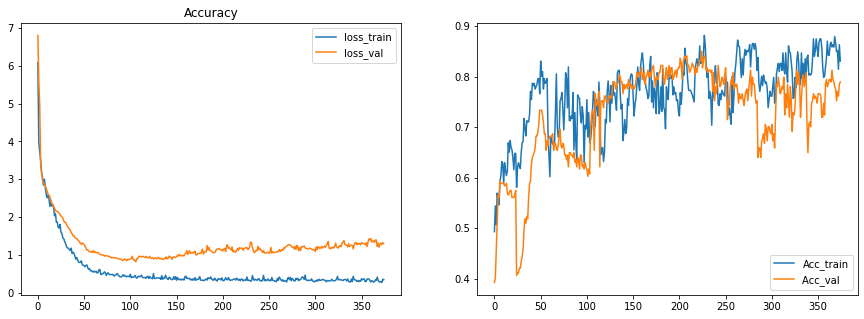

In [25]:
fig,axes = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
axes[0].set_title('Loss')
axes[0].plot(besst_history.history['loss'], label = "loss_train")
axes[0].plot(besst_history.history['val_loss'], label = "loss_val ")
axes[0].legend()

axes[0].set_title('Accuracy')
axes[1].plot(besst_history.history['accuracy'], label = "Acc_train")
axes[1].plot(besst_history.history['val_accuracy'], label = "Acc_val ")
axes[1].legend()
plt.show()

In [26]:

models = []
models.append(('SVM rbf',   model_1))
models.append(('SVM lin',   model_2))
models.append(('LogReg',    model_3))
models.append(('GradBoost', model_4))
models.append(('AdaBoost',  model_5))
models.append(('Bagging',   model_6))
models.append(('RForest',   model_7))
models.append(('Dense',   model))

In [27]:

models = []
models.append(('SVM rbf', grid_1.best_estimator_))
models.append(('SVM linear', grid_2.best_estimator_))
models.append(('LogReg', grid_3.best_estimator_))
models.append(('GradBoost ', grid_4.best_estimator_))
models.append(('AdaBoost', grid_5.best_estimator_))
models.append(('Bagging', grid_6.best_estimator_))
models.append(('RForest', grid_7.best_estimator_))
models.append(('Dense',   model))


In [28]:
from sklearn import  metrics

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []

for name, model in models:
    print()
    print(name)
    if name != 'Dense' and name !=  'Dense_2':
        predictions = model.predict(X_val)
    else:
        predictions = np.argmax(model.predict(sc.transform(X_val)),axis=1)
        #predictions = model.predict(X_val)

    print("accuracy_score: {}".format( metrics.accuracy_score(y_val, predictions) ))    
    print("precision_score: {}".format(metrics.precision_score(y_val, predictions) ))
    print("recall_score: {}".format( metrics.recall_score(y_val, predictions) ))
    print("f1_score: {}".format( metrics.f1_score(y_val, predictions) ))
    accuracy_score.append(metrics.accuracy_score(y_val, predictions))
    precision_score.append(metrics.precision_score(y_val, predictions))
    recall_score.append(metrics.recall_score(y_val, predictions))
    f1_score.append( metrics.f1_score(y_val, predictions))



SVM rbf
accuracy_score: 0.8457943925233645
precision_score: 0.8429752066115702
recall_score: 0.8793103448275862
f1_score: 0.860759493670886

SVM linear
accuracy_score: 0.7663551401869159
precision_score: 0.7619047619047619
recall_score: 0.8275862068965517
f1_score: 0.7933884297520662

LogReg
accuracy_score: 0.7850467289719626
precision_score: 0.7777777777777778
recall_score: 0.8448275862068966
f1_score: 0.8099173553719008

GradBoost 
accuracy_score: 0.8364485981308412
precision_score: 0.8461538461538461
recall_score: 0.853448275862069
f1_score: 0.8497854077253219

AdaBoost
accuracy_score: 0.8504672897196262
precision_score: 0.868421052631579
recall_score: 0.853448275862069
f1_score: 0.8608695652173913

Bagging
accuracy_score: 0.8457943925233645
precision_score: 0.8672566371681416
recall_score: 0.8448275862068966
f1_score: 0.8558951965065502

RForest
accuracy_score: 0.8271028037383178
precision_score: 0.8434782608695652
recall_score: 0.8362068965517241
f1_score: 0.8398268398268398

Den

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [29]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf','SVM linear','LogReg','GraBoost','AdaBoost','Bagging','RForest','Dense'])
df

Method  precision_score  recall_score  f1_score  accuracy_score
0     SVM rbf         0.842975      0.879310  0.860759        0.845794
1  SVM linear         0.761905      0.827586  0.793388        0.766355
2      LogReg         0.777778      0.844828  0.809917        0.785047
3    GraBoost         0.846154      0.853448  0.849785        0.836449
4    AdaBoost         0.868421      0.853448  0.860870        0.850467
5     Bagging         0.867257      0.844828  0.855895        0.845794
6     RForest         0.843478      0.836207  0.839827        0.827103
7       Dense         0.718750      0.793103  0.754098        0.719626

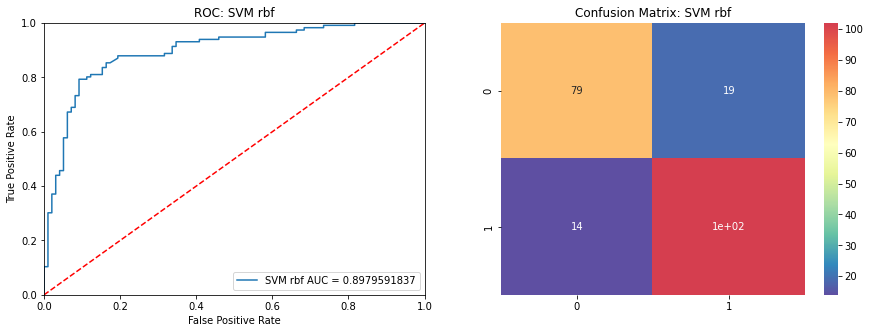

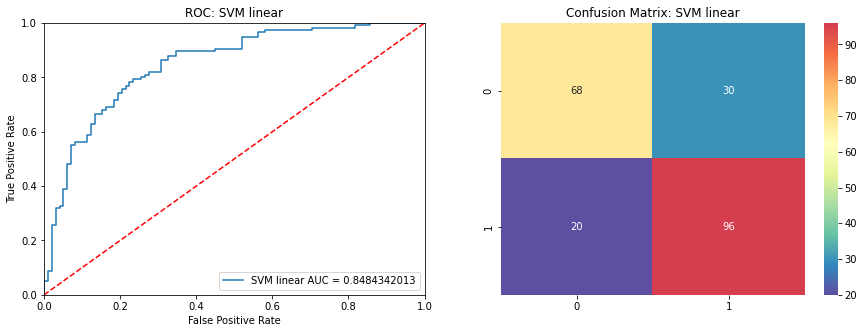

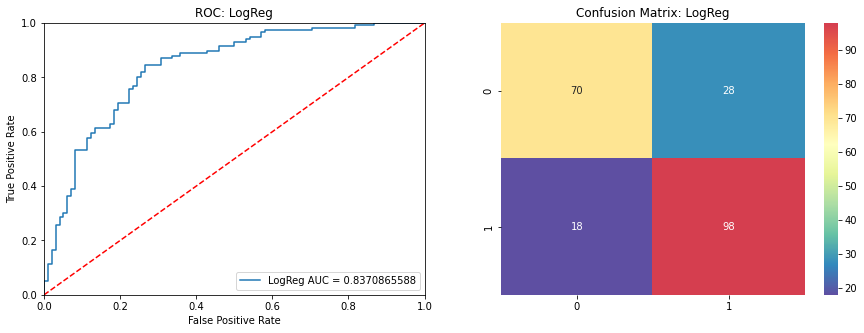

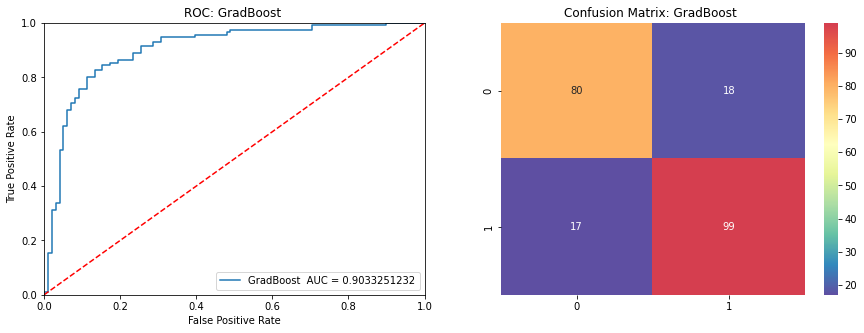

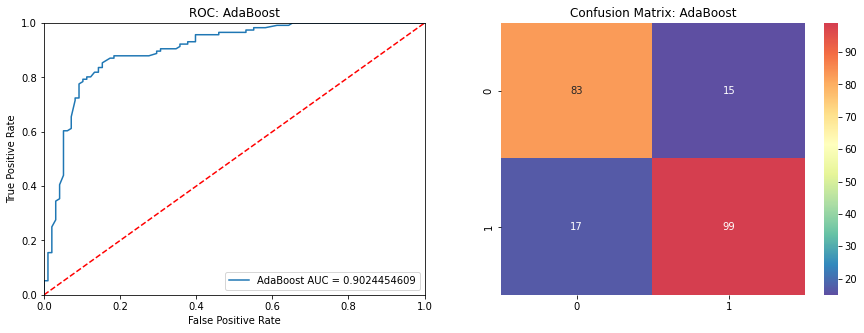

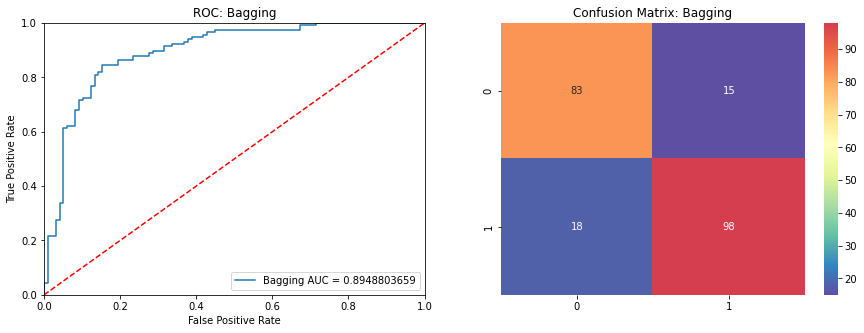

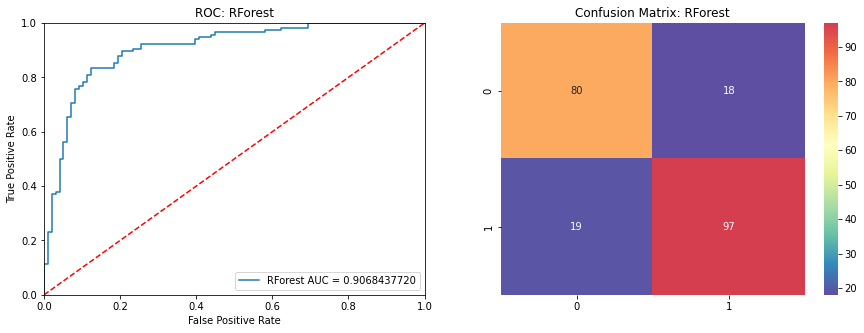

C:\Users\barak\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


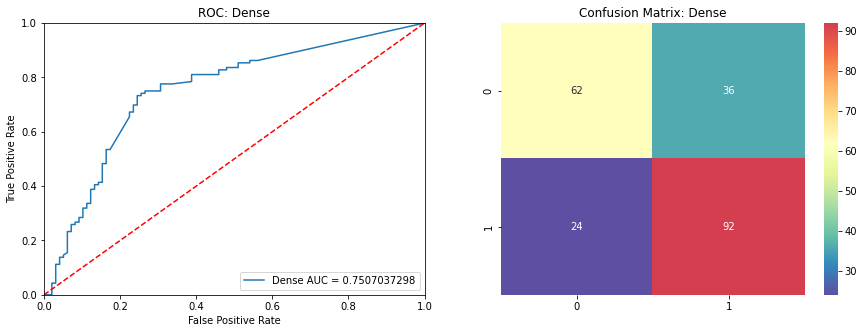

In [30]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt

rainbow = cm.get_cmap('Spectral', 512).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.0, 0.9, 512)))
newcmp

for name, model in models:
# calculate the fpr and tpr for all thresholds of the classification
    if name != 'Dense':
        probs = model.predict_proba(X_val)
        predictions = model.predict(X_val)

    else:
        probs = model.predict(X_val)
        predictions = np.argmax(model.predict(sc.transform(X_val)),axis=1)

    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)
    fig,axes = plt.subplots(1,2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    axes[0].set_title('ROC: {}'.format(name))
    axes[0].plot(fpr, tpr, label = '%s AUC = %0.10f' % (name, roc_auc))
    axes[0].legend(loc = 'lower right')
    axes[0].plot([-0, 1], [0, 1],'r--')
    axes[0].set_xlim([-0, 1])
    axes[0].set_ylim([-0, 1])
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    
    axes[1].set_title('Confusion Matrix: {}'.format(name))
    sns.heatmap(confusion_matrix(y_val,predictions),ax=axes[1],annot=True,cmap=newcmp)
    plt.show()
    

### Zachowanie modelu Dense

In [52]:
model_cat = model

model_cat.save(r'C:\Users\barak\Documents\Models')

INFO:tensorflow:Assets written to: C:\Users\barak\Documents\Models\assets


## Inferencja Mózgowych komponentów z obrazków 

### Ładowanie danych Obrazkowych

In [32]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

data_dir_train = r'C:\Users\barak\Documents\New_AI_Projekt\aimages_train_best'

#Rozmiary obrazka są tak ustawione, żeby najlepiej uczyły się sieci. 
img_height = 299
img_width = 299
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 630 files belonging to 2 classes.
Using 504 files for training.
Found 630 files belonging to 2 classes.
Using 126 files for validation.


Z nazw Folderu naszych danych, powinny zostać odczytane nazwy klas, sprawdźmy czy działa.

Mamy Brain_IC - które odpowiada komponentowi mózgowemu, oraz Not_brainIC odpowiadający artefaktowi.


In [33]:
class_names = train_ds.class_names
class_names

['BrainIC_2', 'Not_BrainIC']

### Wizualizacja i uwagi o topografiach IC

Zobaczmy jak wyglądają z dwóch klas nasze komponenty, Wzięte są one z różnych datasetów, dlatego czasem będą obecne na nich elektrody a czasem nie. To co jednak mają wspólne to kulsitą reprezentację aktywności mózgowej.

Z powodu też względnej stacjonarności, jakakolwiek **augmentacja obrazu będzie tu niewskazana** - nie mogę zmienić położenia obiektów bo one z natury są względnie stacjonarne, ani kształtu, czy koloru.

Możemy też zauważyć jak nardzo różnorodne są komponenty. W praktyce, zajmuje to bardzo długo, żeby wyuczyć człowieka rozpoznawać komponent móżgowy od artefaktualnego. 

Zanim więc przejdziemy do właściwej klasyfikacji, należy powiedzieć nieco o samych komponentach IC.

- Rozkład ICA będzie dawal najbardziej jasne i prosto rozłożone komponenty na początku analizy, a mniej jasne pod koniec. Dla nas nie ma to wielkiego znaczenia bo komponenty są pomieszane. To co jest ważne, że w dalszych komponentach **rozpoznanie artefaktu od komponentu mózgowego jest ekstremlanie trudne**. Szacuje się, że nawet doświadczeni eksperci nie są w stanie mieć poprawności rozpoznania większej niż 90% 
- Pierwsze 2 lub 3 komponenty pochodzą zazwyczaj z ruchu oczu i tym samym powinny zostać odrzucone
- Szukajac komponentów powinniśmy zwracać uwagę na dużą rozlaną plamę cieplną, która stopniowo maleje. Ewentualnymi komponentami będzie wyraźny efekt ciepłej i zimnej strony. Należy jednak mieć na uwadzę, że często takie komponenty oznaczają ruchy oczu
- komponenty w których aktywność jest skoncentrowana w jednym punkcie to najczęściej artefakty wynikajace ze złego połączenia
- Szacuje się, że nawet eksperci mający lata doświadczenia w rozpoznawaniu komponentów z rozkładu ICA, są wstanie osiągnąć skutecznośc 90%




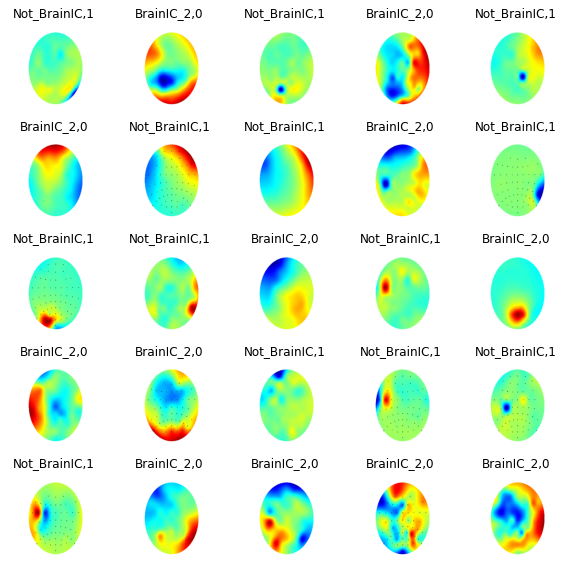

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

df_temp = pd.DataFrame(hsta,columns=['lab'])
df_temp = df_temp['lab'].apply(lambda x: class_names[0] if x==0 else class_names[1])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('{},{}'.format(class_names[labels[i]],labels[i]))
        plt.axis("off")

Weźmy teraz nazwy wszystkich klas i zobaczmy na ile są one zbalansowane

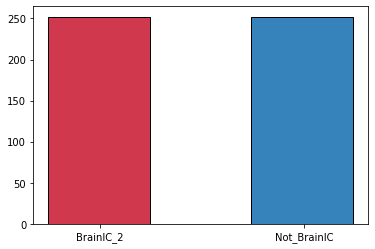

In [37]:
import numpy as np
import matplotlib.pyplot as plt

raw_data =list(train_ds.as_numpy_iterator())
raw_data = [raw_data[i][-1] for i in range(len(raw_data))]
for i in range(len(raw_data)-1):
    hsta = np.hstack((raw_data[i],raw_data[i+1]))
    raw_data[i+1] = hsta

fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(df_temp, edgecolor='black', linewidth=1,bins=3)
rainbow = cm.get_cmap('Spectral', 12).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.1, 0.9, 12)))
newcmp
for i in range(0,1):
    patches[i].set_facecolor(newcmp.colors[-1])
for i in range(1,3):    
    patches[i].set_facecolor(newcmp.colors[0])

ax.set_xticks((0.17,0.84))
plt.show()

Możemy zauważyć silny efekt **niezbalansowania klas** jak więc sobie z tym poradzić?

Mamy kilka opcji:
1) Downsampling do klasy Not_BrainIC: Tracimy dużo danych, nasz model może nie uczyć się w ładny sposób. Problemem jest też to, że klasy BrainIC zazwyczaj jest tak dużo, bo faktycznie mamy bardzo różnorodne komponenty mózgowe a jedynie kilka typów artefaktow

2) Ustawienie wag klas podczas uczenia modelu

        


### Normalizacja danych

Musimy znormalizować nasze dane przed przejściem do sieci. Robimy to przez normalization Layer:

Korzystamy więc z funkcji **map**

In [42]:
from keras.regularizers import l1,l2
from keras.callbacks import History

from keras.layers import Dense,BatchNormalization,Flatten

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Activation

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import History
num_classes = 2
best_model = 1;
early_stopping2 = EarlyStopping(monitor='val_accuracy', patience=30, mode='max', verbose=1,restore_best_weights=True)
best_acc = 0.5
for  Dense1 in [50,100,200]:
    history_cnn = History()
    model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(10, 3, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),  
      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(Dense1, activation='relu',activity_regularizer=l2(0.01)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),
      tf.keras.layers.Dense(50, activation='relu',activity_regularizer=l2(0.01)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu",activity_regularizer=l2(0.01)),
      tf.keras.layers.Dense(10, activation='relu',activity_regularizer=l2(0.01)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu",activity_regularizer=l2(0.01)),
      tf.keras.layers.Dense(num_classes)
    ])


    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

    model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=100,batch_size=
        128,callbacks=[history_cnn,early_stopping2]
    )
    wynik = model.evaluate(val_ds)

    if wynik[1] > best_acc:
        besst_history = history_cnn
        best_model = model
        best_acc = wynik[1]
        
model = best_model

Epoch 1/100
16/16 [==============================] - 8s 187ms/step - loss: 8.3894 - accuracy: 0.5298 - val_loss: 11.3607 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 2s 87ms/step - loss: 8.6388 - accuracy: 0.5972 - val_loss: 22.9415 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 2s 87ms/step - loss: 5.8894 - accuracy: 0.4901 - val_loss: 4.0721 - val_accuracy: 0.4048
Epoch 4/100
16/16 [==============================] - 2s 86ms/step - loss: 5.2857 - accuracy: 0.4762 - val_loss: 6.0276 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 2s 86ms/step - loss: 4.5307 - accuracy: 0.4861 - val_loss: 7.1809 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 2s 87ms/step - loss: 4.8338 - accuracy: 0.5377 - val_loss: 4.5751 - val_accuracy: 0.5238
Epoch 7/100
16/16 [==============================] - 2s 86ms/step - loss: 4.8807 - accuracy: 0.5496 - val_loss: 10.7339 - val_accuracy: 0.5556
Ep

16/16 [==============================] - 2s 87ms/step - loss: 1.5860 - accuracy: 0.4067 - val_loss: 1.6543 - val_accuracy: 0.5079
Epoch 20/100
16/16 [==============================] - 2s 86ms/step - loss: 2.6000 - accuracy: 0.5139 - val_loss: 21.4315 - val_accuracy: 0.5556
Epoch 21/100
16/16 [==============================] - 2s 86ms/step - loss: 3.4648 - accuracy: 0.4325 - val_loss: 27.9819 - val_accuracy: 0.5556
Epoch 22/100
16/16 [==============================] - 2s 86ms/step - loss: 3.7690 - accuracy: 0.4762 - val_loss: 25.7109 - val_accuracy: 0.4524
Epoch 23/100
16/16 [==============================] - 2s 86ms/step - loss: 3.9467 - accuracy: 0.5595 - val_loss: 136.8329 - val_accuracy: 0.5556
Epoch 24/100
16/16 [==============================] - 2s 87ms/step - loss: 2.3685 - accuracy: 0.5060 - val_loss: 137.1051 - val_accuracy: 0.5556
Epoch 25/100
16/16 [==============================] - 2s 86ms/step - loss: 1.6690 - accuracy: 0.5159 - val_loss: 7.3355 - val_accuracy: 0.4444
Epoch

16/16 [==============================] - 2s 86ms/step - loss: 2.4527 - accuracy: 0.4345 - val_loss: 1.8079 - val_accuracy: 0.3571
Epoch 29/100
16/16 [==============================] - 2s 86ms/step - loss: 2.6367 - accuracy: 0.4226 - val_loss: 2.2833 - val_accuracy: 0.3571
Epoch 30/100
16/16 [==============================] - 2s 86ms/step - loss: 2.5432 - accuracy: 0.3810 - val_loss: 2.3459 - val_accuracy: 0.4048
Epoch 31/100
16/16 [==============================] - 2s 86ms/step - loss: 2.1761 - accuracy: 0.4067 - val_loss: 5.8817 - val_accuracy: 0.4444
Epoch 32/100
16/16 [==============================] - 2s 86ms/step - loss: 3.1706 - accuracy: 0.4425 - val_loss: 5.6784 - val_accuracy: 0.4127
Epoch 33/100
16/16 [==============================] - 2s 86ms/step - loss: 2.9674 - accuracy: 0.4226 - val_loss: 3.3771 - val_accuracy: 0.3175
Epoch 34/100
16/16 [==============================] - 2s 86ms/step - loss: 2.6935 - accuracy: 0.4881 - val_loss: 4.4158 - val_accuracy: 0.3730
Epoch 35/100

### Metryki i Wizualizacja

#### Accuracy, F1, Loss

In [45]:
data_dir_test = r'C:\Users\barak\Documents\New_AI_Projekt\aimages_train_best'

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 630 files belonging to 2 classes.


In [46]:
wynik = model.evaluate(test_ds)
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

true = [el for img, el2 in test_ds.as_numpy_iterator() for el in el2]
preds = np.argmax( model.predict(test_ds),axis=1)

print(np.vstack((true,preds)))
print('Accuracy: {}'.format(wynik[1]) )
print('loss: {}'.format(wynik[0]) )
print('f1_score: {}'.format(f1_score(true,preds)))
print('accuracy_score: {}'.format(accuracy_score(true,preds)))
print('precsion_score: {}'.format(precision_score(true,preds)))
print('recall_score: {}'.format(recall_score(true,preds)))


20/20 [==============================] - 1s 59ms/step - loss: 7.0439 - accuracy: 0.6698
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
Accuracy: 0.6698412895202637
loss: 7.043862342834473
f1_score: 0.6645161290322581
accuracy_score: 0.6698412698412698
precsion_score: 0.6912751677852349
recall_score: 0.639751552795031


### Confusion matrix

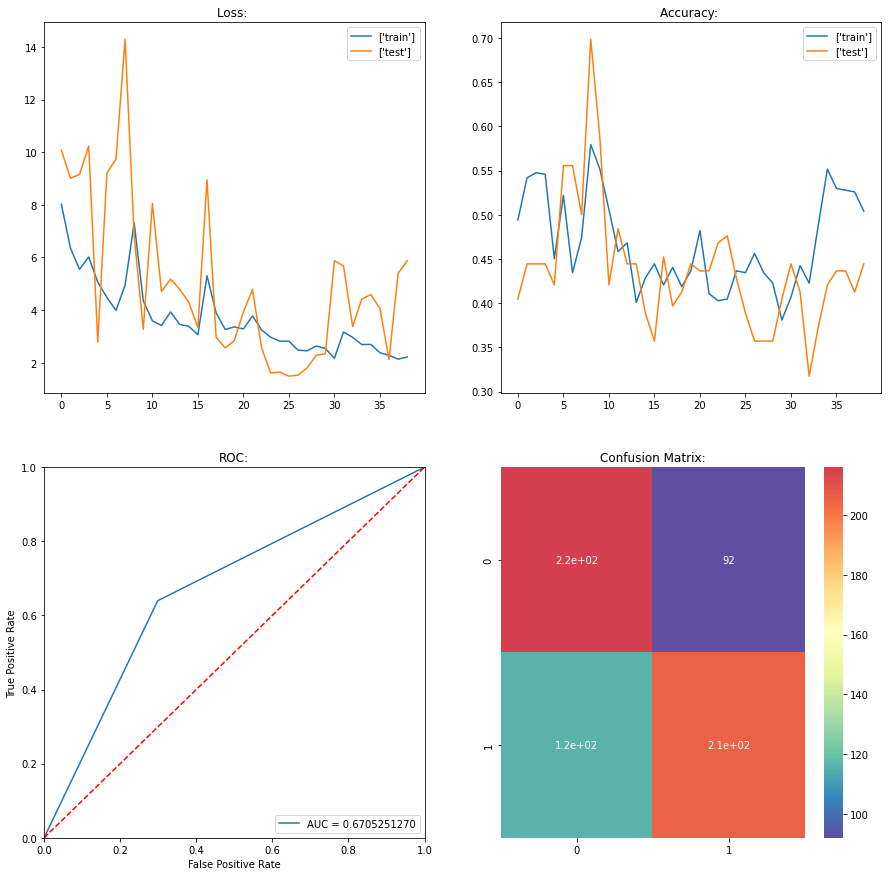

In [47]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import metrics
import seaborn as sns
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
rainbow = cm.get_cmap('Spectral', 512).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.0, 0.9, 512)))
fig,axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(15)

fpr, tpr, threshold = roc_curve(true,preds)
roc_auc = metrics.auc(fpr, tpr)

axes[1][0].set_title('ROC:')
axes[1][0].plot(fpr, tpr, label = 'AUC = %0.10f' % ( roc_auc))
axes[1][0].legend(loc = 'lower right')
axes[1][0].plot([-0, 1], [0, 1],'r--')
axes[1][0].set_xlim([-0, 1])
axes[1][0].set_ylim([-0, 1])
axes[1][0].set_ylabel('True Positive Rate')
axes[1][0].set_xlabel('False Positive Rate')

axes[1][1].set_title('Confusion Matrix:')
sns.heatmap(confusion_matrix(true,preds),ax=axes[1][1],annot=True,cmap=newcmp)

axes[0][1].set_title('Accuracy: ')
axes[0][1].plot(besst_history.history["accuracy"],label=['train'])
axes[0][1].plot(besst_history.history["val_accuracy"],label=['test'])
axes[0][1].legend()

axes[0][0].set_title('Loss: ')
axes[0][0].plot(besst_history.history["loss"],label=['train'])
axes[0][0].plot(besst_history.history["val_loss"],label=['test'])
axes[0][0].legend()

plt.show()


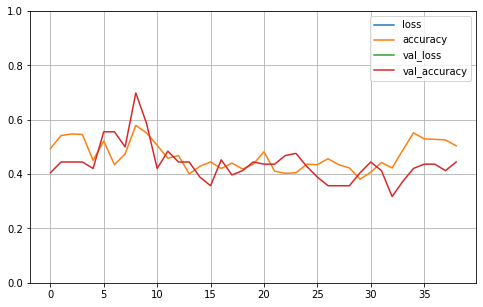

In [48]:
pd.DataFrame(besst_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Próbna klasyfikacja

C:\Users\barak\AppData\Local\Temp\ipykernel_2536\3214040050.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(5, 5, i + 1)


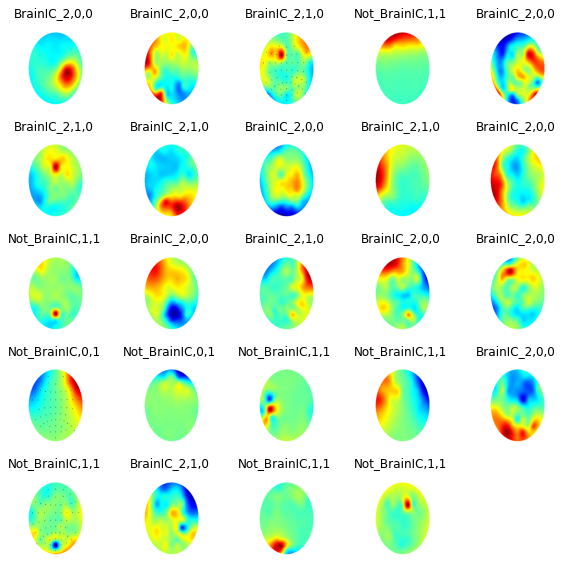

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for data_pack in train_ds:
    images = data_pack[0]
    labels = data_pack[1]
    preds = np.argmax(model.predict(images),axis=1)
    for i in range(24):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title('{},{},{}'.format(class_names[labels[i]],preds[i],labels[i]))
        plt.axis("off")

In [51]:
model_img = model

model_img.save(r'C:\Users\barak\Documents\Models2')

INFO:tensorflow:Assets written to: C:\Users\barak\Documents\Models2\assets


## Transfer Learning

Spróbujmy teraz, czy może uczenie Transferowe pomoże i nauczy modele lepiej: 

In [ ]:
data_dir_train = r'C:\Users\barak\Documents\New_AI_Projekt\aimages_train_best'

#Rozmiary obrazka są tak ustawione, żeby najlepiej uczyły się sieci. 
img_height = 299
img_width = 299
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3
base_model = InceptionV3(weights='imagenet',include_top=False)
base_model.summary()

In [ ]:
inc = InceptionV3()
inc.summary()

In [ ]:
model = InceptionV3(weights='imagenet',include_top=True,input_shape=(img_height,img_width,3))

from keras.callbacks import History

history_transfer = History()
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(440))
top_model.add(Activation('relu'))
top_model.add(Dense(220))
top_model.add(Activation('relu'))
top_model.add(Dense(2))
model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

In [ ]:
model_transfer.compile(
  optimizer='rmsprop',
  loss='binary_crossentropy',
  metrics=['accuracy'])

model_transfer.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,batch_size=128,callbacks=[history_transfer,early_stopping2]
)
model_transfer.evaluate(val_ds)